In [1]:
#@title Importing & Initialization
import numpy as np
from scipy.io import loadmat,savemat
from scipy.interpolate import interp1d
from scipy.fft import fft, ifft
import scipy.integrate as integral
import time
import random
from scipy.io import savemat,loadmat
import matplotlib.pyplot as plt
import os
import math
import torch as T
from torch.fft import fft2,ifft2,ifftshift,fftshift
from numba import njit, prange
from tqdm import tqdm
import cv2
import warnings
from matplotlib import style
import statistics
warnings.filterwarnings('ignore')



In [2]:
#@title Device Selection
global device
device = T.device("cuda:0" if T.cuda.is_available() else "cpu")
print('Using ', device)

Using  cuda:0


In [3]:
#@title Initial Variables
scale = 1

lambda_ = 1.064e-3
#w0 = 2
Rc= 1e25
k=2*np.pi/lambda_
theta_g = 0.5
#zR=np.pi*w0**2/lambda_
Dx = Dy = scale* 64
z = scale* 3400
Np = scale* 6000

x = T.linspace(-Dx/2,Dx/2, Np)
y=x
X,Y = T.meshgrid(x,y,indexing='xy')

[array([1.        , 0.99986137, 0.99944548, 0.99875234, 0.99778193,
       0.99653426, 0.99500934, 0.99320716, 0.99112772, 0.98877102,
       0.98613706])]


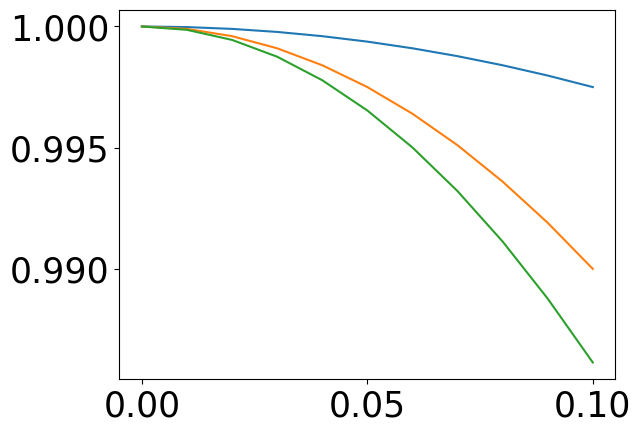

In [154]:
#@title Analytical
dp = np.linspace(0,0.1,11)
ef0 = 1
effm = []
efp = ef0*(1-(0.25*(dp)**2))
efw = ef0*(1- (dp)**2)
efpn = ef0*(1-2*np.log(2)*((dp))**2)
eflp = ef0*(1- (dp)**2)
plt.plot(dp,efp)
effm.append(efpn)
print(effm)
plt.plot(dp,efw)
plt.plot(dp,efpn)

In [4]:
#@title Functions
#Cart to polar coordinates
def cart2pol(x,y):
    # print("cart2pol")
    rho = np.sqrt(x**2 + y**2)
    phi = np.arctan2(y,x)
    return phi, rho

#function to generate beams
def beam_generation1D(Rc,w0,dp,ax,aza,dthp,dthaz,a,b):


    s = time.time()
    scale = 1

    lambda_ = 1.064e-3
    #w0 = 2
    #Rc= 1e25
    k=2*np.pi/lambda_
    #theta_g = 0.5
    #zR=np.pi*w0**2/lambda_
    Dx = Dy = scale* 64
    z=scale* 3400
    Np = scale* 6000

    #w0 = 2
    x = T.linspace(-Dx/2,Dx/2,Np).to(device)
    y=x
    X,Y = T.meshgrid(x,y, indexing='xy')
    zR=np.pi*w0**2/lambda_
    #ax= pa + dthp

    axr = ax*np.pi/180
    #ax11 = np.arctan(np.sqrt(2)*np.tan(ax1))
    ax1 = ax + dthp
    axr1 = ax1*np.pi/180


    by = aza + dthaz
    byr1 = by*np.pi/180
    ds1= np.tan(axr)*z
    ds2= np.tan(axr1)*z
    Pa= T.exp(1j*k*X*np.sin(axr1)*np.cos(byr1) + 1j*k*Y*np.sin(axr1)*np.sin(byr1))#.to(device)
    #print(Pa)
    R=T.sqrt((X-(ds1*a))**2+(Y-(ds1*b))**2)#.to(device)

    P= dp
    A=(2*P)/(np.pi*(w0**2))
    C1=np.sqrt(A)*T.exp(1j*k*(R**2)/(2*Rc))#.to(device)
    e1 = T.exp(-(R**2)/(w0**2))
    Psi=C1*e1 *Pa#.to(device) #*np.exp(1j*np.pi)

    Ap = T.ones(X.shape).to(device)
    r=3
    Ap[R>r]=0
    uout = Psi * Ap

    #plt.imshow(np.real(A))
    e = time.time()-s
    return uout

def beam_generation2D(Rc,w0,dp,ax,aza,dthp,dthaz,a,b, axd):


    s = time.time()
    scale = 1

    lambda_ = 1.064e-3
    #w0 = 2
    #Rc= 1e25
    k=2*np.pi/lambda_
    #theta_g = 0.5
    #zR=np.pi*w0**2/lambda_
    Dx = Dy = scale* 64
    z=scale* 3400
    Np = scale* 6000

    #w0 = 2
    x = T.linspace(-Dx/2,Dx/2,Np).to(device)
    y=x
    X,Y = T.meshgrid(x,y, indexing='xy')
    zR=np.pi*w0**2/lambda_
    #ax= pa + dthp

    axr = ax*np.pi/180
    #ax11 = np.arctan(np.sqrt(2)*np.tan(ax1))
    ax1 = axd + dthp #0.70708883252643 + dthp
    axr1 = ax1*np.pi/180


    by = aza + dthaz
    byr1 = by*np.pi/180

    ds1= np.tan(axr)*z
    ds2= np.tan(axr1)*z
    Pa= T.exp(1j*k*X*np.sin(axr1)*np.cos(byr1) + 1j*k*Y*np.sin(axr1)*np.sin(byr1))#.to(device)
    #print(Pa)
    R=T.sqrt((X-(ds1*a))**2+(Y-(ds1*b))**2)#.to(device)

    P= dp
    A=(2*P)/(np.pi*(w0**2))
    C1=np.sqrt(A)*T.exp(1j*k*(R**2)/(2*Rc))#.to(device)
    e1 = T.exp(-(R**2)/(w0**2))
    Psi=C1*e1 *Pa#.to(device) #*np.exp(1j*np.pi)

    Ap = T.ones(X.shape).to(device)
    r=3
    Ap[R>r]=0
    uout = Psi * Ap

    #plt.imshow(np.real(A))
    e = time.time()-s
    return uout
def rectangularPulse(start,stop,x):
    s = time.time()
    pulse = []
    for i in x:
        if start<i and stop>i:
            val = 1
        elif i==stop or i==start:
            val = 0.5
        else:
            val = 0
        pulse.append(val)
    pulse = np.array(pulse)
    e = time.time() - s
    # print('rectangularPulse: ',str(e),'s')
    return pulse

@njit(parallel=True,fastmath=True)
def get_gamma(len_alpha,len_beta,alpha,beta):
    gamma = np.zeros((len_alpha,len_beta))
    for j in prange(len_beta):
        for i in prange(len_alpha):
            if alpha[i]**2 + beta[j]**2 > 1:
                gamma[j,i] = 0
            else:
                gamma[j,i] = np.sqrt(1-alpha[i]**2-beta[j]**2)
    return gamma


def rs_propagation(uin,z):
    start = time.time()
    layer = uin
    scale = 1
    lambda_ = 1.064e-3
    Dx = Dy = scale* 64
    phy_x= Dx
    phy_y= Dy

    obj_size = layer.shape
    r,c = layer.shape[0], layer.shape[1]
    Fs_x = obj_size[1]/phy_x
    Fs_y = obj_size[0]/phy_y

    dFx=Fs_x/obj_size[1]
    dFy=Fs_y/obj_size[0]
    Fx=np.arange(-Fs_x/2,Fs_x/2,dFx)
    Fy=np.arange(-Fs_y/2,Fs_y/2,dFy)
    alpha=lambda_*Fx
    beta=lambda_*Fy
    len_alpha=len(list(alpha))
    len_beta=len(list(beta))
    gamma=get_gamma(len_alpha,len_beta,alpha,beta)


    #def rectangularPulse(start,stop,x):
    H0 = T.tensor(np.exp(1j*k*gamma*z)).to(device)
    Fxlim = 1/(np.sqrt(1+(2*dFx*z)**2)*lambda_)
    Fylim = 1/(np.sqrt(1+(2*dFy*z)**2)*lambda_)

    FxBL = T.tensor(np.zeros((len(list(beta)),len(list(alpha))))).to(device)
    FyBL = T.tensor(np.zeros((len(list(beta)), len(list(beta))))).to(device)
    FxBLr = T.tensor(rectangularPulse(-Fxlim,Fxlim,Fx)).to(device)
    FyBLc = T.tensor(rectangularPulse(-Fxlim,Fylim,Fy)).to(device)

    for i in range(c):
        FxBL[i,0:r]=FxBLr
    for j in range(r):
        FyBL[0:c,j]=FyBLc

    H1=H0*FxBL*FyBL
    #uout=np.fft.ifft2(np.fft.ifftshift((np.fft.fftshift(np.fft.fft2(uin)))*H1))
    uout = ifft2(ifftshift((fftshift(fft2(layer)))*H1))
    end = time.time()-start
    return uout

#grating function
def grating(theta_g):
    theta_gr = theta_g*(np.pi/180)
    Ax=np.ones((1,Np),dtype=complex) #Define a Matrix by assigning 1 to all pixels
    Period = lambda_/np.sin(theta_gr) #0.24 #Define the period of the grating
    Px = Period*Np/Dx
    FF=0.5 #Define fill factor
    # Constructing the Grating

    for q in range (Np): #Scan pixel by pixel
        if q%Px<Px*FF: #Use remainder function ‘rem’ to construct the grating
            Ax[0,q]=  2#np.exp(1j*(np.pi))

    Ax=np.tile(Ax,(Np,1)) #replicate the row to create a 2D grating
    #Ay = [[Ax[j][i] for j in range(len(Ax))] for i in range(len(Ax[0])-1,-1,-1)]
    #Ay = np.rot90(Ax)
    A = Ax + np.rot90(Ax) #* np.exp(1j*(np.pi))
    A[A==2] = 1
    A[A==4] = 1
    A[A==3] = np.exp(1j*(np.pi))
    return A

def grating_1D(theta_g):
    theta_gr = theta_g*(np.pi/180)
    A=np.ones((1,Np),dtype=complex) #Define a Matrix by assigning 1 to all pixels
    Period = lambda_/np.sin(theta_gr) #0.24 #Define the period of the grating
    Px = Period*Np/Dx
    FF=0.5 #Define fill factor
    # Constructing the Grating

    for q in range (Np): #Scan pixel by pixel
        if q%Px<Px*FF: #Use remainder function ‘rem’ to construct the grating
            A[0,q]=np.exp(1j*(np.pi))
    #A=np.tile(A,(Np,1))
    grating =T.tensor(np.tile(A,(Np,1))).to(device)
    #A1=A.cpu().detach().numpy() #replicate the row to create a 2D grating
    #plt.imshow(np.real(A1))

    return grating


def grating_2D(theta_g):
    start = time.time()
    #Np = 4096
    lambda_ = 1.064e-3
    #Dx = 50
    FF=0.5
    #theta_g = 0.5
    theta_gr = theta_g*(np.pi/180)
    #Define a Matrix by assigning 1 to all pixels
    Period = lambda_/np.sin(theta_gr)  # Number of columns
    # Checkerboard period (alternating squares)
    Px = Period*Np/Dx
    # Create a 2D grid of indices using NumPy meshgrid
    x, y = np.meshgrid(np.arange(Np), np.arange(Np))

    # Create a binary checkerboard pattern using the modulus operator
    A = np.mod(np.floor(x/(Px*FF)) + np.floor(y/(Px*FF)), 2)
    g = np.array(A, dtype=complex)
    g[g==1] = 1
    g[g==0] = np.exp(1j*(np.pi))

    grating = T.tensor(g).to(device)
    return grating




def create_multi_level_grating(n_level=4,num_pixel=4096):
    n_val = np.linspace(0,np.pi,n_level)
    flipped = np.flip(n_val[1:-1])
    Dx = 50
    theta_g = 0.5
    theta_gr = theta_g*(np.pi/180)
    Period = lambda_/np.sin(theta_gr) #0.24 #Define the period of the grating
    Px = Period*Np/Dx
    for i in flipped:
        n_val = np.append(n_val,i)
    n_val
    width=Px//len(n_val)
    c=0
    l=[]
    for i in range(num_pixel):
        l.append(n_val[c])
        if i%width ==0 and i !=0:
            if c ==len(n_val)-1:
                c=0
            else:
                c+=1
    l_2d = np.tile(l,num_pixel)
    grating = (l_2d.reshape(num_pixel,num_pixel)+l_2d.reshape(num_pixel,num_pixel).T)/2
    return grating,l
#PUB
def PIB(iout,Roc, xp, yp):

    sx,sy=iout.shape
    x=np.linspace(-Dx/2,Dx/2,Np)
    X,Y=np.meshgrid(x,x)
    R=np.sqrt((X+xp)**2+(Y+yp)**2)
    PIBCirc=np.ones((sx,sy))
    PIBCirc[R>Roc]=0
    iCirc= PIBCirc* iout
    PIBc=np.sum(iCirc)
    #e = time.time()-s
    return PIBc

#Transverse phase abberation
def TPA(rh,th,TPstd):
    s = time.time()
    ax= 0.5

    axr = ax*np.pi/180
    ds1= np.tan(axr)*z
    R = 5
    rho = T.tensor(rh/R).to(device)
    th = T.tensor(th).to(device)
    #abr = T.tensor(abr).to(device)
    ZP1 = 2*rho*T.sin(th)
    ZP2 = 2*rho*T.cos(th)

    ZP3 = np.sqrt(3)*(2*(rho**2)-1)

    ZP4 = np.sqrt(6)*(rho**2*T.sin(2*th))
    ZP5 = np.sqrt(6)*(rho**2*T.cos(2*th))

    ZP6 = np.sqrt(8)*((3*rho**3 - 2*rho)*T.sin(th))
    ZP7 = np.sqrt(8)*((3*rho**3 - 2*rho)*T.cos(th))

    ZP8 = np.sqrt(8)*(rho**3*T.sin(3*th))
    ZP9 = np.sqrt(8)*(rho**3*T.cos(3*th))

    ZP10 = np.sqrt(5)*(6*(rho**4)-6*(rho**2)+1)


    abr = np.random.normal(0, TPstd, 10)
    #abr = T.tensor(abr).to(device)
    ZPt = abr[0]*ZP1 + abr[1]*ZP2 + abr[2]*ZP3 + abr[3]*ZP4 + abr[4]*ZP5 + abr[5]*ZP6 + abr[6]*ZP7 + abr[7]*ZP8 + abr[8]*ZP9 + abr[9]*ZP10
    ZPt[rho>1] = 0
    AbPh = T.exp(1j*2*np.pi*ZPt)
    #AbPh = T.AbPh.to(device)
    e = time.time()-s
    #print('Transverse_ph_abbrZP:',str(e),'s')
    return AbPh

def plot_savefig(icpu,i):
    plt.rcParams.update({'font.size': 10})
    #print("Eff=",eff)
    #print(np.max(iout1cpu))

    plt.figure(figsize=(5,4))
    plt.imshow(icpu, extent=[0,50,0,50], cmap= 'hot')
    plt.xlabel("Millimeters")
    plt.ylabel("Millimeters")
    #plt.xlim(1000,4000)
    #plt.ylim(1000,4000)
    plt.colorbar()
    plt.savefig('./files2/icpu_'+str(i+17)+'.png')
    plt.clf()
    plt.close()
def grating3(grating_size, stack_factor):
  # Parameters
    # grating_size = 64
    # stack_factor = 64
    total_size = 6000
    transition_point_1 = 0.28 #0.22057
    transition_point_2 = 1 #0.44563
    # transition_point_3 = 0.55 #0.55437
    # transition_point_4 = 0.75 #0.77943  # New transition point

    # Generate the binary phase grating
    single_grating = np.ones(grating_size, dtype=complex)
    transition_point_1_index = int(transition_point_1 * grating_size)
    transition_point_2_index = int(transition_point_2 * grating_size)
    # transition_point_3_index = int(transition_point_3 * grating_size)  # Index for the new transition point
    # transition_point_4_index = int(transition_point_4 * grating_size)

    single_grating[:transition_point_1_index] = np.exp(1j*np.pi)
    single_grating[transition_point_1_index:transition_point_2_index] = 1
    # single_grating[transition_point_2_index:transition_point_3_index] = np.exp(1j*np.pi)
    # single_grating[transition_point_3_index:transition_point_4_index] = 1  # Transition at 0.5
    single_grating[transition_point_2_index:] = np.exp(1j*np.pi)

    # Stack the grating
    stacked_grating = np.tile(single_grating, stack_factor)

    # Tile the stacked grating in the orthogonal direction
    g_2d = np.tile(stacked_grating, (6000, 1))
    g3 = T.tensor(g_2d).to(device)
    return g3
def grating3x3(grating_size, stack_factor):
    # Parameters
    # grating_size: Size of the grating in one dimension (e.g., 64)
    # stack_factor: Factor to stack the grating in one direction (e.g., 120)

    #total_size = 1000
    transition_point_1 = 0.28
    transition_point_2 = 1
    # transition_point_3 = 0.55
    # transition_point_4 = 0.75

    # Generate the binary phase grating in one orientation
    single_grating = np.ones((grating_size), dtype=complex)

    transition_point_1_index = int(transition_point_1 * grating_size)
    transition_point_2_index = int(transition_point_2 * grating_size)
    # transition_point_3_index = int(transition_point_3 * grating_size)
    # transition_point_4_index = int(transition_point_4 * grating_size)

    single_grating[:transition_point_1_index] = 2
    single_grating[transition_point_1_index:transition_point_2_index] = 1
    # single_grating[transition_point_2_index:transition_point_3_index] = 2
    # single_grating[transition_point_3_index:transition_point_4_index] = 1  # Transition at 0.5
    single_grating[transition_point_2_index:] = 2

    X_stack = np.tile(single_grating, stack_factor)
    Y_stack = np.tile(X_stack, (6000, 1))
    # Generate the rotated version of the grating (90 degrees rotation)
    rotated_grating = np.rot90(Y_stack)

    # Add the original and rotated gratings together
    A = Y_stack + rotated_grating #np.rot90(Y_stack)
    A[A==2] = 1
    A[A==4] = 1
    A[A==3] = np.exp(1j*(np.pi))
    # # Scale the phases from 0 to pi
    # combined_grating = np.pi * (combined_grating - np.min(combined_grating)) / (np.max(combined_grating) - np.min(combined_grating))

    # # Stack the grating
    # stacked_grating = np.tile(combined_grating, (stack_factor, stack_factor))
    g9 = T.tensor(A).to(device)
    return g9
def grating4(grating_size, stack_factor):
  # Parameters
    # grating_size = 64
    # stack_factor = 64
    total_size = 6000
    transition_point_1 = 0.25 #0.22057
    transition_point_2 = 0.45 #0.44563
    transition_point_3 = 0.55 #0.55437
    transition_point_4 = 0.75 #0.77943  # New transition point

    # Generate the binary phase grating
    single_grating = np.ones(grating_size, dtype=complex)
    transition_point_1_index = int(transition_point_1 * grating_size)
    transition_point_2_index = int(transition_point_2 * grating_size)
    transition_point_3_index = int(transition_point_3 * grating_size)  # Index for the new transition point
    transition_point_4_index = int(transition_point_4 * grating_size)

    single_grating[:transition_point_1_index] = np.exp(1j*np.pi)
    single_grating[transition_point_1_index:transition_point_2_index] = 1
    single_grating[transition_point_2_index:transition_point_3_index] = np.exp(1j*np.pi)
    single_grating[transition_point_3_index:transition_point_4_index] = 1  # Transition at 0.5
    single_grating[transition_point_4_index:] = np.exp(1j*np.pi)

    # Stack the grating
    stacked_grating = np.tile(single_grating, stack_factor)

    # Tile the stacked grating in the orthogonal direction
    g_2d = np.tile(stacked_grating, (6000, 1))
    g4 = T.tensor(g_2d).to(device)
    return g4

def grating4x4(grating_size, stack_factor):
    # Parameters
    # grating_size: Size of the grating in one dimension (e.g., 64)
    # stack_factor: Factor to stack the grating in one direction (e.g., 120)

    #total_size = 1000
    transition_point_1 = 0.25
    transition_point_2 = 0.45
    transition_point_3 = 0.55
    transition_point_4 = 0.75

    # Generate the binary phase grating in one orientation
    single_grating = np.ones((grating_size), dtype=complex)

    transition_point_1_index = int(transition_point_1 * grating_size)
    transition_point_2_index = int(transition_point_2 * grating_size)
    transition_point_3_index = int(transition_point_3 * grating_size)
    transition_point_4_index = int(transition_point_4 * grating_size)

    single_grating[:transition_point_1_index] = 2
    single_grating[transition_point_1_index:transition_point_2_index] = 1
    single_grating[transition_point_2_index:transition_point_3_index] = 2
    single_grating[transition_point_3_index:transition_point_4_index] = 1  # Transition at 0.5
    single_grating[transition_point_4_index:] = 2

    X_stack = np.tile(single_grating, stack_factor)
    Y_stack = np.tile(X_stack, (6000, 1))
    # Generate the rotated version of the grating (90 degrees rotation)
    rotated_grating = np.rot90(Y_stack)

    # Add the original and rotated gratings together
    A = Y_stack + rotated_grating #np.rot90(Y_stack)
    A[A==2] = 1
    A[A==4] = 1
    A[A==3] = np.exp(1j*(np.pi))
    # # Scale the phases from 0 to pi
    # combined_grating = np.pi * (combined_grating - np.min(combined_grating)) / (np.max(combined_grating) - np.min(combined_grating))

    # # Stack the grating
    # stacked_grating = np.tile(combined_grating, (stack_factor, stack_factor))
    g16 = T.tensor(A).to(device)
    return g16

def multigrating(grating_size, stack_factor):

    # grating_size = 64
    # stack_factor = 64
    n = grating_size
    total_size = 6000

    transition_point_1 = 0.5 #0.1255#5/n #0.22057
    transition_point_2 = 1 #2*0.125#15/n #0.44563
    transition_point_3 = 3*0.125#25/n #0.55437
    transition_point_4 = 4*0.125#35/n
    transition_point_5 = 5*0.125 #45/n #0.55437
    transition_point_6 = 6*0.125
    transition_point_7 = 7*0.125
    transition_point_8 = 8*0.125 #0.77943  # New transition point

    # Generate the binary phase grating
    single_grating = np.ones(grating_size, dtype=complex)
    transition_point_1_index = int(transition_point_1 * grating_size)
    transition_point_2_index = int(transition_point_2 * grating_size)
    transition_point_3_index = int(transition_point_3 * grating_size)  # Index for the new transition point
    transition_point_4_index = int(transition_point_4 * grating_size)
    transition_point_5_index = int(transition_point_5 * grating_size)  # Index for the new transition point
    transition_point_6_index = int(transition_point_6 * grating_size)
    transition_point_7_index = int(transition_point_7 * grating_size)  # Index for the new transition point
    transition_point_8_index = int(transition_point_8 * grating_size)

    single_grating[:transition_point_1_index] = 1
    single_grating[transition_point_1_index:transition_point_2_index] = np.exp(1j*np.pi)
    # single_grating[transition_point_2_index:transition_point_3_index] = np.exp(1j*4*np.pi/4)
    # single_grating[transition_point_3_index:transition_point_4_index] = np.exp(1j*6*np.pi/4)
    # single_grating[transition_point_4_index:transition_point_5_index] = np.exp(1j*8*np.pi/4)
    # single_grating[transition_point_5_index:transition_point_6_index] = np.exp(1j*6*np.pi/4)
    # single_grating[transition_point_6_index:transition_point_7_index] = np.exp(1j*4*np.pi/4)
    # single_grating[transition_point_7_index:transition_point_8_index] = np.exp(1j*2*np.pi/4)
    # single_grating[transition_point_8_index:transition_point_9_index] = np.exp(1j*np.pi/2)
    single_grating[transition_point_2_index:] = 1

    # Stack the grating
    stacked_grating = np.tile(single_grating, stack_factor)

    # Tile the stacked grating in the orthogonal direction
    g_2d = np.tile(stacked_grating, (6000, 1))

    gm = T.tensor(g_2d).to(device)
    return gm

def multilevel2D(gm):
    gm[gm==np.exp(1j*np.pi)] = 2
    gm[gm==1] = 1

    A = gm + np.rot90(gm)
    A[A==-1] = 1
    A[A==2] = 1
    A[A==4] = 1
    A[A==3] = np.exp(1j*(np.pi))
    # # Scale the phases from 0 to pi
    # combined_grating = np.pi * (combined_grating - np.min(combined_grating)) / (np.max(combined_grating) - np.min(combined_grating))

    # # Stack the grating
    # stacked_grating = np.tile(combined_grating, (stack_factor, stack_factor))
    gm2 = T.tensor(A).to(device)
    return gm2

def sinu_grating(grating_size, stack_factor, phs1, a, periods=1):
    # Parameters
    # grating_size: Size of the grating (e.g., 64)
    # stack_factor: Factor to stack the grating in one direction (e.g., 120)
    # periods: Number of periods in the grating (e.g., 1)

    # Generate the sinusoidal phase grating
    x = np.arange(grating_size) / grating_size
    phase_profile = a*np.sin(2*phs1 * periods * x)**2 * phs1

    # Stack the grating
    stacked_grating = np.tile(np.exp(1j * phase_profile), stack_factor)

    # Tile the stacked grating in the orthogonal direction
    g_2d = np.tile(stacked_grating, (grating_size * stack_factor, 1))
    #g_2d2 = (g_2d)**2
    #g_2d[np.angle(g_2d)<0] = 1

    gs = T.tensor(g_2d).to(device)
    #gs2 = T.tensor(g_2d2).to(device)
    return gs


def Tgrating(grating_size, stack_factor, maxp, periods=1):
    # Parameters
    # grating_size: Size of the grating (e.g., 64)
    # stack_factor: Factor to stack the grating in one direction (e.g., 120)
    # periods: Number of periods in the grating (e.g., 1)

    # Generate the symmetric triangular phase grating
    x = np.arange(grating_size) / grating_size
    phase_profile = (x * 2*maxp * np.pi * periods) % (2*maxp * np.pi)  # Ensure phase remains within one period

    # Make the phase increase linearly from 0 to 2π and then decrease linearly back to 0 within one period
    phase_profile[phase_profile > maxp*np.pi] = 2*maxp * np.pi - phase_profile[phase_profile > maxp*np.pi]

    # Stack the grating
    stacked_grating = np.tile(np.exp(1j * phase_profile), stack_factor)

    # Tile the stacked grating in the orthogonal direction
    g_2d = np.tile(stacked_grating, (grating_size * stack_factor, 1))
    gt = T.tensor(g_2d).to(device)
    # Plot the phase profile as an image
    # plt.figure(figsize=(10, 5))
    # plt.subplot(1, 2, 1)
    # plt.imshow(np.angle(g_2d), cmap='gray', extent=[0, grating_size * stack_factor, 0, grating_size * stack_factor])
    # plt.colorbar()
    # plt.title("Phase Profile (Image)")
    # plt.xlabel("X-axis")
    # plt.ylabel("Y-axis")

    # # Plot the linear phase change within one period
    # plt.subplot(1, 2, 2)
    # plt.plot(x, phase_profile, 'b-')
    # plt.title("Linear Phase Change within One Period")
    # plt.xlabel("X-axis")
    # plt.ylabel("Phase (radians)")
    # plt.grid()

    # plt.tight_layout()
    # plt.show()
    return gt
def multi2x2(grating_size, stack_factor):
    # Parameters
    # grating_size: Size of the grating in one dimension (e.g., 64)
    # stack_factor: Factor to stack the grating in one direction (e.g., 120)

    #total_size = 1000
    transition_point_1 = 0.5
    transition_point_2 = 1
    # transition_point_3 = 0.55
    # transition_point_4 = 0.75

    # Generate the binary phase grating in one orientation
    single_grating1 = np.ones((grating_size), dtype=complex)
    single_grating2 = np.ones((grating_size), dtype=complex)

    transition_point_1_index = int(transition_point_1 * grating_size)
    transition_point_2_index = int(transition_point_2 * grating_size)
    

    single_grating1[:transition_point_1_index] = np.exp(1j*np.pi/2)
    single_grating1[transition_point_1_index:transition_point_2_index] = 1
    single_grating1[transition_point_2_index:] = np.exp(1j*np.pi/2)

    single_grating2[:transition_point_1_index] = np.exp(1j*np.pi)
    single_grating2[transition_point_1_index:transition_point_2_index] = np.exp(1j*3*np.pi/2)
    single_grating2[transition_point_2_index:] = np.exp(1j*np.pi)

    p1 = int(grating_size/2)
    X1 = single_grating1
    Y1 = np.tile(X1, (p1,1))
    X2 = single_grating2
    Y2 = np.tile(X2, (p1,1))
    Ucell = np.vstack((Y1, Y2))
    X_stack = np.tile(Ucell, stack_factor)
    Y_stack = np.tile(X_stack, (stack_factor, 1))
    # Generate the rotated version of the grating (90 degrees rotation)
    
    gH2x2 = T.tensor(Y_stack).to(device)
    return gH2x2

def multi3x3(grating_size, stack_factor):
    # Parameters
    # grating_size: Size of the grating in one dimension (e.g., 64)
    # stack_factor: Factor to stack the grating in one direction (e.g., 120)

    #total_size = 1000
    transition_point_1 = 0.28
    transition_point_2 = 1
    # transition_point_3 = 0.55
    # transition_point_4 = 0.75

    # Generate the binary phase grating in one orientation
    single_grating1 = np.ones((grating_size), dtype=complex)
    single_grating2 = np.ones((grating_size), dtype=complex)

    transition_point_1_index = int(transition_point_1 * grating_size)
    transition_point_2_index = int(transition_point_2 * grating_size)
    

    single_grating1[:transition_point_1_index] = np.exp(1j*np.pi/2)
    single_grating1[transition_point_1_index:transition_point_2_index] = 1
    single_grating1[transition_point_2_index:] = np.exp(1j*np.pi/2)

    single_grating2[:transition_point_1_index] = np.exp(1j*np.pi)
    single_grating2[transition_point_1_index:transition_point_2_index] = np.exp(1j*3*np.pi/2)
    single_grating2[transition_point_2_index:] = np.exp(1j*np.pi)

    p1 = int(grating_size*0.71)
    p2 = int(grating_size*0.28)
    X1 = single_grating1
    Y1 = np.tile(X1,(22,1))
    X2 = single_grating2
    Y2 = np.tile(X2, (8,1))
    Ucell = np.vstack((Y1, Y2))
    X_stack = np.tile(Ucell, stack_factor)
    Y_stack = np.tile(X_stack, (stack_factor, 1))
    # Generate the rotated version of the grating (90 degrees rotation)
    
    gH3x3 = T.tensor(Y_stack).to(device)
    return gH3x3

In [8]:
def rectangularPulse(start,stop,x):
  s = time.time()
  pulse = []
  for i in x:
    if start<i and stop>i:
        val = 1
    elif i==stop or i==start:
        val = 0.5
    else:
        val = 0
    pulse.append(val)
  pulse = np.array(pulse)
  e = time.time() - s
  # print('rectangularPulse: ',str(e),'s')
  return pulse

@njit(parallel=True,fastmath=True)
def get_gamma(len_alpha,len_beta,alpha,beta):
  gamma = np.zeros((len_alpha,len_beta))
  for j in prange(len_beta):
    for i in prange(len_alpha):
      if alpha[i]**2 + beta[j]**2 > 1:
        gamma[j,i] = 0
      else:
        gamma[j,i] = np.sqrt(1-alpha[i]**2-beta[j]**2)
  return gamma

@njit(parallel=True,fastmath=True)
def getFs(FxBL,FxBLr,FyBL,FyBLc,c,r):
  for i in prange(c):
    FxBL[i,0:r] = FxBLr
  for j in prange(r):
    FyBL[0:c,j] = FyBLc
  return FxBL,FyBL
def PropAngSpecBandLimF(uin,L,Dx,Dy,zmm):

  layer = uin
  # layer1 = T.tensor(layer).to(device)
  lambda_ = L*1e-3
  k = 2*np.pi/lambda_
  z = zmm*1e-3
  phy_x = Dx*1e-3
  phy_y = Dy*1e-3

  obj_size = layer.shape
  r,c = layer.shape[0], layer.shape[1]
  Fs_x = obj_size[1]/phy_x
  Fs_y = obj_size[0]/phy_y

  dFx = Fs_x/obj_size[1]
  dFy = Fs_y/obj_size[0]

  Fx = np.arange(-Fs_x/2,Fs_x/2,dFx)
  Fy = np.arange(-Fs_y/2,Fs_y/2,dFy)

  alpha = lambda_*Fx
  beta = lambda_*Fy
  len_alpha = len(alpha)
  len_beta = len(beta)

  gamma = get_gamma(len_alpha,len_beta,alpha,beta)


  ival = T.tensor(k*gamma*z).to(device)
  H0 = T.exp(1j*ival)

  Fxlim = 1/(np.sqrt(1+(2*dFx*z)**2)*lambda_)
  Fylim = 1/(np.sqrt(1+(2*dFy*z)**2)*lambda_)

  FxBL = np.zeros((len(beta),len(alpha)))
  FyBL = np.zeros((len(beta), len(beta)))
  FxBLr = rectangularPulse(-Fxlim,Fxlim,Fx)
  FyBLc = rectangularPulse(-Fxlim,Fylim,Fx)
  start = time.time()

  # for i,j in zip(range(c),range(r)):
  #   FxBL[i,0:r] = FxBLr
  #   FyBL[0:c,j] = FyBLc
  FxBL,FyBL = getFs(FxBL,FxBLr,FyBL,FyBLc,c,r)

  end = time.time()-start
  # print('Prop time: ', str(end))
  FxBL = T.tensor(FxBL).to(device)
  FyBL = T.tensor(FyBL).to(device)
  H1 = H0*FxBL*FyBL

  uout = ifft2(ifftshift((fftshift(fft2(layer)))*H1))

  return uout

def GaussBeamNDefPsLw(lambda_,w0,Rc,X0,Y0,Dxy,NP,m,zmm):
  s = time.time()
  k = 2*np.pi/lambda_
  zR = np.pi*w0**2/lambda_
  z = zmm*1000

  M = NP
  dx = Dxy/M
  x = T.arange((-M/2 - X0)*dx, (M/2 - X0)*dx,dx).to(device)
  N=NP
  dy = Dxy/N
  y = T.arange((-N/2 - Y0)*dy, (N/2 - Y0)*dy,dy).to(device)

  [X,Y] = T.meshgrid(x,y,indexing='xy')

  R = T.sqrt(X**2+Y**2)#.to(device)
  # phy = T.arctan2(Y,X).to(device)
  P = 1#0.01
  A = (2*P)/(np.pi*(w0*1e-3)**2)
  C = np.sqrt(A)*T.exp(1j*k*(R**2)/(2*Rc)).to(device)

  Psi = C*T.exp(-(R**2)/(w0**2))#*T.exp(1j*m*phy)
  uout = Psi
  e = time.time()-s
  # print('Gaussian_beam: ',str(e),'s')
  return uout

def CirAperN(X1,Y1,Ra,Dx,NP):

  M = NP
  dx = Dx/M
  x = T.arange((-M/2 - X1)*dx, (M/2 - X1)*dx,dx).to(device)
  N=NP
  dy = Dx/N
  y = T.arange((-N/2 - Y1)*dy, (N/2 - Y1)*dy,dy).to(device)
  [X,Y] = T.meshgrid(x,y,indexing='xy')
  s = time.time()
  A = T.ones(X.shape,dtype=T.int16).to(device)
  # A = T.tensor(np.ones(X.shape,dtype=np.float32)).to(device)
  e = time.time()-s
  # print('CirAperN: ',str(e),'s')
  r = Ra
  R = T.sqrt(X**2+Y**2)
  A[R>r] = 0
  return A
def sourceTAC_final(lambda_,w0,Ra,a,NL,Dx,NP,mDr,zm,m,Rc,phNs,amp_v,g_amp,n_channel,XsU,YsU):
  start = time.time()
  k = 2*np.pi/lambda_
  xf = a/2
  yf = round(np.sqrt(3)*a/2)

  theta = mDr
  RN1 = np.random.randint(low=0,high=100,size=(36,))
  RN2 = np.random.randint(low=0,high=100,size=(36,))
  theta_rx = np.radians(theta*RN1/100)
  theta_ry = np.radians(theta*RN2/100)
  kx = k*np.sin(theta_rx)
  ky = k*np.sin(theta_ry)

  mnE = 2*NL+1

  zmm = zm*1000

  # xs = T.arange(NP).to(device)
  # xl = (Dx/NP)*xs
  # xlc = xl - 0.5*xl[NP-1]-XsU
  # ylc = xl - 0.5*xl[NP-1]-YsU
  # X,Y = T.meshgrid(xlc,ylc,indexing='xy')

  U = T.zeros(NP,NP,dtype=T.cfloat).to(device)

  Y0 = np.arange(-2*NL,2*NL+2,2)*xf
  X0 = 0*yf



  phNs1 = T.zeros(n_channel).to(device)#T.tensor(phNs)
  n_cn = 0

  for r in range(mnE):
    u0 = GaussBeamNDefPsLw(lambda_,w0,Rc,X0+XsU,Y0[r]+YsU,Dx,NP,m,zmm)[0:NP,0:NP]
    c0 = CirAperN(X0+XsU,Y0[r]+YsU,Ra,Dx,NP)[0:NP,0:NP]

    UC0 = np.sqrt(g_amp)*u0
    #print(phNs1.shape, UC0.shape)
    Uel_1 = T.multiply(T.exp(1j*phNs1[n_cn]), UC0).to(device)
    E_1i = T.real(Uel_1) + T.tensor(amp_v*T.randn(1)).to(device)
    E_1q = T.imag(Uel_1) + T.tensor(amp_v*T.randn(1)).to(device)
    E_1 = T.complex(E_1i,E_1q).to(device)
    Uel = E_1*c0
    U += Uel
    n_cn += 1

  p=1


  while p <= NL:
    Y1 = np.arange(-2*NL+p,2*NL-p+2,2)*xf
    X1 = p*yf
    for q in range(mnE-p):

      u1p = GaussBeamNDefPsLw(lambda_,w0,Rc,X1+XsU,Y1[q]+YsU,Dx,NP,m,zmm)[0:NP,0:NP]
      c1p = CirAperN(X1+XsU,Y1[q]+YsU,Ra,Dx,NP)[0:NP,0:NP]

      uc1p = np.sqrt(g_amp)*u1p
      Uel_1 = T.multiply(T.exp(1j*phNs1[n_cn]), uc1p).to(device)
      E_1i = T.real(Uel_1) + T.tensor(amp_v*np.random.randn(1)).to(device)
      E_1q = T.imag(Uel_1) + T.tensor(amp_v*np.random.randn(1)).to(device)
      E_1 = T.complex(E_1i,E_1q).to(device)
      Uel = E_1*c1p

      U += Uel
      n_cn += 1

      u1m = GaussBeamNDefPsLw(lambda_,w0,Rc,-X1+XsU,Y1[q]+YsU,Dx,NP,m,zmm)[0:NP,0:NP]
      c1m = CirAperN(-X1+XsU,Y1[q]+YsU,Ra,Dx,NP)[0:NP,0:NP]

      uc1m = np.sqrt(g_amp)*u1m
      Uel_1 = T.multiply(T.exp(1j*phNs1[n_cn]),uc1m).to(device)
      E_1i = T.real(Uel_1) + T.tensor(amp_v*np.random.randn(1)).to(device)
      E_1q = T.imag(Uel_1) + T.tensor(amp_v*np.random.randn(1)).to(device)
      E_1 = T.complex(E_1i,E_1q).to(device)
      Uel = E_1*c1m

      U += Uel
      n_cn += 1
    p += 1

  end = time.time()-start
  # print('Source TAC:',str(end),'s')
  uout = U
  return uout

def TiledAperture_2(im_size,pix_size,n_channel,p_n,n_screens,Kvar,Z,atm,amp_v,g_amp,ra,d_,tilt,TiltFact,f_lens_mm=0):
  start = time.time()
  lambda_ = 1.064*1e-3
  Rc=1e15
  NP=im_size
  Dx=pix_size*NP
  m=0
  Ra= (ra/2)*1e3
  D=d_*1e3
  a=D*NP/Dx
  mDr=0
  w=0.85*Ra

  if n_channel == 1:
    NL=0
  elif n_channel == 7:
    NL = 1
  elif n_channel == 19:
    NL = 2
  elif n_channel == 37:
    NL = 3
  elif n_channel == 61:
    NL = 4
  elif n_channel == 91:
    NL = 5
  elif n_channel == 127:
    NL = 6
  elif n_channel==217:
    NL=8
  else:
    ValueError('Please provide correct channel number..')

  zmm = Z*1e3
  zm = zmm*1e-3
  phNs = p_n
  n_step = n_screens
  zsmm = zmm/(n_step+1)
  w0 = w

  Du = (2*NL+1)*D+1
  ShMag = round(Du/pix_size)
  xSf = round(ShMag/2)
  ySf = round(np.sqrt(3)*ShMag/2)

  ShFx = T.tensor(np.array([0,2,-2,1,-1,1,-1]),dtype=T.int16).to(device)
  ShFy = T.tensor(np.array([0,0,0,1,1,-1,-1]),dtype=T.int16).to(device)
  # ShFx = T.tensor(np.array([0]),dtype=T.int16).to(device)
  # ShFy = T.tensor(np.array([0]),dtype=T.int16).to(device)

  # tilt = 1

  Ln = 2*(NL*D+Ra)
  
  Lnp = Ln/pix_size
  LnF = 2*(Du+NL*D+Ra)
  LnFp = LnF/pix_size
  rPIB = 1.22*lambda_*zmm/Ln
  rPIBp = rPIB/pix_size
  # TiltFact = 0.25
  k = 2*np.pi/lambda_
  rp_lens= 4*(lambda_*f_lens_mm)/(np.pi*Ln*pix_size)
  xs = T.arange(NP).to(device)
  xl = (Dx/NP)*xs
  xlc = xl - 0.5*xl[NP-1]
  X,Y = T.meshgrid(xlc,xlc,indexing='xy')
  U = T.zeros(NP,NP,dtype=T.cfloat).to(device)
  Lens = T.zeros(NP,NP,dtype=T.cfloat).to(device)
  UL = T.zeros(NP,NP,dtype=T.cfloat).to(device)

  phy_x = Dx
  phy_y = Dx

  for sU in range(1):
    Xs = xSf*ShFx[sU]
    Ys = ySf*ShFy[sU]
    kx = k*T.sin(T.arctan(TiltFact*Xs*pix_size/zmm))*tilt
    ky = k*T.sin(T.arctan(TiltFact*Ys*pix_size/zmm))*tilt
    Uab = sourceTAC_final(lambda_,w0,Ra,a,NL,Dx,NP,mDr,zm,m,Rc,phNs[sU],amp_v,g_amp,n_channel,Xs,Ys)
    U += Uab*T.exp(1j*ky*(Y+Ys*pix_size))*T.exp(1j*kx*(X+Xs*pix_size))
    #Lens += SphLens(Uab,phy_x,phy_y,-Xs*pix_size,-Ys*pix_size,NP,lambda_,f_lens_mm)



  # U = sourceTAC_final(lambda_,w0,Ra,a,NL,Dx,NP,mDr,zm,m,Rc,phNs,Kvar,trans_pn,amp_v,g_amp,n_channel)
  U_ = U.cpu().numpy()
  # pib_ = PIB(np.abs(U_)**2,1024,1024,1023,pix_size)
  # print('Input Power: ', np.real(pib_))



  if atm is None:
    z_prop = zmm
  else:
    z_prop = zsmm
  Up = PropAngSpecBandLimF(U,lambda_,phy_x,phy_y,z_prop)  #final field z_prop
  UL = PropAngSpecBandLimF(Lens,lambda_,phy_x,phy_y,f_lens_mm)

  UL_ = UL.cpu().numpy()

  if atm is not None:
    for ii in range(n_step):
      Uat = Up*T.exp(1j*atm[:,:,ii])
      Up = PropAngSpecBandLimF(Uat,lambda_,phy_x,phy_y,z_prop)

  Up_f = Up.cpu().numpy()
  Intf = np.abs(Up_f)**2

  end = time.time() - start
  # print("TAC: ", str(end))
  #return U_,Up_f, Intf,UL_,(xSf*ShFx).cpu().numpy(),(ySf*ShFy).cpu().numpy(),rPIBp,rp_lens
  return U_,Up_f,Intf,rPIBp

def PIBT(uin,Xc,Yc,Roc,pix_size):
  # s = time.time()
  sx,sy = uin.shape
  x = np.arange(sx)
  y = np.arange(sy)

  X,Y = np.meshgrid(x,y)
  Circ = np.ones((sx,sy))
  R = np.sqrt((X-Xc)**2 + (Y-Yc)**2)
  Circ[R>Roc] = 0
  IntfCir = uin*Circ
  IntfCir1 = IntfCir*(pix_size*1e-3)**2
  P = np.sum(IntfCir1)
  uout = P
  # e = time.time()-s
  return np.real(uout)



0.011 0.24 1.00000060602975 2.7896052118985058e-08


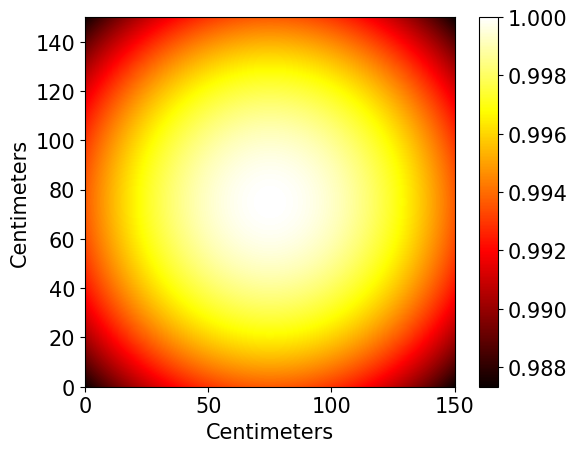

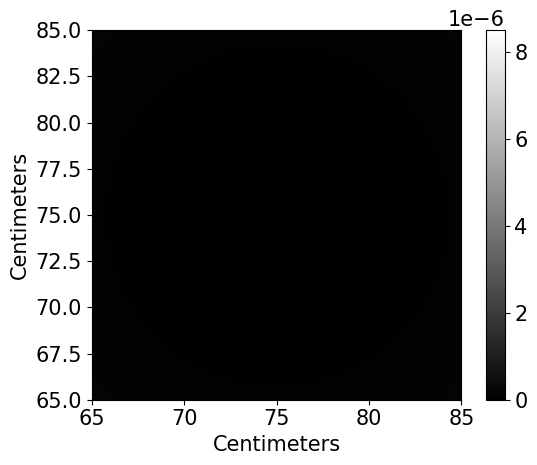

<function PIB at 0x7f4c215e3f70>


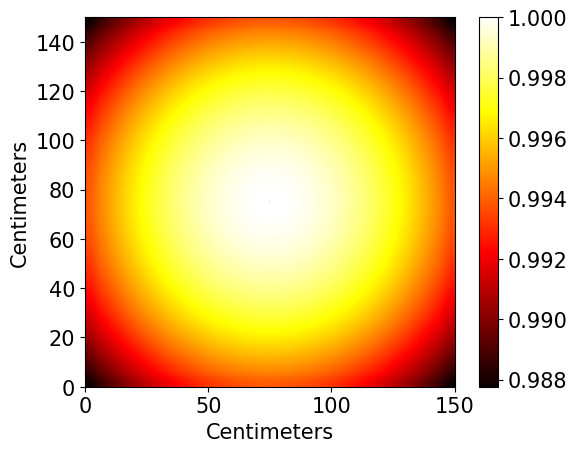

In [11]:
im_size = 6000
pix_size = 0.4
n_channel = 1
p_n = np.zeros(n_channel)
n_screens = 0
Kvar = 0
Z = 8000

atm = None
amp_v = 0
g_amp = 1
ra = 10e-3
d_= 11e-3
tilt = 1
w = 1.064*10e-6
Xc = Yc = 3000
effm = []
ippm = []
ffm = []
n = 1
dm = -1
TiltFact = 0.24
Ra= (ra/2)*1e3
D=d_*1e3
NL = 1
Du = (2*NL+1)*D-dm

LnF = 2*(Du+NL*D+Ra)
ra = LnF/2
for i in range(n):

    InField, OutField,full_array, rPIB = TiledAperture_2(im_size,pix_size,n_channel,p_n,n_screens,Kvar,Z,atm,amp_v,g_amp,ra,d_,tilt,-TiltFact,f_lens_mm=0)

    Pt = np.sum(full_array)*(pix_size*1e-3)**2
    Eff = PIBT(full_array,Xc,Yc,rPIB,pix_size)/Pt
    Iin = np.abs(InField)**2 
    Ipp = np.max(full_array)/np.max(Iin)
    print(d_,TiltFact,Ipp,Eff)
    effm.append(Eff)
    ippm.append(Ipp)
    # plt.imshow(np.angle(InField))
    # plt.xlim(2500,3500)
    # plt.ylim(2500,3500)
    # plt.show()
    # plt.imshow(full_array)
    # plt.show()
    
    TiltFact = TiltFact + 0.02
    #d_ = d_- 0.05e-3


theta = np.linspace(0,2*np.pi,36)
x1 = 150*(full_array.shape[0]//2)//6000 + 150/6000*rPIB*np.cos(theta)
y1 = 150*(full_array.shape[0]//2)//6000 + 150/6000*rPIB*np.sin(theta)

x2 = 150*(full_array.shape[0]//2)//6000 + 150/6000*rPIB*np.cos(theta)
y2 = 150*(full_array.shape[0]//2)//6000 + 150/6000*rPIB*np.sin(theta)

p1, p2 = 65, 85
 

plt.rcParams.update({'font.size': 15})
plt.imshow(Iin/np.max(Iin), extent=[0,150,0,150],cmap ='hot') 
# plt.xlim(p1,p2)
# plt.ylim(p1,p2)
plt.xlabel("Centimeters")
plt.ylabel("Centimeters")
plt.colorbar()
plt.show()

plt.imshow(np.angle(InField), extent=[0,150,0,150], cmap = 'gray') 
#plt.plot(x1,y1,linestyle='--', color = 'indigo')
plt.xlim(p1,p2)
plt.ylim(p1,p2)
plt.xlabel("Centimeters")
plt.ylabel("Centimeters")
plt.colorbar()
plt.show()

plt.imshow(full_array/np.max(Iin), extent=[0,150,0,150], cmap = 'hot') 
plt.plot(x1,y1,linestyle='--', color = 'indigo')
# plt.xlim(p1-55,p2+55)
# plt.ylim(p1-55,p2+55)
plt.xlabel("Centimeters")
plt.ylabel("Centimeters")
plt.colorbar()
print(PIB)

[0.4613824957679943, 0.46472779823700316, 0.46780728473527816, 0.47061569915187496, 0.47314826791886244, 0.4754007212642008, 0.4773692923165842, 0.47905073869730214, 0.4804423348015387, 0.48154189949737675, 0.4823477706259961, 0.4828588437947393, 0.48307454134955824, 0.4829948471104687, 0.48262027927015266, 0.4819519038866472, 0.48099134350828315, 0.4797407412194979, 0.4782027933755334, 0.47638073884887655, 0.4742783203536457, 0.47189982533136515, 0.4692500346584331, 0.46633424958754305, 0.4631582655243172, 0.45972836214838236] [0.13942512189255796, 0.14058407043019372, 0.1416748148907591, 0.14269537677984087, 0.14364394536243202, 0.14451885695537484, 0.14531858511245438, 0.14604176553262052, 0.14668717909804774, 0.14725376488797187, 0.1477406209989849, 0.14814700632470842, 0.1484723458202011, 0.1487162244895475, 0.14887839741702374, 0.14895878548116842, 0.14895747254937067, 0.14887471605160907, 0.14871093558920923, 0.14846672164567665, 0.148142822437146, 0.14774015603789897, 0.1472597

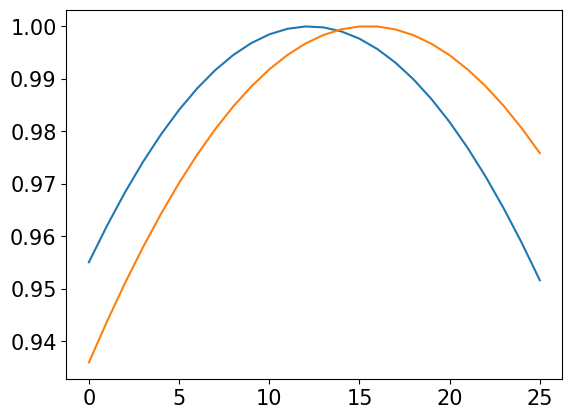

In [57]:
print(effm,ippm)
plt.plot(effm/np.max(effm))

plt.plot(ippm/np.max(ippm))

In [ ]:
#@title Profile Plotting
plt.rcParams.update({'font.size': 25})
# print("Eff=",eff)
# print(np.max(iout1cpu))
theta = np.linspace(0,2*np.pi,36)

x1 = 64*(ioutcpu.shape[0]//2)//6000 + RoC*np.cos(theta)
y1 = 64*(ioutcpu.shape[0]//2)//6000 + RoC*np.sin(theta)
x2 = 64*(ioutcpu.shape[0]//2)//6000 + RoC*np.cos(theta)-R04
y2 = 64*(ioutcpu.shape[0]//2)//6000 + RoC*np.sin(theta)
x3 = 64*(ioutcpu.shape[0]//2)//6000 + RoC*np.cos(theta)-R04
y3 = 64*(ioutcpu.shape[0]//2)//6000 + RoC*np.sin(theta)-R04

plt.figure(figsize=(10,8))
plt.imshow(icpu, extent=[0,64,0,64], cmap= 'hot')
plt.xlabel("Millimeters")
plt.ylabel("Millimeters")
#plt.xlim(30,70)
#plt.ylim(30,70)
plt.colorbar()
plt.show()

In [ ]:
#@title Polarization as Power Change
#Two beam DOE CBC with polarization state as power exchange

ax = 0.5
n = 1
m = 1
print ("Estimated simulation time =", 0.06*m*n,"minutes")
axr = ax*np.pi/180
ds1= np.tan(axr)*z

w01, w02 = 2, 2 #6.2/3,5.8/3,6/3,5.6/3
#dp11, dp12= 0, 0
#dp12 = 0.1
#dpi = 0.5
#theta = 45
# thetar = theta * np.pi/180
# dp = np.sin(thetar)**2

dthaz = 0
pvareff = []
pvareff2 = []
#dp11 = 0
#w01=0.5
dr = 0#-2.5
Rc1 = 1e25 #0.5*1e4
Rc2 = 1e25
dpi = 0

for j in range(m):
    #print("Iteration (m)=",j,"dpi =",dpi)
    #w02 = 1.5
    theta = 0
    #dp12 = 1-dp11
    abc = []
    abc2 = []
#t = np.linspace(1,n,1)
    for i in tqdm(range(n),ncols=120):
        #abr = np.random.uniform(-0.1, 0.1, 2)
        #print(Rc2)
        #dp11, dp12 = 0, 0 #dpi, dpi + dp
        #dp11, dp12= dp + abr[0], dp + abr[1]

        thetar = theta * np.pi/180
        dp = np.sin(thetar)**2
        dp11, dp12 = dpi, 0.5#dpi+dp #
        dp21, dp22 = 1- dp11, 1- dp12
        #dp12 = 1-dp11
        #print(dp11, dp12)
        ux1 = beam_generation1D(Rc1,w01,dp11,0.5,dr,0,dthaz,-1,0)
        ux2 = beam_generation1D(Rc2,w02,dp12,0.5,180+dr,0,dthaz,1,0)
        uy1 = beam_generation1D(Rc1,w01,dp21,0.5,0,0,dthaz,-1,0) * np.exp(1j*np.pi/2)
        uy2 = beam_generation1D(Rc2,w02,dp22,0.5,180+dr,0,dthaz,1,0) * np.exp(1j*np.pi/2)
        #TPA1 = TPA(rh1,th1)
        #TPA2 = TPA(rh2,th2)
        uinx = ux1 + (ux2 * np.exp(1j*np.pi))
        uiny = uy1 + (uy2 * np.exp(1j*np.pi))
        uin2 = uinx + uiny
        uoutx1 = rs_propagation(ux1,600)
        uoutx2 = rs_propagation(ux2,600)
        iin2 = T.abs(uin2)**2
        iin2cpu = iin2.cpu().detach().numpy()
        Pin2 = np.sum(iin2cpu)
        #uout1 = rs_propagation(uin2,600)
        g = grating_1D(0.5)
        #uout1g = uout1 * g
        uoutx1g = uoutx1 * g
        uoutx2g = uoutx2 * g
        uout2x1 = rs_propagation(uoutx1g,600)
        uout2x2 = rs_propagation(uoutx2g,600)
        ioutx1 = T.abs(uout2x1)**2
        ioutx2 = T.abs(uout2x2)**2
        ioutinc = ioutx1 + ioutx2
        ioutincpu = ioutinc.cpu().detach().numpy()
        #uout2 = rs_propagation(uout1g,600)
        #iout2 = T.abs(uout2)**2
        #iout2cpu = iout2.cpu().detach().numpy()
        #Pout2 = np.sum(iout2cpu)
        #PIBc2 = PIB(iout2cpu,5)
        #eff2 = 100* (PIBc2/Pin2)
        #uinx = (ux1 * TPA1) + (ux2 * TPA2 * np.exp(1j*np.pi))
        iin = T.abs(uinx)**2 + T.abs(uiny)**2
        iicpu = iin.cpu().detach().numpy()
        uoutx = rs_propagation(uinx,600)
        uouty = rs_propagation(uiny,600)
        iin2 = T.abs(uoutx)**2  + T.abs(uouty)**2
        ii2cpu = iin2.cpu().detach().numpy()

        uin2x = uoutx * g
        uin2y = uouty * g
        uout2x = rs_propagation(uin2x,600)
        #ang = T.angle(uout2x)
        #angcpu = ang.cpu().detach().numpy()
        uout2y = rs_propagation(uin2y,600)
        iout2x = T.abs(uout2x)**2
        iout2y = T.abs(uout2y)**2
        iout = iout2x +iout2y
        iocpu = iout.cpu().detach().numpy()
        PIBc = PIB(iocpu,5)
        PIBin = PIB(ioutincpu,5)
        effin = 100*(PIBin/Pin2)
        Pin = np.sum(iicpu)
        Pout = np.sum(iocpu)
        eff = 100*(PIBc/Pin)
        abc.append(eff)
        #abc2.append(eff2)
        theta = theta + 2.5
        #print("Iteration (n)=",i, "Eff=", eff)
        #dp12 = dp12 + 0.0499999999
        #w02 = w02 + 0.0499999999
        #dr = dr + 0.1
        #Rc2 = Rc2/2

    #print("Iteration (m)=",j)
    pvareff.append(abc)
    #pvareff2.append(abc2)
    dpi = dpi + 0.5
    #dp11 = dp11 + 0.0499999999
    #w01 = w01 + 0.0499999999
#print(statistics.mean(pvareff[0]),statistics.mean(pvareff[1]),statistics.mean(pvareff[2]),statistics.mean(pvareff[3]),statistics.mean(pvareff[4]),statistics.mean(pvareff[5]),statistics.mean(pvareff[6],statistics.mean(pvareff[7]),statistics.mean(pvareff[8]))
#print(statistics.stdev(pvareff[0]),statistics.stdev(pvareff[1]),statistics.stdev(pvareff[2]),statistics.stdev(pvareff[3]),statistics.stdev(pvareff[4]),statistics.stdev(pvareff[5]),statistics.stdev(pvareff[6]),statistics.stdev(pvareff[7]),statistics.stdev(pvareff[8]))
effwthpol = np.array(pvareff)
# plt.plot(effwthpol)
# plt.xlabel("Time/Iterations")
# plt.ylabel("Efficiency (%)")

In [ ]:
#@title Plotting
print("Eff=",eff,effin)
plt.figure(figsize=(10,8))
plt.imshow(iicpu)
plt.xlim(1000,5000)
plt.ylim(1000,5000)
plt.colorbar()
plt.show()
plt.figure(figsize=(10,8))
plt.imshow(iocpu)
plt.xlim(1000,5000)
plt.ylim(1000,5000)
plt.colorbar()
plt.show()
plt.figure(figsize=(10,8))
plt.imshow(ioutincpu)
plt.xlim(1000,5000)
plt.ylim(1000,5000)
plt.colorbar()


In [ ]:
#@title Two beam combining
#Polarization as phase change
ax = 0.5
n = 1
m = 1
l = 1
print ("Estimated simulation time =", 0.25*m*n,"minutes")
axr = ax*np.pi/180
ds1= np.tan(axr)*z
k = 2*np.pi/lambda_
#w01, w02 = 1, 1
rh1 = T.sqrt((X+(ds1))**2+(Y-(ds1*0))**2)
th1 = T.arctan2(Y-(ds1*0),X+(ds1))
rh2 = T.sqrt((X-(ds1))**2+(Y-(ds1*0))**2)
th2 = T.arctan2(Y-(ds1*0),X-(ds1))
TPstd = 0.0
dthp = 0.00
dthaz = 0
effct = []
imm = []

azh = 0
Rc1 = 1e25
Rc2 = 1e25
dpi = 1
pd = 0.0
#dp1 = 0
#dp11 = 1
#dp1 = 0
w01 = 2
#delta1 = 0#np.pi/4
dph = 0 #np.pi/20
dpol = 0
for j in range (m):
  effm = []
  im = []

  #dp2 = 0
  w02 = 2
  #dp12 = 1
  #delta2 = 0

  print("Updated variable = ", dph)
  for idx in tqdm(range(n),ncols=120):

    dlph = np.random.normal(0, dph, 2)
    pold = np.random.normal(0,dpol,2)
    poldp = np.clip(pold,-dpol/2,dpol/2)
    dpm = np.clip(dlph, -0.99, 1.5 )
    dp11 = dpi + dpm[0]
    dp12 = 0#dpi +dpm[1]
    dp1 = 1#dpi + poldp[0]
    dp2 = 1#dpi + poldp[1]
    #print (dpi,poldp,dp1,dp2)
    pth1 = np.arccos(np.sqrt(dp1))
    pth2 = np.arccos(np.sqrt(dp2))
    #dp11 = 1-dp12
    #dp12 = 0 #- dp11
    #dp21, dp22 = 1- dp11, 1- dp12
    #pth1 = 45
    #pth2 = 45
    pdm = np.random.normal(0, pd, 2)
    TPA1 = 1 #TPA(rh1,th1,TPstd)
    TPA2 = 1 #TPA(rh2,th2,TPstd)
    u1 = beam_generation1D(Rc1,w01,dp11,ax,azh,dthp,dthaz,-1,0) * TPA1 * np.exp(1j*pdm[0])

    #ux2 = beam_generation(Rc2,w02,dp12,0.5,180+dr,0,dthaz,1,0)
    # ux1 = np.sqrt(dp1) * u1 # * np.exp(1j*np.pi)
    # uy1 = np.sqrt(1-dp1) * u1 * np.exp(1j*dlph[0])
    ux1 = np.cos(pth1) * u1  #* np.exp(1j*np.pi*0)
    uy1 = np.sin(pth1) * u1 * np.exp(1j*dlph[0])
    i1 = T.abs(u1)**2

    ix1 = T.abs(ux1)**2
    iy1 = T.abs(uy1)**2
    u2 = beam_generation1D(Rc2,w02,dp12,ax,180+azh,dthp,dthaz,1,0) * TPA2 * np.exp(1j*pdm[1])
    # ux2 = np.sqrt(dp2) * u2 #np.cos(pthr) * u1
    # uy2 = np.sqrt(1-dp2) * u2 * np.exp(1j*dlph[1])
    ux2 = np.cos(pth2) * u2 #* np.exp(1j*np.pi)
    uy2 = np.sin(pth2) * u2 * np.exp(1j*dlph[1])

    Tph = T.angle(u1 + u2)
    Tphcpu =Tph.cpu().detach().numpy()
    #uin = ux1 + ux2 + uy1 + uy2
    i = T.abs(u1)**2 + T.abs(u2)**2
    ix = T.abs(ux1+ux2)**2
    iy = T.abs(uy1+uy2)**2
    icpu = i.cpu().detach().numpy()
    ixcpu = ix.cpu().detach().numpy()
    iycpu = iy.cpu().detach().numpy()
    g = grating_1D(0.5)
    #uin1 = ux1+(ux2*np.exp(1j*np.pi)) + uy1+(uy2 * np.exp(1j*np.pi))
    #uout1 = rs_propagation(uin1,600)
    #uoutg = uout1 * g
    #uout2 = rs_propagation(uoutg,600)
    #ioutb = T.abs(uout2)**2
    #ioutbcpu = ioutb.cpu().detach().numpy()
    uout1x = rs_propagation((ux1)+(ux2*np.exp(1j*np.pi)),600)
    #uout1x = rs_propagation((ux1+ux2),600)

    g4 = grating4(50,120)
    gm = multigrating(60,100)
    gs = sinu_grating(60, 100, periods=1)
    g16 = grating4x4(50,120)
    #gt = Tgrating(50,120)

    uout1xg = uout1x * g16
    uout1y = rs_propagation(uy1+(uy2 * np.exp(-1j*np.pi)),600)
    #uout1y = rs_propagation((uy1+uy2),600)
    iout1 = T.abs(uout1x)**2 + T.abs(uout1y)**2
    iout1cpu = iout1.cpu().detach().numpy()

    #imax = np.max(iout1cpu)
    #im.append(imax)
    uout1yg = uout1y * g16
    uout2x = rs_propagation(uout1xg,6000)
    uout2y = rs_propagation(uout1yg,6000)

    iout = T.abs(uout2x)**2 + T.abs(uout2y)**2
    ioutcpu = iout.cpu().detach().numpy()

    #plot_savefig(ioutcpu,idx)



    #imax = np.max(ioutcpu)
    #im.append(imax)
    ps = 1
    RoC = 5
    PIBc = PIB(ioutcpu,RoC,0,0)


    Pin = np.sum(icpu)
    #print(Pin,Pout)
    Pout = np.sum(ioutcpu)
    eff = 100*(PIBc/Pin)

    effm.append(eff)

    #dthp = dthp + 0.0005
    #dthaz = dthaz + 0.1
    #w02 = w02 + 2/10
    #TPstd = TPstd + 0.005
    #delta2 = delta2 + np.pi/11
    #dp2 = dp2 + 0.04999999999
    #dr = dr + 0.1
    #dp12 = dp12 + 0.05
    #w02 = w02 + 0.025
    #Rc2 = Rc2-100
    #pd = pd + np.pi/20

  print(effm)
  effct.append(effm)
  #imm.append(im)
  #pd = pd + 0.1
  #TPstd = TPstd + 0.01

  #print(dpi)
  #dpi = dpi+ 0.0499999999
  #w01 = w01 + 0.1
  #dph = dph + 0.1
  #Pstd = TPstd + 2/15
  #imm.append(im)
  #delta1 = delta1 + np.pi/11
  #dpi = dpi + 0.09999999999
print(effct)

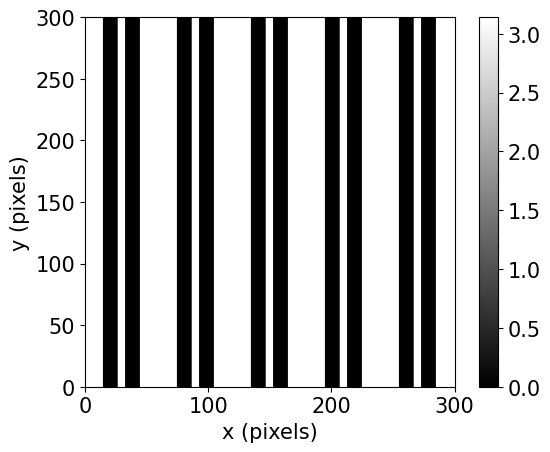

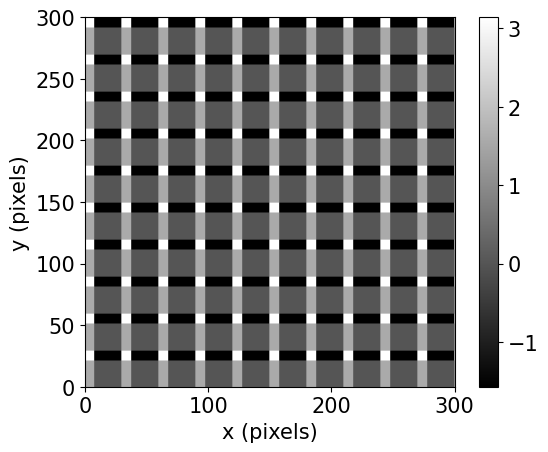

(0.0, 300.0)

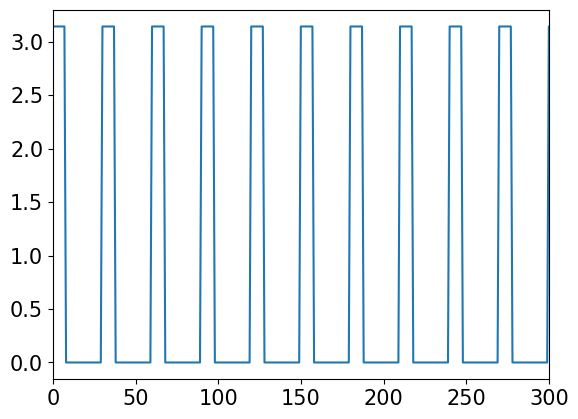

In [147]:
#@title Grating Profile
plt.rcParams.update({'font.size': 15})
# print("Eff=",eff)
# g = grating_1D(0.5)
g2 = grating_2D(0.1137488)
g3 = grating3(30,200)
g4 = grating4(60,100)
g9 = grating3x3(30,200)
g3x3H = multi3x3(30,200)
# gm = multigrating(60,100)
# gm2 = multilevel2D(gm.cpu().detach().numpy())
# gs = sinu_grating(120,50,np.pi,1/2,periods=1)
g16 = grating4x4(60,100)
# gt = Tgrating(50,120,2,1)
#gcpu =g.cpu().detach().numpy()
# gcpu =g.cpu().detach().numpy()
g2cpu = g2.cpu().detach().numpy()
g3cpu = g3.cpu().detach().numpy()
g4cpu =g4.cpu().detach().numpy()
g9cpu =g9.cpu().detach().numpy()
g3x3Hcpu =g3x3H.cpu().detach().numpy()
# gmcpu = gm.cpu().detach().numpy()
# gm2cpu = gm2.cpu().detach().numpy()
# gscpu = gs.cpu().detach().numpy()
g16cpu = g16.cpu().detach().numpy()
# gtcpu = gt.cpu().detach().numpy()
plt.imshow(np.angle(g4cpu), cmap='gray')
plt.xlim(0,300)
plt.ylim(0,300)
plt.xlabel("x (pixels)")
plt.ylabel("y (pixels)")
plt.colorbar()
plt.show()
plt.imshow(np.angle(g3x3Hcpu), cmap='gray')
plt.xlim(0,300)
plt.ylim(0,300)
plt.xlabel("x (pixels)")
plt.ylabel("y (pixels)")
plt.colorbar()
plt.show()
# plt.imshow(np.abs(gcpu), cmap='gray')
# plt.colorbar()
# plt.show()
# plt.imshow(np.abs(g4cpu), cmap='gray')
# plt.colorbar()
plt.plot(np.angle(g3cpu[3000]))
plt.xlim(0,300)


In [ ]:
#@title 1x4 beam  combining
#Polarization as phase change
ax1 = 0.1137488 #0.073339
ax2 = 3*ax1 #0.220015
n = 1
m = 1
l = 1
print ("Estimated simulation time =", 0.25*m*n,"minutes")
axr = ax1*np.pi/180
ds1= np.tan(axr)*3400
k = 2*np.pi/lambda_
#w01, w02 = 1, 1
# rh1 = T.sqrt((X+(ds1))**2+(Y-(ds1*0))**2)
# th1 = T.arctan2(Y-(ds1*0),X+(ds1))
# rh2 = T.sqrt((X-(ds1))**2+(Y-(ds1*0))**2)
# th2 = T.arctan2(Y-(ds1*0),X-(ds1))
TPstd = 0.0
dthp = 0.00
dthaz = 0
effct = []
imm = []
ang1 = 0 #2.13
azh = 0
Rc1 = 1e25
Rc2 = 1e25
dpi = 1.2
pd = 0.0
pp = 1
#dp1 = 0
#dp11 = 1
#dp1 = 0
w01 = 2
maxp = 1
#delta1 = 0#np.pi/4
dph = 0 #np.pi/20
dpol = 0
for j in range (m):
  effm = []
  im = []
  ang2 = -0.65# 1.925#1.75
  #dp2 = 0
  w02 = 2
  #dp12 = 1
  #delta2 = 0

  print("Updated variable = ", ang1, ang2)
  for idx in tqdm(range(n),ncols=120):

    dlph = np.random.normal(0, dph, 2)
    pold = np.random.normal(0,dpol,2)
    poldp = np.clip(pold,-dpol/2,dpol/2)
    dpm = np.clip(dlph, -0.99, 1.5 )
    dp11 = dp12 = dpi +dpm[0]
    dp13 = dp14 = pp * dpi #dpi +dpm[1]
    dp1 = 1#dpi + poldp[0]
    dp2 = 1#dpi + poldp[1]
    #print (dpi,poldp,dp1,dp2)
    pth1 = np.arccos(np.sqrt(dp1))
    pth2 = np.arccos(np.sqrt(dp2))
    #dp11 = 1-dp12
    #dp12 = 0 #- dp11
    #dp21, dp22 = 1- dp11, 1- dp12
    #pth1 = 45
    #pth2 = 45
    pdm = np.random.normal(0, pd, 2)
    TPA1 = 1 #TPA(rh1,th1,TPstd)
    TPA2 = 1 #TPA(rh2,th2,TPstd)
    u0 = beam_generation1D(Rc1,w01,dp11,0,0,dthp,dthaz,0,0) * TPA1 * np.exp(1j*pdm[0])
    u1 = beam_generation1D(Rc1,w01,dp11,ax1,azh,dthp,dthaz,-1,0) * TPA1 * np.exp(1j*pdm[0])
    u2 = beam_generation1D(Rc2,w02,dp12,ax1,180+azh,dthp,dthaz,1,0) * TPA2 * np.exp(1j*pdm[1])
    u3 = beam_generation1D(Rc2,w02,dp13,ax2,azh,dthp,dthaz,-1,0) * TPA2 * np.exp(1j*pdm[1])
    u4 = beam_generation1D(Rc2,w02,dp14,ax2,180+azh,dthp,dthaz,1,0) * TPA2 * np.exp(1j*pdm[1])

    ux1 = np.cos(pth1) * u1  #* np.exp(1j*np.pi*0)
    uy1 = np.sin(pth1) * u1 * np.exp(1j*dlph[0])
    i1 = T.abs(u1)**2

    ix1 = T.abs(ux1)**2
    iy1 = T.abs(uy1)**2


    ux2 = np.cos(pth2) * u2 #* np.exp(1j*np.pi)
    uy2 = np.sin(pth2) * u2 * np.exp(1j*dlph[1])

    ux3 = np.cos(pth1) * u3  #* np.exp(1j*np.pi*0)
    uy3 = np.sin(pth1) * u3 * np.exp(1j*dlph[0])

    ux4 = np.cos(pth1) * u4  #* np.exp(1j*np.pi*0)
    uy4 = np.sin(pth1) * u4 * np.exp(1j*dlph[0])



    #Tph = T.angle(u1 + u2)
    #Tphcpu =Tph.cpu().detach().numpy()
    #uin = ux1 + ux2 + uy1 + uy2
    uin = u0 #u1 + u2 #+ u3 + u4#  + u3*np.exp(1j*ang2) + u4* np.exp(1j*ang2) #(u2 * np.exp(1j*angr))  #+ (u1 * np.exp(1j*np.pi/4)) + u2
    i = T.abs(uin)**2 # T.abs(u1)**2 + T.abs(u2)**2  +T.abs(u3)**2 + T.abs(u4)**2
    ix = T.abs(ux1+ux2)**2
    iy = T.abs(uy1+uy2)**2
    uout1 = rs_propagation(uin,400)
    uout1cpu = uout1.cpu().detach().numpy()
    iout1 = T.abs(uout1)**2
    icpu = i.cpu().detach().numpy()
    iout1cpu = iout1.cpu().detach().numpy()
    gm = multigrating(60,100)
    # gt = Tgrating(50,120,maxp,1)
    uout2 = uout1 * gm

    uout = rs_propagation(uout2,3400)
    Tph = T.angle(uout)
    Tphcpu =Tph.cpu().detach().numpy()

    iout = T.abs(uout)**2
    ioutcpu = iout.cpu().detach().numpy()
    # plt.imshow(icpu)
    # plt.show()
    # plt.imshow(iout1cpu)
    # plt.show()
    # plt.imshow(ioutcpu)

    # maxin = np.where(icpu == np.max(icpu))
    # maxout1 = np.where(iout1cpu == np.max(iout1cpu))
    # print(maxin, maxout1)

    ps = 1
    RoC = 3.375 #6.75
    PIBc0 = PIB(ioutcpu,RoC,0,0)
    PIBc1r = PIB(ioutcpu,RoC,-6.75*ps,0)
    PIBc1l = PIB(ioutcpu,RoC, 6.75*ps,0)
    # PIBc2r = PIB(ioutcpu,RoC, -12.8*ps,0)
    # PIBc2l = PIB(ioutcpu,RoC, 12.6*ps,0)
    PIBc3r = PIB(ioutcpu,RoC, -20.25*ps,0)
    PIBc3l = PIB(ioutcpu,RoC, 20.25*ps,0)
    # PIBc4r = PIB(ioutcpu,RoC, -25.6*ps,0)
    # PIBc4l = PIB(ioutcpu,RoC, 25.6*ps,0)
    PIBt = PIBc1r + PIBc1l + PIBc3r + PIBc3l
    Pin = np.sum(icpu)
    Pout = np.sum(ioutcpu)
    eff = 100*(PIBc0/Pout)
    print(Pin,Pout)
    effm.append(eff)
    #ang2 = ang2 + 0.05
    #pp = pp + 0.01
    # plt.imshow(iout1cpu)
    # plt.show()
    maxp = maxp + 0.1

    '''
    ixcpu = ix.cpu().detach().numpy()
    iycpu = iy.cpu().detach().numpy()
    g = grating_1D(0.5)
    #uin1 = ux1+(ux2*np.exp(1j*np.pi)) + uy1+(uy2 * np.exp(1j*np.pi))
    #uout1 = rs_propagation(uin1,600)
    #uoutg = uout1 * g
    #uout2 = rs_propagation(uoutg,600)
    #ioutb = T.abs(uout2)**2
    #ioutbcpu = ioutb.cpu().detach().numpy()
    uout1x = rs_propagation((ux1)+(ux2*np.exp(1j*np.pi)),500)
    #uout1x = rs_propagation((ux1+ux2),600)

    g4 = grating4(50,120)

    uout1xg = uout1x * g4
    uout1y = rs_propagation(uy1+(uy2 * np.exp(-1j*np.pi)),500)
    #uout1y = rs_propagation((uy1+uy2),600)
    iout1 = T.abs(uout1x)**2 + T.abs(uout1y)**2
    iout1cpu = iout1.cpu().detach().numpy()

    #imax = np.max(iout1cpu)
    #im.append(imax)
    uout1yg = uout1y * g4
    uout2x = rs_propagation(uout1xg,5000)
    uout2y = rs_propagation(uout1yg,5000)

    iout = T.abs(uout2x)**2 + T.abs(uout2y)**2
    ioutcpu = iout.cpu().detach().numpy()

    #plot_savefig(ioutcpu,idx)



    #imax = np.max(ioutcpu)
    #im.append(imax)
    ps = 1
    RoC = 3.2
    PIBc0 = PIB(ioutcpu,RoC,0,0)
    PIBc1r = PIB(ioutcpu,RoC,-6.4*ps,0)
    PIBc1l = PIB(ioutcpu,RoC, 6.4*ps,0)
    PIBc2r = PIB(ioutcpu,RoC, -12.8*ps,0)
    PIBc2l = PIB(ioutcpu,RoC, 12.6*ps,0)
    PIBc3r = PIB(ioutcpu,RoC, -19.2*ps,0)
    PIBc3l = PIB(ioutcpu,RoC, 19.2*ps,0)
    PIBc4r = PIB(ioutcpu,RoC, -25.6*ps,0)
    PIBc4l = PIB(ioutcpu,RoC, 25.6*ps,0)
    PIBt = PIBc1r + PIBc1l + PIBc3r + PIBc3l

    Pin = np.sum(icpu)
    #print(Pin,Pout)
    Pout = np.sum(ioutcpu)
    eff = 100*(PIBc0/Pin)

    effm.append(eff)

    #dthp = dthp + 0.0005
    #dthaz = dthaz + 0.1
    #w02 = w02 + 2/10
    #TPstd = TPstd + 0.005
    #delta2 = delta2 + np.pi/11
    #dp2 = dp2 + 0.04999999999
    #dr = dr + 0.1
    #dp12 = dp12 + 0.05
    #w02 = w02 + 0.025
    #Rc2 = Rc2-100
    #pd = pd + np.pi/20
    '''
  print(effm)
  effct.append(effm)
  #imm.append(im)
  #pd = pd + 0.1
  #TPstd = TPstd + 0.01
  #ang1 = ang1 + 0.01

  #print(dpi)
  #dpi = dpi+ 0.0499999999
  #w01 = w01 + 0.1
  #dph = dph + 0.1
  #Pstd = TPstd + 2/15
  #imm.append(im)
  #delta1 = delta1 + np.pi/11
  #dpi = dpi + 0.09999999999
print(effct)

In [ ]:
plt.rcParams.update({'font.size': 15})
def multi2x2(grating_size, stack_factor):
    # Parameters
    # grating_size: Size of the grating in one dimension (e.g., 64)
    # stack_factor: Factor to stack the grating in one direction (e.g., 120)

    #total_size = 1000
    transition_point_1 = 0.5
    transition_point_2 = 1
    # transition_point_3 = 0.55
    # transition_point_4 = 0.75

    # Generate the binary phase grating in one orientation
    single_grating1 = np.ones((grating_size), dtype=complex)
    single_grating2 = np.ones((grating_size), dtype=complex)

    transition_point_1_index = int(transition_point_1 * grating_size)
    transition_point_2_index = int(transition_point_2 * grating_size)
    

    single_grating1[:transition_point_1_index] = np.exp(1j*np.pi/2)
    single_grating1[transition_point_1_index:transition_point_2_index] = 1
    single_grating1[transition_point_2_index:] = np.exp(1j*np.pi/2)

    single_grating2[:transition_point_1_index] = np.exp(1j*np.pi)
    single_grating2[transition_point_1_index:transition_point_2_index] = np.exp(1j*3*np.pi/2)
    single_grating2[transition_point_2_index:] = np.exp(1j*np.pi)
    p1 = int(grating_size/2)
    X1 = single_grating1
    Y1 = np.tile(X1, (p1,1))
    X2 = single_grating2
    Y2 = np.tile(X2, (p1,1))
    Ucell = np.vstack((Y1, Y2))
    X_stack = np.tile(Ucell, stack_factor)
    Y_stack = np.tile(X_stack, (stack_factor, 1))
    # Generate the rotated version of the grating (90 degrees rotation)
    
    g16 = T.tensor(Y_stack).to(device)
    return g16

g = multi2x2(60,100)
gcpu = g.cpu().detach().numpy()
plt.imshow(np.angle(gcpu), cmap='gray')
plt.xlim(0,300)
plt.ylim(0,300)
plt.xlabel("x (pixels)")
plt.ylabel("y (pixels)")
plt.colorbar()
plt.show()

In [162]:
#@title all in one beam combining
#Polarization as phase change
import statistics
ax1 = 0.095263#0.1137488 #0.095263#0.1137488 #0.095263#
ax2 = 3*ax1 #0.220015
ax3 = 0.1908954
axd1 = np.arctan(np.sqrt(2)*np.tan(ax1))
axd2 = np.arctan(np.sqrt(2)*np.tan(ax2))
axd3 = np.arctan(np.tan(ax3))
n = 100
m = 10
l = 1
print ("Estimated simulation time =", 0.09*m*n,"minutes")
axr = ax1*np.pi/180
ds1= np.tan(axr)*3400
k = 2*np.pi/lambda_
#w01, w02 = 1, 1
# rh1 = T.sqrt((X+(ds1))**2+(Y-(ds1*0))**2)
# th1 = T.arctan2(Y-(ds1*0),X+(ds1))
# rh2 = T.sqrt((X-(ds1))**2+(Y-(ds1*0))**2)
# th2 = T.arctan2(Y-(ds1*0),X-(ds1))
TPstd = 0.0
dthp = 0.00
dthaz = 0
effct = []
effct1 = []
imm = []
mean = []
stdev = []
#ang1 = -2# 2.13
azh = 0
Rc1 = 1e25
Rc2 = 1e25

dpi = 1
dthp = 0
w0 = 2
pd = 0.0
dpd = 0.0
dpw = 0.05
dplp = 0.0
dth = 0.000
ang = (180/np.pi) * np.arctan(1/3)
ang11 = 0
ang12 = np.pi/2
ang13 = np.pi
ang14 = 3*np.pi/2
# ang00 = 0
# ang11 = np.pi/4
# ang12 = 3*np.pi/4
# ang13 = np.pi
# ang14 = -np.pi/2
# ang15 = np.pi/2
#ang2 = 3.1 ##3.06
#dp1 = 0
#dp11 = 1
#dp1 = 0
#w01 = 1
#delta1 = 0#np.pi/4
dph = 0 #np.pi/20
dpol = 0
dpd1 = 1
ls = -5.35
phs1 = np.pi/2
dpm = 0,0,0,0, 0,0,0,0, 0,0,0,0, 0,0,0,0
dthp= 0,0,0,0, 0,0,0,0, 0,0,0,0, 0,0,0,0
pdm = 0,0,0,0, 0,0,0,0, 0,0,0,0, 0,0,0,0
#dwm = 0,0,0,0, 0,0,0,0, 0,0,0,0, 0,0,0,0
dp11 = dp12 = dp13 = dp14 = dp15 = dp16 = dp17 = dp18 = dp19 = dp110 = dp111 = dp112 = dp113 = dp114 = dp115 = dp116 = 1
#w01, w02, w03, w04, w05, w06, w07, w08, w09, w10, w11, w12, w13, w14, w15, w16 = 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2
w01, w02, w03, w04, w05, w06, w07, w08, w09, w10, w11, w12, w13, w14, w15, w16 = 1,1,1,1, 1,1,1,1, 1,1,1,1, 1,1,1,1


#phs2 = 1.4
#ang3 = -1.75
# g2 = multigrating(60,100)
# g2x2 = multilevel2D(g2.cpu().detach().numpy())
# g3 = grating3(30,200)
# g3x3 = grating3x3(30,200)
# g3x3H = multi3x3(30,200)
g2x2H = multi2x2(30,200)
# #g4 = grating4(60,100)
# g4x4 = grating4x4(60,100)
# gs = sinu_grating(120,50,np.pi,a,periods=1)

for j in range (m):
  effm = []
  effm1 = []
  #im = []
  #ang14 = -np.pi
  # ang3 = 1.68
  # ang2 = -2.31 #ang3 - np.pi#-0.325
  #dp2 = 0
  #w02 = 1
  #dp12 = 1
  #delta2 = 0
  # dpd2 = 1
  # phs2 = 1.4

  print("Updated variable = ", dpw)
  for idx in tqdm(range(n),ncols=120):
    #ang2 = ang3 - np.pi
    #print("Updated variable = ", ang2, ang3)
    dlph = np.random.normal(0, dpw, 4)
    #pold = np.random.normal(0,dpol,2)
    #poldp = np.clip(pold,-dpol/2,dpol/2)
    dwm = np.clip(dlph, -0.99, 1)
    
    # pdm = 0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
    #dp11, dp12, dp13, dp14, dp15, dp16, dp17, dp18, dp19, dp110, dp111, dp112, dp113, dp114, dp115, dp116 = dp+dpm[0], dp+dpm[1], dp+dpm[2], dp+dpm[3], dp+dpm[4], dp+dpm[5], dp+dpm[6], dp+dpm[7], dp+dpm[8], dp+dpm[9], dp+dpm[10], dp+dpm[11],dp+dpm[12], dp+dpm[13], dp+dpm[14], dp+dpm[15]
    #w01, w02, w03, w04, w05, w06, w07, w08, w09, w10, w11, w12, w13, w14, w15, w16 = w0+dpm[0], w0+dpm[1], w0+dpm[2], w0+dpm[3], w0+dpm[4], w0+dpm[5], w0+dpm[6], w0+dpm[7], w0+dpm[8], w0+dpm[9], w0+dpm[10], w0+dpm[11], w0+dpm[12], w0+dpm[13], w0+dpm[14], w0+dpm[15]

    #dp13= dp14 = pp * dpi#dpi +dpm[1]
    #dp1 = 1#dpi + poldp[0]
    #dp2 = 1#dpi + poldp[1]
    #print (dpi,poldp,dp1,dp2)
    # pth1 = np.arccos(np.sqrt(dp1))
    # pth2 = np.arccos(np.sqrt(dp2))
    #dp11 = 1-dp12
    #dp12 = 0 #- dp11
    #dp21, dp22 = 1- dp11, 1- dp12
    #pth1 = 45
    #pth2 = 45
    #pdm = np.random.normal(0, pd, 2)
    TPA1 = 1 #TPA(rh1,th1,TPstd)
    TPA2 = 1 #TPA(rh2,th2,TPstd)
    #u0 = beam_generation2D(Rc1,w0/2,dp11,0,0,dthp[0],dthaz,0,0,0) * TPA1 * np.exp(1j*pdm[0])

    # u1 = beam_generation1D(Rc1,w01+dwm[0],dp11+dpm[0],ax1,0,dthp[0],dthaz,-1,0) * TPA1 * np.exp(1j*pdm[0])
    # u2 = beam_generation1D(Rc2,w02+dwm[1],dp12+dpm[1],ax1,180,dthp[1],dthaz,1,0) * TPA2 * np.exp(1j*pdm[1])

    u1 = beam_generation2D(Rc1,w01+dwm[0],dp11+dpm[0],2*ax1,0,dthp[0],dthaz,-1,0,np.sqrt(2)*axd1) * TPA1 * np.exp(1j*pdm[0])
    u2 = beam_generation2D(Rc2,w02+dwm[1],dp12+dpm[1],2*ax1,90,dthp[1],dthaz,0,-1,np.sqrt(2)*axd1) * TPA2 * np.exp(1j*pdm[1])
    u3 = beam_generation2D(Rc2,w03+dwm[2],dp13+dpm[2],2*ax1,180,dthp[2],dthaz,1,0,np.sqrt(2)*axd1) * TPA2 * np.exp(1j*pdm[2])
    u4 = beam_generation2D(Rc2,w04+dwm[3],dp14+dpm[3],2*ax1,270,dthp[3],dthaz,0,1,np.sqrt(2)*axd1) * TPA2 * np.exp(1j*pdm[3])

    # u0 = beam_generation2D(Rc1,w01+dwm[0],dp11+dpm[0],0,0,dthp[0],dthaz,0,0,0) * TPA1 * np.exp(1j*pdm[0])
    # u1 = beam_generation2D(Rc2,w02+dwm[1],dp12+dpm[1],ax3,0,dthp[1],dthaz,-1,0,axd3) * TPA2 * np.exp(1j*pdm[1])
    # u2 = beam_generation2D(Rc2,w03+dwm[2],dp13+dpm[2],ax3,90,dthp[2],dthaz,0,-1,axd3) * TPA2 * np.exp(1j*pdm[2])
    # u3 = beam_generation2D(Rc2,w04+dwm[3],dp14+dpm[3],ax3,180,dthp[3],dthaz,1,0,axd3) * TPA2 * np.exp(1j*pdm[3])
    # u4 = beam_generation2D(Rc1,w05+dwm[4],dp15+dpm[4],ax3,270,dthp[4],dthaz,0,1,axd3) * TPA1 * np.exp(1j*pdm[4])
    # u5 = beam_generation2D(Rc2,w06+dwm[5],dp16+dpm[5],ax3,45,dthp[5],dthaz,-1,-1,np.sqrt(2)*axd3) * TPA2 * np.exp(1j*pdm[5])
    # u6 = beam_generation2D(Rc2,w07+dwm[6],dp17+dpm[6],ax3,225,dthp[6],dthaz,1,1,np.sqrt(2)*axd3) * TPA2 * np.exp(1j*pdm[6])
    # u7 = beam_generation2D(Rc2,w08+dwm[7],dp18+dpm[7],ax3,135,dthp[7],dthaz,1,-1,np.sqrt(2)*axd3) * TPA2 * np.exp(1j*pdm[7])
    # u8 = beam_generation2D(Rc1,w09+dwm[8],dp19+dpm[8],ax3,315,dthp[8],dthaz,-1,1,np.sqrt(2)*axd3) * TPA1 * np.exp(1j*pdm[8])
   
    
    # u1 = beam_generation2D(Rc1,w01+dwm[0],dp11+dpm[0],ax1,45,dthp[0],dthaz,-1,-1,axd1) * TPA1 * np.exp(1j*pdm[0])
    # u2 = beam_generation2D(Rc2,w02+dwm[1],dp12+dpm[1],ax1,225,dthp[1],dthaz,1,1,axd1) * TPA2 * np.exp(1j*pdm[1])
    # u3 = beam_generation2D(Rc2,w03+dwm[2],dp13+dpm[2],ax1,315,dthp[2],dthaz,-1,1,axd1) * TPA2 * np.exp(1j*pdm[2])
    # u4 = beam_generation2D(Rc2,w04+dwm[3],dp14+dpm[3],ax1,135,dthp[3],dthaz,1,-1,axd1) * TPA2 * np.exp(1j*pdm[3])
    # u5 = beam_generation2D(Rc1,w05+dwm[4],dp15+dpm[4],ax1,90-ang,dthp[4],dthaz,-1,-3,np.sqrt(5)*axd1) * TPA1 * np.exp(1j*pdm[4])
    # u6 = beam_generation2D(Rc2,w06+dwm[5],dp16+dpm[5],ax1,270-ang,dthp[5],dthaz,1,3,np.sqrt(5)*axd1) * TPA2 * np.exp(1j*pdm[5])
    # u7 = beam_generation2D(Rc2,w07+dwm[6],dp17+dpm[6],ax1,270+ang,dthp[6],dthaz,-1,3,np.sqrt(5)*axd1) * TPA2 * np.exp(1j*pdm[6])
    # u8 = beam_generation2D(Rc2,w08+dwm[7],dp18+dpm[7],ax1,90+ang,dthp[7],dthaz,1,-3,np.sqrt(5)*axd1) * TPA2 * np.exp(1j*pdm[7])
    # u9 = beam_generation2D(Rc1,w09+dwm[8],dp19+dpm[8],ax1,ang,dthp[8],dthaz,-3,-1,np.sqrt(5)*axd1) * TPA1 * np.exp(1j*pdm[8])
    # u10 = beam_generation2D(Rc2,w10+dwm[9],dp110+dpm[9],ax1,180+ang,dthp[9],dthaz,3,1,np.sqrt(5)*axd1) * TPA2 * np.exp(1j*pdm[9])
    # u11 = beam_generation2D(Rc2,w11+dwm[10],dp111+dpm[10],ax1,360-ang,dthp[10],dthaz,-3,1,np.sqrt(5)*axd1) * TPA2 * np.exp(1j*pdm[10])
    # u12 = beam_generation2D(Rc2,w12+dwm[11],dp112+dpm[11],ax1,180-ang,dthp[11],dthaz,3,-1,np.sqrt(5)*axd1) * TPA2 * np.exp(1j*pdm[11])
    # u13 = beam_generation2D(Rc1,w13+dwm[12],dp113+dpm[12],ax2,45,dthp[12],dthaz,-1,-1,3*axd1) * TPA1 * np.exp(1j*pdm[12])
    # u14 = beam_generation2D(Rc2,w14+dwm[13],dp114+dpm[13],ax2,225,dthp[13],dthaz,1,1,3*axd1) * TPA2 * np.exp(1j*pdm[13])
    # u15 = beam_generation2D(Rc2,w15+dwm[14],dp115+dpm[14],ax2,315,dthp[14],dthaz,-1,1,3*axd1) * TPA2 * np.exp(1j*pdm[14])
    # u16 = beam_generation2D(Rc2,w16+dwm[15],dp116+dpm[15],ax2,135,dthp[15],dthaz,1,-1,3*axd1) * TPA2 * np.exp(1j*pdm[15])

    # ux1 = np.cos(pth1) * u1  #* np.exp(1j*np.pi*0)
    # uy1 = np.sin(pth1) * u1 * np.exp(1j*dlph[0])
    # i1 = T.abs(u1)**2

    # ix1 = T.abs(ux1)**2
    # iy1 = T.abs(uy1)**2


    # ux2 = np.cos(pth2) * u2 #* np.exp(1j*np.pi)
    # uy2 = np.sin(pth2) * u2 * np.exp(1j*dlph[1])

    # ux3 = np.cos(pth1) * u3  #* np.exp(1j*np.pi*0)
    # uy3 = np.sin(pth1) * u3 * np.exp(1j*dlph[0])

    # ux4 = np.cos(pth1) * u4  #* np.exp(1j*np.pi*0)
    # uy4 = np.sin(pth1) * u4 * np.exp(1j*dlph[0])



    #Tph = T.angle(u1 + u2)
    #Tphcpu =Tph.cpu().detach().numpy()
    #uin = u0
    uin = u1 * np.exp(1j*ang11) + u2 * np.exp(1j*ang12) + u3 * np.exp(1j*ang13) + u4 * np.exp(1j*ang14)
    #uin =  u0 + u1 + u2 + u3 + u4 + u5 + u6 + u7 + u8 #+ u9 + u10 + u11 + u12 + u13 + u14 + u15 + u16
    #uin = u0 * np.exp(1j*ang00)+ u1 * np.exp(1j*ang11) + u3 * np.exp(1j*ang12) + u2 * np.exp(1j*ang12) + u4 * np.exp(1j*ang11) + u5 * np.exp(1j*ang13) + u6 * np.exp(1j*ang13) + u7 * np.exp(1j*ang14) + u8 * np.exp(1j*ang15) #+ u9 * np.exp(1j*ang2) + u10 * np.exp(1j*ang2) + u11 * np.exp(1j*ang2) + u12 * np.exp(1j*ang2) + u13 * np.exp(1j*ang3) + u14 * np.exp(1j*ang3) + u15 * np.exp(1j*ang3) + u16 * np.exp(1j*ang3)
    #uin = u1 + u2  + u3*np.exp(1j*ang1) + u4* np.exp(1j*ang2) #(u2 * np.exp(1j*angr))  #+ (u1 * np.exp(1j*np.pi/4)) + u2
    i =  T.abs(uin)**2 #T.abs(u1)**2 + T.abs(u2)**2 + T.abs(u3)**2  +T.abs(u4)**2 + T.abs(u5)**2 +  T.abs(u6)**2 +  T.abs(u7)**2 +  T.abs(u8)**2 + T.abs(u9)**2 + T.abs(u10)**2 + T.abs(u11)**2 + T.abs(u12)**2 + T.abs(u13)**2 + T.abs(u14)**2 + T.abs(u15)**2 + T.abs(u16)**2
    # ix = T.abs(ux1+ux2)**2
    # iy = T.abs(uy1+uy2)**2
    #del u1,u2,u3,u4,u5,u6,u7,u8,u9,u10,u11,u12,u13,u14,u15,u16
    uout1 = rs_propagation(uin,3400)
    #uout1cpu = uout1.cpu().detach().numpy()
    iout1 = T.abs(uout1)**2
    icpu = i.cpu().detach().numpy()
    iout1cpu = iout1.cpu().detach().numpy()
    # gs1 = sinu_grating(15,400,np.pi,1,periods=1)
    # gs2 = sinu_grating(15,400,np.pi,-1,periods=1)

    uout2 = uout1 * g2x2H
    #iout2 = T.abs(uout2)**2
    #iout2cpu = iout2.cpu().detach().numpy()
    # uout3 = rs_propagation(uout2,ls)
    # uout4 = uout3* gm


    uout = rs_propagation(uout2,3400)
    
    iout = T.abs(uout)**2
    ioutcpu = iout.cpu().detach().numpy()
    # Tph = T.angle(uout2)
    # Tphcpu =Tph.cpu().detach().numpy()
    # plt.imshow(ioutcpu)
    # plt.show()
    #del uin, uout2, uout

    # plt.imshow(icpu)
    # plt.show()
    # plt.imshow(iout1cpu)
    # plt.show()
    # plt.imshow(ioutcpu)

    # maxin = np.where(icpu == np.max(icpu))
    # maxout1 = np.where(iout1cpu == np.max(iout1cpu))
    # print(maxin, maxout1)

    #ps = 1
    RoC = 5.65#3.3#6.75#/2
    # R02 = 5.653
    R04 = 11.29#6.773
    PIBc00 = PIB(ioutcpu,RoC,0,0)
    # PIBc01 = PIB(ioutcpu,RoC,-R04,0)
    # PIBc11 = PIB(ioutcpu,RoC,-R04,-R04)
    # PIBc03 = PIB(ioutcpu,RoC,3*-R04,0)

    Pin = np.sum(icpu)
    Pout = np.sum(ioutcpu)
    eff = 100*((PIBc00)/Pin)
    #eff1 = 100*(PIBc00/Pout)
    #eff = 100*((PIBc11*4 + PIBc21*8 + PIBc31*4)/Pin)
    #print(Pout/Pin, eff, eff1)
    effm.append(eff)
    #effm1.append(eff1)
    #ang2 = ang2 + 0.02
    #ang3 = ang3 + 0.01
    #pp = pp + 0.01
    #dpd2 = dpd2 + 0.01
    #ls = ls + 0.25
    #print(2*eff)
    #phs2 = phs2 + 0.1
    #a = a - 0.05
    #ang12 = ang12 + np.pi/5
    #ang14 = ang14 + np.pi/10
 
  #print(effm1)
  print(effm)
  Mean = statistics.mean(effm)
  Stdev = statistics.stdev(effm)
  print("Mean = ", Mean, "stdev = ",Stdev)
  effct.append(effm)
  #effct1.append(effm1)
  mean.append(Mean)
  stdev.append(Stdev)
   
  #imm.append(im)
  #pd = pd + 0.1
  #TPstd = TPstd + 0.01
  #ang3 = ang2 + 0.5
  #dpd1 = dpd1 + 0.01
  #dpd = dpd + 0.05
  dpw = dpw + 0.05
  #dplp = dplp + 0.05
  #dth = dth + 0.0001
  #phs1 = phs1 + 0.1
  #ang13 = ang13 + np.pi/4
  #print(dpi)
  #dpi = dpi+ 0.0499999999
  #w01 = w01 + 0.1
  #dph = dph + 0.1
  #Pstd = TPstd + 2/15
  #imm.append(im)
  #delta1 = delta1 + np.pi/11
  #dpi = dpi + 0.09999999999
print("PIB/Pout = ",effct1)
print("PIB/Pin= ",effct)
print("Maximum efficiency = ",np.max(effct))
print("Mean = " ,mean)
print("stdev = ",stdev)

Estimated simulation time = 89.99999999999999 minutes
Updated variable =  0.05


100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [09:09<00:00,  5.49s/it]


[81.12459510587165, 81.04329116130728, 80.83393602358255, 81.26660791608143, 81.1884162806632, 81.24383256157874, 81.20845192770307, 81.1121554443547, 81.198858494756, 81.28290363310047, 81.01706023915996, 81.11191642115571, 81.16261440484627, 81.11839376442789, 81.28090307885151, 81.21618197160355, 81.21531600020421, 81.05702049412695, 81.13107810530117, 80.6984802980717, 81.2498128694223, 81.22260910227517, 80.93705746781258, 81.27335189521983, 81.25070893255935, 81.26583250540416, 81.2625791956508, 81.19529057256405, 81.28272296249426, 81.05675496535854, 81.20658812658043, 81.10963265529062, 81.20193527865547, 81.2129302881906, 81.28058220617623, 81.1656660975197, 81.24604966066697, 81.14435227093388, 81.25174760053497, 80.9826845604593, 81.20328524791502, 81.25643216702832, 81.21053351698035, 81.20469040038671, 81.258750291687, 81.13647004320886, 81.14161403866783, 81.06420405576318, 81.25096956414052, 81.19550131949566, 80.88353269386911, 81.26510719510401, 81.1171992923686, 81.21

100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [09:13<00:00,  5.54s/it]


[80.74440261106913, 80.59436368572375, 81.20817364877104, 81.2369192233179, 80.23701995405081, 81.19234692135245, 80.87378072470509, 81.08978634668148, 81.24234188333305, 78.61137451062861, 80.94930726843108, 80.94554257256841, 80.99641459545333, 81.1639304739464, 80.98425913493948, 81.18330473060578, 80.26175170369184, 80.96706677158231, 81.11090218243366, 80.68640610848007, 79.9664863648682, 80.3352326130594, 80.67927865248271, 81.07517789814298, 80.97407208346355, 80.61979078216936, 80.38794407384673, 80.84253975949237, 80.59523918400177, 80.86363227553005, 80.63488917083406, 81.191401964594, 80.80212125963793, 80.74889682383089, 80.56823379528495, 78.358709074192, 81.17098213532483, 81.25999930781134, 81.17363978380907, 80.5075385967071, 80.95717150236923, 80.76978997475678, 81.10968623534222, 80.83770850705956, 80.90260914407177, 80.8695206002382, 81.22787871892115, 80.7875819019039, 80.67164782332007, 80.98003837590562, 80.80710423531696, 80.39247278316574, 80.60987900198175, 79.

100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [09:12<00:00,  5.53s/it]


[80.7286354019253, 80.98545697046993, 80.52193112884149, 78.59103353009539, 80.22251189551342, 81.20984436740817, 79.30178704579059, 81.15618056956161, 78.78236375162754, 80.2956557373382, 77.99879992248125, 79.2247139203312, 80.90641244786232, 80.60109499451546, 80.54565884763328, 79.93744229898219, 75.80039079985129, 78.08658491976287, 80.43898884458643, 79.40917111574647, 79.13036000952377, 78.93940861794488, 80.44396058570089, 80.3208753714854, 77.77269845308187, 77.8482225760374, 80.50285021879714, 81.25605732073836, 80.2845330591227, 78.62183332206982, 80.81069228848204, 79.21222341430408, 80.57468290252048, 78.32182638237771, 81.13405900040384, 81.02987262078926, 78.58465443347188, 80.4677803809424, 79.9182533982537, 80.58879644995123, 80.48938252847829, 78.63867695697996, 80.29742034055535, 80.54708246255593, 78.1921458459853, 79.10581206181936, 75.93460583073845, 80.16851752756891, 79.87468580270249, 80.05228839811753, 81.08438732428486, 80.90614590465597, 80.60721977791387, 8

100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [09:14<00:00,  5.54s/it]


[80.25816520059635, 80.52347333734669, 79.10043671642455, 80.49931767988589, 80.29799224959118, 80.80836864196607, 79.34518227132754, 78.94533874928639, 77.86988932714323, 74.66205192173578, 73.03139449092536, 80.4142509134565, 78.68168234696591, 79.84169387192804, 76.96580381919964, 79.04707502913531, 79.5091736334843, 78.25815260842676, 77.68931613413805, 76.74663577909135, 80.7821121600138, 78.08804306723648, 77.71427617042119, 79.78507074443738, 78.78159099314533, 80.02635937611112, 79.44297567349548, 79.81238079332874, 78.62626268786033, 77.63086844197176, 78.91322863694323, 80.63950220093183, 72.48700129878813, 79.79660700620357, 75.55562190523757, 73.79546014407643, 79.18951142311185, 77.5313364551535, 79.12145804980766, 80.79925175842354, 81.09198457285272, 79.65878115421336, 80.39224451595624, 80.68544780992363, 73.11126578524718, 80.66143972135833, 80.45841488350504, 80.63384480069111, 80.59072898024797, 78.93280920873762, 79.90725150644434, 79.6520204311843, 80.6049437378736

100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [09:16<00:00,  5.57s/it]


[81.05300486762292, 79.15012558581326, 63.89257324047539, 79.51868695003161, 77.75643748659918, 81.03434558766678, 69.87880515392526, 73.92729566808418, 80.07639135586574, 77.8518276481349, 80.71932403525986, 79.91592449985833, 70.59464653597568, 76.31279505070654, 68.97544178342443, 79.57740941578643, 78.21699555186999, 78.28212747634853, 68.7116193018157, 79.01518502423454, 72.27172975234384, 80.23461683552424, 79.08069924940982, 71.7926515349382, 76.74198067035447, 78.13365657148663, 79.97388228646457, 77.13707636906591, 76.48140230952714, 78.4753539388164, 76.44608503081788, 77.9409034016771, 78.4839111154619, 80.64470467575919, 80.69570628664107, 79.50331951831025, 79.3586047973817, 68.16444303212415, 80.42181070140988, 79.4416010506724, 77.5124363528845, 77.07897311805122, 75.91709426102682, 79.6115786174221, 81.26380969279178, 78.95267691860403, 75.66955827510814, 71.60121576256685, 79.64648582435997, 79.83592288630201, 78.49231831911612, 73.15584611175201, 74.53386699116339, 77

100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [09:14<00:00,  5.55s/it]


[78.77494838079512, 80.3027607198767, 78.86348688051851, 79.0265659364884, 79.53153140733167, 76.33624793049415, 72.27873779472505, 77.62026378063612, 80.82970254734337, 49.29294161601342, 74.32274415514738, 77.69359271409961, 74.06096777313826, 79.02767162967092, 71.86713740159118, 72.58763210637109, 75.66961100732331, 76.92842184299113, 76.63880915846264, 73.48594791451339, 77.2231409545597, 72.02461854565158, 74.2997490549821, 75.60522742746075, 73.57373449182995, 69.05687679846191, 77.14877233384665, 75.49517032102645, 70.20158444664068, 73.903402473357, 80.73816868059725, 79.85463073472513, 71.56544175721841, 65.31864212509379, 69.02850731615754, 71.33788255266201, 71.8466244162591, 77.24040346247509, 66.36852851269964, 72.6337624380168, 65.09999168834769, 79.96794230320134, 78.6636409108944, 76.99663689036575, 73.68642367284646, 77.0363974412601, 80.41282660501307, 68.09723162598087, 70.02343972108764, 79.27288035102048, 80.52159573955218, 75.3761503272677, 77.27868244145829, 74.

100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [09:14<00:00,  5.55s/it]


[75.07778576282405, 73.91962198370466, 80.08817201721978, 70.90134710880677, 76.62856025024193, 80.14501456493481, 71.68507638481137, 64.65238471094116, 75.64642558595837, 76.41387173087915, 77.17046489989349, 65.34638101782836, 76.52011089212742, 78.23644042910975, 78.29859425373152, 80.21076845750305, 75.42208484693673, 78.87500176089421, 58.717904876286084, 79.46962421001462, 78.9735731562991, 70.75362249047429, 75.1039653668381, 77.00286290905012, 72.06302820157421, 72.29227742345539, 74.43915450764607, 74.94831056617258, 78.29151653711892, 66.56774011810785, 70.82841805562873, 76.8315171288612, 81.20609929752942, 78.90841009078467, 77.19757616355048, 63.70191201817903, 80.4825682223831, 77.63948955293594, 76.3516801722464, 75.14714104838421, 80.79224448726957, 66.57914401723714, 78.05167268154618, 55.44784939895513, 80.04508538748551, 79.72256541911116, 77.37689862435518, 77.38197256179376, 77.5999038483922, 79.78432831394788, 75.68780168324803, 78.39712831947811, 79.8690283530258

100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [09:16<00:00,  5.57s/it]


[63.83997845698103, 53.308811170979155, 73.47620172054509, 80.85437640031782, 66.04097114226424, 79.76309479865262, 64.17594177064488, 77.55436186715473, 78.63240653100154, 77.75699915601079, 71.24046533911701, 75.93212203910149, 76.32817383757703, 60.06573998535235, 73.0108840971213, 58.739667714651475, 80.17501251581417, 78.50918719162027, 70.24151195201927, 74.2213258086445, 77.0985654570854, 65.56775640180219, 65.76327164708147, 72.62374237268779, 77.39097114146404, 77.71138263655808, 79.2692846068701, 74.8327989797944, 65.7580103781786, 73.76871411665384, 73.37439965669596, 48.86367029871892, 72.99000513009099, 79.64690244067779, 66.3857142621866, 77.47393564411009, 48.22817645418995, 78.20538546026145, 77.65654880326271, 74.3196193146364, 76.68457380593054, 63.76256112221527, 75.87031717125389, 73.57745202778526, 68.19870842637964, 71.73292229435096, 65.13698414019072, 71.23091661321234, 64.65161190857081, 70.92776630877526, 75.6995449543674, 77.07574895830933, 74.30605911318804,

100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [09:16<00:00,  5.56s/it]


[71.54157828775783, 74.87306083776237, 77.03188294550351, 79.80411645493635, 74.35386687760928, 76.6864741133971, 64.62519730185127, 73.2632057656402, 75.52848324306999, 70.67823062554749, 73.36005353242528, 53.572614791822396, 53.6818303604893, 40.85322284809789, 78.29251574990336, 38.94027964684522, 67.24614356867156, 70.56321807981033, 65.80180490239557, 67.0664104501644, 32.236665450858595, 66.63652780061504, 79.50812157768209, 68.54459282138492, 67.73458535993312, 63.92901034254058, 51.78272657075599, 70.30382975092503, 78.66777572253396, 71.46104154013094, 75.02846238341256, 22.769849237632727, 73.89022657043554, 81.11131856093627, 78.21874055725357, 68.22767846263518, 75.738090513355, 49.61970797551012, 69.44871309306416, 69.20899842786825, 74.16520222299881, 63.557371443449576, 71.87640390265186, 66.52368154375006, 75.36281525112588, 50.428052234055485, 63.063076172997455, 69.82528623990034, 67.69801930369518, 77.34512424544556, 59.79663936724241, 68.09656787328393, 75.50667111

100%|█████████████████████████████████████████████████████████████████████████████████| 100/100 [09:15<00:00,  5.56s/it]

[30.019280740172157, 38.48930624053646, 70.99837586244847, 72.09275053333988, 71.49622429302148, 77.81241592180757, 78.82826382961822, 67.84146090554805, 68.30930949770834, 58.808131956720324, 79.94207615076408, 31.768236239567404, 51.35704814552666, 44.654484218512124, 68.2956743957978, 80.63986151932707, 53.32775934492429, 52.11704387600693, 75.00356093212449, 70.92131011403782, 76.76940212029939, 57.010841851522756, 61.651574908349325, 72.75632342968453, 60.722480327720085, 79.08008741145387, 51.7988931335631, 67.64396983343258, 65.11505977866634, 66.93137027985492, 68.12616323261061, 75.05893522531574, 72.49924920807376, 38.15028738019324, 79.5159914276975, 43.04361795418668, 56.238554744931925, 54.16350078108173, 43.720970426452254, 70.67527383558331, 76.55100237561825, 72.44733363009031, 72.3875167814148, 76.11205624921136, 68.09706647500023, 75.26731246071728, 80.1228848402007, 61.75701538910066, 50.23557966837107, 52.262379392743775, 76.35403008603947, 76.05020602147337, 76.574

In [ ]:
#longitudinal phase
#16 beam:
Mean =  [45.68111913925597, 44.439478665321175, 42.58838575975425, 39.79883239405117, 37.36271672779239, 34.28065506346792, 32.69252395528416, 31.149213997245376, 29.12810982401757, 28.477348829476238]
stdev =  [0.16709429503129763, 0.5801043308883265, 1.1641091892434714, 2.0207383920369515, 2.302146898969715, 2.3191558430890673, 2.5607051773425047, 3.2698318632309515, 2.871925056959199, 3.1670627902328987]
Mean =  [45.972691366529375, 45.66335808478759, 45.079668530100975, 44.522060734833644, 43.418956274447666, 42.57584417411319, 41.139030265364724, 39.89548858982563, 39.05174079435714, 37.4571612258527]
stdev =  [0.03955804834911424, 0.15114611325371502, 0.3647060115340493, 0.5480064811658956, 1.0247026992193788, 1.2006632344580839, 1.7961857575604308, 2.144890065997098, 2.024260202444974, 2.4933410032429895]

#4 beam
Mean =  [65.08647119015009, 63.46594560663893, 61.47127987191502, 56.17471743143293, 55.066048305833384, 51.530951106921265, 50.83002769802319, 45.45695692648349, 44.27627834476622, 44.633922454911]
stdev =  [0.3427750612210644, 1.5257627247697534, 3.3378208221602175, 5.865372652697379, 6.709816097359117, 8.247599679966125, 8.593120099305455, 11.204925974634712, 12.599396285954926, 8.87878833183539]
Mean =  [65.40527222956483, 65.0566965668757, 64.47053850566898, 63.60717946121646, 62.4461629692284, 61.411585651558006, 58.946208158890244, 57.98661938301478, 57.223759379734844, 55.43342607177384]
stdev =  [0.09332415987726451, 0.37436927417469873, 0.8531440936786981, 1.4257967301383183, 2.222724466922208, 3.408064365928849, 4.661886660633184, 5.21134629622411, 6.048820280170629, 6.649651244643636]

#2 beam
Mean =  [80.46866961736139, 79.16183818257502, 76.62180343404498, 75.54888845020562, 73.50081339223644, 68.17448320098705, 70.94968908762411, 68.19846208110225, 65.5449503186905, 67.84932785535946]
stdev =  [0.5181302106781712, 2.1628829788218247, 5.307154552764411, 6.487907021597738, 8.540552596660504, 14.564071804498775, 12.255893018220188, 15.099420158533114, 17.340196718593948, 13.73183278927673]
Mean =  [80.77300170654345, 80.51427199532993, 80.00614401583881, 79.38867254561042, 78.09800697317054, 77.4089791247381, 76.1927034320816, 75.57768785959976, 72.6681390655741, 70.903617853937]
stdev =  [0.1422906920646905, 0.45147353688568587, 1.278367802071331, 1.7839312968700995, 3.6134825945823836, 5.077479219325368, 4.416356802409956, 6.3908344939612, 8.903802492407005, 10.956408363696935]

#Power
#16 beam
[45.92266354858621, 45.67993096640542, 44.92671706442145, 44.15929961878624, 42.12571702777053, 41.55590446833617, 39.865307341633745, 39.43055810687335, 37.1497381489384, 36.53194215630743]
[0.13771748163761902, 0.32973174406140615, 0.5869628208067056, 0.9076422262507349, 2.0732650753654553, 2.237279798166908, 2.455476806261326, 2.92823966016697, 3.2672068898988775, 2.713251772783751]
Mean =  [46.04249872039217, 45.95319419424783, 45.832813124129615, 45.60806283554912, 45.434880630933826, 44.92150821568908, 44.470638940320924, 44.13958441349756, 43.47573717504158, 42.647376400178544]
stdev =  [0.07339183729246135, 0.14157756727973672, 0.20803423795603437, 0.3214961131324324, 0.4460996624596435, 0.7012509580831521, 0.9763662654204782, 1.0729136997673085, 1.5398730992326528, 1.5756532607593103]

#4 beam
[65.4378907162051, 64.99827548746354, 64.11572674868238, 62.13527093159833, 62.47223349060999, 59.53525892670108, 57.16092064853591, 55.86246569958938, 55.63389482636042, 53.74582280042235]
[0.08562130720117124, 0.4332605974694461, 1.1384638317665785, 4.0889009311561635, 2.8889404389793554, 5.131503949573146, 8.411686700000306, 8.04633542720518, 7.644584038171731, 9.489884305973542]
Mean =  [65.50205333664108, 65.40314436684915, 65.29286355189936, 64.98134126601693, 64.67598313173193, 64.13596575685577, 63.7357776534605, 62.921741231339254, 61.41149155941993, 60.84997473736612]
stdev =  [0.022431001180863417, 0.10262333215744839, 0.2160995791474334, 0.5228803019240719, 0.8258959442010211, 1.2181429835737594, 1.9211740426560988, 2.843951777948171, 4.489589021310291, 5.182894189333899]

#2 beam
[80.78080183110137, 80.38342975521077, 80.17192233631694, 78.37934264797218, 77.09071719391021, 74.18448563610718, 71.1381792177256, 71.96224262871043, 67.01726026174897, 67.8248924688792]
[0.14167190211659306, 1.0199144594090168, 0.9274510525742168, 5.035396798501187, 6.251307948240632, 11.000661170666032, 10.91171912007032, 12.686649539383492, 14.227083637181533, 13.602123815209406]
Mean =  [80.85233697836405, 80.77735080524623, 80.63961400113527, 80.45509098721519, 80.26795207239608, 80.19608512551854, 78.6415628150003, 78.3443820876295, 75.84391257434343, 78.04612820763533]
stdev =  [0.028760527355027012, 0.1288436498869748, 0.36399756113469806, 0.631083735625529, 0.8366302574145839, 1.0418934724861355, 4.448474610143238, 5.257895160912254, 8.893681029484751, 4.358110268742189]

#Beam size
#16 beam
[46.00917245390066, 44.78842523688, 42.674629414571044, 39.41637707929542, 36.93038782337697, 32.71995330143303, 29.723953607759018, 27.89243865692148, 25.544676004300285, 24.915190169697034]
[0.137818224218393, 0.7033845515518008, 1.783025437625697, 3.423096283002549, 4.1707016324792585, 4.5169112305383345, 5.7137442951242905, 5.571518966763341, 5.8569316837196155, 5.5219970164723575]
Mean =  [46.437664062812864, 46.33381417005207, 46.005405843770035, 45.49502542746012, 44.73897088376728, 43.72113508383866, 42.422961382388, 41.11094169016038, 39.8722731075064, 38.03089961590261]
stdev =  [0.0, 0.038683990994126775, 0.17761704765130587, 0.3493345396648884, 0.6618737743507026, 1.135170835393038, 1.70772667885436, 2.661200253592649, 2.7309881726915717, 3.4465397012028016]

#4 beam
[65.29934811177827, 63.74665914282147, 60.854061527713995, 56.1480622828474, 51.42591325906494, 53.91144587457064, 44.31647350213189, 41.475519297450056, 43.60291524892356, 36.6909707339427]
[0.4159750459615572, 1.4676710821571972, 4.442841202228867, 9.312154769869377, 10.749270181701831, 9.189767260590449, 12.8448071157735, 13.701124094628746, 13.969778734476126, 14.544064103821562]
Mean =  [65.67071348540425, 65.2439788103575, 64.60678062335661, 63.60068219931245, 62.66223777659985, 61.06186257500602, 59.61745937944213, 57.69562407948755, 55.245061013898514, 53.357558665666666]
stdev =  [0.09435353496163046, 0.41602690430689865, 1.072768073238507, 1.7707354726573967, 2.4965167552608296, 5.08519533897225, 5.0865181055715505, 7.264928157164679, 8.199462916199883, 10.060394161543558]

#2 beam
[80.76271536013711, 79.006686716438, 76.73490858923074, 74.385287390034, 67.81428999053155, 63.75008300907047, 58.89765045252564, 60.39572500611254, 54.94965928076925, 50.64026076632269]
[0.43976760979104895, 2.9734860068742814, 5.901152630362927, 12.128380823315046, 18.46881156036559, 20.16399344258679, 22.278992185319844, 20.731570664852804, 25.053099522341817, 25.844539431337612]
Mean =  [81.00958562667309, 80.56076307175961, 80.1398179758064, 79.26259830235996, 78.7628264949356, 76.91296062276925, 73.6654160296178, 72.40763589053775, 71.8747012580817, 66.99133130418066]
stdev =  [0.15775724152926665, 0.8974451478400036, 1.3494820379344865, 2.335558400460517, 2.926198430933955, 7.330814510086256, 10.721121347400835, 14.408131674421371, 14.320346034387693, 18.018851389330727]

#Pointing error
#16 beam
Mean =  [44.99943187685015, 40.96327086483157, 35.89726705015511, 28.86943735149779, 23.520353939754493, 18.187731142502013, 15.538030775133926, 13.584965005370567, 8.852310630192006, 7.8815716020813875]
stdev =  [0.3681195263445044, 1.978056425597626, 3.037081085264151, 5.455821607428804, 5.314828534998187, 4.969648223537706, 6.325143137549367, 5.968803364482609, 4.656357623413679, 4.455149823493915]

#4 beam
Mean =  [65.11904487485899, 64.15016527881168, 62.53801077909519, 60.949084841852674, 58.66437441624402, 54.59615298983136, 49.67440209399512, 48.59794817598556, 45.018503425195426, 38.273619722414345]
stdev =  [0.3886133147629598, 1.094768792910875, 1.8682981899575948, 3.691267422982262, 4.315557805896434, 7.504244800375498, 10.932240886673403, 12.376173397302912, 12.638986674790672, 15.316527803011589]

#2 beam
Mean =  [80.73427368490992, 80.27195153586229, 79.75692023913118, 79.13585860748343, 78.86569646090433, 76.3370782960233, 73.69712674234626, 72.97744085972903, 69.55634045852462, 66.5323470159313]
stdev =  [0.16087180473584153, 0.7871125603716161, 1.376571735250253, 2.1655309827235754, 2.0001955633681523, 5.1364276823123465, 7.943785392347546, 8.053050962255643, 16.282953339368913, 17.22225709712668]




In [ ]:
#4 beam HE
#power
Mean =  [81.1480241889207, 80.78221815571165, 79.84556141696108, 78.95372656911107, 76.83125358629877, 75.53822463190048, 74.611218446326, 71.9763982047873, 68.06617186982373, 65.40168585882184]
stdev =  [0.12263453480060804, 0.4697899225149228, 1.206700048788292, 1.979845505796727, 3.9616232066274324, 4.887334252085177, 7.007980980521277, 7.229710288098919, 11.366450777033226, 12.827997239895556]

#size

#pointing
#longphase

#9 beam results
#power
Mean =  [44.0121986934594, 43.934113768117285, 43.82711465271024, 43.623554934778234, 43.32206160348714, 43.077083720765415, 42.620693731150396, 42.2630545574667, 41.15979706812401, 40.92131776226128]
stdev =  [0.01410822506463617, 0.05941136303018498, 0.13647386419626611, 0.21753119239722418, 0.4401629927403978, 0.5520713815227877, 1.060751753248123, 1.3237146541691918, 1.9266624174782605, 2.1929028067373917]

#size
Mean =  [44.11237197279609, 43.846227889092624, 43.35403278712545, 42.7334296596173, 41.809659177694776, 40.393027637521406, 39.34443290482322, 37.966904674027475, 36.24188959739236, 35.66773007574102]
stdev =  [0.06062708501818433, 0.17385466214649134, 0.5001069379604927, 0.6565544267234316, 1.3778243370883132, 2.285302965202887, 3.093394533219084, 3.5786851010258776, 5.267649568938578, 4.56303665040436]

#pointing
Mean =  [43.319521198849415, 41.279157577352024, 38.70029640218825, 34.66660099481275, 30.093766995566018, 24.980245416639036, 21.558330008690326, 18.241167630408103, 14.53918111912858, 13.134966616509866]
stdev =  [0.48666452226234924, 1.4181343445870422, 2.9723431219366594, 5.40198048023356, 6.09845940263339, 6.666880651002073, 7.07528810700977, 8.965863726561592, 7.502360191018016, 8.107713843355494]

#longphase
Mean =  [43.95136988086772, 43.641615643246894, 43.143515090155404, 42.43986424759486, 41.86972916375996, 40.69012264157833, 39.64092899262691, 38.3635635459955, 36.8499281454099, 36.22717358816724]
stdev =  [0.11643883204145249, 0.2638916133365548, 0.4567064643053487, 0.9135749594658485, 1.3678558070687978, 1.6000810897045263, 2.119055471325067, 2.6906523240312947, 3.0352073284954337, 3.6093598974310988]


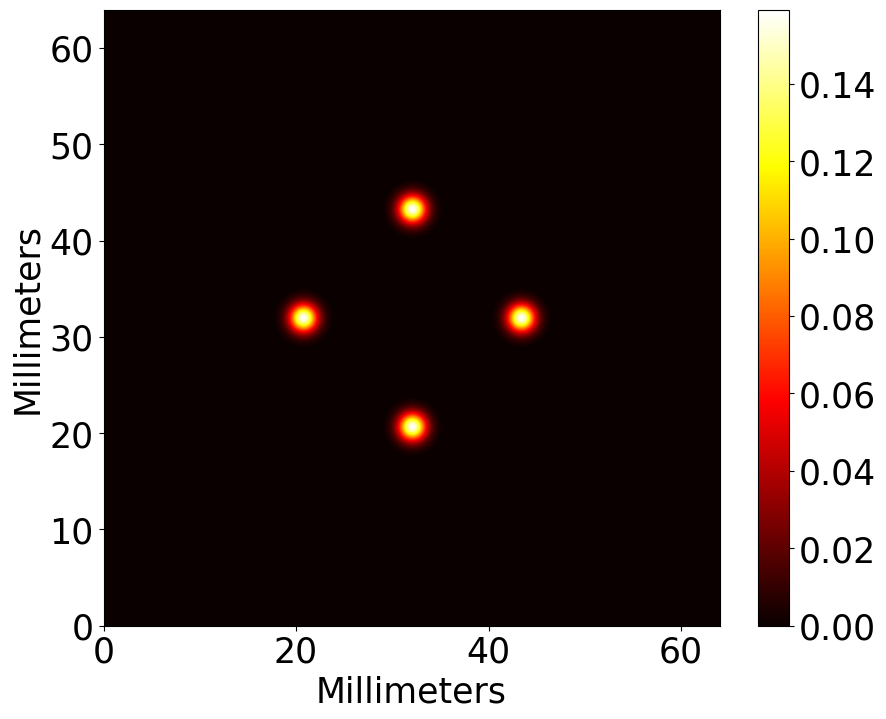

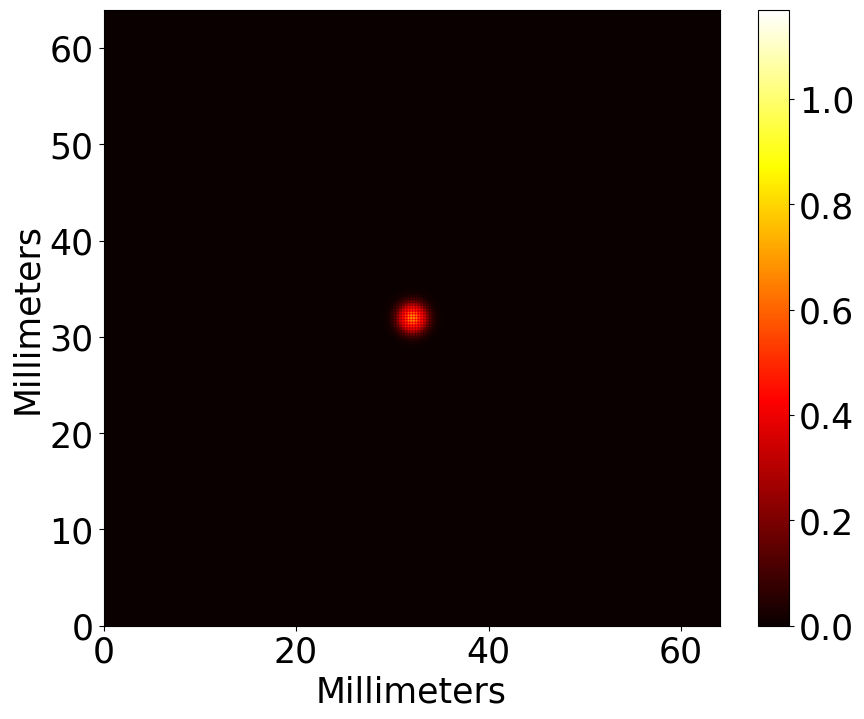

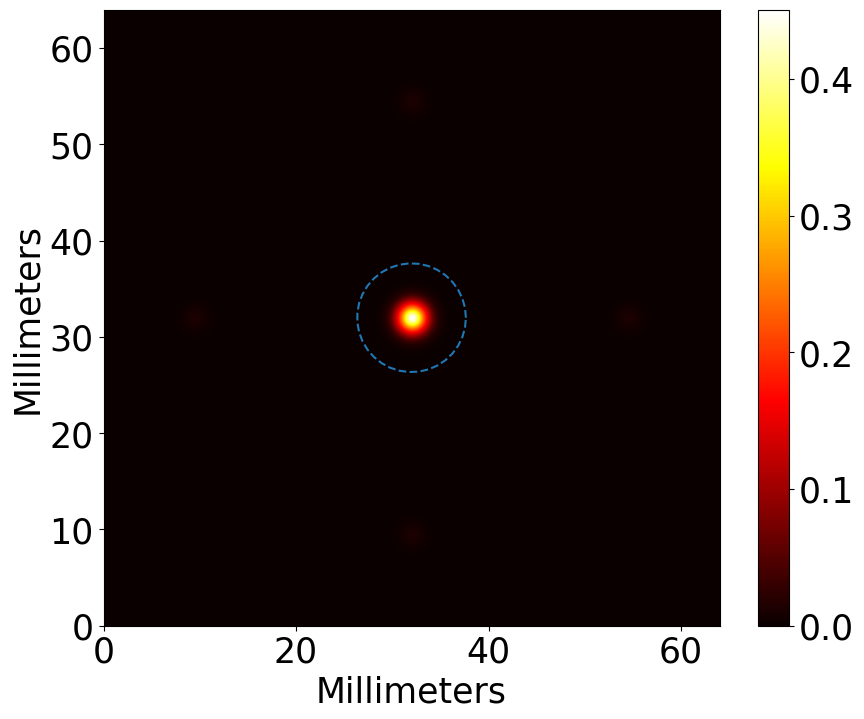

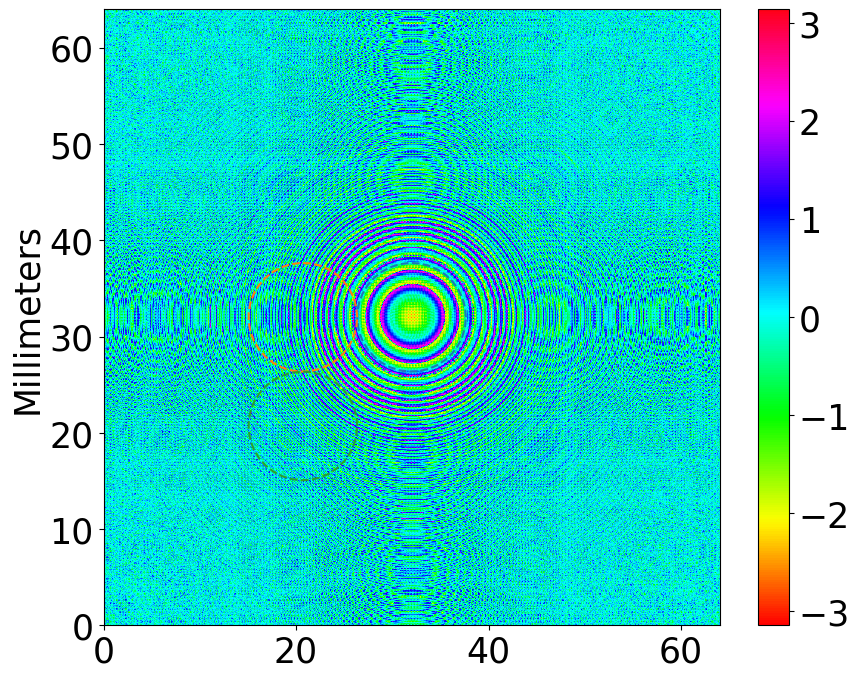

In [158]:
#@title Profile Plotting
plt.rcParams.update({'font.size': 25})
# print("Eff=",eff)
# print(np.max(iout1cpu))
theta = np.linspace(0,2*np.pi,36)

x1 = 64*(ioutcpu.shape[0]//2)//6000 + RoC*np.cos(theta)
y1 = 64*(ioutcpu.shape[0]//2)//6000 + RoC*np.sin(theta)
x2 = 64*(ioutcpu.shape[0]//2)//6000 + RoC*np.cos(theta)-R04
y2 = 64*(ioutcpu.shape[0]//2)//6000 + RoC*np.sin(theta)
x3 = 64*(ioutcpu.shape[0]//2)//6000 + RoC*np.cos(theta)-R04
y3 = 64*(ioutcpu.shape[0]//2)//6000 + RoC*np.sin(theta)-R04

plt.figure(figsize=(10,8))
plt.imshow(icpu, extent=[0,64,0,64], cmap= 'hot')
plt.xlabel("Millimeters")
plt.ylabel("Millimeters")
#plt.xlim(30,70)
#plt.ylim(30,70)
plt.colorbar()
plt.show()
plt.figure(figsize=(10,8))
plt.imshow(iout1cpu, extent=[0,64,0,64], cmap= 'hot')
plt.xlabel("Millimeters")
plt.ylabel("Millimeters")
# plt.xlim(27,37)
# plt.ylim(27,37)
plt.colorbar()
plt.show()
plt.figure(figsize=(10,8))
plt.imshow(ioutcpu, extent=[0,64,0,64], cmap= 'hot')
plt.plot(x1,y1,linestyle='--')
#plt.plot(x2,y2,linestyle='--')
#plt.plot(x3,y3,linestyle='--')
plt.xlabel("Millimeters")
plt.ylabel("Millimeters")
# plt.xlim(27,37)
# plt.ylim(27,37)
plt.colorbar()
plt.show()
plt.figure(figsize=(10,8))
plt.imshow(Tphcpu, extent=[0,64,0,64], cmap= 'hsv')
plt.plot(x1,y1,linestyle='--')
plt.plot(x2,y2,linestyle='--')
plt.plot(x3,y3,linestyle='--')
plt.ylabel("Millimeters")
# plt.xlim(15,25)
# plt.ylim(25,35)
plt.colorbar()
plt.show()
# plt.plot(Tphcpu[3000])
# plt.imshow()
# plt.figure(figsize=(10,8))
# plt.imshow(Tphcpu, cmap = 'gist_heat')
# plt.xlim(1500,4500)
# plt.ylim(1500,4500)
# plt.colorbar()
# plt.show()
# plt.figure(figsize=(10,8))
# plt.contourf(ioutcpu,100,cmap= 'hot')
# #plt.xlim(1000,4000)
# #plt.ylim(1000,4000)
# plt.colorbar()
#plt.savefig('k'+str(1)+'.png')

In [ ]:
# plt.plot(ioutcpu[3000])
imax = np.max(ioutcpu)
print(imax)
maxp = np.where(ioutcpu == imax)

print("imax=",imax, "maximum point=", maxp)
#print (Pout/Pin, PIBc0/Pout)

2.055132179192361


(2500.0, 3500.0)

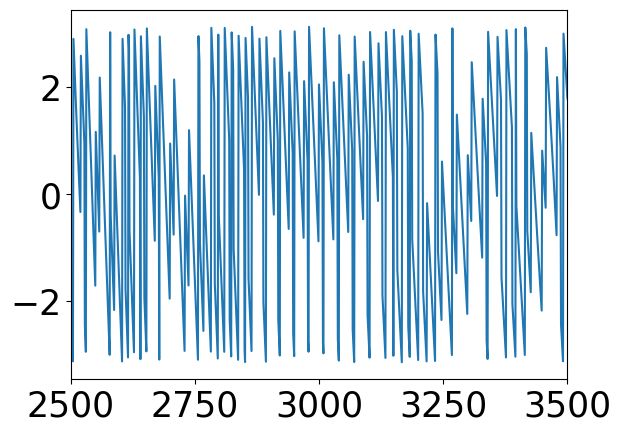

In [33]:
plt.plot(Tphcpu[3000])
print(Tphcpu[3000,3000])
plt.xlim(2500,3500)

In [ ]:
#plt.plot(effct[0])

ef0 = 1
theta = 0.0065
#pertheta = (sig/0.0065)*100
sig = np.linspace(0, 0.005, 30)
psig = (sig/0.0065)*100
ef = ef0*(1-2*np.log(2)*(sig/theta)**2)

plt.plot(psig,ef,label= 'Analytical')
plt.plot(psig, np.divide(effct[0],82.69), label='Simulation')
plt.legend()

In [ ]:
plt.plot(effm)
l1 = np.max(effm)*0.95
plt.axhline(y=l1)
plt.show()
plt.plot(im)
l2 = np.max(im)*0.95
plt.axhline(y=l2)
print(effct)
print(im)

In [ ]:
#@title pixel dependence
pix4096 = [83.33115619905603, 82.66706807299859, 80.73787633936905, 77.7232188571957, 73.89148624028842, 69.56065899061088, 65.05507920148365, 60.66644265026723, 56.62528712563668, 53.08618581394023, 50.126567507804424, 47.75644698368618, 45.93533553195965, 44.59059407451215, 43.63528667960562, 42.98179922919327, 42.55099843502796, 42.277187613728934, 42.10927236213741, 42.0098214366459]
pix5000 = [81.05260126303168, 80.41698587498949, 78.570662985714, 75.68574991870692, 72.01950162393369, 67.87657508171621, 63.56758446179962, 59.371742893403834, 55.50953804624075, 52.128586270524856, 49.30256337632212, 47.040759804026344, 45.30385409845496, 44.02219659453528, 43.11236795963729, 42.490444566294805, 42.080771528500655, 41.82053179529272, 41.66093800518191, 41.56634543937711]
pix6000 = [80.89354872028771, 80.25547273998026, 78.40205164078137, 75.50610714536779, 71.82596214932532, 67.66748449457558, 63.34255708875792, 59.131368269865916, 55.255173838978614, 51.86203346146227, 49.02579107497523, 46.755674611716444, 45.01222840993245, 43.72550333082759, 42.811860530596626, 42.187162336346, 41.77555895458001, 41.514053407043725, 41.35377141165409, 41.258932180481686]

plt.plot(pix4096)
plt.plot(pix5000)
plt.plot(pix6000)
plt.show()
ratio = []

# get last index for the lists for iteration
end_index = len(pix4096)

for i in range(end_index):
    ratio.append(pix4096[i]/pix5000[i])
plt.plot(ratio)

ratio2 = []
end_index = len(pix4096)

for i in range(end_index):
    ratio2.append(pix4096[i]/pix6000[i])
plt.plot(ratio2)


In [ ]:
#@title stat
import statistics
effctl = [[80.83079791994197, 80.85438918088369, 80.84520219032571, 80.84436057300758, 80.82299149131484, 80.81281745919694, 80.85582096083516, 80.73738819012878, 80.84631608108023, 80.7651685839014, 80.85110944897042, 80.82136272478321, 80.83609178548427, 80.8018380339155, 80.82133528832232, 80.85297913774156, 80.82519508014919, 80.85397354544433, 80.61877550062069, 80.75150082190238, 80.813252889332, 80.84971004653399, 80.85566284300121, 80.85232509161399, 80.66863724368775, 80.85074377081341, 80.8432173865337, 80.75579735439952, 80.81637668981057, 80.85241478346997, 80.77920455350244, 80.81206140203457, 80.85533681777463, 80.70973141026685, 80.84593798035799, 80.83487653690376, 80.85520614304168, 80.85556712728628, 80.81217402670245, 80.82649081129264, 80.84931636370244, 80.84754368017141, 80.83716990272116, 80.76723821060531, 80.85312715953333, 80.59437799194686, 80.8043245321289, 80.61820071888397, 80.85483167890283, 80.8544282248074],[80.48606325500577, 80.72601591525527, 80.46600224844632, 80.75168801856137, 80.71586006732218, 80.82479236508756, 80.85254412815637, 80.8527047482628, 80.57690700981681, 80.84876638989815, 80.85493211216554, 79.90223417824102, 80.84521018952412, 80.64203590721955, 80.85005762666633, 80.37659203481492, 80.80525125615189, 79.83886639179923, 80.51897470499232, 80.85590902588417, 80.84294380678341, 80.78239184781094, 80.54389200321457, 80.84558338287997, 80.01858822417263, 80.69283229883662, 80.66758044332418, 80.77907185376331, 80.6888015888058, 80.80205061815848, 80.7889521493265, 80.66079921846263, 80.7417606092761, 80.78004349569282, 80.85475010167241, 80.67714096857806, 80.84518037129989, 80.85064691902525, 80.36722870023054, 80.61812136277156, 80.82188711903126, 80.79043974761795, 80.71298456611495, 80.8558998427147, 80.62803388942757, 80.85453485050459, 80.83572541301, 80.74398673648068, 80.84148842663467, 80.83275244264557], [80.80076500626303, 80.68331347589283, 79.65694708211186, 80.82940739328677, 80.85291029957014, 80.59236324885076, 80.12906232162112, 80.79584431371345, 79.65478671523194, 80.63054149973277, 79.95037541054874, 80.63700054465781, 80.8476997324548, 78.46180124041938, 80.85335641412054, 80.64879081302004, 80.8535036035322, 80.74389321035285, 79.32394628405531, 80.28804140512287, 80.51898351389796, 80.597495195175, 80.48709563270938, 80.84358010455051, 79.10899517069431, 80.47388597774024, 80.82255026280455, 80.7623290293172, 80.84964235895501, 79.84597505379303, 80.79058587392184, 80.53568270431646, 79.93830109022636, 80.2247299354383, 80.77422256148081, 79.94989513113447, 80.85496210238186, 80.67983748225245, 80.72410934461699, 80.69255513280805, 79.73480051769751, 79.42360586881722, 79.26496697506235, 80.6663185750863, 78.16345195756661, 80.49568001034314, 80.82681657883957, 79.52969155477443, 80.48298872616722, 80.64968651068556], [79.77050174651511, 80.8298025153635, 76.16570283109021, 80.85517681402618, 80.84980171968039, 80.81644008913975, 80.81949663726834, 80.85567443539574, 80.6279528460443, 80.48806578182926, 78.70931144409522, 80.32811748144222, 78.55414329467789, 80.56379683886496, 80.401831852685, 80.32373987611201, 80.83165379436326, 79.8102869997927, 80.55674837163443, 78.98192127485953, 80.75708081464502, 80.64142578858062, 80.5914471237974, 80.73020580219452, 79.98657830397138, 80.2595263270494, 77.93279153141657, 80.84715332241123, 80.75754133560523, 80.32304131451593, 77.98974024300229, 79.90840217973168, 79.49764028961779, 80.7366270052063, 80.7829594907243, 80.56696667848844, 79.92853218830427, 80.85552317328923, 80.02513607487094, 78.59796335106918, 80.73848359016198, 80.66321604550544, 80.56073447868172, 79.2664707417668, 76.75535957636387, 80.42062201798515, 80.83662235759435, 78.2430087741232, 80.6191200124488, 80.78595210973172]]
effctc = [[80.84435393394855, 80.85429668875659, 80.81770091089436, 80.8144913181217, 80.83953677019721, 80.83824978786002, 80.83899878984646, 80.7620043442977, 80.85545694431792, 80.81280921487178, 80.78135083299456, 80.79206567511157, 80.8553408900141, 80.85523422491322, 80.8458367535145, 80.78127855165918, 80.84891993198805, 80.82065039616545, 80.84042777579045, 80.81790082388626, 80.8417900114101, 80.84939157391521, 80.85579536343778, 80.85430284495617, 80.83417930015936, 80.85585113995062, 80.85211787655577, 80.83396049233106, 80.77204821911631, 80.85588919868403, 80.82317948956693, 80.77292743814273, 80.85287039071865, 80.83086538907159, 80.85227354526032, 80.85442895545991, 80.77561279910866, 80.79288803340636, 80.80724958998215, 80.85590829530427, 80.84330426295885, 80.80505603194048, 80.81731417227101, 80.7884918938851, 80.77111280768518, 80.83561125159903, 80.85245819829984, 80.85482941784853, 80.83324105281577, 80.84076556394207],[80.83056682381407, 80.83565545703972, 80.82097215218678, 80.61914015536426, 80.67103921294067, 80.84936485104936, 80.80881361265911, 80.72318336625537, 80.7700766065204, 80.84339504728132, 80.75037787015835, 80.8505886751535, 80.58712110655858, 80.85589790895713, 80.74874412683212, 80.84745724211135, 80.74536644253322, 80.85587643859726, 80.72456627823553, 80.8138699599201, 80.50591286828369, 80.85588811391703, 80.75566328989811, 80.82581795240127, 80.79351049733768, 80.35843168247875, 80.19004000718742, 80.62527898148208, 80.85120069515183, 80.78819601780845, 80.84289792543579, 80.32208786070085, 80.84025126006745, 80.84533082890513, 80.83256832024695, 80.827643878956, 80.8538867425162, 80.81239413678107, 80.84277249856915, 80.83192290961156, 80.8190340950399, 80.8533809781669, 80.73583844473116, 80.7430146089561, 80.8485870461184, 80.69922817764623, 80.58260323600179, 80.786970178914, 80.69002373595085, 80.85150710532476], [79.72519542635338, 80.71696159677023, 80.6867222405845, 80.85582932395987, 80.15569395956868, 79.51689147261014, 80.84796751886296, 80.70355868209546, 79.4653904556407, 80.26362124716034, 80.06565238232747, 79.98241281339999, 80.57204036097863, 80.02007575734055, 80.84336547822043, 80.55963531690634, 79.72241703055634, 80.78750249742257, 80.33331300487541, 80.51566382642677, 80.76896345252146, 80.38232405976915, 80.81162352811981, 80.66672926385417, 80.48484422886699, 80.85520948591089, 80.85398539350074, 80.61772594723126, 80.61159454826154, 80.83823860570284, 80.57452397072089, 80.81446801914667, 80.71318895971716, 80.58263567402167, 80.74522828965713, 80.8478738702961, 80.64983835192407, 80.57993783104216, 80.47422269128468, 79.82216339165466, 79.82503607495373, 80.66893140341584, 80.8471809870732, 80.67294425309647, 80.10941588164704, 80.83758075314907, 79.69227804433504, 80.79950265410197, 80.35496886318937, 80.8548827939075], [80.36889915020454, 80.84720315395282, 80.85383450808402, 79.65012409533526, 80.63060237793461, 80.82585491157381, 78.71049370241668, 79.05312125858043, 77.82547189481173, 80.82075867541963, 80.65162618104904, 80.83762321942925, 80.8548559133295, 80.76773532279921, 79.54874927631647, 80.7094101215304, 80.76777818839511, 80.83703299904457, 78.90509646630562, 80.58914707341128, 78.6965958518254, 80.59250142964038, 80.73136130845567, 79.91977919474932, 80.70721522573004, 77.75670900004638, 80.82579033139147, 80.84479482549301, 79.0204918249852, 79.89697431521911, 80.85569179506969, 79.1010948599742, 80.76594919865447, 80.77617633086194, 79.8949284212909, 80.85561780070977, 79.98437190310726, 80.84614833797391, 80.81426944962666, 80.6889870266246, 80.85313999790046, 80.577116359404, 80.60924346415702, 80.71302269535583, 79.36585817376972, 80.79989324875761, 80.07200828130871, 80.85540595018882, 80.74787293576831, 80.12581823534349]]
effct1 = [[80.85139088140131, 80.48075030227665, 80.16245570624436, 80.84411080285656, 80.85120150742529, 80.77409207349552, 78.54532180839189, 80.29122559235918, 80.83071748190959, 80.84561922078257, 80.42460600281808, 80.723249251564, 80.49734675621714, 80.81321553534806, 79.3711483430028, 79.74202170181594, 80.85380921609068, 80.85545048300709, 80.62536928254487, 79.73993751505837, 80.07205795388577, 80.47208673277986, 80.7815008296348, 79.07423379401374, 80.00041210100068, 80.23454722604801, 80.25528517020753, 78.9247593149273, 80.84732732580659, 80.81339190647152, 80.26928017029431, 80.08355545924404, 79.31548325724962, 78.288612936954, 78.7399469491884, 80.07608605207776, 78.90333235544077, 78.81655881988992, 80.65685963732935, 80.85509141233273, 80.60800517759027, 80.71589834588436, 80.32134113434026, 80.85589456742483, 80.63412177675396, 80.42370878058112, 80.64389925173514, 80.80239647747895, 80.28260602499104, 79.9809065852948], [80.85313989657715, 80.85339256917547, 80.84403850062816, 80.6442572358403, 80.82752700435373, 80.52534882438287, 80.85254595003644, 80.85135164946733, 80.80822751340014, 80.60643645881274, 80.82914650979906, 80.35167361212707, 80.85051353158178, 80.59912806074779, 80.46494625161313, 80.34687173593625, 80.69232095561203, 80.39142740762713, 80.81437055802253, 80.69766626146256, 80.74800612019865, 80.29251396996399, 80.71481169071842, 80.68614170123578, 80.8455104318164, 80.58994828749529, 80.60873761801331, 80.71740562683398, 80.66307415419244, 80.8438624035347, 80.78336654809836, 80.65588945407902, 80.8510716002209, 80.78655326128617, 80.8386410025867, 80.84968692089858, 80.51895832115231, 79.8444599228873, 80.84203017375249, 80.85521266045714, 79.72901410220237, 80.27097108947099, 80.75190687099801, 80.78263122045536, 80.80723139547113, 80.85590703289243, 80.14742797661502, 80.72384080609176, 80.68411838740104, 80.83277321274994], [80.85499643851671, 80.60638395267972, 80.80891126778118, 80.65127201688902, 80.53362736541295, 80.59557220964514, 80.85415336081819, 80.84910133672574, 80.85433097427841, 80.50192423938466, 80.63246444582049, 80.84711610035798, 80.81681904281677, 80.83097062917503, 80.53019525566751, 80.79651488506599, 80.79275506570366, 80.7957160734267, 80.84723493960549, 80.82866836366486, 80.8431358432968, 80.85511177926217, 80.85380049909784, 80.69389937760123, 80.45114930981002, 80.44905792703604, 80.83410249443483, 80.75465967119604, 80.65762689298354, 80.8293723351358, 80.67527320291744, 80.83535481608092, 80.73435869259924, 80.74868071108044, 80.65915132416966, 80.80292879437528, 80.85551388787933, 80.68120611660855, 80.31611607447489, 80.84972881261272, 80.5990493020418, 80.80443302406508, 80.65290629819964, 80.76047771613506, 80.72606000734986, 80.7331343796897, 80.84257573194876, 80.81048401880382, 80.57315530595595, 80.58925749245924], [80.7596754745565, 80.85278735033307, 80.85011270074433, 80.59858301727341, 80.85374411846163, 80.61184742860381, 80.79712348528258, 80.83728603938316, 80.64001806270183, 80.85567667615902, 80.85329560560689, 80.62578242611859, 80.77535640615542, 80.64743260418568, 80.85354490415413, 80.82126228453536, 80.84207405839537, 80.82516952266944, 80.84564923217751, 80.83463397504757, 80.5376379569355, 80.82253201089966, 80.85590300191883, 80.8557999007126, 80.82609777578843, 80.85458938179582, 80.60602586686633, 80.83005430361936, 80.74686327183099, 80.62310737657668, 80.37158195429751, 80.75847938929269, 80.62225590646517, 80.8504293424541, 80.78466481840957, 80.48782495192742, 80.65860918677646, 80.81587731756214, 80.82889873670648, 80.39129761141656, 80.83916773443597, 80.04647632795874, 80.85556267936241, 80.83153376552555, 80.83397766920514, 80.54571445088612, 80.84983793642328, 80.81205248266834, 80.8349762205654, 80.50385147183314], [80.73530175674276, 80.3779542117028, 80.84275386485945, 80.78633289304238, 80.83936401842745, 80.47475495409519, 80.76219167819067, 80.72958067897542, 80.85499074212417, 80.7538155028407, 80.60038354399198, 80.82657803867741, 80.62258264810308, 80.69541177698373, 80.74532330472164, 80.85573471539645, 80.84452555962368, 80.75006792371, 80.85348463886014, 80.84787439345583, 80.47573450006531, 80.85584073827256, 80.85431984386184, 80.7395963705916, 80.85471154476483, 80.69077742232392, 80.78713488035076, 80.85483291168632, 80.20897266799115, 80.85357101668207, 80.72126731100444, 80.83998192998484, 80.79566922382722, 80.72898051646473, 80.52065191350589, 80.55475068787139, 80.85107904972027, 80.85570850766503, 80.58253026928837, 80.7644454830238, 80.75108679880812, 80.84524206844344, 80.8547725891676, 80.82746186105861, 80.6163704162829, 80.85468900593843, 80.8270024526832, 80.79856011040941, 80.71962938736903, 80.82412944780188], [80.60197746017144, 80.80395256119081, 80.74406046765708, 80.48602603978895, 80.77641727679567, 80.7545002411878, 80.7397803648225, 80.24292426927629, 80.85199622508362, 80.77050609834544, 80.6530975903229, 80.28479191528099, 80.76530185594731, 80.78999654510424, 80.8412589367421, 80.8092132645164, 80.4874158125526, 80.83388620980723, 80.52730915431394, 80.78137402153975, 80.8221770840684, 80.74240916966589, 80.84618162548375, 80.82676054671931, 80.73547660099443, 80.45840155543654, 80.67544646111708, 80.68330460731144, 80.8403523467618, 80.83191775979232, 80.62639120331899, 80.84769994939367, 80.74222805342454, 80.8237457024909, 80.84511469254633, 80.85247742323673, 80.67739275186845, 80.84677386343749, 80.83525343803879, 80.84406672238653, 80.8435746998855, 80.81831186046088, 80.85370059667292, 80.84375721569592, 80.45036920048973, 80.32736146592737, 80.8084571174476, 80.83288724555204, 80.85413198468405, 80.842037988356], [80.85184444278491, 80.85574479411302, 80.45039092322315, 80.84617740617868, 80.84813789023347, 80.729238409511, 80.8426831246084, 80.5648480787752, 80.83601661717621, 80.83473673746646, 80.77908850009146, 80.71421174291908, 80.82378569059749, 80.80105317770354, 80.78136820022574, 80.85538972306352, 80.81748125380288, 80.8364759393089, 80.77520134543464, 80.7081595031853, 80.83740839237173, 80.75227560985518, 80.85333671553549, 80.85144012462638, 80.85546581470581, 80.80849258626294, 80.7448008708602, 80.84853174311012, 80.69448737840207, 80.44263330394153, 80.2198981809667, 80.7768427780013, 80.35421421398605, 80.80876129495753, 80.76058649973997, 80.69845457063758, 80.85152270139969, 80.84810097859089, 80.78945807396147, 80.84752075519519, 80.85515211406754, 80.72407999922736, 80.8534424459315, 80.63191659319422, 80.84932157100728, 80.84883750117856, 80.79816040410451, 80.3287556484882, 80.83821319270047, 80.80511087033561], [80.77126558113147, 80.72202136594187, 80.70926595750139, 80.77771732185678, 80.2942567627004, 80.8441507613131, 80.79369166582528, 80.46956893020334, 80.66915277880275, 80.81800426717916, 80.6654572797554, 80.80625427531616, 80.54692695860341, 80.54755014518085, 80.30692139881586, 80.75663875601239, 80.33970295451842, 80.8162428678706, 80.68211777160506, 79.8754474889398, 79.70892296932857, 80.84702619558972, 80.78304648494056, 80.77359478997109, 80.84341616075454, 80.81812050212338, 80.8433576223713, 80.83935041585897, 80.1216646476753, 80.85536698921615, 80.69565804963123, 80.74233139915266, 80.80382235787758, 79.61846533715122, 80.65115822135806, 80.01534782779217, 80.73428502365493, 80.58266952380916, 80.5566574800674, 80.7151547941532, 80.52795976471529, 80.37462900783557, 80.82802593922978, 80.25423549659153, 80.82408016563483, 80.16622695580908, 80.84560888180948, 80.84456842517977, 80.83629030327411, 80.09399358596706], [80.69228200234184, 80.13916271273179, 80.8305940093949, 80.82829973472673, 80.63852159225667, 80.5890317928483, 80.70609395133079, 80.01034698420891, 80.68326278851967, 80.84669030673737, 80.75012217410904, 80.65782408194798, 79.065401877262, 80.73216794764096, 80.68356272258893, 80.78990421390827, 80.73266651389332, 78.58182711131793, 80.329016737977, 80.11013620779366, 80.77211228112446, 80.20056529489855, 80.75678157617855, 78.1594121188846, 79.86818294460832, 80.77632377338666, 80.8149332367145, 77.3738151686052, 80.74916703741428, 80.13688567194531, 80.73757921926621, 80.85548269645098, 80.29228697480472, 80.52905591643912, 80.21989713866593, 80.83842704173884, 80.80965434054438, 80.48668212707017, 80.8159913750023, 80.84521717385728, 80.84492594368955, 80.62556423312633, 80.61182123384609, 80.15015033643289, 80.85017523570409, 80.76491395704754, 80.19337668821873, 80.43045701370075, 80.51219739647294, 78.80629090035272]]
#effct = [[80.0502893854884, 80.76686714267848, 80.66573774458152, 78.97881226266594, 78.9640507787838, 80.40496979453299, 80.02488222822292, 80.85512534734764, 80.72874891162883, 80.82746976515382, 80.0504761296318, 80.61871805103782, 80.84229331980907, 80.71122518886878, 80.26095221084681, 80.84103331447965, 80.83557214077072, 80.57752574183749, 80.41316183230757, 80.63361594319912, 80.79302676145218, 80.01216694412602, 79.57366705290619, 79.38619979527112, 80.46570957229474, 80.63994261159043, 79.47374562495828, 77.19761635530962, 80.81013122892567, 80.83906668126448, 80.54616109526296, 80.85092118817238, 80.852895919449, 80.68142584179168, 80.49349802379696, 80.24290361403904, 79.45799721832825, 80.85461880648907, 79.99978106174548, 80.6364121391643, 80.69010046305497, 73.63962698883867, 80.10398742534144, 79.41135425908895, 78.95221825121816, 80.84996718621167, 80.78037023900269, 80.2556407564702, 80.18002940507768, 79.33572003942731], [80.85540739792441, 80.52988053884062, 80.83814278197138, 80.58572165259086, 80.6361795505409, 80.4771903274904, 80.7468824402062, 80.84355769692647, 80.67753067921454, 80.2259151931031, 80.63646098257519, 79.96086678425708, 77.57888870121943, 79.29054757112087, 78.52563837288656, 80.56109637000083, 79.28903273405467, 80.8067231034475, 80.14657510582013, 80.62294916416143, 80.84730414930715, 79.80758396279411, 80.84003385377126, 79.25220136679104, 80.13559760034248, 80.75913629075247, 80.85530992030763, 80.53153910155385, 80.70452758884691, 80.12751107174509, 80.70752177865761, 80.78248498741893, 80.85338205381582, 80.45188027526937, 80.12699096942022, 80.44606216579231, 80.69889993402508, 80.00614624963954, 80.8461308413268, 80.72523915685612, 79.91978353092146, 80.06215069697397, 79.08006666214155, 78.69236244242613, 80.76698913234054, 80.730066730334, 78.98990571888024, 78.06737893681206, 79.88757196438168, 79.27199537193982], [80.69153450347787, 80.85559939950613, 80.20580255715554, 80.8543833412085, 80.478795655474, 79.84879765337598, 80.26455539100463, 79.72672380530132, 80.42765220589472, 80.38808622930058, 80.82431442008271, 80.35923665530666, 80.65698063446487, 80.70182916747423, 80.59794824871676, 79.24707331235041, 80.0709646749698, 80.3396564709846, 80.60111335961516, 78.6394650179674, 79.75770437425709, 79.63052821774569, 80.53112984070556, 80.23871998636639, 79.98886478014808, 79.08423797371348, 80.81000238606211, 80.68058885903217, 80.40786059659557, 80.35474202721946, 80.78541685519784, 78.14255503020227, 80.31283288239595, 80.82226368257689, 80.75340124517487, 80.6981232377732, 80.27953339575723, 77.8558651974924, 80.59461996531847, 80.81126316069029, 80.8549352507512, 79.96677782469601, 80.75202431241398, 80.82145953784884, 79.68266168586125, 80.8406812144619, 80.73839207167327, 79.11577183842779, 80.08618453577137, 80.85259991483223], [80.72907751604839, 80.76677467152071, 80.69993227973363, 80.75232982781836, 80.52787940075079, 79.75348343009992, 80.81688667471428, 79.35944701333351, 79.95193004335387, 80.84842464919272, 78.94053873697672, 78.31015403929212, 80.5055334517879, 80.14780926446834, 79.20832778893202, 80.84849392971074, 80.56879363287221, 80.64432530278613, 80.84549588389287, 80.63755355085533, 78.94751412745207, 80.42999208939746, 78.86099006190392, 80.6354561914411, 80.59478456445348, 80.8147923304451, 80.7199861928743, 80.7159762519411, 80.51227722016013, 80.40118099059671, 80.4481348762923, 79.8855348113215, 80.81218320153391, 80.71148956098733, 80.84727168798152, 80.42662326123748, 79.87328508667937, 80.1592825856505, 80.69332597038762, 80.33468033909624, 80.84273576296461, 80.14053784902595, 79.4212019304124, 80.85575478873304, 80.64126449133528, 80.54652791325502, 80.42676933149038, 80.70046805401326, 80.7376478024104, 80.65529073423437], [80.60426578065396, 80.6676528713698, 80.18170767166465, 79.43436597579984, 80.75247636030181, 80.79741349163201, 78.98774265190256, 79.66843637391901, 80.5172310937272, 80.46236277893439, 80.36541735476887, 80.53768157270828, 80.84222116345207, 80.22628036859619, 80.70479665864906, 80.62181103923041, 80.2379239376286, 80.85303326874944, 80.12481970152912, 80.83320078041885, 80.04217142937881, 80.07885673433954, 80.84937230226627, 79.31047924142253, 80.67309361916166, 80.72559124390347, 80.74044875458634, 80.85245281016941, 80.8383445647375, 80.82689127485713, 80.66325146130333, 80.69262132342418, 80.70504668406764, 80.16458241743304, 80.7428887607355, 80.72294065796378, 80.37077996761009, 78.94115103633249, 78.26056311203153, 80.58674247790927, 80.77732913223252, 80.01142718466609, 80.47458002599615, 80.64878761165676, 79.3978792387962, 78.97482201296178, 80.22733295267236, 80.31944151376675, 80.62232150136727, 79.30108982124572], [79.6908519394735, 80.02384898572734, 79.9905269140061, 80.02710172500186, 80.56110516896354, 80.84446311032842, 80.70469229979909, 80.80148874883666, 80.66352546912758, 79.89128244449347, 80.17061860690377, 80.83989112041345, 79.65978297422257, 80.45463756868139, 79.68847901165668, 80.77126175581853, 80.49356017869125, 80.6536566447305, 80.42149443600128, 80.06730259655713, 78.32274906107001, 80.82191638531879, 78.97951923857474, 80.17843281895152, 79.23964524718237, 80.51093540957005, 77.80336442960636, 77.52841253339294, 80.8518362781106, 77.83097372133057, 80.58684713954847, 79.72746416508777, 80.71946834477782, 80.68174235409772, 80.18188309781887, 80.69517023153001, 80.45197546910204, 80.73686519457812, 80.82828410199663, 80.84012329548335, 80.74871263430164, 79.24017505153054, 80.35568758461704, 80.82900411714539, 78.8353080343558, 80.06199835255703, 80.78641663251659, 80.82390136335333, 80.52297551174553, 79.82201226918907], [78.82762792479407, 79.7462558138038, 80.49710448072435, 80.43579190646156, 76.96053699247408, 80.6873306954388, 80.3101642800678, 77.08531936928466, 79.39106498319612, 78.51634549004572, 80.62247687834245, 80.65047630876695, 78.95041808873286, 78.29551800057381, 80.73206287165894, 80.18616631796095, 80.84165670091386, 80.84880978963758, 80.6071829369854, 80.58656448257963, 78.31451930924989, 80.84742487669637, 79.44130922705098, 80.8249776664274, 80.71689092258178, 79.02599805280916, 80.84027646375141, 80.83476763014073, 80.75643700306682, 80.74593722694587, 80.77137357223802, 80.70894681626163, 80.8279569308534, 79.17112994390443, 80.67693670152383, 80.53075562900726, 78.2069752299635, 80.01927355768377, 79.04640178684136, 80.71806066573455, 80.60129605388573, 74.13276198534142, 79.82226370727659, 80.1075999642836, 80.84673678824859, 78.75872125925194, 80.69532239804286, 79.80443094263205, 80.74519309671253, 79.53134516924744]]

#print(effct)
Mean = [statistics.mean(effct[0])]#,statistics.mean(effct[1]),statistics.mean(effct[2]),statistics.mean(effct[3]),statistics.mean(effct[4]),statistics.mean(effct[5]),statistics.mean(effct[6])]##,statistics.mean(effct[7]),statistics.mean(effct[8])]
stdev = [statistics.stdev(effct[0])]#,statistics.stdev(effct[1]),statistics.stdev(effct[2]),statistics.stdev(effct[3]),statistics.stdev(effct[4]),statistics.stdev(effct[5]),statistics.stdev(effct[6])]#,statistics.stdev(effct[7]),statistics.stdev(effct[8])]
plt.plot(effct[0])
# plt.plot(effct[1])
# plt.plot(effct[2])
# plt.plot(effct[3])
print(Mean,stdev)


In [ ]:
#@title Error Plotting
plt.rcParams.update({'font.size': 20})
phr = np.linspace(0.1,0.9,9)
Meanl = [80.80949394739426, 80.68715001143079, 80.31895541895628, 80.03492077375469]
stdevl = [0.06537463089680307, 0.2351665590961771, 0.6462468935717333, 1.1017405534491296]
Meanc = [80.82765238317867, 80.7512791481751, 80.47395903328268, 80.24700492526615]
stdevc = [0.028569207898504288, 0.1452900521633689, 0.40148225314368724, 0.830486918393359]
mean1 = [80.21744453982923, 80.65652068901947, 80.72600979605475, 80.73325472347324, 80.74217015542868, 80.72847894486225, 80.75458512855492, 80.58714781215194, 80.36450483019456]
stdev1 = [0.7125768872877065, 0.25424682414480154, 0.13273651974291234, 0.16580591885849866, 0.1412635332576328, 0.1596118281026172, 0.14958129524892727, 0.31605643008005724, 0.7364563735180615]
mean2 = [80.12116859567885, 80.17617883307875, 80.2406450916959, 80.33312302295697, 80.29928243529262, 80.1192674353575, 79.85701789780197]
stdev2 = [1.17815148845791, 0.7936210696799515, 0.7000910468650712, 0.6187758638456782, 0.618595007529086, 0.849285916790662, 1.3095995444947313]
fig = plt.figure(figsize=(10, 8))
plt.errorbar(phr, mean1, yerr = stdev1, ecolor = 'red', fmt='-o', capsize=2, linewidth = 3, elinewidth = 1.5)
plt.errorbar(phr, mean2, yerr = stdev2, ecolor = 'green', fmt='-o', capsize=2, linewidth = 3, elinewidth = 1.5)
plt.xlabel('Polarization Power Fraction')
plt.ylabel('Mean Efficiency (%)')
plt.ylim(75, 85)
plt.show()

In [ ]:
#@title Statistics
import statistics
effcp2 = [[81.08404493983632, 81.09766948615396, 81.06662867183417, 81.08782601593053, 81.09117878669836, 80.73518851969062, 80.80797603240244, 81.08989499688096, 81.06879192224761, 81.0948054591458, 81.08109501651033, 81.08927348087514, 81.08078440267059, 80.93447316180983, 80.98973432862127, 80.98123450345561, 80.97398747934017, 81.0174890014848, 81.01761983944465, 81.05096652733003, 80.23182829218929, 80.93715373891261, 81.07914573562695, 81.02686401777255, 80.97758046681824, 80.85128919570059, 81.09797674029774, 81.07900237901138, 80.48453540566062, 81.07893240979006, 81.0930193416003, 81.0028481745583, 80.87780304253624, 81.04684101062335, 81.06226248750568, 80.96548719786458, 81.10046855785487, 80.5604215270679, 81.06730388172751, 81.1005355916122, 81.09697891895705, 81.10025458092697, 81.07426176896475, 81.10060405355033, 81.08508449286937, 81.06344013240846, 80.99487716115723, 81.05853490901713, 81.09652085822238, 81.04780916290835], [81.10124430793743, 81.08276079202834, 79.95220257925871, 81.05721808438167, 80.99107022116947, 81.00204722437886, 81.03353132050913, 81.09764851704612, 80.82256899480664, 74.9902597843088, 79.82252985844771, 81.06463057374519, 81.09327468668465, 80.26989469033691, 80.3194711460392, 80.93471921500232, 81.09858485065831, 80.99285889509929, 81.09939127498154, 80.45081480340835, 81.10067804893684, 80.87094110720669, 78.00616287304194, 81.00639543922361, 81.00386686655948, 80.48169980570623, 81.09866294687578, 81.036798104306, 81.04417841488126, 80.72190574794985, 81.07676704164693, 81.0949131856298, 80.91752797210489, 81.06893959844797, 80.70198289456859, 80.94319844024689, 79.64273880945485, 80.93326199649809, 79.97236835762462, 80.889184985142, 79.01342297937038, 80.53298087984687, 81.09397101545613, 81.10117503051767, 80.22355746611392, 80.81623830002637, 80.85716504311476, 80.93750100169727, 81.10001193460137, 81.08915685658114], [81.07530864604236, 80.36459061353382, 67.9136140913345, 80.42309368420952, 78.95191458361587, 81.08998980710437, 79.79345377332407, 81.09097797666425, 80.33505159778174, 79.6939517735088, 79.62291806475149, 81.10021895242602, 81.03365986833701, 80.8016429583819, 81.03933863256134, 80.69392175894781, 80.6294465486684, 81.10177930155996, 80.74501894058716, 80.28839554162388, 80.52355904759641, 80.2323746486007, 65.90002587417315, 80.77772681014375, 72.85709248381258, 78.48650779598854, 78.6400811632331, 72.84557517690254, 80.86441065044691, 79.2229917665026, 80.65326589597575, 81.04936949611769, 80.81818376384048, 80.69932335424332, 80.27154572355941, 80.93982287021136, 78.13658971140698, 80.87657725866241, 81.0959571164019, 79.07753018301904, 80.75580385801673, 80.25004390799911, 81.04604722504315, 81.09883126297761, 80.94441625618981, 74.20843138750219, 80.62904759084991, 80.37247178319663, 77.98361206638299, 81.10139634705324], [73.63161699437426, 80.35537277293933, 80.89545530892062, 80.12889804275707, 80.20149591983909, 79.11437374957727, 81.08153170233778, 79.26945164397281, 80.92146651058894, 80.66747975306573, 80.81375185178605, 73.27134389502942, 81.05684835754842, 78.11804143366558, 81.05885920208193, 79.77652142425349, 78.61276344523357, 80.73964786137286, 80.70502972017856, 80.54511018501663, 81.00329612724101, 79.49429632693526, 80.3488212511144, 80.99277358839008, 81.09621158063128, 80.49940978093957, 76.81320118229623, 79.58001796724966, 80.837655440491, 79.89809534955981, 79.88307127789218, 75.18753900391624, 77.60627226009349, 81.05121788750978, 80.6473521046205, 80.84220009917775, 79.64139661813515, 80.1028843527794, 79.01818626765603, 79.77922336908425, 74.99972879429501, 80.9418812027205, 81.09864971945949, 80.30855231385485, 80.77063690866991, 68.86004839483888, 80.56938256621098, 80.71224896181049, 79.98992989509846, 81.08366943693333], [48.425901214041005, 78.59879898116972, 63.69179899168434, 81.0424574346001, 65.37692757959584, 74.64484061410576, 81.08038285667823, 68.52384341984606, 81.09945663238308, 81.00638582103126, 79.39456697950995, 65.78178814155262, 78.18839310576489, 71.49405837947981, 80.56799566769052, 79.60042606655409, 80.46738639794756, 80.63594742178725, 74.38405672053588, 80.6279530615037, 79.83197313130144, 79.96087555621855, 80.71495545933239, 80.97344180599598, 50.20461720259301, 80.26666452817778, 80.96386685402068, 80.8374869781603, 81.10075434118882, 80.95564865100833, 46.64812835301439, 60.961384254804415, 76.46644850362662, 50.5272121266738, 79.76009889678302, 80.21329733108702, 78.08131213284044, 79.59483185398463, 79.36146452337508, 78.45218468858995, 80.97101084346104, 70.54877087352959, 80.27004367164326, 79.8367020441324, 80.95788807168127, 48.283254347760455, 76.49524340398982, 80.99791740860431, 78.39719838200391, 81.08541641638593], [73.64438487693603, 60.73781346938832, 80.96278222574323, 80.16501612904388, 56.354778633584814, 75.66664279967635, 65.79812562373183, 80.995439371305, 51.01684494080382, 78.04995503679042, 74.80213010398974, 81.07144037233593, 81.03856832172282, 75.55156259438068, 79.67165921736296, 80.82299128988919, 73.5686551406814, 79.01264652985365, 81.05731742688069, 78.34259810121563, 80.50552777544524, 80.83315082944786, 48.332433478363136, 81.02422115682587, 69.21716367705754, 80.92052762903187, 80.79675972919901, 67.5977159535052, 80.8774164988665, 80.08771155566463, 80.26724092679021, 81.02623213989239, 79.23808584983686, 51.092412546240205, 77.44613216775282, 80.56240487711904, 72.60809604861844, 67.16270483643896, 81.08609666639761, 46.58666606464994, 80.97536306163052, 79.76462555197526, 51.814880538553865, 80.06053501484986, 80.59222578388936, 81.09027872225512, 73.18466208573909, 81.01834504664363, 80.89485631622216, 75.96261123322455], [78.93115853994837, 77.79912772734966, 70.21028136774568, 80.73762755637269, 75.73243516636896, 80.60962525800045, 80.84204216472712, 48.92052466614577, 81.00523476401486, 46.25714833324531, 72.69026208693789, 46.61969050491039, 80.3267858769523, 79.9674359295432, 75.7571491830506, 70.0497151257035, 78.7034231657799, 69.37398627058981, 74.3740496695897, 71.51702331169302, 80.57201342431846, 80.84291020683324, 80.85123381965474, 72.50448831884995, 81.0827626511871, 80.43250027203885, 63.67911292099082, 80.62866363231885, 79.3064540916306, 76.66492150981182, 81.09145182662769, 80.72740780258749, 78.07443862601012, 81.10154855570005, 47.092409068293264, 74.54183171183087, 81.05264787987417, 78.92001510518624, 57.6760527589631, 80.02347544822145, 55.09979470705525, 81.02783307433363, 76.21035532371185, 80.54284187220763, 71.33995909467977, 63.798895328755265, 80.65391382229568, 50.892258980785535, 66.14685145251768, 48.23549211684835],[81.00753302140262, 50.04251965730998, 80.97025941862202, 80.28353065513775, 46.257163911365154, 80.11902860711224, 77.82806839744025, 46.663371354806436, 80.59291011804342, 80.90050019895256, 75.45972883019256, 79.65611539105689, 81.01248866917234, 46.78642473003534, 77.17363706657687, 46.331620664111234, 80.8484111785122, 77.46758887496831, 74.60083303462592, 79.6972253296927, 48.51247044421075, 80.60263572300454, 80.53028425851912, 75.65850553039319, 47.32663246700455, 76.16545481281116, 47.85844223749965, 77.59896402271542, 48.605403769987234, 78.75646661407514, 76.88228567654922, 80.67039093209144, 78.72326097415694, 49.07413271024966, 71.54326339155077, 79.31087902442492, 46.92149306275948, 81.10171450714962, 78.94939622316409, 50.33637385380182, 80.1654004934323, 55.3194318113999, 68.45498096790459, 80.48125314408712, 80.0693327370979, 80.88907167046021, 77.84195625382225, 80.58566874964893, 75.30291091810622, 73.26472664451164], [52.064397040033306, 60.677591586953426, 80.79410537156431, 78.9214536549799, 80.12050549769236, 80.48014390230226, 49.17096592820127, 63.20363767266354, 73.71970698606567, 79.9520882817019, 80.57051408637533, 46.257163911365154, 46.330142044015815, 49.52386598165257, 63.51823145906671, 80.81483266745855, 81.06468581797017, 55.07623708958561, 80.58157892311553, 81.09357938454598, 80.90626668112853, 74.50205000544071, 81.10170898241716, 79.78537349378637, 46.760779334997274, 80.7230200406856, 81.10170898241716, 46.25714833324531, 80.20942824432294, 77.01495422989272, 77.04244686805681, 79.64447254055584, 48.30018271869261, 79.90272736880817, 79.58979237015072, 81.09422751843357, 77.92602824499298, 47.659104938885896, 81.0986378418563, 77.2156690627523, 80.91471479855713, 81.08018394119163, 47.34763806585654, 81.10170898241716, 80.32654217559858, 52.22275348151108, 78.47040459755796, 81.07587043074996, 75.94266213029543, 80.74491698728782], [53.022206193755665, 63.41314184655903, 79.7028041758771, 80.84466285814781, 64.44671771855586, 76.67057576063108, 79.37447166418579, 80.74013940437615, 47.03527058536411, 80.49088301224975, 46.51736162500629, 75.1455541523623, 55.135906072866106, 80.18027559478719, 81.10171450714962, 80.90739587284956, 51.76427152725409, 80.95600309776846, 80.61565893485353, 79.79857460862385, 52.226067143420266, 79.48952512837937, 81.10170898241716, 49.208116653025805, 68.32428232802314, 81.10171450714962, 78.74163016509151, 46.37855987928029, 81.07228896466616, 81.09991352323922, 78.28356198667159, 58.58095325471774, 76.51612176709905, 81.00016955683301, 47.37683359445855, 46.25714833324531, 47.76210782249334, 69.69051939740548, 50.58911630533268, 80.48688079007103, 81.10170898241716, 47.001350744183725, 78.66992652935767, 81.09884207494538, 49.12417996689618, 72.55414669573219, 65.46547605995417, 71.42423981888325, 46.257163911365154, 80.64230701250872]]
effctp16 = [[45.939591291932935, 45.955381623460184, 46.028402967186146, 45.96019124131501, 45.699513974016064, 46.153074176531895, 45.90981651972435, 45.92789928054899, 46.02214441876916, 46.0112216291463, 45.951245460452014, 46.02944065814072, 45.88813793972173, 45.76640739645196, 45.80776693351009, 45.9407767112063, 46.03145494065074, 46.01165783690435, 45.762879393722336, 45.88549749222729, 45.97000873760948, 45.96040720963558, 46.12434363374521, 45.92693249669201, 45.767196915143366, 46.01110517044422, 45.815998248143494, 45.88512131721211, 46.06429226898516, 46.08635078370965, 45.85858965152789, 46.13977861899813, 45.92441655168974, 46.13650870163583, 45.74114001668817, 45.682695891273355, 45.670849801975145, 45.92165065296711, 45.818199272400065, 45.506790237516874, 46.02681347270793, 45.913948172907965, 46.07833483851355, 46.04474784819935, 46.07651641355785, 45.812774574272204, 45.762446516660695, 45.8130836529525, 45.965389243131824, 45.944244632795275], [45.76063961765032, 46.05948634248725, 46.38424002271253, 45.11895805662116, 45.05909959235968, 45.8020928333404, 45.81121865807024, 45.602381467343086, 45.496710575058906, 44.95222164765276, 45.55332041715729, 46.120342805985274, 46.2591358485339, 46.021789450804576, 46.05544083732929, 45.67162675326203, 45.80079936023055, 45.853301664936936, 45.86397008297099, 45.475453994382, 45.79739329663265, 45.96663597734143, 45.987496375044856, 44.97280466180553, 45.64024956084984, 45.96165273308376, 45.782619711021276, 45.73854855783189, 45.814512776705996, 45.736675863979826, 45.508576497742254, 45.67165747597003, 45.89982286956909, 45.86708333988617, 45.66975416337467, 45.647816801507226, 45.76352817039279, 45.28477506213983, 45.736070760698354, 45.491134152208865, 45.5249679939241, 45.22626435402776, 45.2910743743487, 45.82467475445848, 45.5338491074835, 45.97999005438018, 45.23806721753002, 45.718388710417074, 46.027030007232995, 44.97120290979294], [46.07286339961904, 45.2127314087327, 44.963949989123634, 45.40642990626406, 44.87355814730796, 44.57962752326838, 44.63687535636445, 45.300668136087424, 43.65995062866475, 45.61375411305468, 45.42265571210197, 45.63245795773117, 44.271185750776084, 45.200106393574444, 45.50453250184655, 44.756391401497666, 45.343616506255735, 44.7980584281592, 45.46038816709411, 45.20294274912581, 45.11926359960621, 44.866613845822684, 44.84014436006052, 44.864344200775385, 44.17936810091058, 45.37540654093862, 45.156306087678125, 45.22842514352308, 44.6728883925642, 45.16621797054876, 45.60794800444069, 43.9867526133575, 44.94661835973953, 43.807300151270965, 45.080857028365166, 44.334869023984815, 45.03698475831807, 43.47100623579648, 46.109438305990594, 45.2246095513064, 44.86243993493074, 43.61978698255451, 45.31447593058759, 45.31015999554133, 44.94235372482946, 44.212404197329654, 45.16772016357086, 44.56154131723375, 44.96291933277029, 44.39394519007621], [44.740532879148404, 43.10453887499045, 43.84246736105012, 43.55719435584297, 44.555718675605334, 44.52112726467642, 44.96507277455576, 43.16603673198872, 44.51472649497123, 44.72364264862808, 45.08987976316801, 44.01014030269232, 45.193718663532934, 44.1341818878694, 42.40143617191677, 43.770208336985256, 44.52421190599339, 46.14384559901877, 44.216764670855504, 44.549256363066114, 44.259092914188706, 43.59092039034226, 42.494318252634386, 44.692309145390915, 43.31480932162308, 44.33467757523451, 43.73061142532507, 44.02973415194933, 44.36301519846587, 44.85222804454235, 44.432727104182526, 42.47794199055654, 43.5913485025224, 42.17730614348078, 45.04763163957881, 45.537442637315934, 43.997500178744566, 43.17502044878603, 44.17719927094444, 43.41137072126182, 44.85888250433919, 43.70947540631607, 45.025898806084555, 45.2115922993076, 45.45572568690208, 45.72617169580501, 42.42130444949172, 43.62550684206508, 43.81480941158606, 44.70370705378849], [44.797274084026355, 41.406872728302716, 40.03913309607107, 43.275450516651375, 40.579193443010254, 43.66591927724482, 43.301740444922096, 40.78909193947246, 42.16266791408057, 44.5847145132787, 43.96746356172693, 43.96611437679367, 41.08158608135971, 39.72123670717637, 43.114449563911414, 43.38157014240509, 42.27490209067842, 42.04882880289397, 42.98331228612239, 38.719090195416875, 44.570587914210364, 42.11050463425388, 41.634855245631904, 39.64663680933698, 42.479372004933026, 37.143575659476035, 42.6098891569536, 42.43777947150513, 42.39021973552675, 39.30840296868699, 44.27574648070998, 41.82434750052698, 44.31663831933946, 45.48118994295155, 44.24985306833817, 44.14646650201056, 43.416705317596666, 39.920151492029994, 41.7582603624123, 39.84544336698683, 42.157486256019325, 38.889803188487434, 42.30147257662581, 45.62241487830029, 43.19949150351872, 40.47936333598129, 36.22443120564098, 41.529914897729356, 41.875562501585875, 44.578673325675], [40.65549369079766, 42.64287812245279, 39.786838481370964, 39.89276549828033, 39.76258439456674, 41.49695074172905, 42.84687603657725, 42.90263089496064, 42.68529578657109, 44.23046123563633, 36.93861788118862, 43.6726215891482, 42.260499295404145, 43.250807528335976, 42.127132331707706, 41.036114150882504, 41.70629347762585, 41.86372739322168, 42.52203831205429, 41.53496873460349, 44.260670823959146, 36.16758259410189, 42.41303747162082, 43.409094581351724, 37.867648671461815, 40.99773305162867, 42.35576010455603, 40.377432601578555, 42.30132321925377, 44.40557400500333, 41.98514787270862, 38.73924057236982, 43.150553479418406, 42.75800986133387, 42.97221107069403, 41.92445628971372, 36.018339932316856, 45.67673172635441, 37.06114042694563, 43.152401966340506, 41.975557579519176, 44.07416702702639, 38.277435763560845, 40.70567936233175, 43.262588733908764, 41.90215323034186, 43.100493064514886, 43.94301883560295, 38.14617566942381, 40.598268250751154], [40.94500735600955, 40.60143294262366, 42.171594187410335, 41.37227166330197, 38.99412617162, 42.78867436019757, 38.88444128236908, 36.424710507161166, 39.46283668956807, 38.054082349987766, 41.53721830334604, 38.598012536213474, 33.25983343807971, 39.07963958209648, 43.16701177906862, 38.57163863489196, 38.0995641734073, 42.93439240857852, 39.222794031243964, 41.6044976320904, 40.38232910490302, 40.720779054245995, 43.77197197557587, 40.72675727645843, 35.91565595882887, 39.75138617490014, 43.47242614050145, 41.02155881641239, 37.56181676518918, 39.24256394198869, 43.08713763222903, 41.91986503382943, 41.3243004739031, 40.958283248603756, 38.58906572814915, 34.318070621517, 35.99646447855109, 36.314858620563534, 42.538439651123525, 41.843765383693274, 37.96861221388191, 37.70492917352703, 36.12413331181093, 38.96277356776105, 40.64062531364246, 41.77595188813718, 41.27794637495361, 41.41114674615313, 42.96731164319669, 39.20066073819083], [42.68725173707111, 40.09005400984913, 39.769004651445805, 39.75686909196992, 38.96659660883526, 42.925990217001356, 42.27374499145571, 41.88563088202942, 40.86170696978517, 41.149068028513305, 41.2658653123703, 40.51959925070119, 39.32378979875269, 31.83855954032417, 36.456503928248075, 40.69467056960871, 36.349664738053235, 37.81983839675341, 36.57673833530774, 42.45780029668932, 41.28833688923103, 41.74621569505798, 42.80167187528769, 43.6771532834656, 40.197602070442194, 31.16664510467188, 40.66320341247112, 42.94011607402239, 39.266210241138936, 39.48369082533053, 39.684057070344686, 41.73458853906867, 38.1487503794534, 37.43378531840793, 38.26733002632846, 34.075569838977735, 36.72777501056042, 42.85455167937332, 43.868631496962045, 38.37080866942981, 37.032041368309464, 38.123790127627124, 33.967944333148836, 39.79993976656446, 41.7913324005473, 39.45394073801632, 37.227658726372646, 41.172374823771015, 40.157393011145615, 34.73584919337392], [39.13815670465651, 36.44462753481069, 34.26603170551419, 30.523821052843935, 36.08569985469377, 35.5640539552035, 40.75394190894361, 43.37938848809239, 38.71663798264169, 35.418446683385454, 34.9429307014925, 42.41030177864654, 37.7046757981195, 39.4809508558726, 38.42544196182459, 41.44284993599696, 37.36678567184338, 37.00742013915248, 28.50416610947913, 36.39380759137119, 32.66631888019395, 34.792559738974546, 39.96198945696436, 35.68777150794174, 37.92025503910491, 37.4539859777842, 35.271884358934344, 36.154910140888305, 32.2500573030644, 41.72102521614738, 36.957045678197154, 39.16136332901654, 35.05302381567036, 39.1607482704055, 41.51107409852868, 41.64149288197611, 40.38069341305286, 33.11129265406036, 35.525262395329385, 34.7466065881114, 36.695375071237365, 32.03975845629238, 38.40432548959656, 35.95868618185018, 41.1981700668055, 38.33276508928117, 42.806159310406485, 36.19110525801655, 32.85132110293463, 37.90974426156778], [39.28050481986627, 38.36928631276662, 34.61117273881136, 34.861925599355544, 37.56262021156749, 37.98763334849043, 30.739713852897214, 34.53069277170558, 36.75906013417961, 33.841211847615696, 39.356632542323766, 37.95172397078674, 39.92504215459289, 36.39196488050223, 41.01272728899644, 36.74305288801403, 34.63335330917329, 30.427381283499148, 40.04711569139587, 37.06761639434691, 34.08926403884498, 32.57442982116211, 35.11363304606739, 40.6161965701754, 37.35474809628044, 35.63246574428993, 36.267045378336285, 31.666968270144196, 35.01696962837158, 37.92875872753215, 37.90762779545079, 38.16469703724054, 38.97427053531962, 36.90937682369769, 39.4204869993837, 36.42826484809729, 33.714744925506025, 31.501056359452225, 35.56495490215363, 36.654244177271785, 33.149264949779244, 33.39193693574558, 36.26610479013773, 40.60587424001827, 40.3605624015442, 38.19005577777405, 36.682040031147224, 38.990106200912706, 40.233409059916575, 35.127117662731116]]
effct1p16 = [[48.63907965123092, 48.658879462473905, 48.713322844730534, 48.67455918123133, 48.474038505361804, 48.81007751651201, 48.62603872610905, 48.6447840729333, 48.70870962046068, 48.67809193482739, 48.65333786364365, 48.6978946405135, 48.61486204951315, 48.52531080452942, 48.534650354664066, 48.6391808426593, 48.72320859338422, 48.696199437434494, 48.51049727712725, 48.60056180654275, 48.67261046050363, 48.65555049390761, 48.77987453248595, 48.62908789560386, 48.51284884781573, 48.70291686080831, 48.536445942570204, 48.60527497417693, 48.75460626049101, 48.74906639452761, 48.59252171590113, 48.79235966361979, 48.625950658257786, 48.80321109001883, 48.508566305604305, 48.462369408444886, 48.440623260883136, 48.63765407570993, 48.544397626102416, 48.31131596761739, 48.70685118889809, 48.62705288723016, 48.73791249995928, 48.71951325625225, 48.73997706494245, 48.5407032350119, 48.52364237982691, 48.565740684884034, 48.66068918805811, 48.65648341627518], [48.54812568873815, 48.774221150728536, 49.009683986634585, 48.04134994485897, 47.99452396166662, 48.541390947190926, 48.56905396638182, 48.38707446120768, 48.3639228000939, 47.90752900806994, 48.39936772076106, 48.803427512406145, 48.882674162301434, 48.74218636462524, 48.729466501037365, 48.44845766478416, 48.61928718270731, 48.61324902901822, 48.60510313885579, 48.33160629006757, 48.55813508037172, 48.70034096169034, 48.72776717239154, 48.01589536640209, 48.42963788755431, 48.7524675274501, 48.60078673715487, 48.47622101223643, 48.578919964421964, 48.517136530173296, 48.3859089087083, 48.43390570154205, 48.66990392297134, 48.65276657468783, 48.49348280251296, 48.466500007621036, 48.51831511560884, 48.161996217087655, 48.50747007316816, 48.373652403094894, 48.3668039284952, 48.0919233039817, 48.1796056166539, 48.58146501028414, 48.34378663819881, 48.70038255884997, 48.20479333133919, 48.45489514551793, 48.7012201060828, 47.973572968012654], [48.76309585792935, 48.08041056525922, 48.0362268196125, 48.23649372461355, 47.968889428162186, 47.885842995606346, 47.79393921535107, 48.25301164525095, 46.891147626724496, 48.55902604809523, 48.32783684790507, 48.551933173726965, 47.503201773429666, 48.260193665265874, 48.51577387302882, 47.89671634858308, 48.27042939605949, 48.15435332323912, 48.33019719585169, 48.077220776354324, 48.097185068236406, 47.83221420437825, 47.966703984233796, 47.93377307045121, 47.314313980949116, 48.325084238769946, 48.1412973276645, 48.38710101388345, 48.04188015353907, 48.184760957684816, 48.40827867802741, 47.19043707574246, 48.18247964548614, 47.461931470272525, 48.07829930958113, 47.58883986211669, 48.12754319698888, 46.85999617157579, 48.80710236674489, 48.298174531707936, 47.91607466526463, 47.22148352883473, 48.268605709175624, 48.29963904344963, 48.10198585337136, 47.368801598996754, 48.08589960067038, 47.892043321520674, 47.901222779084975, 47.39793170779693], [47.85019279195038, 47.01812427189622, 46.97608261637225, 47.06628199892308, 47.71480520753197, 47.59320354910078, 48.043714461846974, 46.72331469591086, 47.96987312543098, 48.199501651695385, 47.978906269841374, 47.43196114591864, 48.15104100229243, 47.69015477744565, 45.939003910167884, 47.153059728166596, 47.89220332607502, 48.844293151468385, 47.37660095753441, 48.00889572573229, 47.361526109138325, 46.920055449932526, 45.920290927659956, 47.98784049196335, 46.84259360859056, 47.47181266920404, 46.922518054710864, 47.240955288425305, 47.61944505828371, 48.002701769260106, 47.58688051513342, 45.84957256057402, 47.162258696989504, 45.97945936906321, 48.00772336314512, 48.4044860890967, 47.24998539094237, 46.777113963581236, 47.75713672198876, 46.86006533654915, 48.07581980105029, 47.249894659811694, 48.12881047112752, 48.13181146497443, 48.37902241344468, 48.56568014290168, 46.358362514616886, 46.78217413074787, 47.211675497508345, 47.86518824915189], [47.83695434773257, 45.83527228133901, 44.739013184371196, 46.77281390322873, 45.99773140980184, 47.028210846646765, 46.86408895295174, 45.436402407229146, 46.021117710292856, 47.71449605055712, 47.253671890477, 47.50582152179001, 45.53679552853068, 45.07288929233039, 46.58856880728563, 46.811809449822746, 45.846901793834036, 46.04926792254665, 47.07807598510456, 42.79130340937255, 47.58644458479629, 46.07604879868112, 45.8168402036464, 44.72918409281322, 46.66844754608835, 42.011569830787046, 46.415796041003276, 45.991911039346036, 46.12231200754927, 44.15980270704977, 47.44532504520708, 45.87192963539577, 48.02267034186718, 48.40147704152612, 47.60895285523591, 47.65319022163057, 46.75380179555325, 43.61908353150369, 45.792560033000974, 43.995545189921806, 46.308055201701, 44.390798065545255, 46.75641888437798, 48.44977797766149, 46.87610304046916, 44.775589182940195, 41.62909061330252, 45.51154021300647, 46.20787683463837, 47.926123441885046], [45.394041339600626, 46.48261478673278, 44.46739284220385, 44.38872244055333, 45.494561979996675, 45.98998644965289, 46.48691749288675, 46.56118850384355, 46.48329862517541, 47.43828932750654, 43.10952252443133, 47.03221922625793, 46.31464676092468, 46.67876950379888, 45.8777424781802, 45.76760527632454, 45.705277520200454, 45.64922448473296, 46.4814387150078, 45.168588927857975, 47.537669603886435, 41.34861117123877, 46.765377933161325, 47.005414898500334, 42.28163239993405, 46.14553727904608, 46.094619048823986, 44.38707761330608, 45.93136966109768, 47.556363291253845, 46.318237754164954, 44.00398787931368, 47.0659699995403, 46.925528749367984, 46.7556515583841, 45.67815574922934, 42.226204484670646, 48.62026021329814, 43.21417733232422, 46.81055683016917, 45.78077398360543, 47.39144952107224, 43.50412836303638, 44.19113946737943, 46.687176122694915, 46.31558079161173, 46.8350366912287, 47.556896580554806, 43.755071057543915, 44.60218084657987], [45.842923063725635, 44.76848945318498, 46.23132833009351, 45.20147068744385, 44.40687153454491, 46.802268236419856, 43.41147151421765, 40.53112623202203, 44.24794971893769, 42.849976904233145, 46.04431467722873, 44.966810723355394, 39.30235245218069, 44.5805413608096, 47.01929986680063, 43.07586445117252, 43.32549174105132, 46.82898030991892, 44.05996554251303, 45.65431588013358, 45.039797035222406, 45.54803448825973, 47.288420405249866, 45.72507802597096, 41.71306544551299, 43.81357735272171, 47.34856974801762, 45.334422035335706, 43.17755050376865, 43.61456222758528, 46.4807116960548, 46.17547530262288, 45.64233975085172, 45.34485885937661, 43.16067465228306, 40.620093675640454, 42.29099944472298, 41.5343727460249, 46.5316895768664, 45.945341667558075, 43.914203192480585, 42.8368369685958, 41.75929938045114, 43.844506491844506, 45.05018404809055, 45.50658332629785, 45.18927696316678, 45.10132877845769, 47.29690343118374, 44.21906647163936], [46.24802057507957, 44.383893171061054, 44.16602607252852, 44.28982146164864, 44.05591093577168, 46.91922756922436, 46.559523835957606, 45.80640566389045, 45.05265897166745, 45.3609959711189, 45.885250473198106, 46.06456561524226, 43.69211090327426, 36.625496936324744, 42.36165795586114, 45.05321389429828, 41.014975316931434, 43.28632340421737, 43.008530234239515, 46.159689762643424, 44.75092607542899, 45.758438231653834, 46.79560821985028, 47.575076376184924, 44.878675434538586, 37.26376887740932, 44.89321519280154, 47.154627728322126, 44.23154826722989, 43.937317820912284, 44.954225495687346, 46.12459018233254, 43.50567991368638, 43.090011249221284, 43.81004039080818, 40.5141330373247, 42.34227835605515, 46.549940886011946, 47.232111645580524, 43.985538905256185, 42.527211439527626, 42.40071969711868, 39.51284961182627, 43.82999627225072, 46.163144801064675, 43.76492136534987, 41.735760218790986, 45.528513496969026, 44.7650031620203, 42.52108620720711], [44.45362587871459, 42.21380459499924, 40.51611208868484, 36.857364374218236, 41.41765626701858, 42.125516351929186, 45.042949671995316, 46.7693539885001, 43.18354722244069, 39.88662854008248, 40.408215177616036, 46.732634273219304, 43.41647419593004, 44.502558506290626, 43.75869753900638, 46.18472984761681, 41.62362773879356, 41.3846413384414, 35.48603297667435, 41.722162988956846, 38.30988547836652, 41.454536292040814, 44.804967703187465, 42.155345230187514, 43.23760367749775, 42.94771470086568, 40.07350584004753, 41.27558790423728, 37.753599739763914, 45.34938025670369, 42.1201714740715, 43.716757781343574, 41.36315287599479, 43.45223977466202, 45.88578807851269, 46.30051262729163, 44.77811661533236, 38.43112794388617, 40.276338305472805, 40.94636535437, 41.98646998569315, 38.52445285796379, 43.11548342965462, 42.28484969973195, 45.18771904551046, 42.97005087590649, 46.677829189389335, 42.47620112475439, 38.376411475087764, 42.73043960988191], [44.5767724642699, 43.70769890223845, 40.71444695061204, 41.441239661337725, 42.758107906787956, 43.40512502030002, 38.685959701024075, 40.44746072786802, 42.777081350120824, 40.18212649327554, 44.242925314160466, 43.098853947374174, 44.43198072145558, 41.173246622954196, 45.464068232472655, 41.69821412291639, 39.71866453700884, 37.191241048322546, 44.325653780230695, 42.5190689833869, 40.44236177807014, 38.310436838522676, 41.389428946195714, 45.05763517613294, 41.46806690325235, 43.235465995664626, 40.47994216150328, 36.99609246659827, 40.02576017285639, 42.899273834275505, 42.47716246207962, 44.00774113421509, 43.27265663582539, 42.152431040801055, 43.39909189894015, 41.74780913980094, 39.60066556173551, 37.203971705439, 42.02934967082508, 43.481095398041376, 38.058145421745095, 40.39446117162141, 42.022146555358795, 45.32781994978475, 45.31170919465774, 43.46558358603083, 42.93155809989903, 43.68176922891342, 44.41807680722341, 40.480265913063626]]
effct1p4 = [[65.78606630456154, 65.75678130851762, 65.77647788639392, 65.71282672546376, 65.78998199105858, 65.80773819633545, 65.8073995269545, 65.69726682870643, 65.61055782994808, 65.46260955415961, 65.79123727447302, 65.79881266036894, 65.78514268776965, 65.72235001352455, 65.67721106523986, 65.77229241230013, 65.80483971496952, 65.72298949305888, 65.79866577413921, 65.75369297991583, 65.69267042965676, 65.76727107690392, 65.76589084634666, 65.79094138946054, 65.66645449588829, 65.74247050596, 65.66089095983799, 65.6809316525199, 65.73787218939556, 65.76570031575115, 65.63794382910437, 65.72414119853282, 65.7308046836442, 65.78168307053687, 65.78207519293493, 65.7282423898018, 65.81226555893002, 65.7060474979735, 65.80211889504083, 65.72129966935373, 65.80403071800535, 65.76408031952403, 65.64619647958001, 65.78832465713049, 65.78439740840946, 65.72160799275558, 65.81476850011141, 65.79018486859246, 65.78138855655708, 65.54355802131778], [65.47523304441097, 65.35350026378207, 65.13819717950784, 65.72470345439918, 65.45073105667987, 65.28265553102352, 65.03482573200957, 65.26217209578853, 65.45788129738959, 65.11249538178882, 65.60875631208847, 65.05433035229903, 65.47739572485895, 65.63124477055781, 65.80913951616503, 65.7563925061012, 64.9417412684929, 65.15258308230084, 65.5209561776086, 65.4128360764804, 65.73177663820661, 65.72387562415017, 65.77588849603585, 65.29226947873043, 65.60515833239853, 65.39741336421517, 65.30300671554458, 64.32435111679958, 64.1757718733864, 65.47951379183309, 65.59472346967839, 65.38523829113888, 65.1996132343012, 65.59131710165299, 65.31523578149921, 65.70258308174543, 65.4676346173463, 65.14703902729639, 65.3411098360047, 65.68480475170792, 65.63863123704668, 65.71493007012302, 65.75267264400047, 65.57454188996614, 64.66031070901157, 64.9032490112016, 65.34136047771952, 65.30723469549605, 65.77568776395557, 65.52850289684568], [64.91554652359285, 65.24671445348443, 65.50649658174092, 64.54456716740626, 64.02541626678038, 65.03998758071442, 65.37742079702323, 65.41841750019398, 65.69553547884463, 65.29843618405667, 65.67187527010533, 64.70481893566802, 65.29466461317168, 65.11136570809904, 65.50309175126534, 64.40240945665835, 64.99344797903787, 63.86316718538523, 65.36360642147231, 64.98340425795968, 64.06901509776274, 64.14690604396218, 65.20175902717568, 65.62776729270455, 62.9853562643643, 64.12599715295791, 65.64622444239797, 65.17412392794601, 64.57799991053659, 64.02629522907787, 64.71964889922958, 65.47537780055977, 63.15301722185057, 62.54644469180266, 64.86644107692679, 64.78450627773583, 61.87301829664591, 65.24476057873815, 64.60255712277649, 64.88595319310532, 64.04713801214609, 65.75679764118362, 64.66324613631163, 64.69352609846317, 65.31555754424173, 65.65178525943483, 63.964989254525506, 62.273458799216286, 64.23939686280869, 64.94562848487759], [65.06203394034765, 65.18857738652119, 59.91220709123704, 65.48352686623919, 63.45492515918617, 64.07471746770634, 64.88497706618112, 62.18073024260432, 65.64512094784828, 57.51609399610569, 51.97794433767762, 65.25563403869258, 65.26563027124703, 62.7011283719, 65.21600774734195, 65.31048532130018, 64.67021285635869, 61.18120177859422, 54.45923344227409, 65.7943769742851, 65.41817743830627, 63.141521981351985, 54.54720432158668, 65.8003531275756, 57.59947211738887, 64.97405303356004, 64.41747267839685, 65.66395521284241, 62.767319208738435, 61.779117873572, 64.62628017582763, 65.42155245715905, 55.245698139419716, 64.53654731819385, 63.701378899068004, 63.23577573383224, 65.47892806866919, 61.220623666315596, 63.41970763729638, 65.13976186182148, 65.25214699158255, 65.68915504498402, 63.11385647753367, 63.376888366673015, 63.602929713628306, 61.69378948153474, 63.3063027060792, 63.32862755135861, 65.44010121009936, 65.2190279005413], [64.5101757954712, 65.25737378033011, 65.01292571445815, 63.44416210738214, 65.67542929730655, 65.12744624561776, 61.880675435706536, 62.630889248958866, 63.21826930641809, 65.53398669470322, 64.59024230248441, 64.42978571128872, 63.999309381966604, 65.66088839275726, 54.6142087657104, 54.32064848087196, 65.07120450955166, 63.01812694070619, 64.13607209883547, 61.78059797239865, 61.84405854996902, 60.08912891896484, 64.73921528538817, 64.93205073378279, 57.71390550190627, 64.20837105739791, 65.5119701609437, 65.13803539468722, 65.14792338604931, 64.24788200076269, 63.08924354184654, 62.63768214804436, 64.91173174791996, 63.78329451434821, 64.06747678229578, 64.41620500186954, 65.42047125310488, 61.6197790913718, 65.40805580632683, 61.89261525791358, 64.50587250315905, 64.2342819793013, 61.581985855693674, 62.655347150330954, 63.85892801544271, 62.138059565776985, 63.0490545744432, 64.08013949770236, 61.75262731659922, 63.24838176131994], [62.544335937675044, 61.84949339217351, 65.26137420013592, 62.34739848182351, 60.25469441564061, 65.04371594480561, 65.52856723585762, 60.34212433979097, 59.13205049114699, 64.21036187029631, 60.40770441610537, 53.814753800719785, 64.68410878326965, 53.70771563038775, 61.64003973856159, 62.98876158105937, 62.92669205214363, 62.689322585587824, 63.8483422797149, 61.00702273972172, 53.33531704487421, 54.267537147050774, 65.21704002396017, 63.73639553679402, 62.589350946078895, 65.0996111531629, 62.2071315663658, 64.94358330878572, 49.449520830851185, 58.03071898952443, 61.42207138793052, 62.268141401746966, 58.56150385513976, 61.063697600069524, 58.13371614097419, 62.43052514221192, 63.818565512753864, 51.71044173938921, 52.89774960511468, 54.48962581741807, 64.76773325641784, 65.24459155600204, 64.6128502643674, 64.04379916791686, 62.48110014682749, 65.01407766886373, 55.464740516467344, 53.25190907716076, 64.1337366179941, 64.39018952620086], [62.26379786484711, 50.37646298893193, 63.09346554570593, 53.16534519751139, 63.517409091904895, 53.79772593770469, 57.452544720943244, 52.2839059206478, 60.11660143301487, 53.98806134444513, 54.425234254974875, 60.46560504573433, 64.20470905264952, 63.46540867062787, 60.86322300108491, 39.812222667685425, 51.55287964576932, 60.14292619150503, 60.9409021348726, 52.27417266001414, 51.12676655906425, 65.27832349161883, 62.11195284479675, 64.92245697528921, 61.29909105782884, 65.4944603672868, 56.98735433340377, 55.91594175359822, 65.52080070046708, 65.37739779827298, 64.94254554482285, 50.887754423457885, 62.95524578555809, 62.26979388582674, 49.496999885354306, 65.08921659522655, 62.28753893554805, 55.810413927649705, 64.40209283545826, 53.85844216475753, 64.1758061871542, 64.88959295792095, 54.919160434791856, 62.47094706758345, 65.4620181221375, 63.93027931723406, 63.98097928471274, 63.7489995492323, 65.74376766430196, 27.39961440193399], [58.790205223874416, 65.67191011900388, 60.81648326415687, 53.59282634488838, 64.07322627490937, 63.94393595101653, 61.71322609321811, 53.101079657878216, 49.779094693406904, 62.161675594324485, 63.57671251975238, 54.31262877158246, 63.541209527206064, 40.326222645787816, 53.34451792144409, 39.66222183061161, 52.87878359527881, 54.162176175799516, 64.8264719740879, 52.091027884188435, 47.1272168034799, 62.93514066922751, 55.52528258772903, 53.03693092276948, 59.88602316460293, 62.312734013981, 64.75814206672771, 62.90851987466871, 65.42220294543614, 64.83027264841735, 41.69298588456526, 62.22184796916304, 54.86221508795638, 62.46325913377725, 53.769996566086, 60.52884596888646, 64.3619045931721, 55.60884351574866, 64.1698631017199, 56.554598722418824, 63.17955449631766, 53.3687180835979, 63.11954319747297, 52.767533896282885, 53.614403358705054, 65.03547910098952, 58.59816154723575, 63.85698953454065, 41.768329291047934, 62.33599911741787], [62.18035201648736, 65.6792452865516, 60.39272835153619, 48.17435343076736, 64.71542340839507, 61.309195414891626, 50.14112344381413, 52.981836325457685, 53.07680355825446, 63.85820532519501, 65.43499656366681, 53.02183164225562, 52.582892519308835, 52.609220991075766, 53.743698551090105, 52.144810696775714, 64.8053830339089, 45.47193610566879, 61.65551007608374, 43.783741733880724, 47.06975342709418, 52.684205591232626, 53.480677901226, 62.00959825044114, 63.77934898077975, 62.07801763153492, 57.13243658018747, 57.42341983428968, 52.42650278628675, 62.89140699156781, 63.018757922892874, 59.92290879467036, 58.961008184551154, 63.429277115159074, 62.519387596921575, 50.12484329520398, 41.64696445170016, 49.063951030279874, 62.71864335370276, 61.207829056716946, 62.85483511328329, 61.5113059382484, 64.9830839110504, 55.10023658659718, 64.6507702063034, 63.56242870767612, 53.3931129281775, 63.865666194980506, 62.630702118760574, 53.663020328018376], [54.02299148619583, 65.28943739629537, 54.12240065623758, 59.42406951005352, 52.99265571949555, 65.2528745383343, 54.41508706675696, 53.852871207703664, 65.23364248936878, 48.052690830109185, 59.43468869754297, 55.420294791467306, 64.35951299659139, 40.30738028575156, 52.954886281937505, 64.40382514512496, 64.61284230337222, 47.70121930484053, 44.33393805047714, 49.557186745852576, 63.1240606336979, 47.807769049241664, 63.37939931186018, 64.11556102346796, 33.980758266650845, 62.7597746829765, 57.63337232079754, 62.850948768069934, 52.63198264120062, 64.6936143527039, 46.85966968945257, 65.29100286200732, 64.06044365611761, 65.00398463545761, 46.47613884818041, 53.82427108599978, 62.887466707672615, 53.972381376408784, 51.608735793376624, 40.057967175629166, 63.133657096174666, 38.70928217978171, 62.538127084210615, 63.279907933600455, 52.3235880939589, 63.913234359958246, 54.39170202408169, 55.58536765073403, 54.484462960771396, 45.71453757573476]]
effctp4 = [[65.49192024793396, 65.45951669565225, 65.48254556710556, 65.41009997340281, 65.49975881355074, 65.52227161905168, 65.52210213697097, 65.39158102596552, 65.2892525500534, 65.10627467578928, 65.500248998842, 65.51170506463602, 65.49570810377338, 65.40169691823972, 65.34716143919194, 65.47843169403235, 65.51780338780841, 65.42011016170515, 65.51065370199125, 65.45739680911961, 65.38371918772395, 65.47363409511286, 65.472929881351, 65.49771980431332, 65.35302258262587, 65.44398661318283, 65.3453009001319, 65.3460419749217, 65.43674109385624, 65.46688843402644, 65.32138451185516, 65.42328187251252, 65.43131750737156, 65.49167808695874, 65.4911431121708, 65.41255924892994, 65.52785452474545, 65.38326075123146, 65.51440493733283, 65.41673324647707, 65.51810937291492, 65.46866662010102, 65.33045575671666, 65.49790029796168, 65.49044520537306, 65.41547166187863, 65.53080772190265, 65.49820011925945, 65.48591565215482, 65.20872145034438], [65.12253074432914, 64.98331127078988, 64.72519065382751, 65.42405407299236, 65.09793492783746, 64.88530537779613, 64.49170899665543, 64.82730583416213, 65.0915839885717, 64.70067358879886, 65.28626047616306, 64.63216560652806, 65.13133944669185, 65.28823567179846, 65.52355823221319, 65.458728164098, 64.48670374337591, 64.743442014847, 65.14588559256876, 64.98941018720784, 65.43088856161499, 65.4120827559849, 65.48487328483463, 64.8922595766083, 65.24522522491012, 64.96334606182475, 64.92571803501485, 63.73546208597064, 63.353880478683735, 65.13355233082817, 65.22431381091268, 64.97333985757335, 64.79187426017636, 65.26476755666424, 64.93682564001402, 65.38164169779994, 65.11953796457249, 64.74176873356642, 64.96955918264348, 65.36623278164842, 65.32150693823404, 65.41257836234678, 65.45214234526875, 65.24157746628576, 64.15471735561299, 64.4492020132261, 64.91455912067464, 64.91131231500347, 65.48441513499222, 65.189284848433], [64.46853598300703, 64.780773346124, 65.1516665516145, 63.78859643443594, 63.30549714890966, 64.45273938346425, 64.98875966471849, 64.99379642152577, 65.36617881307592, 64.91764667035301, 65.35307420634877, 64.21861034247614, 64.83840303149007, 64.5772910732903, 65.12795758233794, 63.85909156548585, 64.43672334271201, 63.228340162438215, 64.96942690631501, 64.37104704665335, 63.22218471488067, 63.47828812887959, 64.79327957355264, 65.30387280687438, 61.96738037825376, 63.37545514332308, 65.30630871036644, 64.77364075412393, 64.05601510125686, 63.0912523871429, 64.13250647563856, 65.12732964645264, 62.36569235318813, 61.51972864255575, 64.4084156608208, 64.23520762310318, 60.1995403958711, 64.84569316291028, 64.0422914734104, 64.39381210291005, 63.399832216114525, 65.45971629382854, 64.168581317542, 64.14096125011348, 64.92456742198152, 65.3034448929462, 63.347000813316924, 61.15912609080526, 63.55412316703164, 64.4969330581477], [64.64166981781753, 64.69115129226647, 57.93795447104275, 65.12263916423312, 62.51833265418802, 63.47596466105916, 64.41867564393662, 61.168317173634925, 65.29388114391874, 55.89900596341503, 48.02924048802418, 64.8206712325577, 64.80255892245339, 61.344015437270905, 64.82142126568424, 64.9330339582566, 64.16496274876577, 59.822795129174935, 51.441947630976834, 65.50388852861956, 65.0486165352444, 62.37137403625539, 52.02568805806794, 65.51170072161727, 54.83916999264737, 64.43935140692003, 63.88330104992438, 65.35159639741697, 61.646883412982376, 60.52129689340522, 64.12843777303178, 65.0657106898922, 52.66456976735735, 63.92172116305864, 62.76808848414063, 62.02602447523099, 65.12384595660917, 60.138768182531955, 62.436892084886985, 64.73308417300403, 64.81948260447216, 65.37995575245237, 62.31052010557351, 62.176787239297504, 62.92891322025762, 60.703647742039244, 62.56324012200584, 62.567879301335175, 65.06401361934178, 64.75085829161955], [63.82415953084423, 64.79747699208458, 64.5755693112791, 62.550915719467895, 65.36115533841854, 64.6200943755638, 60.90866039782855, 61.79186234318155, 62.36972516229598, 65.19554979765823, 64.06554193476735, 63.62632754288098, 63.36390793306086, 65.34589520393182, 52.18085062945551, 51.83248368603175, 64.65142916174642, 62.22878668103073, 63.39666922313355, 60.68085549546686, 60.86097401691851, 58.85724653764597, 64.25724902309662, 64.38536085916414, 55.724923072584076, 63.55333743439262, 65.1710610142801, 64.64968988486261, 64.62618190102908, 63.6093968218995, 61.79389768601794, 61.258046727509864, 64.44779140941878, 63.12437734701355, 63.47059001467257, 63.851689663276666, 64.9786833043615, 60.06295125558173, 65.04432908239805, 60.85536535529793, 63.96879767266462, 63.63356093549557, 60.18037611665156, 61.62503363427064, 62.98854447059615, 61.18999868633453, 61.945844253674466, 63.23971304004752, 60.74030511765446, 62.148441731559835], [61.38829123546225, 60.88892129562821, 64.86449497680707, 61.43619117356166, 58.87893191957282, 64.58856923545294, 65.16033371658557, 58.78602386916961, 57.70275479366296, 63.62514301821057, 58.69690448322591, 51.32777394648193, 64.19402395802433, 50.780650189923584, 60.28545903175612, 61.87385968331534, 61.675996952205026, 61.5075013287539, 63.055334902158144, 59.9151626412163, 49.83450126371671, 51.7637616811897, 64.74513692488419, 62.99704514866862, 61.18413542113904, 64.58609341564609, 61.182674064073964, 64.3574370881334, 46.27833108925747, 55.7278661475619, 59.83053077805589, 60.787855399418866, 56.93499725601304, 59.60055405567157, 56.54355539681178, 61.538563768817575, 63.080040168782325, 49.435176339681384, 50.41615268945817, 52.40806881074622, 64.21092689885188, 64.85634981460366, 63.98525517658339, 63.29533955412495, 61.39631790332242, 64.58138728266582, 53.1750710053734, 50.21357767620442, 63.5243193015484, 63.65960246287356], [61.31378472010026, 47.81934880055962, 62.32207017864262, 50.625266678685996, 62.81193741886747, 50.355262964246094, 55.092072999580246, 50.05826142294818, 58.864926464299714, 51.602387786508295, 51.41880161062181, 58.394233151444, 63.536511527144036, 62.74159001635924, 59.13507294508992, 36.658863663893804, 47.503594225525916, 58.82458638741541, 59.52767300092822, 49.28156394379595, 48.75844740181527, 64.81794200740715, 60.695487744321255, 64.42135314738715, 59.86774627015844, 65.14074427203016, 55.31931142525587, 52.79150862413786, 65.18259491251213, 65.00320871454713, 64.49029506004702, 46.58731766552744, 62.06205600630107, 61.37221076022723, 44.8459197463995, 64.66911083663368, 61.37705916579238, 52.3852483282139, 63.80832133646517, 51.57799867729407, 63.30112800872517, 64.25723401759153, 52.21536408519982, 61.45650485223704, 65.07389239394374, 63.099957311142184, 63.33516873131513, 63.05790864235845, 65.44469145412654, 23.742490921025176], [57.36212176986475, 65.33872806001438, 58.97574658456849, 51.12719189262499, 63.14970948786339, 63.09564699309102, 60.45541635350874, 49.76776274404601, 45.79013388335064, 61.21573540888478, 62.625057645736824, 51.37344520557664, 62.46548055148035, 37.35073912352681, 51.05600044051655, 36.56397712210664, 50.656599804891734, 51.696550016513, 64.36417943004425, 47.96950047236297, 44.486272120908225, 62.113851958450404, 52.26340845458033, 49.397165585554646, 58.10564754144227, 61.18103925925045, 64.26304843054032, 62.10556118102504, 64.99684880711715, 64.2508222044093, 38.774824974489256, 61.31803776523742, 52.56448033747327, 61.42095296749568, 50.74622354788024, 59.340765350753024, 63.52744609003938, 53.41179272538953, 63.59227262567416, 53.787611511578746, 62.411773248636514, 50.29741581342846, 62.34271868097537, 50.332955662084686, 51.47987773044107, 64.51942608240725, 56.4022503431311, 63.088152340897764, 37.00299366314946, 61.19792498445559], [61.09269357984684, 65.35805540549096, 58.98568321714027, 44.60835432394248, 64.19066899151322, 60.20462059228879, 47.24712099000945, 50.63194445088516, 50.638175484201895, 63.16189989510747, 65.07894893468381, 49.605855439653084, 50.32768649813939, 48.89858433414276, 51.419976296349915, 49.89216373027387, 64.32874715740068, 42.53359931087285, 60.59998629792791, 38.323576799465584, 44.41906770690615, 49.511665238450604, 51.160419528549085, 61.016642714217916, 63.13425866176886, 61.14329700194122, 54.09714180948044, 55.52647355387923, 48.581016262825955, 62.02595550034729, 62.05172164546215, 58.25711125771566, 57.38619542708879, 62.33733075613673, 61.540969912053136, 47.74262403119534, 36.37598372535705, 46.609324629438575, 61.522059537816446, 59.79219795569924, 62.05607963493538, 60.46571125323037, 64.42628563840958, 51.598298165100964, 63.95865342279923, 62.81453059599655, 50.44425525417623, 63.12702331488384, 61.31204345923295, 50.1320619935894], [51.100941437795576, 64.8755009651469, 51.73552688970182, 57.916201756607656, 49.41548876624642, 64.75051767654176, 52.04097406552919, 51.53405822246098, 64.82538080656111, 43.09825022260601, 57.22913770302724, 52.50012703056108, 63.8018025678256, 37.34239934994609, 49.31494449379149, 63.72499552373626, 64.11265773883065, 45.08052151674676, 38.90833257658026, 47.112198439188084, 62.353595992504886, 44.412362963058065, 62.66602021619826, 63.46899819966815, 30.114467662489997, 61.79882973345479, 55.58736250981564, 61.992709865615566, 50.47719225612832, 64.0162326068525, 41.73645808818497, 64.8600967251632, 63.29538754205376, 64.573196480709, 43.80048342362326, 51.394300727942756, 62.05543194076364, 51.531323299831456, 47.51975044985774, 37.04920735310134, 62.34256601729068, 35.52064413273743, 61.148397400649344, 62.53517084968981, 49.886843467746026, 63.24533943713615, 51.53650970591519, 53.70247187629137, 50.83519605258318, 41.41463529463017]]
effct1p2 = [[80.96176475397502, 81.01326178998477, 81.04729322747443, 81.04463862126735, 81.04712807102051, 81.04291870171193, 81.04862888319563, 81.04449088393596, 81.04228953673918, 80.90782628656301, 81.04615626821338, 80.76050810276615, 80.92717058604931, 81.02027857554377, 80.97354267337036, 80.77564872847607, 81.00007203349928, 81.0449154456837, 80.95838707389012, 80.75756141830487, 81.04329365722886, 81.02261078246735, 81.020871434109, 81.04044409789599, 81.01990168577797, 80.63705800947608, 81.01072785591124, 81.04765210512974, 81.04773465563244, 81.03674826033756, 81.04371900823888, 80.96065838021687, 81.03341459964766, 80.8374633194539, 81.04699800101554, 80.63251793619585, 81.04723058288764, 81.03242736528642, 81.02542999679133, 80.91871672974771, 81.04844780495702, 80.9480396218875, 81.01015806911697, 80.79267018929278, 81.04811520494265, 80.92457170521584, 80.59632777812828, 81.04655203667022, 81.00882235030159, 81.04816153113946], [80.84239539362088, 80.29385972259053, 79.16533341963499, 81.02590271033301, 78.29058024611413, 80.89351454102774, 80.33136431545476, 81.03592743589498, 81.04820128646925, 81.04173931296266, 80.64760694223601, 80.9053529193996, 80.98472880644239, 80.91648240154522, 80.24282406310994, 81.04492542738498, 80.75179197073808, 80.17773744963166, 81.04275352843814, 81.01148577061922, 80.97248658500392, 80.71066700802032, 81.03502771572055, 80.68474785381196, 80.9391854153033, 80.94111989055193, 81.0131090134979, 80.57300845842728, 80.62675530321245, 81.03495359592455, 80.47208935382864, 81.03434470374727, 80.7917234285242, 81.0424571818602, 80.22494698109486, 80.75825826478521, 80.65885908951446, 80.64045179920124, 75.6527111943934, 81.01757750764855, 80.77302970200876, 81.0235070365053, 81.04851252927295, 80.83280924014517, 81.0174912245852, 80.72433956267137, 81.03038961348537, 81.04848411295737, 80.87445504561589, 80.70199568735093], [80.46930104343149, 80.84880194212354, 81.01228159904015, 80.50781808611393, 80.64694411712998, 80.43708502304709, 80.94000641070829, 80.89604999482707, 79.84469476068455, 80.56374186923033, 80.12054771663406, 81.02765721605273, 80.45960772600468, 80.81325821586562, 80.64823290183301, 77.4945147697507, 80.99519547474817, 80.93588843554967, 80.56279809914727, 79.73588531676063, 80.53854715726993, 80.2201374672753, 79.02434300040998, 80.62037469464225, 80.93181974537778, 80.63476331714617, 80.8926402694786, 80.29796590707357, 80.82089147796178, 80.31640081542734, 81.01134164608791, 81.0378932172425, 80.7497763130798, 79.47950104965852, 80.84501592776743, 80.70124085822754, 81.0475417815541, 81.04844044888725, 80.85003322956527, 77.5404940415662, 79.83224389013918, 80.37282491509444, 80.9543751264475, 78.75864848472108, 80.7094316245265, 80.9224287747557, 81.04046690717031, 80.94974096720968, 80.80965394904872, 80.75555191549101], [73.14637499515565, 73.67183492496406, 80.55361702616021, 81.03991934198025, 51.398994824112464, 79.40823109090968, 81.02728695862506, 80.48351481639739, 79.74316699855144, 80.97488783749817, 81.04619047854032, 80.03530672104958, 78.8469820418477, 79.30523732777974, 79.53602790959458, 80.56504909797188, 81.04000953140192, 80.95280114937498, 80.91116174881606, 81.04205405095963, 78.80845984408506, 80.76931175649081, 80.20541273279828, 75.08754914450535, 74.23411526882808, 79.70891984273595, 78.0365885209034, 81.03322276310425, 80.76741680293622, 80.78691810138154, 81.02487187465583, 78.9734700522431, 81.01739375209891, 78.5598948571323, 77.74773088311092, 81.02650237924666, 79.37835203985162, 78.15478114730885, 80.40664769274571, 80.95638770078929, 81.04253882444111, 80.80884974067982, 75.58785994801549, 77.01169450770928, 81.00303806048352, 81.0321037310238, 75.5458611431351, 81.04652813896197, 80.26692270781712, 79.78057441696846], [80.69846267010603, 81.0469756113953, 78.21308597601245, 69.6116431179742, 80.99810285249495, 80.25119757028712, 81.04618059213338, 79.97370375698348, 80.18224429811237, 78.2377415984316, 78.62106936793712, 80.75240558177158, 80.72450228772807, 80.97647511559217, 80.61166264630997, 79.05949876248042, 80.20356754817189, 80.95979513872945, 80.80819685279567, 79.69990334596682, 53.17731371638532, 81.03152993173316, 80.91685191569458, 78.9351199566817, 81.03240647901492, 80.37372311707944, 81.03992710505008, 77.2578910228724, 76.2538847259528, 80.98369277174824, 78.45937844566471, 80.79228348879725, 80.99911787834029, 76.551619084388, 69.41154528060196, 64.98767664291044, 70.49172655126199, 71.93986445798664, 80.95479258903705, 74.20358715396753, 80.8680919087132, 76.89031356206775, 80.8804323874721, 81.04578757574521, 79.44503307414341, 78.85801240049126, 75.14089180216773, 78.75762383455606, 63.056192847217304, 80.98806787876772], [80.8440980470142, 80.95139724634852, 80.53980266077325, 81.04580356969736, 80.63725959728315, 51.51523439351473, 79.94972184344729, 67.2261685908492, 72.98654195833262, 73.88537138429636, 76.91568950091256, 80.4889672700266, 80.98903934319208, 75.66982268705438, 79.46333799703254, 80.92922582587505, 50.63396887545806, 80.88606383214939, 80.97367997689447, 74.0676849078072, 81.01447513737413, 49.86890520852019, 50.638178042165116, 78.82489516241166, 76.9772116697426, 80.73150402940999, 80.75979169856888, 80.91093412630904, 80.96258787327714, 72.23972398825084, 54.58584524362976, 79.69295496558576, 74.73632496773102, 80.94837158543793, 75.63354565822806, 79.97948361697672, 80.02005180757556, 76.75548562866756, 80.99705867636933, 81.03384439428757, 81.0398836882593, 77.0027699814184, 80.94461218542111, 51.35499628051243, 79.68276002264464, 55.150710283247584, 80.9697998630575, 80.62601090576501, 80.75983285793136, 80.64303369243328], [64.12768338600996, 78.03432437701242, 73.79014948450973, 80.7466773528335, 73.14184420917324, 79.88813407109518, 80.99827635669573, 80.08514330188453, 75.05110398698824, 81.04853511281149, 80.64207769655432, 80.99724759664548, 79.0650230438624, 50.52588752650645, 81.02756389227693, 58.0211709049937, 54.20953215545534, 81.04811707409458, 75.99048001183414, 75.94035208913718, 73.01178499196335, 80.487409275059, 72.45036543703111, 68.38071905322877, 70.207017824901, 50.65749647777409, 52.80696869420797, 69.6614556138309, 68.35354496400775, 69.06485305931702, 56.71121095536731, 70.56864675582426, 80.34908837117185, 80.65786370905525, 81.04686527847436, 76.54776327219992, 80.9861648110295, 79.84255472065269, 80.86926693180837, 50.13242609702285, 78.4682436182033, 69.4560620619367, 49.94982815020303, 66.03094889290543, 75.72469447300901, 77.11412097664778, 73.60600265644874, 80.07480271763188, 76.92333699424799, 79.06599172018909], [80.95621199269486, 79.73929070616332, 79.05299755303982, 50.696934398931006, 80.27074680624531, 81.0066201858483, 80.85009281849136, 80.33450254249053, 79.60159460949774, 76.25896802202216, 76.90348519275922, 80.10202207614444, 79.29268835467175, 80.86507765120284, 79.93666879002015, 58.714008453784274, 80.85009300921341, 51.060337214174744, 80.94709906630601, 80.67373908098544, 76.82908507479917, 79.56204183279274, 75.64423324521586, 81.03804231115484, 81.04790782132353, 80.10869229105204, 49.6255257989067, 81.00480492754055, 50.773229634718966, 74.15302677491282, 55.62315125042835, 79.62749174212607, 53.40892906596258, 81.04811001468977, 81.0288811562621, 69.13032527146387, 80.89834139006949, 79.96091659339649, 70.74253631269987, 50.54237188251307, 52.01572160475912, 76.04043216557564, 62.03322579555839, 49.734772387946485, 81.04862898667689, 80.88161332563938, 80.08198601470976, 81.0486289870439, 81.04862898667689, 62.08014625694357], [80.08002178007126, 51.38002360618952, 72.26037204739146, 81.04862898667689, 50.215316888319826, 78.73578757952092, 79.46038562670124, 79.56127364798375, 53.58093802606142, 78.7059486578706, 77.56750669147007, 80.5362476425919, 55.450000086983295, 80.32996102030445, 80.6763667572389, 68.5816435292733, 52.28224263530548, 51.235547076662925, 80.57352529507615, 80.66247075666746, 49.6255257989067, 53.39168766745831, 68.9711178516068, 79.29001012062176, 80.51302717717289, 76.41463221321409, 49.6255257989067, 76.23029759290509, 77.52301764756488, 75.57531136873362, 79.38662622210005, 51.18769914424014, 70.36988714640779, 75.47518744811303, 51.59610263590265, 77.35167672518875, 52.45762606624429, 49.6255257989067, 77.15941221712788, 51.10804350181556, 50.31441078108821, 80.80849432927852, 81.04210736093349, 81.04631704719924, 60.2467698670879, 50.42133764210105, 77.94093449222686, 79.20484546490624, 56.61242152708883, 80.53329821999907], [51.89826951111738, 81.0486289870439, 74.07530879522778, 81.04804174342149, 49.8440113798856, 68.04622824126899, 75.78338818364124, 78.31412880493298, 74.0614933074228, 49.6255252040848, 50.10876223395806, 81.03460440188383, 78.78700454713497, 77.71198811404554, 80.83286511087697, 80.21089528397856, 74.26897675377272, 75.6767480184442, 66.41839882114017, 79.60469899037552, 80.66993729225437, 79.4240207945434, 79.13595786701956, 53.40937389777933, 52.377504041018476, 74.17944851250424, 51.026140966243496, 80.76331142747961, 49.6255252040848, 74.56304337190846, 80.9513358199699, 67.06098624034962, 79.83024220994007, 79.9893245992157, 80.52330179511291, 79.56014762487597, 75.05078184529465, 80.9973506594733, 56.61241182061849, 51.13474866099622, 53.097592919236355, 63.57967613277693, 52.820108827764756, 51.934708635544915, 53.83533215098273, 78.01299073337393, 79.7623272473206, 77.64537040824398, 50.15540099156861, 75.34221745979848]]
effctp2 = [[80.77241046713168, 80.83343265835592, 80.87385950647494, 80.87067776306608, 80.87365786237321, 80.86860978769707, 80.87536962027838, 80.8705020505122, 80.86789015002674, 80.7084237500152, 80.87246986221803, 80.53378124910773, 80.73133298320539, 80.84173797398668, 80.7863399623515, 80.55171738715234, 80.81783718322978, 80.87097808663087, 80.7683426828794, 80.53029457229152, 80.86912346804255, 80.84453956438313, 80.84247592672433, 80.86573829043415, 80.84132744810304, 80.38754604374738, 80.83046483830557, 80.87429060397, 80.87436641464323, 80.86134606306312, 80.86959341780128, 80.77104931889568, 80.8573671125593, 80.6249782562276, 80.87347198106458, 80.38220279309911, 80.87375839002529, 80.85617817286955, 80.84792387919147, 80.72131319420595, 80.87525345714535, 80.75605915304655, 80.82978105595954, 80.57190031180728, 80.8747581483024, 80.72827895322624, 80.33932386285159, 80.8729530460344, 80.82820587217587, 80.87485695817826], [80.63080469612804, 79.9814148960042, 78.65058531438645, 80.84844808400112, 77.62381560688993, 80.69141923038904, 80.02583295698834, 80.8603683808251, 80.87489871968938, 80.86722756679248, 80.40008205874027, 80.7054918242761, 80.79966917300776, 80.71870503043183, 79.92105352109893, 80.87100389859467, 80.52341372806971, 79.84418891930221, 80.8684558117585, 80.83132804781805, 80.78502488646137, 80.47466030711973, 80.85925609444224, 80.44403347006511, 80.74558390393734, 80.74785817598388, 80.83323715441561, 80.3116757872894, 80.37528876660572, 80.85924038430997, 80.19227097571657, 80.8584763208779, 80.57079545919343, 80.86810197607481, 79.89997935836786, 80.53113056094993, 80.41330748994116, 80.39154729880536, 74.552578361427, 80.83857263973006, 80.54864552916861, 80.8455817263179, 80.87529415261595, 80.61943849479574, 80.83843124371002, 80.49091986671414, 80.85377189555743, 80.87527892323557, 80.66884104984454, 80.46445804167213], [80.1889648920754, 80.63845408795444, 80.83231379667971, 80.23451388099654, 80.39923893151165, 80.15084705689563, 80.74661297683207, 80.69444734637891, 79.45093864954289, 80.3007356319596, 79.7765973375802, 80.85057965317029, 80.17751537524327, 80.59623691042704, 80.4007694859111, 76.69305653263572, 80.81202278894885, 80.74167091708814, 80.2995907780153, 79.32254510245747, 80.2708583554026, 79.8942880496411, 78.4848167249259, 80.36780767056942, 80.73680870502378, 80.38477993736043, 80.69042235885784, 79.98629123217499, 80.60533530580473, 80.00805446034106, 80.83117677191095, 80.86268611461772, 80.52112561647488, 79.02038785899404, 80.63395277561428, 80.4635385328546, 80.87414875170123, 80.87519342875818, 80.63988126349426, 76.74670098735177, 79.4362572634404, 80.07482073767275, 80.76361266169668, 78.1727119353948, 80.47322439049304, 80.72572610150476, 80.8657460043513, 80.75815027448404, 80.59203553956135, 80.52792487306958], [71.66885850890765, 72.27068345593713, 80.288745588488, 80.86508455163559, 47.97109291551418, 78.9364573137154, 80.85012821850616, 80.20574603704748, 79.33118029444037, 80.7879316227961, 80.87251386657353, 79.6758882395602, 78.27645004244805, 78.81521504971501, 79.08696987879286, 80.3022681358222, 80.86521153713417, 80.7617381536011, 80.71235185418656, 80.8676012974417, 78.23115812030247, 80.54420330096838, 79.8768566781974, 73.89943053827636, 72.91624159655265, 79.29077471007851, 77.32645442378063, 80.85711640400152, 80.54200659953511, 80.56508171186765, 80.84726354389676, 78.42508444985228, 80.8384045630284, 77.93948008067811, 76.98867448642396, 80.84912952330265, 78.90125169774485, 77.4647834775145, 80.11486681311264, 80.76602573243129, 80.86814445045133, 80.59105164541421, 74.47753919665688, 76.13011627555146, 80.82132533851343, 80.8558202363382, 74.42899071761416, 80.87294783821864, 79.94952955729467, 79.3752621287465], [80.46025479719844, 80.87344386679895, 77.53306523569749, 67.65775901613914, 80.81543172141059, 79.93101066228212, 80.87252601492611, 79.60314537524302, 79.8495276637799, 77.56196374070177, 78.01126544561481, 80.52421279272937, 80.49110942428446, 80.78982111525897, 80.35746819015061, 78.52612177656101, 79.87474223981812, 80.77003569765941, 80.59027741100842, 79.28015592967348, 49.82411642297194, 80.85515822716204, 80.7190790856298, 78.37997816988789, 80.85616170062103, 80.07589027813712, 80.86508862222233, 76.41701870805775, 75.2492046467247, 80.79838028889452, 77.82160784364078, 80.57143649671714, 80.81672765037288, 75.59497773002455, 67.43254148626234, 62.50676316702707, 68.65039941641751, 70.292460963459, 80.76408179852903, 72.8812336886605, 80.66132897083112, 75.98884775906674, 80.6758529141266, 80.8720556032205, 78.97978688394961, 78.28935718617107, 73.9610516394859, 78.17152487818404, 60.38681422594199, 80.80359512617648], [80.63284724757047, 80.76004854153176, 80.27237504424852, 80.87211833234753, 80.38778461691184, 48.09177998460798, 79.57487223535217, 64.98696604158607, 71.48607903302701, 72.51568772003006, 76.01839572135624, 80.21218358421092, 80.80473961070925, 74.5724054112253, 79.00134296810079, 80.73380997072933, 47.178302862009836, 80.6825735533365, 80.7864832929148, 72.72504929652699, 80.83485933198796, 46.38816294693775, 47.18268039466488, 78.25051242980436, 76.08998577074405, 80.49940088386971, 80.53294372057236, 80.71205689590354, 80.77332217905263, 70.63383782211869, 51.3021050462281, 79.27190786205219, 73.49435311639509, 80.75648411183477, 74.53037203301068, 79.60999626767837, 79.65789440023447, 75.83196395269178, 80.81426953483738, 80.85784486592192, 80.86501391347365, 76.11980074731154, 80.75206133748478, 47.92539753960782, 79.25988772792519, 51.897417071367535, 80.78189175147365, 80.37444155227058, 80.53297393026934, 80.39459759930097], [61.560587027406, 77.32380158767454, 72.40639647776945, 80.51737935387932, 71.66366559940359, 79.5021792531909, 80.81572077705702, 79.73475070161345, 73.85734739342857, 80.87527250002267, 80.39345115601695, 80.81446205955416, 78.53265675618198, 47.0665454307737, 80.85039301418101, 54.94552611322619, 50.90632440978792, 80.87485203890022, 74.94380015565132, 74.88566230908893, 71.5149065746094, 80.21041171338607, 70.87395910161403, 66.2759678097862, 68.32880848611778, 47.20269108559968, 49.437024555135764, 67.71380958242969, 66.24557542796613, 67.04295641231887, 53.54970533954481, 68.73728287314047, 80.04673685808399, 80.41220073319658, 80.87328488758307, 75.59044294174869, 80.80128429020864, 79.44841395646581, 80.66269797415111, 46.66001078752312, 77.83202961163397, 67.48263281154219, 46.471636469573056, 63.6595894110981, 74.63587834780488, 76.24942222416836, 72.1952298947456, 79.72253239561572, 76.02730309812111, 78.53376111655876], [80.7657172176265, 79.3265557153608, 78.51847133095775, 47.24346777921914, 79.95410395776084, 80.8255540269189, 80.63994531599565, 80.0294740093714, 79.16425089930559, 75.25509857526527, 76.00417502118836, 79.75473278293484, 78.80046910738618, 80.6577446331196, 79.55944648711282, 55.687062870027425, 80.64000977784198, 47.619811559000105, 80.75498879399241, 80.43098604012599, 75.91760434578137, 79.11757077580579, 74.54274098842775, 80.8628526136413, 80.87456234402823, 79.76259628034428, 46.13735415998325, 80.82343486257557, 47.322412622800904, 72.82309452524277, 52.39643605097404, 79.19478002796411, 50.066549078832104, 80.87479837131445, 80.85196380418407, 67.11650659665777, 80.69712962134412, 79.58804510720006, 68.93400595708792, 47.08359051555387, 48.61208357271039, 75.0016692088687, 59.271392521067604, 46.24991837003171, 80.87539749732385, 80.67734911901687, 79.73100141356215, 80.8753850864947, 80.87539749732385, 59.32244259886611], [79.7286795286212, 47.95138842775383, 70.65733424962302, 80.87539749732385, 46.74562081510681, 78.14588722512474, 78.99789402445911, 79.11674628545808, 50.24669630326966, 78.11090980345304, 76.77821368021736, 80.26816125773871, 52.2134167506529, 80.0241389552084, 80.43406750451977, 66.50102033113082, 48.88962360981955, 47.80150754098348, 80.3123227266682, 80.4176381433289, 46.13735415998325, 50.04847101051636, 66.93774442171399, 78.7972748053849, 80.24068836336205, 75.4358566749715, 46.13735415998325, 75.22183958425337, 76.72628657618813, 74.46303228731972, 78.91103772217963, 47.75184177502071, 68.51267682615023, 74.3472300507102, 48.17575027002159, 76.5263787781538, 49.07246218679315, 46.13735415998325, 76.30221781813286, 47.66929533167084, 46.84794634329301, 80.5906418750754, 80.86766138664203, 80.8726776775725, 57.33565930846643, 46.95845040653999, 77.21460076933505, 78.69709935990686, 53.444754146979214, 80.26471019068418], [48.48987689328001, 80.8753850864947, 72.73379116934203, 80.87472921241687, 46.36249093842332, 65.90183185277733, 74.70383104105497, 77.65143369813799, 72.71791265785659, 46.137352800191, 46.63560291225066, 80.85880969537685, 78.20597019430191, 76.94694601328143, 80.61950488023594, 79.88331089806493, 72.95637643411528, 74.58040846974019, 64.08907161171132, 79.16790754753558, 80.42650092102019, 78.95510121783207, 78.61608533344163, 50.06698663712752, 48.9889475937675, 72.85344766778358, 47.58437577527388, 80.5370778378115, 46.137352800191, 73.29478033658805, 80.76001372634427, 64.80308112613588, 79.43386561478383, 79.62159522592401, 80.25285135063052, 79.1154007217964, 73.85698338512489, 80.81458192596159, 53.444771903300435, 47.696954071771216, 49.74076998136382, 60.95953513832719, 49.45076089390406, 48.52779046602519, 50.513445349479866, 77.29885061455842, 79.35373838647484, 76.8691338657311, 46.683755942427666, 74.19354362646857]]
effct1w2 = [[80.75362401898802, 80.35974345090533, 81.27942735657194, 80.39038942211052, 81.0801146536568, 81.05955279723548, 81.11962999597966, 81.04693235686477, 81.18732018104792, 80.89808854196832, 80.396007292328, 81.26286797959055, 80.71236079090892, 80.9467692094215, 81.18391496606141, 81.18789229544521, 81.01365271980214, 80.51762469272822, 81.27016861567184, 81.0693162086809, 81.20328363776378, 81.10917357578393, 81.27226356455897, 81.28177054084345, 80.94017435715492, 81.21272595002593, 81.1584010321523, 81.07032281158146, 81.27999226742396, 81.23739648293025, 81.15009571489392, 80.7096723363888, 81.06229999279438, 81.19824576712335, 81.08758886215156, 81.22751556268358, 81.26743551672561, 80.606265006709, 80.66504921617825, 81.11511328243037, 81.27046631940493, 81.23093244311804, 80.7265883152156, 79.61257686673837, 79.7237610705321, 81.23919554973905, 81.21432436708633, 81.21914143949796, 81.15164198139304, 80.91144657899704], [77.37766402957146, 81.26305488065817, 79.03084548893786, 80.52057557908256, 80.1740209037452, 80.11754642192857, 78.65624682568114, 81.28580097000284, 81.20000378474816, 79.7967785738518, 80.6913925020754, 81.25227941892994, 69.39786026830487, 77.09020152793141, 80.11192994323683, 80.34248556492535, 81.23164436148929, 78.26990913737592, 80.76101221943051, 81.19038196874799, 73.62929863887584, 81.2341593214617, 79.97597447939147, 69.94162717328183, 79.9638549235398, 80.96776460146906, 80.94707177754546, 80.93044224582829, 78.53363788462148, 81.21479592199259, 81.202788224458, 80.46882836244453, 81.25184318928596, 76.47998569863455, 80.18005358772662, 81.18149018562421, 80.24194284102141, 78.39438762917355, 80.51271481343029, 77.83104394749067, 80.72514921848081, 81.07462038134689, 80.57947826902983, 81.24038834514809, 75.77940249973587, 80.17009596426846, 79.66727394227946, 81.24629036321241, 79.38254309994134, 78.31143634878063], [80.8219227634854, 81.10017373205419, 80.67505435901865, 80.65457865760622, 76.30021949273677, 81.26569915947101, 81.13156265591495, 78.74844945637965, 81.28794540973985, 79.90790284212864, 58.87640793880537, 80.42692651804117, 81.27779785993086, 80.13975324275424, 80.57155561507929, 62.68204670085934, 80.97100022931463, 76.82824604055789, 75.44244770368242, 81.21950878730169, 80.36997865203693, 78.6996731856248, 81.2478748475022, 76.00538032296981, 80.0237992160617, 81.28388509096918, 81.09203311156152, 69.0205918491621, 80.98996622568467, 80.51948177961812, 79.6632421295465, 76.94479584367198, 81.15996104105947, 80.97881677464449, 81.1439140619052, 80.11898056094772, 71.72887419452748, 75.05293093561534, 77.50410221685561, 80.39884402334732, 78.55377835838966, 73.69537011918239, 60.89264485236902, 71.85788335236913, 78.24405467684853, 70.91226413442548, 74.93075600161167, 80.44045740909208, 75.08905886300894, 71.37232389084492], [80.09963893694875, 78.50300102044409, 30.23504479257194, 76.53816020226255, 81.24450115433953, 48.97349700937932, 81.16491251561924, 47.4269324790532, 73.22919232604825, 80.15540254691203, 78.99802534031313, 75.64624077663005, 34.35577818391089, 81.06960168490416, 80.51819688109477, 80.34144441955414, 72.26244383065999, 59.935567001723825, 81.08664885798709, 81.27501154895359, 78.71536090508337, 81.19694009940935, 79.48581607926714, 81.0317248324745, 80.56714751677141, 72.4402647109597, 75.44200287435349, 81.16727939571348, 78.84431375262318, 81.2668697664119, 67.50883691515895, 76.41727884546994, 80.68046466186352, 62.21467316831229, 81.02915173287822, 79.98670396512932, 78.75610419661699, 77.18941625439332, 80.80781463418393, 79.6415238148424, 80.84895153786988, 78.74367271484151, 81.01853019313889, 80.62664121235906, 78.3112189663906, 80.96073871316969, 81.16190212844884, 80.61549520910458, 80.88938166150854, 73.88540233753602], [80.99019395499909, 69.36984535161059, 81.04280891206959, 76.29801395101563, 80.32160786220902, 58.66009766592924, 78.27595142384135, 62.46293583297417, 53.95444249712513, 77.57989459466572, 80.97877187781307, 34.41458089258751, 80.81797393688048, 81.08790731027787, 81.02874490329272, 77.73375122094427, 35.0757573194668, 47.149956415293964, 81.25416996584488, 39.83501586874614, 80.13328143401596, 27.902191392789593, 72.28670785569467, 78.23568315689138, 70.20668569846963, 73.66377214512832, 80.99025594914214, 81.2401560602482, 80.2320174736468, 52.15242006804019, 50.45613390286402, 78.55451587554523, 75.66657961860929, 78.59346786625255, 77.68656307890606, 68.50326800359802, 80.06541106684583, 81.01001906849255, 28.296259497913844, 77.96380817464276, 80.6357654458151, 70.96212923870138, 38.323427564257436, 81.21332205518767, 63.4430871135154, 78.49843110395656, 74.3408613621976, 79.6242116803306, 79.99301694565258, 79.82499715188392], [81.16354224923154, 77.27563421504364, 58.96189285571436, 72.15789510525768, 75.46851777590207, 81.10907056330873, 36.09883833562964, 54.80361762035659, 81.02963618859052, 26.949240303051948, 80.57467983886488, 81.17003017041822, 59.498605493775734, 59.82107057394068, 80.01720333294861, 81.2333316466463, 79.81518304318826, 81.19810586939249, 39.730977314467424, 80.7673696831088, 79.72320882647846, 45.102864315958264, 69.2058130882583, 41.793748273979446, 43.8126003280182, 80.69719608017797, 81.03141635769823, 48.69321938421029, 71.60641528083286, 39.24385137736987, 47.87907671405265, 79.27834827074149, 79.97232627488765, 77.06431331678839, 81.26550115591422, 60.53863436120923, 81.09827294282613, 78.13070180963463, 78.30953291847152, 34.39701466854803, 64.7546745917569, 78.87564350929938, 31.379261095075993, 70.24620570545443, 39.87078431485167, 79.62233435865373, 77.57528390176108, 81.27131763163781, 51.83026892928256, 62.129644406435084], [74.97853090851703, 70.04031826210995, 55.53732207583564, 47.057587064451084, 67.49686990001794, 77.36162903674727, 38.84488209401057, 70.39651317568688, 39.23906598399, 70.04805340841797, 73.59394323249022, 78.48712148264619, 32.9418867121123, 74.24881553799146, 79.59188202039404, 39.04402023991794, 80.99711957686158, 39.0018035769937, 61.11643493999112, 71.0285781999208, 58.298105049019675, 81.06769519720055, 39.62426512781016, 79.47153996977242, 38.84488284711361, 81.23103719961667, 72.15129892598246, 39.54323570425526, 73.96230539939641, 40.025303037412506, 81.0846781626087, 39.89541937582972, 81.12118493086643, 61.36995030031017, 75.21280914700853, 49.891180215046674, 63.38956351309521, 50.65289217417859, 81.15691508660932, 73.31965069210165, 31.48631870989549, 74.45952895413245, 39.18141791499148, 80.05947050758144, 66.85600228344003, 77.3121886512403, 70.4782866102376, 79.75885259130689, 68.03073578761693, 81.24143670340838], [59.273968557150106, 31.639316039382248, 74.7271433589636, 78.02277498494148, 75.6907668780732, 80.0615308140858, 39.106346031707815, 54.39683452859164, 75.70389353010715, 79.86657343487741, 1.8130919322382797, 72.43584375016093, 65.93541898969157, 71.55097491441929, 59.874592440856155, 40.19700942495503, 70.49020721394108, 40.25717810572977, 53.61196612090051, 72.14602551673109, 42.91910564451207, 75.85061666454341, 81.16477605582378, 80.54990734792561, 54.55485692177536, 72.36111892071962, 48.55366226003498, 59.57629849680968, 78.18706814904938, 65.69210698202194, 81.19690220516912, 38.97186417819152, 46.88250230867325, 39.58895641862308, 81.23835130749522, 80.28302637712771, 74.5304380113998, 63.35268572616032, 37.469337552145, 63.68900937858276, 81.09862575528706, 64.55412392044637, 68.6648267083148, 81.2689464182205, 72.21174415454523, 72.21915467447634, 79.07425921359415, 78.80624348044748, 73.36885104690721, 39.07494713228546], [80.76630757986366, 77.45667525793178, 53.06063725834523, 34.31304464675588, 72.45359886418514, 59.06686033542377, 79.64560949261828, 54.1904573818474, 30.374364570375917, 38.960283442141574, 74.01538920303229, 39.594810278502926, 38.94006593767016, 65.60634212176625, 78.06780136175368, 80.27905267612026, 64.08364986455337, 80.94135317028818, 81.06832765936596, 39.34957574483315, 38.859341138424206, 39.423178983342524, 39.07289507420204, 74.5280984396804, 71.42630679624493, 77.00450061466377, 69.87082301147706, 39.56952496343962, 39.35326244661812, 1.8130919322382797, 80.21058865855936, 78.13093550327655, 39.45713867445923, 45.61390823825944, 59.343328816739, 68.22876475708523, 81.04862899957324, 78.58635145157045, 39.96248490439259, 62.18166126870776, 81.28240569114075, 75.32699314384492, 79.97615994371911, 81.02793260475768, 39.07776830101952, 73.57186482818328, 80.89050508850673, 68.96939657666023, 44.56124640649811, 53.21267261350949],[57.58950612295326, 33.90413700462232, 38.84488209401057, 76.80113922786367, 78.46297875074636, 39.64831322941183, 38.84488209401057, 39.74081565010981, 75.00275951824135, 70.41790764235444, 67.53113818807995, 38.857334750947096, 73.77114211997551, 39.08569654235839, 38.98059332507661, 27.856302358137714, 76.58587455243465, 40.03748634207157, 1.8130919322382797, 42.524858535899426, 66.97705923809757, 39.19200042400255, 79.38897132550862, 68.36578320398017, 56.46102101754703, 79.41954936068184, 31.395973591614922, 74.77967074973245, 71.47551778298308, 53.504884130361475, 25.742800082340107, 81.09912909335002, 38.461949451022534, 77.36109656519956, 39.98771624429066, 75.16778051273093, 75.56644073185396, 80.63735168269275, 80.86368652001129, 38.84488209401057, 33.9717977148886, 78.63602445433388, 41.73488360709549, 80.78112540594837, 40.566957848953095, 74.78573258562994, 56.36451761624216, 40.03748563212423, 79.77330460028699, 81.07345305811437]]
effctw2 = [[80.49611974141347, 80.03173225959398, 81.11976397357643, 80.06664506498188, 80.88329310818493, 80.8582316659046, 80.93078393705218, 80.84402295631305, 81.00984792885234, 80.66870806770484, 80.07315678760769, 81.09961409330498, 80.44727662408502, 80.7251838489419, 81.0061094519275, 81.01038601132313, 80.80426269971989, 80.21877441233877, 81.10792659919085, 80.87023542862245, 81.02963946070409, 80.91698848398988, 81.11152708592016, 81.12196793150133, 80.71833941423087, 81.04038781805488, 80.97708555463433, 80.87200766942219, 81.1199552327972, 81.07088819005374, 80.96549415534538, 80.44709879212736, 80.86371094075811, 81.0245670627598, 80.89176375955437, 81.05835961948755, 81.10465780999014, 80.3243624164895, 80.39143838785577, 80.9243560318512, 81.10957171697424, 81.06501221759277, 80.46642417373391, 79.15074658411805, 79.28309885886016, 81.07121412605748, 81.04186852704775, 81.04731026819115, 80.968787162931, 80.68506389318125], [76.54238272726863, 81.09970470439369, 78.54045368653291, 80.22034798983523, 79.8108574955102, 79.74653289718958, 78.03060790031275, 81.12674329309215, 81.02709847924504, 79.36624366202824, 80.42269963955178, 81.08749697411056, 67.46410537332656, 76.21301081458681, 79.7373391083138, 80.00988534341089, 81.06761666694108, 77.58943645102153, 80.50673329427501, 81.02316305560035, 72.34639793512805, 81.06659392096233, 79.58591873451681, 68.32624879454416, 79.58712224763237, 80.75814647658632, 80.76744199252589, 80.70647171111041, 77.90246648408252, 81.04265024214178, 81.02792643825869, 80.18137106331297, 81.08659848053243, 75.55559611753036, 79.81804810404232, 81.00768861021105, 79.89519446418856, 77.7379906150331, 80.21872055215212, 77.06225866477664, 80.46448645185005, 80.87742468599767, 80.2911069567539, 81.07289289625793, 74.69884779535967, 79.8060660275416, 79.2161206631013, 81.07988821927307, 78.87854005493097, 77.6356508650179], [80.59315452780675, 80.92566349636171, 80.42104704715982, 80.49858802472336, 75.30774083636494, 81.10455973979643, 80.94674356401586, 78.15248755614206, 81.12885151231397, 79.49949622021305, 56.51345798191999, 80.10926280949823, 81.11681762865453, 79.77010424018339, 80.28022581997033, 60.9785637213666, 80.75304394933687, 75.91141457824565, 74.48629160627935, 81.04861500911653, 80.04321119662123, 78.3812938427311, 81.08325965362202, 74.94199449356066, 79.63450599410868, 81.1240604467274, 80.89680330375599, 67.29185662983615, 80.775948126316, 80.22446508346579, 79.20845519648417, 76.02834182967194, 80.9800178412936, 80.76349618560499, 80.95804509303642, 79.74555469940219, 70.05426260139672, 73.93993196500328, 76.68851795727304, 80.07789286616914, 77.91001957335098, 72.33371351651695, 59.32598250057978, 70.18523361797561, 77.54766040344269, 69.2964175973337, 73.71280370635314, 80.125336032649, 74.14230368866154, 69.77791394912383], [79.72999881058223, 77.85218489172091, 28.116058125634257, 75.55607028556473, 81.07763056180696, 46.53831971986923, 80.98850085459283, 45.40883902225237, 72.52695159220825, 79.78876760552811, 78.42645166209114, 74.57443919422816, 32.16477293440062, 80.87002889045829, 80.22354197459552, 80.01191678424406, 70.9092189537912, 59.32787945714706, 80.90202182052576, 81.11400024972134, 78.09823210418762, 81.02830627369146, 78.99964407466248, 80.82522475714417, 80.27752426185842, 70.85039948936313, 74.29309785933708, 80.9859781881149, 78.24831324567384, 81.10432151393528, 65.37344525901699, 75.47275487958399, 80.4648435896582, 59.744707672056265, 80.82206135273373, 79.59835835514139, 78.14405503915779, 76.3127608967132, 80.55984109650271, 79.18516718450545, 80.6085383898975, 78.1291275755902, 80.80952519229825, 80.34719990153692, 77.62178202263317, 80.75747020699737, 80.97932973781151, 80.35781890134245, 80.65877293601903, 72.49817415357231], [80.77582490861391, 67.48278222781028, 80.83975976754513, 75.78171128857996, 79.9854961838697, 57.58937689837871, 77.58256997223717, 61.30978867869062, 51.48984459523596, 76.88102293727798, 80.76674436205761, 32.29889669156606, 80.57202472434562, 80.89196549311472, 80.83524317674882, 76.95563657370576, 21.572186129971325, 44.66101864765351, 81.08922106238929, 21.821969259710507, 79.87276599057472, 15.440270309544507, 71.02253724704512, 77.53643130396152, 68.36647278120266, 72.40164115194176, 80.77587033024787, 81.07245002957984, 79.87977129480225, 49.574479067549746, 48.50618077050975, 77.92084799099385, 74.54725816747478, 77.95281953955205, 76.89187300821018, 66.49137138273858, 79.7365384303342, 80.79941942310207, 26.217221664628465, 77.21839454138743, 80.35614002004513, 69.33954369561805, 35.98909209514558, 81.04093341223533, 61.4958719858202, 77.89700764873074, 73.02467016928927, 79.16250137777921, 79.60086081272657, 79.40018030430316], [80.98222655463202, 76.41977749130568, 56.745339150462705, 70.96822027877433, 74.31836237448397, 80.91672876517165, 33.913190426184784, 53.20211629707058, 80.85746957532535, 24.8240821346535, 80.2962378035996, 81.00982067461912, 56.931349794214455, 57.39035080415058, 79.62626146013427, 81.07095090661612, 79.38904431267807, 81.02306356413828, 21.759355443169902, 80.51690374710682, 79.2799101681856, 43.41184203006559, 67.26538924694528, 39.35765897095643, 41.31197988091166, 80.44268617874025, 80.82464253619789, 45.94214113167254, 69.92207523296517, 21.468865860225403, 45.38539780148403, 78.75573657266926, 79.58033580655062, 76.71274399109024, 81.10235098240382, 58.13299954116529, 80.90533180342213, 77.41134409443237, 77.6213102428099, 21.532041958892055, 62.60259409487183, 78.28398526950893, 29.257326229834174, 68.48097369580822, 21.88255035449514, 79.16039726730834, 77.37176180450356, 81.10923643319992, 49.878148876734166, 60.949540836981896], [73.75434763305023, 68.27547350716017, 52.932733440346006, 45.15110725487184, 65.99268120100461, 76.51738773633004, 21.154647718487155, 68.53746492471312, 21.465919461536448, 69.91626899023913, 72.32663109384131, 77.83278567451418, 30.77287061958871, 72.91497618018207, 79.26888609402268, 21.331482326494147, 80.80489053543153, 21.297329263730283, 58.440806470236716, 69.32650598843495, 55.80455629932193, 80.86894960304018, 37.49112125295397, 78.98360229470136, 21.154644582383625, 81.07170469302386, 70.56150448610646, 21.647651480247713, 72.61724967823851, 21.943228112788912, 80.91276656915406, 21.858880171248824, 80.93123550082565, 58.99639889529962, 74.02825044638642, 47.135092349568616, 60.95428391418389, 47.870639105915444, 80.99028899948848, 71.97254254771723, 17.3885043125876, 73.15628844894437, 21.42942118087308, 79.67557417866354, 64.58990095451492, 77.0681872424312, 68.63900315722074, 79.3403894563406, 66.7087976779883, 81.0766689199075], [56.56478219924811, 29.45499702597756, 73.4648725976182, 77.28735121329555, 74.57495096635897, 79.76702848432168, 21.378291705223994, 53.087115348056436, 74.59149869418827, 79.45518763500907, 0.3127865344309383, 70.9297616288638, 63.65288437082855, 70.07122181287863, 57.151405649593755, 37.68101569525595, 68.6938723258887, 37.83178441405647, 51.06473155719517, 70.65074712374289, 40.46304973249569, 74.76042511252153, 80.98692594481624, 80.25529598651599, 52.145435731713896, 70.77447749746486, 45.86886624235067, 57.199136074406645, 77.5424386366495, 63.316637871087266, 81.02140774153459, 21.27194660945492, 44.70796427854661, 21.674767837009863, 81.0702067212362, 79.9440224787319, 73.38863934152518, 60.79781476607666, 20.6181252425372, 61.468481524417506, 80.90753855148107, 62.9024038150455, 66.59241424834919, 81.10730340300523, 70.5984368050592, 70.66180611793156, 78.51593601209073, 78.20547390862346, 71.99734570520678, 21.35523938570893], [80.51574164100802, 76.72506213206424, 50.25642178056693, 18.91934516407393, 70.86250249758457, 56.51866515104975, 79.19399564025022, 52.60525773920143, 28.246546006814526, 21.261871070443938, 72.64739371372649, 21.678241293752485, 21.243958908502727, 63.77160407836606, 77.33997317059784, 79.94339774448437, 61.57889800373882, 80.71864942844421, 80.89398375359885, 21.53274359377063, 21.168700964533645, 21.57648755723487, 21.353713796571014, 73.23593757010354, 69.89512849866982, 76.09973538955266, 67.97711399921424, 21.663232140774326, 21.534940979667596, 0.3127865344309383, 79.85893231532053, 77.41212850569227, 21.596617804209526, 43.2633604595089, 57.0173143359665, 66.43389745097078, 80.87539373526292, 77.94739601391538, 21.90083043979802, 60.557456028832966, 81.1223039265124, 74.15518770681447, 79.58495336938638, 80.84306234827426, 21.357336448598936, 72.14926591989362, 80.65844601679876, 67.02477782966122, 42.04452193935198, 50.4077515008997],[54.99772565878867, 18.69829268410283, 21.154647718487155, 75.86158424075347, 77.80272386834343, 21.71003130687721, 21.154647718487155, 21.765208422341036, 73.78231359856532, 68.58681016882859, 65.33410145425171, 21.16678881175632, 72.3666888869946, 21.36325529272959, 21.27943330084181, 15.41528478607421, 75.6121953474157, 21.954988238241828, 0.3127865344309383, 40.76858635368987, 64.74521817249654, 21.436279272230475, 78.88583974870706, 66.25954921350385, 53.66516970793537, 79.10339775109576, 29.26250972064007, 73.60289740237064, 69.75493075059114, 50.69888753142335, 23.05658995133446, 80.90517743642273, 21.147536414999998, 76.51493957019844, 21.91716906767531, 73.98303895150293, 74.55242840504182, 80.35915767892116, 80.64273363063008, 21.154647718487155, 31.84548095310438, 78.00564134231679, 39.55125466144474, 80.52845989003083, 38.19720476761684, 73.53145309151027, 55.422821347784094, 21.955336176161733, 79.34492200756148, 80.8942715903934]]
effct1w4 = [[65.71882833684732, 65.94294765126028, 65.84259214016932, 65.96183362341415, 65.92507433447383, 65.69676166889771, 65.40132145008604, 65.45792594345149, 65.75074069986461, 65.84342067537857, 65.7140992802193, 65.5544279967912, 66.03138023883129, 65.96071634944653, 65.98992978205713, 65.8422912229937, 65.72489444844165, 65.87461039581416, 65.60839443031294, 65.89820463551098, 65.93389241869923, 64.66205745929473, 65.3895321046135, 65.88007531218031, 64.79130474096168, 64.66979656148666, 65.9467778565839, 65.37493770976712, 65.28174317489668, 65.66715576481488, 65.18563620486213, 65.72810487167835, 65.53858715044473, 65.29461686534438, 65.88220691784724, 65.97360876836842, 65.54147114304696, 65.79243593802708, 65.81001667317497, 65.95491353586958, 65.25667776029823, 65.65242029279739, 65.92543606334473, 65.9894295144668, 65.97118666391958, 65.3767974090443, 65.62606729174757, 65.72218445586422, 65.43451993901121, 65.82134191456014], [65.75687889339649, 64.84487901665801, 64.80077072064549, 65.53833247874478, 65.35365385166875, 65.85106107679863, 64.61295369677515, 65.3508226082273, 64.0280377655016, 65.5792015640536, 65.53281659314254, 64.54240288201608, 64.15918131914647, 65.33814713922598, 63.04238797762671, 64.98876260787303, 64.30922887938364, 64.75825539529596, 64.59406923752888, 63.77126263517727, 65.29085150738109, 63.78384805319095, 63.96554961165538, 65.7384466641405, 64.30889600229513, 64.3002926110945, 61.85697402561956, 64.4701133527232, 62.503799119031356, 64.35850320856204, 61.798040634899145, 62.76336325324483, 64.13790581281546, 65.56146286053055, 64.16976422004124, 61.6884757798631, 64.57346537580065, 65.38217697659762, 65.95355535839718, 65.3491309092392, 64.14514924316424, 65.89443216596322, 65.10552279371379, 63.94787563702563, 62.436338964297065, 65.57497265487372, 60.635145169007785, 64.82739411005981, 64.22853201619657, 64.31053648205588], [60.78024539661088, 61.21347124955552, 66.03733757746845, 60.23367522724457, 64.33068470415998, 63.981963420630116, 61.83995065092971, 61.786414018233046, 64.65190726641036, 64.17681759392715, 58.171182749008366, 45.790654348032895, 62.14585161488145, 62.7345680721059, 60.349002566430876, 63.54344741834596, 63.723190528428056, 65.2297125237921, 54.541909310113056, 64.54723182890491, 64.75660178920094, 65.88613713149478, 64.324105389822, 54.02417451677097, 62.839615713573274, 63.6104707451651, 63.59648318925488, 59.99949884945297, 59.88801826944704, 62.084712842354385, 53.92016391882366, 62.252690082599656, 64.6848797038053, 64.06635583187628, 64.6710064960007, 63.43968630147781, 65.93349917977662, 63.28076918769023, 61.36049213774303, 60.20484032647666, 64.00758080613492, 64.92443119444215, 61.007226571049635, 64.35454324241853, 54.40280353098268, 63.92742882320363, 56.928459471221785, 65.17477339521882, 63.453736464643285, 63.45022206274572], [65.38636487157846, 56.773014171707416, 50.08821492713135, 64.16081007885795, 61.98208534271404, 62.46190228500761, 55.80492373975022, 52.30287839051332, 42.11627566039719, 64.35311205697772, 63.10890173012918, 62.915708659901945, 56.79249385291868, 61.014637355518545, 51.824181085095276, 64.76479415660262, 64.73864595149297, 43.588859124356915, 63.32712273338896, 50.1066004090813, 46.98381720465341, 63.88895720039055, 60.502813903646334, 62.031781916859686, 63.341141252857824, 47.6152335524148, 62.3000022735964, 38.161171468092334, 64.98091925671375, 56.15310237711629, 59.32384028640553, 64.6349255204131, 64.11909129265237, 64.15447864702502, 45.05889093403443, 65.1070836610436, 65.45596994301367, 63.64615613575938, 46.61838996925362, 57.930908736084206, 65.70484089860702, 64.8778702844109, 64.04346424801327, 61.4457866287453, 55.079116715189215, 53.75081091837295, 63.65732561000782, 59.65203022807586, 46.828203892615, 56.84217812033706], [48.58970710962354, 57.897424815145335, 60.15621494281081, 49.189659779385515, 65.59720486882141, 55.36613732449924, 56.25582378194933, 47.34649672500265, 62.824327088980134, 33.65196339063385, 63.45330176104851, 62.45588508656057, 61.209955569950516, 59.6312927195916, 32.448156342859775, 44.3094439963739, 52.71802491326313, 47.202848200275895, 58.800342048548885, 39.22361528655867, 61.61013327297056, 31.446176905331473, 65.61071595114223, 55.45240641621536, 50.50538695065321, 57.492742921468064, 49.90770560388267, 52.526487839519355, 60.395573411384895, 59.84861817907938, 61.21716003446412, 49.025099950594054, 46.89037073885385, 62.37709087691676, 64.58605544416346, 56.93958491050155, 49.26606330279152, 55.33017302685172, 60.38207639473161, 65.407739748957, 59.939548062442405, 56.37577036918855, 56.78333010677563, 44.74223189708794, 48.959622168052526, 55.62156759383139, 56.90986565739753, 61.31730729922804, 63.9424786662488, 43.418260322419286], [55.38265102545068, 62.07181718496978, 64.52595344749437, 59.224120747670675, 56.664032728732536, 47.03485808812543, 55.66975625762639, 64.51188409296785, 48.45357112770522, 61.77778080485382, 61.45258297212981, 47.69105984520048, 60.6818286182373, 56.45253183806949, 65.26020459902145, 47.028806082416565, 51.35753301452678, 62.24872776497017, 57.1065120496174, 49.49415635686008, 59.26840167014122, 60.91237843796994, 55.10158909896967, 49.22465845614453, 57.0932361501953, 64.07455598033964, 46.24745713542229, 59.27318064947681, 49.15960836042537, 61.50947171901324, 57.396655672344124, 64.35921929559055, 59.36763949816878, 46.54308819925609, 48.22018786036267, 63.85745074079736, 63.0390336320466, 64.47037435329666, 65.61947763631618, 56.44879457051316, 49.26094820095213, 50.88096248562744, 48.93693142779464, 57.665698377572085, 45.960474963684156, 64.50562823085181, 57.34580748048065, 65.61262309105314, 58.965231119100594, 57.79316559305728], [47.753820473625716, 63.381991512399296, 60.21862864198349, 49.28349311817662, 32.370019126861834, 44.67359120888577, 58.310181008329664, 58.25149124762491, 59.4448698497376, 63.779230997081406, 41.75947489957033, 42.96417100838478, 41.10301492293219, 45.81731585608292, 50.04451278545291, 46.27970016940831, 43.43395990702563, 58.664715425350245, 65.0558025644241, 58.15141576927779, 48.79274687061867, 45.02617410304918, 26.048086706234898, 56.33689606243926, 44.028521418050396, 53.20795685093439, 48.648083792566545, 48.14817951234927, 58.98240303364316, 63.259357405864606, 49.366808075005785, 59.96171778638506, 31.854360463154073, 43.377815803617054, 48.484091301654644, 54.48800301882194, 29.249086420284105, 47.34808870189831, 51.92283934033163, 65.12561297077836, 47.26991701403422, 41.43676076271318, 48.71554864845331, 50.30221819722167, 54.09514159698882, 44.934927560085406, 44.93561313825518, 48.84615205338961, 56.39747282768748, 63.83608593680269], [46.995978383636874, 42.446479534780416, 53.83847423153607, 42.041047471613105, 49.23079130398767, 46.38271449262025, 46.038273959188636, 47.9259539246552, 59.038806848809, 50.239737364564554, 33.06228487056346, 46.91858653882613, 58.45343197452762, 51.16860148925625, 49.200716168623906, 56.28658347628034, 52.22626158588631, 48.563072166390924, 62.00718635010847, 36.02853365484264, 54.73851682578225, 51.43633732847655, 48.846039065425266, 45.370097861972006, 46.8961854130907, 41.66890919225529, 45.2710376764844, 64.42354544872877, 53.11698066661998, 57.54671031619719, 45.83118887152287, 25.390503641396677, 11.636194761434265, 42.188624117924014, 37.3575645910331, 57.72238222732757, 56.323183295335035, 46.28583317062546, 44.548156692291954, 27.12813202231415, 53.8797324395315, 60.90502275251469, 40.95241870919813, 36.52022249346627, 39.63804260793864, 55.7316976263168, 59.82060729643123, 15.415007183110903, 34.560662120528235, 60.06464045668587], [49.8193216735379, 49.61262715814575, 64.30123320111448, 45.33974932687292, 62.15530247448985, 50.16453770588183, 62.2610428614048, 65.8139216197764, 55.95388364025803, 60.09196245601673, 63.30961329279404, 60.0775815514234, 36.670311391147116, 54.634940290947384, 49.38965534330967, 60.96037986288789, 62.29868460756738, 47.19252550001864, 46.58011982764315, 45.76594238412841, 50.53792064647852, 65.09652385164563, 35.58555229301446, 62.72625206622911, 50.46256062350704, 47.92008081325337, 58.11743801844299, 30.5289818685943, 62.78843501948014, 37.59567556117208, 42.313096380203326, 42.86248828849408, 45.51419868051795, 51.57546691815157, 49.16645297513748, 49.087444812441795, 44.69197603143888, 48.96802909986499, 42.99664743788165, 27.474947544958194, 47.557214450490854, 32.161858204502984, 49.46391571807781, 60.520950371457175, 30.674538323304873, 33.47505614321929, 34.810826624583335, 50.32764897210987, 56.434322443575034, 39.081944199428285], [32.03305706235163, 34.27660476646054, 31.86070988891011, 46.625064829717836, 34.501296653891224, 31.872913042344862, 32.141798475845754, 55.6859313134945, 42.18406700087975, 60.96418921118485, 32.85185855454991, 42.574791905860636, 24.704867638734516, 50.62678149294947, 48.50189169205648, 49.6986188699962, 43.93674453338299, 55.805622350090275, 31.620789144215422, 59.093191274007815, 36.38051552513542, 65.81843612545255, 36.03885097880722, 58.434840991845114, 46.81892081544875, 36.90516207329985, 57.306559137140155, 31.10105239565286, 59.273905935617634, 43.56674738804976, 55.27767683278043, 32.592080019024394, 47.18198571547692, 49.4670641434045, 48.028457736792284, 60.947772249533614, 50.168262035180156, 17.00140701864406, 46.534200624897196, 37.18758230481785, 49.37527939804192, 63.016102537492316, 41.793163807214825, 43.40039804072177, 49.85085184997497, 34.32189270047449, 49.88216357878078, 54.30197584757115, 29.564724239950387, 42.92569883014912]]
effctw4 = [[65.37314013512855, 65.65998500395695, 65.53913359225017, 65.68309146109178, 65.62852872868372, 65.34708501293076, 65.00417630418207, 65.06744004875166, 65.428859864487, 65.52820728895978, 65.39247212463407, 65.18593394635054, 65.76496506365429, 65.68080774813542, 65.70898806087847, 65.54092191004884, 65.39881464098156, 65.57524474645429, 65.24574598600574, 65.5985126004369, 65.64955511686799, 64.11215789622035, 64.996940548795, 65.57017331564391, 64.19914324802544, 64.12380744322638, 65.64879570518659, 64.89106191490093, 64.75989322133574, 65.3160177038692, 64.58673751873056, 65.40374176050943, 65.17123936083641, 64.88908786450875, 65.58846390685844, 65.69694904522441, 65.17938413227526, 65.44251971830283, 65.5006835131784, 65.66899827038819, 64.76458871346664, 65.31658186988277, 65.63263837502649, 65.71242831741009, 65.69001869639145, 64.91213981765227, 65.26934610412819, 65.39714381031057, 65.01844480100047, 65.50666961075811], [65.43701142093656, 64.24024190209131, 64.17951444688967, 65.07937852342917, 64.91793232474379, 65.50848525159019, 63.93117080781927, 64.89547575414414, 63.079012721967345, 65.14794382939412, 65.17522079069272, 63.72362245957564, 63.56470518486308, 64.93412991233033, 62.23786240246479, 64.53199398905242, 63.567540621482166, 64.22907488044032, 63.84755031010574, 63.10176993977578, 64.79992341273059, 63.12028335290627, 63.11469058857529, 65.3763237355388, 63.72720313484446, 63.711421255934276, 60.85462500954216, 63.820049591189154, 61.5123210770113, 63.46303522604645, 60.60676057441935, 61.719960784652706, 63.280321659393465, 65.16006562509804, 63.56560005619751, 60.50067948929028, 63.91151571515844, 64.97467032984335, 65.67259013344064, 64.95916408153613, 63.474619528896184, 65.60197818440376, 64.56940430273814, 63.2661416620824, 61.2897918731545, 65.22095912154089, 59.20138458133517, 64.35093625985152, 63.5540078277791, 63.62289149215478], [59.017055468914656, 60.05441077695285, 65.77509613661378, 59.08588493923591, 63.547156272086035, 63.34516416763175, 60.39633335832514, 60.6603977341209, 64.12186001410292, 63.542275716297716, 56.80249805160924, 42.86408758700146, 61.12469647461627, 61.93251868420321, 59.03318678806715, 62.593645703211244, 63.092885705394195, 64.8112228599672, 52.32078317077642, 63.84262605337745, 64.21994818320262, 65.57577099793582, 63.41447389101026, 51.860867195345094, 62.01924427165012, 62.80916111034147, 62.889065753372144, 58.577181262394504, 58.67698343918594, 60.73554334906759, 51.64654785464943, 61.1035727749478, 64.13971594680456, 63.48484064392669, 64.09668407238703, 62.727279519474585, 65.64762402651553, 62.44275076274407, 59.55350650036688, 58.71629848507717, 63.334945443979606, 64.27728161283407, 59.12098872607922, 63.64842531688686, 51.93994266810093, 63.285149579808305, 55.228311923227324, 64.70116771126452, 62.556654905241395, 62.30936279537259], [64.86653501315506, 54.07199038070905, 37.43755222440453, 63.202146522140765, 61.00935858866268, 61.478315442294694, 53.79080742219996, 50.288502001667155, 38.40413623530596, 63.458803545155064, 62.06889864692984, 61.7781653291255, 54.94207783682909, 59.168927241426886, 48.92242197218778, 64.20942699898812, 64.23023301407989, 41.45359539150148, 62.57867097920684, 47.3519576113463, 43.915496998608994, 63.12919183088673, 59.24599057979742, 60.9499712959389, 62.38506987418436, 44.77006831919621, 61.382891676952745, 35.26041210313128, 64.37680689127014, 54.300891191543265, 57.816331303095616, 64.01446631961606, 63.43798969991315, 63.39859218500866, 42.49491607526822, 64.63173320212094, 65.06102173872844, 62.944544433213146, 34.52753261199173, 55.885025115283796, 65.34552718454472, 64.27146319801372, 63.41076022483205, 60.04960948341089, 53.03980757267358, 51.424191381415206, 62.95796326599584, 58.325626412151124, 34.8079715038114, 55.12872807245501], [36.16022608649126, 56.19020217767059, 57.91168463338416, 36.72164596380818, 65.18481938595889, 53.59484308451569, 54.40045287989472, 44.92514660045945, 62.04400357258674, 23.944685825109506, 62.705327863241855, 61.45940086835038, 60.10493629871435, 58.0771007130692, 29.79513139871265, 41.36453818351239, 51.16731627180049, 44.379748079288944, 56.923361065056746, 36.429619734959815, 60.21076145750608, 27.840921902115124, 65.26467614650785, 52.467974952246045, 47.92029782017466, 54.54772129279615, 47.32855725038786, 50.167502386456434, 59.247404944847645, 58.31239101346773, 59.95766304344537, 36.6317338019979, 44.75231607923361, 61.4413155793605, 64.04651923174599, 55.15809064870562, 36.78665727678071, 53.38800902726407, 58.28168342539166, 65.02618781497655, 58.263989319339494, 54.95244461652346, 55.14488975341343, 33.09833625573388, 46.15832476216546, 53.58721001965885, 54.964238558116186, 59.71103835576786, 62.88697716563038, 40.26563836490437], [53.44023893265004, 61.0007615030318, 63.66998388275981, 57.08240737949942, 54.96098907459688, 44.17659396471734, 53.364760619809495, 63.91252181021279, 35.8577678083742, 60.70671860338124, 60.39325788001023, 35.44811853410748, 59.25237018011503, 54.358682264619986, 64.81584003363643, 34.50097918606671, 48.37362221756712, 61.5428048277732, 55.53556931721651, 46.523119367775614, 57.7902331882081, 59.68600631551253, 53.05959730754212, 36.646243106499824, 54.5181527729815, 63.44583480443126, 43.29127754155017, 57.80237463919992, 46.65372184334582, 60.2159693429839, 54.502506334674074, 63.62680926258011, 57.92075061589288, 44.30532180399438, 45.64325227400802, 62.808280345641045, 62.227642053947754, 63.753644103795594, 65.20428869740569, 54.453559842335984, 36.60253425546764, 48.18970176097908, 46.157960303969304, 56.08857896978524, 33.64611511645009, 63.96399127548465, 55.562229778472236, 65.22236475954307, 57.421293684384075, 56.24495023954451], [35.26309349386308, 62.343788169899405, 58.97443405232099, 36.777312710811685, 17.44652241056002, 32.37419573274774, 56.45202794877389, 56.57913762280435, 58.092571532230394, 62.94076310254032, 29.886179837426862, 30.99328491328217, 38.310360305360135, 41.91199494399656, 37.3666133940131, 34.340761129611494, 31.419789569975737, 56.73847059340886, 64.49297087543147, 56.43435708867044, 36.325532872070454, 41.95821150646392, 16.054155685200417, 54.353959046514, 32.541552856356724, 49.803347329911475, 46.87860097419013, 45.20805374579482, 57.518860607435776, 62.487946557487184, 36.87654678356645, 58.597889391535084, 29.534838715330885, 31.90555327575601, 45.88783389489708, 52.34892313305599, 21.153141477220945, 35.19029079086187, 48.26949840857152, 64.58858721197294, 44.90447697746829, 38.789611861758594, 36.109034262100046, 47.5529253778273, 51.850830537343725, 33.20911050517037, 33.219433086806376, 46.236218207417934, 54.49989184164556, 62.83018875713405], [34.85126716393259, 38.52688837008523, 51.366949495641876, 38.73286977490278, 36.68049551140003, 34.305598736059174, 43.17277690060054, 45.16706259450057, 57.445363099733385, 47.072964106392625, 16.625533115821593, 44.118023846500634, 56.591219679146874, 48.750418349108834, 36.726463031625414, 53.351497505460486, 49.661013635090164, 36.12792356535525, 60.81511359179716, 33.89124035558571, 52.71832340460588, 48.43297065656162, 36.320283128552475, 42.257389563691454, 44.275927924151006, 36.83372349487526, 33.65546625994991, 63.70316826880118, 50.82427380855835, 55.84986426518085, 33.4614181191573, 17.68501855597536, 7.695553769749795, 39.098480985799064, 27.129211615089982, 55.39199599755729, 54.447448566479665, 33.87726513597317, 40.86627511726188, 14.241572351321263, 51.874386595371135, 59.557910011430906, 38.88566235648992, 34.04591305481759, 36.0066566501562, 53.45025796745995, 58.384619384213195, 5.09491616571662, 25.11281820879599, 58.61651106001777], [47.56659023249031, 46.873770196543255, 63.69289654765913, 33.51450971512944, 61.12992172768268, 37.442171906430765, 61.00510430954308, 65.48101884284668, 53.83185894673402, 58.62203385383978, 62.36744462664853, 58.63690361310122, 26.790304265971454, 51.21405574885064, 47.25331613613145, 59.75743716815184, 61.30691367258368, 44.90054493798479, 44.08249673142953, 33.672261104150806, 37.82897337171719, 64.63715720811615, 25.07677216697402, 61.64741349543393, 48.46344192114781, 35.65484170598237, 56.47752088069888, 21.8571823578296, 61.67572212367695, 26.914473395303347, 30.579425375972207, 32.91688021686853, 33.6886469220631, 49.01381960102357, 36.593985837578366, 46.71318444426022, 32.401363755258316, 36.53363592288657, 31.64610585279311, 24.139326804278888, 35.49351423790932, 23.10940232610515, 46.73638489117308, 59.351852968889176, 21.18174002756083, 24.212398631301795, 25.295730080291506, 48.118245004327534, 54.52054099604684, 28.524525638806473], [17.242125172078996, 17.06773722020953, 15.901347046172262, 34.58825313530936, 30.54695009407399, 17.10315941254903, 17.312580628647748, 52.376040483019025, 31.01880950000811, 59.828401861476145, 30.725895857008723, 31.160886471959653, 16.417447036180963, 47.998675468282926, 44.1753158179782, 37.05696959218206, 31.77135207989118, 53.95020231056046, 29.393409406630965, 57.38336361759686, 33.049356749995, 65.53195099081792, 26.165488200123704, 56.943188729357466, 44.05335082705412, 26.095155312422207, 55.73116913701035, 27.17962678984432, 57.82585911883961, 40.70498968522965, 51.94243104126094, 23.54507515239639, 34.837466781081595, 36.81627386901488, 35.46886985302803, 59.62003347288681, 37.43410517878523, 8.911417361170521, 43.532149307105925, 33.16497671802249, 36.83327524519693, 62.09993069130873, 30.48990055221104, 31.74483424347954, 47.21076522107852, 17.0857802994445, 37.28892284299493, 52.10435324119903, 16.532284628023266, 31.586633244935218]]
effct1w16 = [[48.67367664675378, 48.669659499352186, 48.67890645042795, 48.76291063860926, 48.67628298649681, 48.57020502766922, 48.75887804904787, 48.760874772069144, 48.74382342822734, 48.6131692007317, 48.764411399298154, 48.81610813065624, 48.66184623963305, 48.74635730345585, 48.83285002981439, 48.811259968973566, 48.672778914434254, 48.83368300546469, 48.60796156225468, 48.59476927763126, 48.839074926960116, 48.7558387945394, 48.65063243076708, 48.79677272351729, 48.72027851175576, 48.68722979225105, 48.717412733541074, 48.67509773775299, 48.733640381454364, 48.7375384297026, 48.89350886665821, 48.71127685230384, 48.70403234666434, 48.84405348439988, 48.88808778914814, 48.81349156810541, 48.59286449212022, 48.787002751078155, 48.50636197146488, 48.71011220411435, 48.742239517252656, 48.81566671743041, 48.85836975513024, 48.743500573254636, 48.7095333032715, 48.73482225809453, 48.802670081898924, 48.8424677167154, 48.554897092642626, 48.66325071557663], [48.21515050271141, 47.47393206710495, 47.842873501779806, 48.19472411192353, 47.10664451262616, 48.17314921361993, 48.30920642739158, 47.613126539594134, 47.56603816240977, 47.65332626244631, 47.76086014528273, 48.642537862889725, 48.552382635366456, 48.55884598191098, 48.250750117803896, 47.40549956522384, 48.120865303371446, 48.0458992206694, 47.99315267682328, 48.30963266076921, 46.86055410617446, 48.29636062970568, 48.40281947179287, 48.046009266846944, 48.04751676081767, 47.55784304594429, 48.69027091691258, 47.79582240458749, 47.64654669416691, 47.66065405576128, 48.29788826872032, 47.448434052079044, 48.51241093419303, 47.461020219185926, 48.15033927984974, 48.41627865436513, 47.681711017215775, 47.7657018889793, 48.15922130615842, 48.13271979946321, 47.21097823004644, 46.575178501667956, 47.255216580285015, 48.00025469845425, 47.90751550356174, 47.34945443827744, 47.99413654967405, 45.987140435868206, 47.9559600325924, 48.38876701420293], [47.53518164521987, 45.437779418575666, 41.11824259659883, 46.310655886722614, 47.685204154666685, 47.016478693156515, 46.71645310269354, 48.02458432297048, 47.995350392798024, 44.14352769781038, 45.01584938205867, 46.67502898732379, 46.538822576579086, 47.21226791014577, 45.767303910871156, 47.447372685773914, 47.2559849730253, 47.57280567506884, 45.93317215125897, 45.78908386787977, 45.81957691575922, 46.81234809925044, 47.36550544365111, 47.23588600270753, 43.72371271947996, 47.726489948206215, 47.8330155147002, 47.72263674221905, 46.948070768992295, 45.06776575489606, 43.38134110531352, 46.41555753597336, 42.5133628780369, 45.52207806026052, 46.79215527540564, 45.730181153447006, 46.670909726840094, 46.713612281552884, 46.87618364892233, 46.85827577271912, 45.947113757715044, 46.174473623309936, 47.11030049003639, 47.15286767651553, 46.86296837134191, 47.19040376415731, 45.48544228452156, 46.77834589300679, 47.726231721719344, 47.664940236989196], [46.46649823892954, 40.770891143591584, 45.25695649395875, 45.770554469551264, 44.91947324759626, 42.2087174827341, 45.64836183257555, 44.7792330070985, 41.11048273890267, 44.906618226485065, 37.846054630443795, 43.20881885539797, 45.685019417288274, 46.50490403293988, 45.65409135370779, 44.27313336765411, 39.79283024501169, 45.02595673383084, 44.43534939196099, 41.27180090111094, 40.069604516074456, 41.5853786872419, 44.753357241989214, 46.81670031022503, 45.31369537809727, 46.50960261335783, 43.919789796229594, 42.751159325343735, 46.744464465788816, 44.01042721196341, 44.365373527760646, 46.10356041525429, 45.67036993881686, 44.07816554604364, 46.30130746167619, 44.67739157671182, 39.14951154939288, 47.58497231136807, 45.856730545017996, 47.882764112204725, 41.09233918661283, 40.46226786531685, 45.05423863416614, 45.99039844168914, 43.777021648871596, 42.57107672640679, 46.05878698558175, 45.42500727607798, 46.937713575408615, 45.02491864440824], [45.69818178586203, 45.24942630798152, 43.71720429603428, 37.55332826467075, 43.67241606113998, 39.663985584719974, 42.24117043595787, 41.99595870779664, 35.93215207093657, 46.7800566212083, 40.51812407267512, 45.58033855040287, 39.70362063989159, 41.791013345349256, 43.528904484915266, 44.61838157970174, 41.167249287383015, 43.16791033040527, 44.7938852379659, 44.61980254003786, 39.701639307924985, 39.827693814155104, 44.95152542594668, 46.43336403488383, 42.93948174025769, 40.051132313682224, 39.68033487888013, 45.069744203621944, 44.05428128559072, 45.636971001154485, 42.49674823737884, 38.80887054595879, 45.90368482255048, 45.4218229844448, 44.37574202454127, 36.969488371227406, 45.769281510955864, 40.52487426969535, 41.03078766853784, 44.03693618409885, 43.51988875944715, 44.59656931906256, 37.83211287121751, 43.41010013176782, 36.157404951128576, 37.63626959095052, 46.350947789355025, 44.51763766021279, 42.2870584173771, 46.36914836949285], [43.72322110800045, 38.5597395124018, 42.27603047654551, 35.99118050808968, 44.61701066616895, 37.515591675417845, 41.02367100614116, 43.887274235433594, 41.13193998509273, 39.4382708392612, 43.33205879576092, 36.41707129812163, 40.198500552662985, 38.271288891424255, 38.85056459899158, 38.30871136579227, 34.77275722895835, 34.12344680944104, 42.35928996359363, 39.517325803088, 28.8826254631395, 35.37016189567224, 40.44218852013765, 40.335914240207046, 40.75321753859916, 42.610782395606236, 43.21793995712043, 42.224893162583605, 40.73198219074458, 34.603054056954804, 42.82721912327356, 41.61700429459514, 38.01715735078191, 40.93831440555873, 43.258826963057174, 40.142333517580155, 35.3260287185604, 37.25766723558318, 38.339166574498904, 37.12504803006806, 46.08379217081341, 37.39973103305702, 37.010686062052365, 41.97995307703184, 42.59787334324036, 39.398101690682346, 41.569560371570105, 36.17758719426836, 45.087091397043245, 37.55691248237657], [39.167763841283794, 35.634027540271205, 38.6520617172485, 31.985149008771312, 44.074053606130725, 29.91789620917248, 36.540287551456096, 36.12891910859466, 42.81786795738843, 43.76126509753341, 38.984846744514456, 36.24513896231754, 43.557790896323866, 40.306685214796616, 40.26384411125285, 42.36607946751055, 41.40066390753579, 41.70596032068957, 41.6616927764233, 33.88949294840296, 32.41864163868906, 37.32964543680978, 31.61947387668797, 36.14886520171374, 33.878912738944855, 26.295715565868484, 38.30219078991565, 35.23523089499584, 38.39127761446879, 38.04867169299451, 40.30268178446897, 33.82546864198934, 44.366358434005996, 33.133474587391795, 39.21804527174892, 37.232016229902094, 34.31586147859334, 34.28393830655831, 39.47833106246043, 38.74551407245522, 38.05006178412237, 41.696436927538585, 40.16275074842231, 39.41228349635335, 40.65760393975633, 39.69514138243521, 43.62667277435157, 44.243381671946516, 31.854662540006146, 41.34117823127551], [39.46808228253927, 36.725990080755544, 41.367925163450295, 37.2143136682193, 36.84317357821488, 41.985195902248456, 43.75638292887249, 38.67836027857089, 41.75411468197652, 26.248956209590002, 41.41884855571684, 34.77157615190156, 40.02957907533523, 36.19801950276198, 39.42857709104987, 37.56310668090486, 32.6979469542803, 39.94418922677159, 37.03878800032091, 41.14897346258075, 44.03052841910778, 31.081142016189027, 30.407723129328666, 36.032846633902906, 39.938300274993715, 41.09070491490487, 41.905759470330665, 38.1133224305277, 35.76113250043991, 40.88609858662326, 32.68215200458397, 37.06442338587377, 35.263722469396896, 34.057541140798655, 40.57115133267265, 31.88809802308369, 37.62291061347818, 39.004788091247676, 38.74725866874379, 29.33397256666077, 43.595107754151435, 32.718502280177304, 36.55372234911928, 34.84152739588476, 34.99274777036418, 33.92209613664433, 34.630649374338915, 30.690323267042885, 35.008618573293646, 28.02116397941083], [32.1223941558752, 29.184987959076423, 30.218736587217233, 33.97087987557816, 34.036779880197, 32.161935795037614, 35.61191019299862, 33.753668942992995, 42.94020246000526, 39.02981601317486, 39.704642266451145, 37.327550265945035, 35.13633570526398, 28.431924803382845, 40.56293273809089, 33.52087950651483, 37.13013250812654, 28.86116189196467, 28.044647386974063, 42.19731288867304, 42.250946778465966, 31.556571054740708, 33.947952241140136, 37.59825823288225, 43.65178869556425, 31.271413718155856, 37.78578220596139, 35.74358473885517, 38.67548717780797, 34.541664415597175, 37.79774658190367, 28.82585986894448, 39.216908483845174, 33.984553056044454, 36.26726459352405, 27.006013313840825, 30.580776403990196, 43.014377859928985, 36.023624704353026, 37.55492614173893, 33.58929663979664, 29.021121226465922, 39.30826855699141, 32.776720361110314, 39.81227997990151, 34.338566126663714, 30.98125594692967, 40.09283169541734, 33.17478599562557, 28.972456912004102], [32.034049994883226, 29.984599321264284, 29.142837283057403, 39.64432861844413, 35.12953146515983, 36.32773782319215, 34.149386916493896, 36.84224538985364, 32.39311215389311, 33.67194069036715, 32.30733769252313, 29.584138432770445, 34.56185762222627, 36.58963791377666, 40.56965646822287, 33.46358310465141, 29.22810432194618, 35.39527171857694, 32.380940682990456, 28.116759553657143, 29.12912129214459, 35.24041865483934, 34.74729065649099, 38.1923959521557, 31.58228349867627, 42.207645315740336, 29.488656997106705, 33.07368167517298, 39.1041364556495, 34.84608134925007, 39.898570346792205, 35.0852281552597, 32.67664767686703, 42.45665542360484, 32.06819872497413, 43.65347361420019, 26.64628034116919, 35.803912140173665, 33.64172081500843, 41.507319191851906, 37.87740149881321, 37.78172663322314, 42.432630228701946, 41.150739050630406, 38.548878191838334, 29.22701166557135, 36.66248545395058, 32.61821120141203, 29.926756240737305, 30.404411636668993]]
effctw16 = [[45.92134475744847, 45.95719537369648, 45.96142315877748, 46.024268593416345, 45.955919913083065, 45.66177085409184, 46.069791650048266, 46.07885778315525, 46.03238354794924, 45.778110876215614, 46.09521380229338, 46.144351326618946, 45.98766555905925, 46.021197214390085, 46.122135997949364, 46.134038151198105, 45.95244907214929, 46.11677843134377, 45.86247081421617, 45.792926099498054, 46.13480318071556, 46.13588215950071, 45.98821178915374, 46.08712119407803, 46.01079523882849, 45.833500114479236, 45.969709373873194, 45.88748054722309, 46.002954282802975, 46.04535274254398, 46.2414694959401, 45.88056003980124, 46.0915237627735, 46.15873043661983, 46.27888251724318, 46.11952756488842, 45.681267934750196, 46.06971785364224, 45.78761730253703, 45.959389907785315, 46.03050023394537, 46.09784565471281, 46.223463866957516, 46.07093599148892, 45.96263866210669, 45.9634148811932, 46.15099115171708, 46.15542605665656, 45.772902504241756, 45.99571327623476], [45.23459853792786, 44.22788711316937, 44.81923917298503, 45.03401071504057, 44.1087182938146, 45.162298610624696, 45.34252533734813, 44.21661198040102, 44.73410190146631, 44.598574479928104, 44.571724933351994, 45.87604393517242, 45.74776186915483, 45.813793344632394, 45.279525353525365, 43.96156446550173, 45.06694376984987, 44.89004473589846, 44.992329083642005, 45.309541085460495, 43.54033143745854, 45.375866652436834, 45.379036189004296, 45.15891138653032, 44.99574073881928, 44.61746262993187, 45.85308705642959, 44.44974322264212, 44.36976601859628, 44.27685757528967, 45.354652062962344, 44.297952522981134, 45.7303206344918, 44.323769413595215, 44.91668490848153, 45.51923750560382, 44.44653684650712, 44.54571410763043, 45.24721688534922, 45.34673241221983, 44.00855045866128, 42.70697160385837, 44.084597615135294, 44.77692781772931, 45.04170705229173, 43.73405656308664, 45.050749540330706, 42.86328266620629, 45.03214987991656, 45.38880972092743], [44.1361007002966, 41.29603035939015, 36.67586911738887, 43.02379562263625, 44.219824683971396, 42.8292276993243, 42.247983135046226, 45.02418384951332, 44.91849607636332, 39.33212134248766, 40.892011902177316, 42.890495111023604, 42.509827747581305, 43.7219751747672, 41.95209063504364, 44.29535542908984, 43.833135000710385, 44.23552434576671, 42.30594326013078, 41.69689238978851, 42.22642092849172, 42.667973793135644, 44.13114877727949, 43.52918099478343, 39.374951805605285, 44.43610712203709, 44.70376998632241, 44.37780928417117, 43.53697170222223, 40.925618555066045, 39.17788594597157, 42.36308588132454, 37.77774191836632, 41.62722186223696, 43.16513417715499, 41.804105893041864, 43.05797548263301, 42.87563859518988, 43.55757170666582, 43.06216810150989, 42.277314354758225, 42.32280475479474, 43.99935573845469, 43.538496237457196, 43.35795087823053, 43.997516544614435, 41.896436582173955, 43.25095557034279, 44.55912779560781, 44.11614617641092], [42.46129924292087, 35.872486553787766, 41.07059934684538, 42.170996957629356, 40.38869790535123, 37.819662662098416, 41.98443126968975, 41.14449630704403, 35.17825428753272, 38.04124145536397, 33.354643724087666, 37.595524763124104, 41.50381094959321, 42.34789910351301, 42.40293427141413, 38.016996442300524, 31.457936268314885, 40.866691281411924, 37.96679385702594, 36.161388211895066, 32.318779343047794, 36.09270929908808, 40.59936740567846, 43.43106192930525, 40.40628925268845, 42.63900349562808, 39.47890229433789, 37.9015114867731, 42.580301935822646, 39.55011159821719, 40.2655070991805, 42.35685948453908, 41.18503218556905, 38.91813905545357, 42.11069397797751, 40.094502253420295, 29.471959925011426, 43.786135120803166, 41.317732379340036, 44.79927697972001, 33.7170913420558, 34.56544891673013, 39.89147585972096, 42.00151385050297, 38.93786987743189, 37.53629318300018, 42.086523573136546, 41.02286093891947, 43.37016392911197, 40.57895113161574], [41.947800506838576, 41.109609311132985, 37.095679546816996, 30.21659424812548, 37.047117112290664, 32.63822726777893, 34.80517725585993, 37.03780338446565, 28.38779821001346, 42.71328511616688, 36.28663945287759, 42.509856081329254, 35.02079097530203, 36.69780043380689, 37.149956031740466, 40.02116535874472, 36.47119874180514, 38.5305006744513, 40.74436001695913, 40.54577673190297, 32.45351409883857, 31.388459452426442, 40.08742078076986, 42.056942678663525, 36.04051243965203, 35.12434106781455, 34.45260092695223, 38.32478896726799, 39.86059679943735, 41.86052272822926, 36.92112248474242, 30.71659894457499, 41.658531474147395, 40.657216214844645, 37.37130591161178, 27.756831087748402, 41.2434745950947, 35.01824491665459, 34.359110394749365, 37.30963541866804, 36.94607242454536, 40.42452884619587, 31.745617584106494, 37.98692963020061, 27.221276060407963, 30.219324294328366, 42.37005409879702, 39.35841874451657, 36.709589837714795, 41.8986718067382], [36.308438804439746, 31.10084176338997, 34.85910859997208, 27.832161461949077, 40.34961348020879, 30.936112609178977, 35.63993509370642, 39.04533700811592, 33.39198028202903, 33.7454959227893, 37.30692540866175, 26.54726388741683, 32.61249044848185, 26.829977886643842, 30.172155597611678, 27.325569334961603, 25.225752962158033, 25.153121773436414, 35.361069725196884, 33.43144028043195, 23.286591313753526, 29.458127364087517, 35.07256803338556, 33.69798419979851, 33.710377982170414, 35.68493822015744, 38.47465285548075, 35.38063048640352, 33.45579803214265, 25.813557514275953, 38.07575005547407, 34.90300554254724, 30.51766625748888, 35.97320295809735, 37.810435932670984, 32.12121217375222, 28.145197765023553, 31.63547543867351, 32.19831011934259, 27.538535532537196, 42.39092235310643, 30.124795250786445, 27.144373518980984, 36.50300931891826, 36.93537322936282, 29.36510207983555, 36.6103081582987, 29.411540558444898, 40.531630455784835, 30.851800040089017], [32.44324355576057, 26.529422455809193, 31.852701778351296, 19.918570701851053, 37.28694542519828, 18.255839242841372, 26.160949779501518, 29.466859917565714, 36.547017505357125, 38.279091054872836, 31.907218087643656, 27.608478980617463, 36.319286363335216, 32.805261663801815, 32.16407540938873, 35.559649504659944, 35.770358758921915, 34.08240429147596, 34.4357149157761, 22.89169571685575, 17.6422176406689, 29.66313382499796, 21.25357032678067, 26.117104019698022, 25.16883994186826, 17.04678738644926, 30.422191470662025, 26.81887736264774, 28.988585096016973, 30.312510130691223, 28.57510687631295, 25.81691653881666, 39.0037401742535, 26.349171187438646, 29.41264741743425, 28.5973938375173, 20.924282794458183, 25.93562958449956, 29.841786291184373, 29.01282045179644, 30.54248722840544, 37.21011111807932, 30.40760019077448, 30.880756571213254, 32.263854314665046, 30.638143980089993, 39.16894185827606, 39.04490293525963, 23.87274498131694, 34.980039746092395], [31.578564089600373, 26.070985579286532, 35.88716148193661, 27.938595110356783, 29.148228144076622, 34.53929976456423, 38.81781720726524, 31.25712672745514, 31.882489573017313, 16.98365494226458, 34.71108934441054, 22.637134205925165, 29.989234583134333, 28.496113476145712, 32.09159213086924, 26.887075905871903, 24.553053353177873, 31.34563475049294, 25.73408762099231, 33.27236774340769, 37.272377519021745, 18.63653050759722, 18.950386457844775, 27.130428273044537, 29.964916419167693, 35.054363756670085, 34.10533050601677, 26.690442920929197, 27.62675136172544, 33.51938090287741, 26.008427783076087, 29.04218443750386, 23.648109547285628, 19.78043752757305, 32.83371353774698, 20.258170314669307, 26.048543128142228, 28.828413699863535, 31.727238491184256, 23.037971301854423, 38.59504802525379, 22.111183215161752, 28.310394289338603, 25.4444019178276, 26.487691416072074, 21.297947114896314, 26.05694801379933, 19.668374353936375, 24.685994544794664, 17.97852582694811], [20.946761851195937, 17.656556736750083, 20.52948284175348, 27.184391835080074, 24.157036513829183, 21.873917837633545, 26.891285222103395, 21.817846441988085, 35.77357157085899, 30.25881022295164, 27.939754290662595, 25.697768059914072, 24.94510543396256, 15.50627168809316, 31.068854951668246, 22.14770864335587, 27.633940001499084, 18.04003150621624, 14.592529708102308, 36.342614201699234, 37.0880609738258, 21.66823790619958, 22.05859160020389, 29.814473149431304, 36.69890172166817, 22.29090982566838, 26.444741742430157, 27.980431757012003, 30.859237428148408, 23.718757084926693, 29.16072435009619, 23.453513341977946, 31.643513675046968, 23.15066665506537, 27.90043522286925, 15.44929568311251, 24.32203406991825, 38.689401823588526, 24.84639994539628, 26.10369111735229, 20.222071823940272, 19.294908672694653, 31.69669031187801, 21.773195502182922, 32.21302666882374, 25.531775180623185, 21.572309798380946, 28.280631282501428, 25.886635604035348, 16.41629673669798], [23.291412932052545, 21.094817758095722, 18.87385928049051, 29.533248771815934, 21.864886225970732, 30.411275193023407, 21.31331673016818, 27.120092867708838, 19.681558552918098, 22.958376039069687, 19.95895256016597, 20.037193244391812, 23.11745268096126, 25.27553974403872, 33.146810186782375, 21.59373191286933, 21.40535014671874, 24.09638080070191, 22.345538476822497, 17.55707894782139, 16.543019992979435, 25.947627543657575, 22.000560763318205, 30.074841111272587, 17.04848831898828, 33.872116296449754, 18.546687558657485, 22.560573794455166, 28.524623306454316, 27.523682463704503, 28.962147851288556, 28.366918215929825, 23.439716213903402, 36.750805984412516, 22.31010424643733, 35.94544377013898, 16.87193687297982, 23.57278194493521, 24.910747940766324, 31.550816876201875, 25.890538553156617, 31.578718239744298, 36.86567516190964, 33.984646442904335, 28.73123203576992, 19.78141084579803, 28.729970904883633, 21.480933657761796, 18.14274353328803, 20.573124990116685]]

effct = effctw2
phr = np.linspace(0.1,1,10)
Mean = [statistics.mean(effct[0]),statistics.mean(effct[1]),statistics.mean(effct[2]),statistics.mean(effct[3]),statistics.mean(effct[4]),statistics.mean(effct[5]),statistics.mean(effct[6]),statistics.mean(effct[7]), statistics.mean(effct[8]), statistics.mean(effct[9])]
stdev = [statistics.stdev(effct[0]),statistics.stdev(effct[1]),statistics.stdev(effct[2]),statistics.stdev(effct[3]),statistics.stdev(effct[4]),statistics.stdev(effct[5]),statistics.stdev(effct[6]),statistics.stdev(effct[7]), statistics.stdev(effct[8]), statistics.stdev(effct[9])]
# plt.rcParams.update({'font.size': 20})
# plt.rcParams["figure.figsize"] = [7.50, 3.50]
# plt.rcParams["figure.autolayout"] = True
fig = plt.figure(figsize=(10, 8))
# plt.plot(effct[0], label= 'stdev = 0.005')
# plt.plot(effct[1], label= 'stdev = 0.010')
# plt.plot(effct[2], label= 'stdev = 0.015')
# plt.plot(effct[3], label= 'stdev = 0.020')
# plt.plot(effct[4], label= 'stdev = 0.025')
# plt.plot(effct[5], label= 'stdev = 0.030')
# plt.plot(effct[6], label= 'stdev = 0.035')
# plt.plot(effct[7], label= 'stdev = 0.040')
# plt.legend(loc=3, ncol=2)
# plt.ylim(30, 90)
# plt.xlabel("Iterations")
# plt.ylabel("Efficiency/PIB (%)")
# plt.show()
print(Mean, stdev)
fig = plt.figure(figsize=(10, 8))
plt.errorbar(phr, Mean, yerr = stdev, ecolor = 'red', fmt='-o', capsize=2, linewidth = 3, elinewidth = 1.5)
plt.xlabel('Transverse Phase noise (stdev)')
plt.ylabel('Mean Efficiency (%)')
#plt.ylim(75, 85)
plt.show()

In [ ]:
#@title Contour Plotting
plt.rcParams.update({'font.size': 20})
#effct = [[82.69017730095347, 81.86467849206653, 80.3533724317815, 78.74748706862309, 77.21599012476084, 75.80437470968738, 74.51807789350856, 73.34900380935298, 72.28522187536032, 71.31460409009581, 70.4259342566765, 69.60937630304865, 68.85624783995404, 68.15915718960908, 67.51194417739448, 66.90901858936729, 66.34577038139179, 65.81813264642639, 65.32257726363386], [81.86443297693988, 82.69011164112864, 82.27106718035037, 81.39278547389569, 80.35339648212887, 79.27901375953087, 78.22515235671872, 77.21592932380078, 76.26077523607741, 75.36189634089918, 74.51809734720985, 73.72640621435677, 72.98331169454914, 72.28525188460185, 71.62853539787928, 71.00983291621942, 70.42598205626719, 69.87411342309959, 69.35164542918537], [80.35296375538606, 82.27089094114123, 82.69016991856208, 82.43719387936837, 81.86467745834473, 81.14127989114495, 80.35336796360475, 79.5470937505437, 78.74747850540942, 77.96811551856963, 77.21598618881028, 76.49430275299426, 75.8043735102896, 75.14589327911453, 74.51807686536841, 73.91960958483924, 73.34900539231406, 72.80473566632308, 72.28522112276414], [78.74696122931857, 81.39248003752093, 82.43705854249374, 82.69014409096293, 82.52100207247388, 82.11868984202614, 81.5873086878352, 80.98692262085045, 80.35342163175781, 79.70847122336485, 79.06549253795845, 78.43284192473405, 77.81535661803998, 77.21595929355054, 76.63614864695909, 76.07654740622071, 75.53723913488078, 75.01790220940055, 74.51806538725499], [77.21537756370104, 80.35299524524069, 81.86443195460915, 82.5208848704879, 82.6901112311181, 82.56907495927008, 82.27107303874502, 81.86468632607117, 81.39278295601434, 80.88292624617267, 80.35340294572896, 79.81607537183203, 79.27901094414337, 78.74753267037683, 78.22515087818392, 77.71414722415156, 77.2159288123901, 76.73135984379934, 76.26076591239969], [75.80369441503883, 79.27851850250147, 81.14094532301421, 82.11848566765906, 82.56898072622157, 82.69009586777095, 82.5992978820828, 82.3697545717365, 82.04893676289508, 81.6685664548182, 81.2500149936094, 80.8081734443135, 80.35340682164527, 79.8929836101475, 79.4320829998808, 78.97433766576786, 78.52236235780407, 78.07787079183439, 77.64223785921448], [74.51734277309968, 78.22459545826182, 80.3529605525499, 81.58702549518051, 82.27089790930494, 82.59921718874233, 82.69017730095347, 82.61939091997343, 82.43719267037393, 82.17764051578278, 81.86467849206653, 81.51517619335694, 81.14128342536998, 80.75185549796727, 80.3533724317815, 79.95063059756072, 79.54709063988737, 79.14551957742916, 78.74748706862309], [73.34822424824246, 77.21531694979014, 79.54662325197786, 80.98657328374253, 81.86445744434293, 82.36960194461645, 82.61931922358416, 82.69014716840472, 82.63352733480501, 82.48537682998305, 82.27112700895348, 82.00916814583553, 81.71302905116174, 81.39272527501691, 81.0558048214655, 80.70789961619805, 80.35346646675976, 79.99544122701391, 79.63668721168702], [72.28440487101086, 76.26011649085483, 78.74695410364201, 80.35299790551946, 81.39247609402538, 82.0487189515956, 82.43705737552219, 82.63346383010047, 82.69014003454309, 82.64382794334236, 82.5209939580934, 82.34112257768612, 82.11868677312047, 81.86466293587658, 81.58730962702501, 81.29319621408341, 80.986922881712, 80.67271158780355, 80.3534070539887], [71.3137479411546, 75.36119684400362, 77.96754381986233, 79.70801138290996, 80.88256481681894, 81.66829411557087, 82.1774467421223, 82.48525544348443, 82.64375833652198, 82.69014553558853, 82.65152431033238, 82.54803682955114, 82.39492310571165, 82.20371204347754, 81.98355668537845, 81.74104150731152, 81.48199347227812, 81.2106604847322, 80.93035661408624], [70.42505829674717, 74.51736243181935, 77.21537237883085, 79.06498825625302, 80.35299415258226, 81.24969257968432, 81.86443297693988, 82.27095212789291, 82.52088346420838, 82.6514709744888, 82.69011164112864, 82.65744075763712, 82.56907386385967, 82.43725943751821, 82.27106718035037, 82.07829475973156, 81.86468838254898, 81.63491575744702, 81.39278547389569], [69.60847872430347, 73.72564021196013, 76.4936543796829, 78.43229646064128, 79.81562429792265, 80.80781315437945, 81.51487303978932, 82.00894554042686, 82.34097386747354, 82.54793387225305, 82.65739242209429, 82.69009767863584, 82.6621928198063, 82.58576329489661, 82.47094404567859, 82.32539618433475, 82.15525230640365, 81.96557740466747, 81.76039567698672], [68.85532921496727, 72.98250707391585, 75.80369323215524, 77.8147641387791, 79.27852130843786, 80.35299863388697, 81.14094942119277, 81.71276310379356, 82.11848135626866, 82.39477575162879, 82.56898039262856, 82.66214799471433, 82.69009010393684, 82.66582075458284, 82.59929515876574, 82.49842748883856, 82.36975767671858, 82.21848199026101, 82.04892716001083], [68.15822616667158, 72.28443505683589, 75.14518343645537, 77.21534595915354, 78.7470072290521, 79.89253879240036, 80.75148190713935, 81.39241338906139, 81.86441770369791, 82.2035239690725, 82.43711514760965, 82.58567626290737, 82.66578690395748, 82.69013725281062, 82.66890838579955, 82.6103281528002, 82.52100709399355, 82.40641599247157, 82.27112107542473], [67.51099049056116, 71.62770978208016, 74.51734301919271, 76.63550710007829, 78.22459401094001, 79.43160461674535, 80.35296375538606, 81.05546247147201, 81.58702701164235, 81.98332868735409, 82.27089094114123, 82.47081771175, 82.59921485346436, 82.66887644086486, 82.69016991856208, 82.6714004957426, 82.61939029159281, 82.53981153857362, 82.43719387936837], [66.90805275912597, 71.00897019096747, 73.9188506544356, 76.07587946139675, 77.71356228029252, 78.97382651580014, 79.95019011701541, 80.70752313272315, 81.29287800392864, 81.74077845571439, 82.07808335372358, 82.32523257847497, 82.4983164631099, 82.61025079302107, 82.67136343382492, 82.69011056114277, 82.67348236039986, 82.62707469967026, 82.55563047765456], [66.34478988182732, 70.42510238700972, 73.34822666494844, 75.5365470076916, 77.21531635169234, 78.52182337530071, 79.54662880113365, 80.35305865747063, 80.9865717459424, 81.48169772995135, 81.86445922492612, 82.15505454557929, 82.36960577842277, 82.52089544173258, 82.61931909754524, 82.67344615393286, 82.69013964709548, 82.67521144024357, 82.63352306403698], [65.81713947087223, 69.87322278346451, 72.80393706373562, 75.01718834820277, 76.73072238501793, 78.07730506131944, 79.14502097129345, 79.99500303989133, 80.67233197501918, 81.21033371618262, 81.634640849467, 81.96534860531501, 82.21829643109626, 82.406271696462, 82.53970732520689, 82.62700746158154, 82.67517923436462, 82.69012985860165, 82.67670160292624], [65.32157957515162, 69.3507416145942, 72.28440458955558, 74.51733005713604, 76.26010755029392, 77.64164820721015, 78.74696122931857, 79.63622202296335, 80.35299143380358, 80.93000151890062, 81.39248003752093, 81.76013543725685, 82.04871101583389, 82.27094677316164, 82.43705854249374, 82.55553081198912, 82.6334588039649, 82.67667005793389, 82.69014409096293]]
effct2p = [[82.69017730095347, 81.86467849206653, 80.3533724317815, 78.74748706862309, 77.21599012476084, 75.80437470968738, 74.51807789350856, 73.34900380935298, 72.28522187536032, 71.31460409009581, 70.4259342566765, 69.60937630304865, 68.85624783995404, 68.15915718960908, 67.51194417739448, 66.90901858936729, 66.34577038139179, 65.81813264642639, 65.32257726363386], [81.86443297693988, 82.69011164112864, 82.27106718035037, 81.39278547389569, 80.35339648212887, 79.27901375953087, 78.22515235671872, 77.21592932380078, 76.26077523607741, 75.36189634089918, 74.51809734720985, 73.72640621435677, 72.98331169454914, 72.28525188460185, 71.62853539787928, 71.00983291621942, 70.42598205626719, 69.87411342309959, 69.35164542918537], [80.35296375538606, 82.27089094114123, 82.69016991856208, 82.43719387936837, 81.86467745834473, 81.14127989114495, 80.35336796360475, 79.5470937505437, 78.74747850540942, 77.96811551856963, 77.21598618881028, 76.49430275299426, 75.8043735102896, 75.14589327911453, 74.51807686536841, 73.91960958483924, 73.34900539231406, 72.80473566632308, 72.28522112276414], [78.74696122931857, 81.39248003752093, 82.43705854249374, 82.69014409096293, 82.52100207247388, 82.11868984202614, 81.5873086878352, 80.98692262085045, 80.35342163175781, 79.70847122336485, 79.06549253795845, 78.43284192473405, 77.81535661803998, 77.21595929355054, 76.63614864695909, 76.07654740622071, 75.53723913488078, 75.01790220940055, 74.51806538725499], [77.21537756370104, 80.35299524524069, 81.86443195460915, 82.5208848704879, 82.6901112311181, 82.56907495927008, 82.27107303874502, 81.86468632607117, 81.39278295601434, 80.88292624617267, 80.35340294572896, 79.81607537183203, 79.27901094414337, 78.74753267037683, 78.22515087818392, 77.71414722415156, 77.2159288123901, 76.73135984379934, 76.26076591239969], [75.80369441503883, 79.27851850250147, 81.14094532301421, 82.11848566765906, 82.56898072622157, 82.69009586777095, 82.5992978820828, 82.3697545717365, 82.04893676289508, 81.6685664548182, 81.2500149936094, 80.8081734443135, 80.35340682164527, 79.8929836101475, 79.4320829998808, 78.97433766576786, 78.52236235780407, 78.07787079183439, 77.64223785921448], [74.51734277309968, 78.22459545826182, 80.3529605525499, 81.58702549518051, 82.27089790930494, 82.59921718874233, 82.69017730095347, 82.61939091997343, 82.43719267037393, 82.17764051578278, 81.86467849206653, 81.51517619335694, 81.14128342536998, 80.75185549796727, 80.3533724317815, 79.95063059756072, 79.54709063988737, 79.14551957742916, 78.74748706862309], [73.34822424824246, 77.21531694979014, 79.54662325197786, 80.98657328374253, 81.86445744434293, 82.36960194461645, 82.61931922358416, 82.69014716840472, 82.63352733480501, 82.48537682998305, 82.27112700895348, 82.00916814583553, 81.71302905116174, 81.39272527501691, 81.0558048214655, 80.70789961619805, 80.35346646675976, 79.99544122701391, 79.63668721168702], [72.28440487101086, 76.26011649085483, 78.74695410364201, 80.35299790551946, 81.39247609402538, 82.0487189515956, 82.43705737552219, 82.63346383010047, 82.69014003454309, 82.64382794334236, 82.5209939580934, 82.34112257768612, 82.11868677312047, 81.86466293587658, 81.58730962702501, 81.29319621408341, 80.986922881712, 80.67271158780355, 80.3534070539887], [71.3137479411546, 75.36119684400362, 77.96754381986233, 79.70801138290996, 80.88256481681894, 81.66829411557087, 82.1774467421223, 82.48525544348443, 82.64375833652198, 82.69014553558853, 82.65152431033238, 82.54803682955114, 82.39492310571165, 82.20371204347754, 81.98355668537845, 81.74104150731152, 81.48199347227812, 81.2106604847322, 80.93035661408624], [70.42505829674717, 74.51736243181935, 77.21537237883085, 79.06498825625302, 80.35299415258226, 81.24969257968432, 81.86443297693988, 82.27095212789291, 82.52088346420838, 82.6514709744888, 82.69011164112864, 82.65744075763712, 82.56907386385967, 82.43725943751821, 82.27106718035037, 82.07829475973156, 81.86468838254898, 81.63491575744702, 81.39278547389569], [69.60847872430347, 73.72564021196013, 76.4936543796829, 78.43229646064128, 79.81562429792265, 80.80781315437945, 81.51487303978932, 82.00894554042686, 82.34097386747354, 82.54793387225305, 82.65739242209429, 82.69009767863584, 82.6621928198063, 82.58576329489661, 82.47094404567859, 82.32539618433475, 82.15525230640365, 81.96557740466747, 81.76039567698672], [68.85532921496727, 72.98250707391585, 75.80369323215524, 77.8147641387791, 79.27852130843786, 80.35299863388697, 81.14094942119277, 81.71276310379356, 82.11848135626866, 82.39477575162879, 82.56898039262856, 82.66214799471433, 82.69009010393684, 82.66582075458284, 82.59929515876574, 82.49842748883856, 82.36975767671858, 82.21848199026101, 82.04892716001083], [68.15822616667158, 72.28443505683589, 75.14518343645537, 77.21534595915354, 78.7470072290521, 79.89253879240036, 80.75148190713935, 81.39241338906139, 81.86441770369791, 82.2035239690725, 82.43711514760965, 82.58567626290737, 82.66578690395748, 82.69013725281062, 82.66890838579955, 82.6103281528002, 82.52100709399355, 82.40641599247157, 82.27112107542473], [67.51099049056116, 71.62770978208016, 74.51734301919271, 76.63550710007829, 78.22459401094001, 79.43160461674535, 80.35296375538606, 81.05546247147201, 81.58702701164235, 81.98332868735409, 82.27089094114123, 82.47081771175, 82.59921485346436, 82.66887644086486, 82.69016991856208, 82.6714004957426, 82.61939029159281, 82.53981153857362, 82.43719387936837], [66.90805275912597, 71.00897019096747, 73.9188506544356, 76.07587946139675, 77.71356228029252, 78.97382651580014, 79.95019011701541, 80.70752313272315, 81.29287800392864, 81.74077845571439, 82.07808335372358, 82.32523257847497, 82.4983164631099, 82.61025079302107, 82.67136343382492, 82.69011056114277, 82.67348236039986, 82.62707469967026, 82.55563047765456], [66.34478988182732, 70.42510238700972, 73.34822666494844, 75.5365470076916, 77.21531635169234, 78.52182337530071, 79.54662880113365, 80.35305865747063, 80.9865717459424, 81.48169772995135, 81.86445922492612, 82.15505454557929, 82.36960577842277, 82.52089544173258, 82.61931909754524, 82.67344615393286, 82.69013964709548, 82.67521144024357, 82.63352306403698], [65.81713947087223, 69.87322278346451, 72.80393706373562, 75.01718834820277, 76.73072238501793, 78.07730506131944, 79.14502097129345, 79.99500303989133, 80.67233197501918, 81.21033371618262, 81.634640849467, 81.96534860531501, 82.21829643109626, 82.406271696462, 82.53970732520689, 82.62700746158154, 82.67517923436462, 82.69012985860165, 82.67670160292624], [65.32157957515162, 69.3507416145942, 72.28440458955558, 74.51733005713604, 76.26010755029392, 77.64164820721015, 78.74696122931857, 79.63622202296335, 80.35299143380358, 80.93000151890062, 81.39248003752093, 81.76013543725685, 82.04871101583389, 82.27094677316164, 82.43705854249374, 82.55553081198912, 82.6334588039649, 82.67667005793389, 82.69014409096293]]
effct2b = [[83.66337455202645, 83.46399940340284, 82.95911776888923, 82.23855269803117, 81.37168020974747, 80.4110246536992, 79.39582999332295, 78.3547518935148, 77.30860803491304, 76.27225812008513, 75.2558499069474, 74.26640103198152, 73.3083665730675, 72.38457826597168, 71.49644634116203, 70.64459418317456, 69.82906542026053, 69.04947738274969, 68.30518423337682, 67.5954960931266, 66.91946530067278], [83.46399378473978, 83.64028635457656, 83.4712395881063, 83.04268505310304, 82.42429180682645, 81.67142553507549, 80.82709103630177, 79.9245299579975, 78.98884028676984, 78.039005253688, 77.0888857678108, 76.14878931758003, 75.22592233914452, 74.32559683525838, 73.45118697156249, 72.60516059518851, 71.78901110964416, 71.00356892692568, 70.24927512913057, 69.52635842330075, 68.83453947535662], [82.95911160949943, 83.47123946157015, 83.61493915611942, 83.46896344838497, 83.09998619877116, 82.56320196173563, 81.9031093054243, 81.155611233487, 80.34876391773022, 79.50454513295801, 78.63993795677881, 77.7678619796071, 76.89820720223523, 76.03832279132924, 75.19371702252555, 74.36846747779174, 73.56554903527167, 72.78705890144998, 72.03461705011995, 71.30929410509152, 70.61168920103444], [82.23854641738485, 83.0426848274483, 83.4689632957389, 83.58728693271125, 83.45925129590043, 83.13763945845352, 82.66678206396423, 82.08329643024072, 81.41699592168669, 80.69180365862096, 79.92703611738709, 79.13769776453842, 78.33586849265187, 77.530820274663, 76.7297300305039, 75.93834675606132, 75.16104927062361, 74.40120430008432, 73.6614483357775, 72.94384435036953, 72.24990420994513], [81.37168033189566, 82.42430346941248, 83.09998545931279, 83.4592507995167, 83.5574326338298, 83.44348991498234, 83.16008062263072, 82.74334795632781, 82.22350113293965, 81.62581798374188, 80.97072447471433, 80.27504587531217, 79.55235481290515, 78.81365693057616, 78.06756007694369, 77.32118601178374, 76.58024465219903, 75.84927546471121, 75.13198903804764, 74.43130198163614, 73.74954082520442], [80.41101820635846, 81.67142561581385, 82.56319548305302, 83.13763907021475, 83.44348979116296, 83.52526383396027, 83.42267296813294, 83.17043193656995, 82.79847914852253, 82.33218876611205, 81.79280387581672, 81.19817397672158, 80.56296731314384, 79.89941049135166, 79.21735992371902, 78.52519647412926, 77.82971727085167, 77.1364235838459, 76.4500954321297, 75.77447808901542, 75.11271162595006], [79.39583534008369, 80.82707900968043, 81.90310346846769, 82.66678178764084, 83.16006825729183, 83.42266730400738, 83.49092058862068, 83.39748672849773, 83.1709882849866, 82.8365121212442, 82.41546873852043, 81.92612393274217, 81.3839528413077, 80.80186878706859, 80.19080566098626, 79.56006559270332, 78.91733040677433, 78.26913552937172, 77.62100763162522, 76.97753320857719, 76.3426254310993], [78.3547515316158, 79.92452973225292, 81.15561146827199, 82.08329602882989, 82.74334825762445, 83.17043294340331, 83.3974888414455, 83.45435279477654, 83.36829900464197, 83.16328799191555, 82.86047938584284, 82.47802393863978, 82.03188433303362, 81.53545134114067, 81.00025133232232, 80.43634697320513, 79.85216368905608, 79.25496201826631, 78.6510495926329, 78.04571517800973, 77.44345336844928], [77.30860754376437, 78.9888341767897, 80.34876978020911, 81.41699611552873, 82.22350264485503, 82.79848269840485, 83.17099378109263, 83.36830415388499, 83.41558758897641, 83.33556111821908, 83.14863641757704, 82.87264155159168, 82.52346613188973, 82.11481692633969, 81.65854384862268, 81.16520730506498, 80.64376290901593, 80.10211475975547, 79.54713658279955, 78.98474039239358, 78.4201323820078], [76.27225657131756, 78.0390041364586, 79.50452674308184, 80.69180396951953, 81.62581949173318, 82.33219570641735, 82.83652340337213, 83.16330324531455, 83.335574343874, 83.37455609065722, 83.29950281591164, 83.12772067943021, 82.87481289880404, 82.55438725610898, 82.1784808128519, 81.75793155084804, 81.30212907821357, 80.81929086651216, 80.31683577497121, 79.80119368135213, 79.27800061811958], [75.2558411852713, 77.08888287777219, 78.63993466404266, 79.92703567413811, 80.97072785168957, 81.79280863454579, 82.41549103552569, 82.8605139769314, 83.14867642820218, 83.29953346080889, 83.33115188088789, 83.26009603943146, 83.10136773987044, 82.86820979560177, 82.57280645148983, 82.22592688905081, 81.83727159415449, 81.41531540164655, 80.96794835034473, 80.5018527820758, 80.02308543307574], [74.26639372475901, 76.14878265427754, 77.76786125061655, 79.13769307460632, 80.27504740040634, 81.19818363424314, 81.9261532768615, 82.47808912370434, 82.87271942890759, 83.12780418294437, 83.26015527789723, 83.28532412403564, 83.21746815914865, 83.06962824478443, 82.8536396518185, 82.58025811031663, 82.25921936345823, 81.89931144051752, 81.50834804615829, 81.09358706013376, 80.66141162510276], [73.30835111580322, 75.22590733826067, 76.89819245461706, 78.33585749012009, 79.552353134599, 80.56298586638552, 81.38400341972618, 82.03197634747443, 82.52359667276907, 82.87496332499393, 83.1015134385064, 83.21757160617238, 83.23665877649078, 83.1712150776233, 83.03271740080388, 82.83168974859605, 82.57777811417616, 82.27993449375437, 81.94609316134861, 81.58369096759793, 81.19929204213946], [72.38454154122343, 74.32556601316092, 76.03828681227249, 77.53079441164343, 78.81364481618499, 79.8994272665857, 80.80193299789136, 81.53557968803219, 82.11500192653301, 82.55463388867244, 82.86848663866856, 83.06989224765475, 83.1713695616981, 83.1847097062151, 83.1210436786518, 82.99043804060003, 82.80253367108057, 82.56609433740245, 82.28917375454898, 81.97936398570904, 81.64318882423849], [71.49638978403624, 73.45113123764541, 75.19366148852488, 76.72968043577376, 78.06752840185315, 79.21736807252351, 80.1908798522679, 81.00041710750783, 81.65881457760594, 82.17884827497862, 82.5732450568688, 82.85408432481147, 83.03309898998909, 83.12127987407126, 83.12915380061683, 83.0664871256897, 82.94271543313076, 82.76632493200633, 82.54552059415218, 82.2877401536495, 81.99990497263909], [70.64449864334138, 72.60506446023173, 74.36836212665224, 75.93826037533643, 77.32112197993905, 78.52518400174702, 79.5601355934858, 80.43654669725278, 81.16555496716236, 81.75843333337221, 82.22654100100273, 82.58092919026838, 82.83234126789742, 82.99097903347348, 83.06680881259106, 83.06926211321549, 83.00710920999308, 82.88899740177158, 82.7229585629236, 82.5163226940523, 82.2761273622301], [69.82891268133756, 71.78885902481906, 73.56538253010453, 75.16090781371877, 76.58013148230424, 77.8296746823695, 78.91739339738983, 79.85238894235232, 80.64418610764186, 81.30275997086565, 81.83808476371817, 82.2601592942233, 82.57875548163501, 82.8034411021635, 82.94343204249247, 83.0075265180412, 83.00444340855157, 82.942469487825, 82.82925153331682, 82.67233027428954, 82.47861577364883], [69.0492461393494, 71.00333844520148, 72.78682610006415, 74.40098677387495, 75.84909254701381, 77.13631932074654, 78.26917000735159, 79.25520057582642, 80.10260650304261, 80.82005653871038, 81.41634515350601, 81.90054155102965, 82.28126917606406, 82.56742181576814, 82.76751431787922, 82.88991562770563, 82.94298612941662, 82.93442260007316, 82.87200976268376, 82.7631050557607, 82.61450525791018], [68.30485274908044, 70.24894347034737, 72.03428714927813, 73.66113118616151, 75.13171314659304, 76.44991382943405, 77.62099836026375, 78.6512826350463, 79.54768362274788, 80.31773104216504, 80.96918524183508, 81.5098718577836, 81.94780923225657, 82.2909628249796, 82.54723565475983, 82.72444521866697, 82.83036967012801, 82.8726274626264, 82.85871629646775, 82.7957751304949, 82.69060817940593], [67.59504288511124, 69.52590076167155, 71.3088392479037, 72.94340467361089, 74.43090787146845, 75.77419458866075, 76.97744108803286, 78.04591142055705, 78.98532624282151, 79.80220738399582, 80.50329696514031, 81.09541223193155, 81.58580248904043, 81.98164166859982, 82.29001377597372, 82.51844159820202, 82.67411530202759, 82.76442029124277, 82.79649509159779, 82.77730191014895, 82.71357102579768], [66.91885518451018, 68.83392884702715, 70.61108194864295, 72.24930716142373, 73.74900422011696, 75.112305917884, 76.34244110341638, 77.44361130138813, 78.42073599239372, 79.27911551102864, 80.02473836717616, 80.66353534671158, 81.20180416072515, 81.64594955399625, 82.0027614499421, 82.2788930889956, 82.48111920112655, 82.61658292630308, 82.69211218513348, 82.7143755434076, 82.69014409096293]]
effct2pl = [[82.69014409096293, 81.65548765505213, 80.59323380336556, 79.5010341580182, 78.37621069471935, 77.21565151876067, 76.01572075136616, 74.77211065047133, 73.47967910667711, 72.13217335753745, 70.72189388138864, 69.23915645498326, 67.67148481596756, 66.00236607126841, 64.20911447175618, 62.25906525288975, 60.102099630974024, 57.65383519063296, 54.7497383982167, 50.965043695554456, 41.82856734952873], [81.65548817515514, 82.69013877594652, 82.50106494277563, 82.08589638399692, 81.5370017827178, 80.88814119753054, 80.15463721505924, 79.3435005142298, 78.45702054326595, 77.49417444102139, 76.45115534605324, 75.32130955180325, 74.0946441236313, 72.75678519755498, 71.2870193225683, 69.65465982078722, 67.81181788489253, 65.6770634490972, 63.09072248793638, 59.639386245173384, 50.96560706513442], [80.59323367888716, 82.50106492655553, 82.69014582028284, 82.57235112709364, 82.27945809804234, 81.86054853871822, 81.33885382642713, 80.72613776164148, 80.02785140502908, 79.24523564106065, 78.37621042286581, 77.41553095622717, 76.35442676564438, 75.17966439286542, 73.87169952639661, 72.4011729870359, 70.72189660284938, 68.75496826040062, 66.3452838783734, 63.09072276388118, 54.75028612934171], [79.50103510111461, 82.08589662757613, 82.57235076519335, 82.69014392476794, 82.60131639950966, 82.36672497311261, 82.01569340894459, 81.56366617502867, 81.01854894585443, 80.3833658144367, 79.65741525297479, 78.83659722459329, 77.91316258624512, 76.87486760338662, 75.70321823986589, 74.37009447823111, 72.83095289526914, 71.00940597050668, 68.75496865395682, 65.67706244956788, 57.654366952578954], [78.3762093328693, 81.53700175000726, 82.27945872412027, 82.60131782704669, 82.69014054241457, 82.61673056518812, 82.41556821128799, 82.10521612532301, 81.69568231826418, 81.19152001114568, 80.59323005345466, 79.89772482910192, 79.09817937428193, 78.1832682158152, 77.13549345071975, 75.92794283631392, 74.51771095903284, 72.8309530698302, 70.72189587034146, 67.81181725817147, 60.1026162949563], [77.21565183471564, 80.88814169148773, 81.86054800098805, 82.36672420207685, 82.61673060392131, 82.69014162712716, 82.62599357495128, 82.4456232917237, 82.16090329210878, 81.77776443949611, 81.2977960156851, 80.71884653599682, 80.03495636297922, 79.23567378277698, 78.30447655343585, 77.21565085377614, 75.92794291865049, 74.37009460696521, 72.4011732663313, 69.65465917524206, 62.259566098752074], [76.01571988550356, 80.15463671346349, 81.33885349483478, 82.0156936042717, 82.415567815307, 82.6259945742466, 82.69014497127473, 82.63187184417973, 82.46475956502232, 82.19600392670834, 81.82820965027126, 81.36010307516118, 80.78655492171836, 80.09796354199243, 79.27877430438403, 78.30447665753039, 77.13549313213113, 75.70321878245055, 73.8716997880578, 71.28701856876796, 64.20959763315062], [74.77211206542162, 79.34350095997299, 80.7261383957893, 81.56366587867409, 82.10521694136844, 82.44562290813235, 82.63187145067215, 82.69014445490271, 82.63561564433012, 82.47666806359975, 82.21686567054489, 81.8557757862072, 81.38907405796057, 80.8080007546041, 80.09796321425476, 79.23567347589903, 78.18326728875307, 76.87486808807522, 75.1796644588802, 72.75678547144621, 66.00283247822844], [73.47967921510288, 78.457019064265, 80.02785081447723, 81.01854903097595, 81.69568278111143, 82.1609040368047, 82.46475921671338, 82.63561603930334, 82.69014559034188, 82.63785352112959, 82.4832230104419, 82.22663689748705, 81.86456211426798, 81.38907403864566, 80.78655439128107, 80.0349570842856, 79.09817946050963, 77.91316218273248, 76.35442610619405, 74.09464395672502, 67.67193253193221], [72.1321723444381, 77.49417421220764, 79.24523544930344, 80.38336675374138, 81.19152085404936, 81.77776382664389, 82.19600412158844, 82.4766688884881, 82.63785411172745, 82.69014313837215, 82.63890301019325, 82.4853194039498, 82.22663707591852, 81.85577614103995, 81.36010364860597, 80.71884697394843, 79.89772445405113, 78.83659665094234, 77.41553112149467, 75.32130959064389, 69.23958468956857], [70.72189383681739, 76.45115616590238, 78.37621096610626, 79.65741620417064, 80.59322986079658, 81.29779649870014, 81.8282096585406, 82.21686575014479, 82.48322308731295, 82.63890324883839, 82.69014035395112, 82.63890324883839, 82.48322308731295, 82.21686575014479, 81.8282096585406, 81.29779649870014, 80.59322986079658, 79.65741620417064, 78.37621096610626, 76.45115616590238, 70.72230258827881], [69.23915596408861, 75.32130959064389, 77.41553112149467, 78.83659665094234, 79.89772445405113, 80.71884697394843, 81.36010364860597, 81.85577614103995, 82.22663707591852, 82.4853194039498, 82.63890301019325, 82.69014313837215, 82.63785411172745, 82.4766688884881, 82.19600412158844, 81.77776382664389, 81.19152085404936, 80.38336675374138, 79.24523544930344, 77.49417421220764, 72.13255984072478], [67.67148507643196, 74.09464395672502, 76.35442610619405, 77.91316218273248, 79.09817946050963, 80.0349570842856, 80.78655439128107, 81.38907403864566, 81.86456211426798, 82.22663689748705, 82.4832230104419, 82.63785352112959, 82.69014559034188, 82.63561603930334, 82.46475921671338, 82.1609040368047, 81.69568278111143, 81.01854903097595, 80.02785081447723, 78.457019064265, 73.48004477914373], [66.00236637505931, 72.75678547144621, 75.1796644588802, 76.87486808807522, 78.18326728875307, 79.23567347589903, 80.09796321425476, 80.8080007546041, 81.38907405796057, 81.8557757862072, 82.21686567054489, 82.47666806359975, 82.63561564433012, 82.69014445490271, 82.63187145067215, 82.44562290813235, 82.10521694136844, 81.56366587867409, 80.7261383957893, 79.34350095997299, 74.77245391866452], [64.2091142520439, 71.28701856876796, 73.8716997880578, 75.70321878245055, 77.13549313213113, 78.30447665753039, 79.27877430438403, 80.09796354199243, 80.78655492171836, 81.36010307516118, 81.82820965027126, 82.19600392670834, 82.46475956502232, 82.63187184417973, 82.69014497127473, 82.6259945742466, 82.415567815307, 82.0156936042717, 81.33885349483478, 80.15463671346349, 76.01603637841349], [62.25906537876372, 69.65465917524206, 72.4011732663313, 74.37009460696521, 75.92794291865049, 77.21565085377614, 78.30447655343585, 79.23567378277698, 80.03495636297922, 80.71884653599682, 81.2977960156851, 81.77776443949611, 82.16090329210878, 82.4456232917237, 82.62599357495128, 82.69014162712716, 82.61673060392131, 82.36672420207685, 81.86054800098805, 80.88814169148773, 77.21594069335485], [60.102099611187434, 67.81181725817147, 70.72189587034146, 72.8309530698302, 74.51771095903284, 75.92794283631392, 77.13549345071975, 78.1832682158152, 79.09817937428193, 79.89772482910192, 80.59323005345466, 81.19152001114568, 81.69568231826418, 82.10521612532301, 82.41556821128799, 82.61673056518812, 82.69014054241457, 82.60131782704669, 82.27945872412027, 81.53700175000726, 78.37646776957557], [57.65383417002168, 65.67706244956788, 68.75496865395682, 71.00940597050668, 72.83095289526914, 74.37009447823111, 75.70321823986589, 76.87486760338662, 77.91316258624512, 78.83659722459329, 79.65741525297479, 80.3833658144367, 81.01854894585443, 81.56366617502867, 82.01569340894459, 82.36672497311261, 82.60131639950966, 82.69014392476794, 82.57235076519335, 82.08589662757613, 79.50125885530463], [54.74973791744427, 63.09072276388118, 66.3452838783734, 68.75496826040062, 70.72189660284938, 72.4011729870359, 73.87169952639661, 75.17966439286542, 76.35442676564438, 77.41553095622717, 78.37621042286581, 79.24523564106065, 80.02785140502908, 80.72613776164148, 81.33885382642713, 81.86054853871822, 82.27945809804234, 82.57235112709364, 82.69014582028284, 82.50106492655553, 80.59341644023665], [50.96504393574245, 59.639386245173384, 63.09072248793638, 65.6770634490972, 67.81181788489253, 69.65465982078722, 71.2870193225683, 72.75678519755498, 74.0946441236313, 75.32130955180325, 76.45115534605324, 77.49417444102139, 78.45702054326595, 79.3435005142298, 80.15463721505924, 80.88814119753054, 81.5370017827178, 82.08589638399692, 82.50106494277563, 82.69013877594652, 81.6556173861009], [41.828567786925795, 50.96560673861944, 54.7502863420022, 57.6543677993058, 60.10261647770783, 62.25956571926285, 64.20959802991037, 66.00283196936776, 67.67193236046349, 69.23958484322297, 70.72230246010696, 72.13256098902832, 73.48004457042776, 74.77245249563488, 76.01603728118087, 77.21594043108918, 78.37646910467274, 79.50125795878583, 80.5934165281457, 81.65561688196877, 82.69014410750096]]
#effct4b = [[20.98426982171358, 24.653791242295604, 27.755690634994696, 30.012884960125746, 31.22374541937008, 31.280110067535773, 30.176943649510445, 28.012788873499723, 24.980963403150973, 21.352290260832994], [16.40683906552744, 19.922333920788244, 23.071706595976554, 25.57363303709142, 27.204623395649453, 27.818986935873834, 27.361843421821312, 25.8740288807801, 23.488445565260175, 20.418189219481576], [11.866357937044095, 15.040085278519136, 18.03543145612937, 20.58483090642084, 22.460553314534074, 23.495046739044152, 23.59590192130089, 22.754110684063136, 21.044867540951152, 18.620853266188053], [7.768414617002652, 10.443162857441612, 13.09674160965965, 15.492114663772224, 17.415310197826443, 18.694535687329875, 19.215520777240375, 18.931728137964093, 17.868508125527278, 16.120834266328494], [4.479065889258234, 6.542195466781002, 8.696794986606173, 10.750400592741757, 12.519569680987175, 13.846268168713186, 14.611985284366124, 14.748322433322675, 14.243101070579673, 13.141450370358504], [2.2921393921269506, 3.685644844366788, 5.228625715519625, 6.783252145904594, 8.210653891284267, 9.38332580753433, 10.196516128508577, 10.577585296641512, 10.492493896494135, 9.94884189331209], [1.4029871630921231, 2.1286786507774833, 3.002035457316698, 3.945043230194668, 4.873465842081877, 5.704370386830317, 6.363534184680077, 6.792076419058775, 6.951716933251132, 6.828194817652728], [1.8910341234073136, 2.010375646762957, 2.2159184187858654, 2.4893022329056786, 2.806106175011602, 3.1380315282135816, 3.45542795336427, 3.7299437510069477, 3.937057291424536, 4.058267254012484], [3.712684611526825, 3.3413034935222865, 2.9404961491084847, 2.5460659575497804, 2.1932458766069574, 1.913552509575046, 1.7319699036727052, 1.664718313430107, 1.7178053623343654, 1.886488511643449], [6.705216369928293, 6.002574801230639, 5.111044809646471, 4.110264573481345, 3.089630498275829, 2.1403130170814495, 1.3471117057722781, 0.7808809475056744, 0.49220046638452103, 0.5068570952373659]]
#effct4b = [[8.254194334821806, 12.47540472832272, 17.374541262724343, 22.178137846400485, 26.127812082799846, 28.59999797616694, 29.204390631995274, 27.845571032753856, 24.73806590999585, 20.372482101108247, 15.438049476469082], [8.473626381173197, 12.422607769693714, 17.524273997633962, 22.973183573681233, 27.909073682427675, 31.55267618434379, 33.32874571811295, 32.956880870438745, 30.495790258735433, 26.334025623382345, 21.128638690628875], [8.242594830297723, 11.487567954942952, 16.317005184729727, 21.96844442123724, 27.54964756319663, 32.179466006872175, 35.12695228177434, 35.92676419756582, 34.45262841386511, 30.93727814483453, 25.935710330686558], [7.5975743993271605, 9.817907018943947, 13.94333572484118, 19.32254602451649, 25.106278857218552, 30.381410258083623, 34.3151123791067, 36.28634113581812, 35.983881828029666, 33.45548643705699, 29.100333121696075], [6.640399433109671, 7.677227722341525, 10.778015982522609, 15.453217872193479, 20.964721681868046, 26.44238257270001, 31.021397783603522, 33.97884217669362, 34.8477997604916, 33.49108096190774, 30.122882374043808], [5.522187499506738, 5.403496783853761, 7.320780789023449, 10.971342287229916, 15.77883777986558, 20.98426982171358, 25.765814596561786, 29.36857193650877, 31.22374541937008, 31.038443489205886, 28.84192181432543], [4.419478811880409, 3.3556858107201792, 4.117450927429908, 6.5845081130633725, 10.367363223081014, 14.868786746844846, 19.37810266661644, 23.183389506483813, 25.683875825470164, 26.484789653865942, 25.459684799319664], [3.506367585081989, 1.8570994901023836, 1.6737622002369323, 2.985300511413906, 5.584651428168641, 9.061434522810668, 12.86674209647617, 16.39980008110409, 19.1028159837752, 20.549042952791574, 20.51015388117272], [2.9270135537206436, 1.1443314208453805, 0.37551908170178677, 0.7419550538732634, 2.1857870800376706, 4.479065889258234, 7.259733027296401, 10.088782673283792, 12.519569680987175, 14.168326284511332, 14.774750206259016], [2.7728839144942894, 1.3299119910191592, 0.427685696247786, 0.20864665143434905, 0.7073762994705896, 1.8451362291721567, 3.442299088575227, 5.246708148716608, 6.973486736744997, 8.350014408647183, 9.158967940816758], [3.06831271318856, 2.3845423642908763, 1.8220261825420212, 1.4695731160518775, 1.382827675868659, 1.5754852615340846, 2.01712922395474, 2.6380339686162313, 3.3401720729405775, 4.012691334012397, 4.54941595561986]]
effct4b = [[69.36705555193329, 69.37026417973992, 69.37156187710276, 69.370948329749, 69.36842341631608, 69.36398719631194], [69.36164997495463, 69.36530191552471, 69.36704294822034, 69.36687277592557, 69.3647913156888, 69.36079855046778], [69.35433448308301, 69.358429616143, 69.36061383735935, 69.36088709413589, 69.35924897450829, 69.35569963777576], [69.34510951274109, 69.34964771001113, 69.35227518155686, 69.35299159756538, 69.35179682490568, 69.34869087783207], [69.33397603022307, 69.3389570637758, 69.34202759720742, 69.34318719708715, 69.34243565539533, 69.33977305351789], [69.32093469772698, 69.32635855187546, 69.32987198208565, 69.33147466882362, 69.33116628474863, 69.32894692110304]]

H = effct4b
fig = plt.figure(figsize=(10, 8))
H1 = H[::-1]
ax = fig.add_subplot(111)
x = np.linspace(1,6,6)
X,Y = np.meshgrid(x,x)
#ax.set_title('Efficiency contour plot')
plt.contourf(X,Y, H, 100) #81*np.divide(H,82.69)
#plt.contourf(H)
# plt.xlim(0,1)
# plt.ylim(0,1)
plt.colorbar()
plt.xlabel("Phase difference one (rad)")
plt.ylabel("Phase difference two (rad)")
#plt.clim(34, 83.14)
ax.set_aspect('equal')
plt.show()
plt.imshow(H1)

In [ ]:
print(np.where(effct4b==(np.max(effct4b))))

In [ ]:
#@title Four Beam Combining
#Four beam combining

ax= 0.5

n = 50
m = 1

print ("Estimated simulation time =", 0.13*m*n,"minutes")
axr = ax*np.pi/180
ds1= np.tan(axr)*z
rh1=np.sqrt((X-(ds1))**2+(Y-(ds1))**2)
th1 = np.arctan2(Y-(ds1),X-(ds1))
rh2=np.sqrt((X+(ds1))**2+(Y-(ds1))**2)
th2 = np.arctan2(Y-(ds1),X+(ds1))
rh3=np.sqrt((X+(ds1))**2+(Y+(ds1))**2)
th3 = np.arctan2(Y+(ds1),X+(ds1))
rh4=np.sqrt((X-(ds1))**2+(Y+(ds1))**2)
th4 = np.arctan2(Y+(ds1),X-(ds1))
# w01, w02, w03, w04 = 1.5, 1.5, 1.5, 1.5 #6.2/3,5.8/3,6/3,5.6/3
w0 = 2
#dp1, dp2, dp3, dp4= 0.4, 0.4, 0.4, 0.4
Rc1, Rc2, Rc3, Rc4 = 1e25, 1e25, 1e25, 1e25
# dp11, dp12, dp13 = 1, 1, 1
# dp14 = 1
dthaz = 0
pvareff = []
dpi = 1
Tpstd = 0.0
#dr = 0
dpw = 0.0
dpd = 0.0
thp = 0.00
dpol = 0.2
# dp13, dp14 = 1, 1
# dp11 = 1
lp =0 #0.4 * np.pi
#lp = (np.pi)/q
for j in range(m):
    #lp = (np.pi)
    print("Updated variable =", dpi)
    #dp13 = 0
    abc = []
    dr = 0
    # dp12 = 1
#t = np.linspace(1,n,1)
    for i in tqdm(range(n),ncols=120):
        ab = np.random.normal(0, dpol, 4)
        abr = np.clip(ab,-dpol,dpol)
        dw = [0, 0, 0, 0]
        #abr = [0, 0, 0, 0]
        lpf = np.random.normal(0,lp, 4)
        #print(dp11,dp12)
        dp01, dp02, dp03, dp04 = dpi + abr[0], dpi + abr[1], dpi + abr[2], dpi + abr[3]

        thpa = np.random.normal(0, thp, 4)
        w01, w02, w03, w04 = 2, 2, 2, 2 #w0 + abr[0], w0 + abr[1], w0 + abr[2], w0 + abr[3],

        dp11, dp12, dp13, dp14 = dp01, dp02, dp03, dp04
        dp21, dp22, dp23, dp24 = 0, 0, 0, 0 #dp01/2, dp02/2, dp03/2, dp04/2
        #print(dp11+dp21)
        TPA1 = 1 #TPA(rh1,th1, Tpstd)
        TPA2 = 1 #TPA(rh2,th2, Tpstd)
        TPA3 = 1 #TPA(rh3,th3, Tpstd)
        TPA4 = 1 #TPA(rh4,th4, Tpstd)
        ux1 = beam_generation2D(Rc1,w01,dp11,0.5,225,thpa[0],dthaz,1,1)*np.exp(1j*lpf[0]) * TPA1
        ux2 = beam_generation2D(Rc2,w02,dp12,0.5,315,thpa[1],dthaz,-1,1)*np.exp(1j*lpf[1]) * TPA2
        ux3 = beam_generation2D(Rc3,w03,dp13,0.5,45,thpa[2],dthaz,-1,-1)*np.exp(1j*lpf[2]) * TPA3
        ux4 = beam_generation2D(Rc4,w04,dp14,0.5,135,thpa[3],dthaz,1,-1)*np.exp(1j*lpf[3]) * TPA4

        # Tph = T.angle(ux1 + ux2 + ux3 + ux4)
        # Tphcpu =Tph.cpu().detach().numpy()
        uy1 = beam_generation2D(Rc1,w01+dw[0],dp21,0.5,225+dr,0,dthaz,1,1) * TPA1
        uy2 = beam_generation2D(Rc2,w02+dw[1],dp22,0.5,315+dr,0,dthaz,-1,1) * TPA2
        uy3 = beam_generation2D(Rc3,w03+dw[2],dp23,0.5,45+dr,0,dthaz,-1,-1) * TPA3
        uy4 = beam_generation2D(Rc4,w04+dw[3],dp24,0.5,135+dr,0,dthaz,1,-1) * TPA4

        uinx = ux1 + (ux2 * np.exp(1j*np.pi)) + ux3  + (ux4 * np.exp(1j*np.pi))

        uiny = uy1  + (uy2 * np.exp(1j*np.pi)) + uy3  + (uy4 * np.exp(1j*np.pi))

        iin = T.abs(uinx)**2 + T.abs(uiny)**2
        iicpu = iin.cpu().detach().numpy()
        uoutx = rs_propagation(uinx,600)
        uouty = rs_propagation(uiny,600)

        iin2 =T.abs(uoutx)**2 + T.abs(uouty)**2
        #ii2cpu = iin2.cpu().detach().numpy()

        #iouty = np.abs(uouty)**2
        #phg =np.exp(1j*create_multi_level_grating()[0])
        #uin2x = uoutx* phg
        #uin2y = uouty* phg
        g2 = grating_2D(0.5)
        uin2x = uoutx* g2
        uin2y = uouty* g2

        uout2x = rs_propagation(uin2x,600)
        uout2y = rs_propagation(uin2y,600)



        iout2x = T.abs(uout2x)**2
        #ioxcpu = iout2x.cpu().detach().numpy()
        #iout2x = np.abs(uout2x1+uout2x2+uout2x3+uout2x4)**2
        iout2y = T.abs(uout2y)**2
        #ioycpu = iout2y.cpu().detach().numpy()
        iout = iout2x + iout2y
        iocpu = iout.cpu().detach().numpy()
        #intenr = np.max(iout2)/np.max(iin)
        #print (intenr)
        PIBc = PIB(iocpu,5)
        Pin = np.sum(iicpu)
        eff = 100*(PIBc/Pin)
        abc.append(eff)
        #dr = dr + 0.05
        #dp14 = dp14 + 0.019999999999
        #print("Iteration (n)=",i, "Eff=", eff)
        #dp12 = dp12-0.04999999999
        #dthaz = dthaz + 0.1
    #dpw = dpw + 0.1
    #dp14 = dp14 + 0.0499999999
    #print("Iteration (m)=",j)
    #dp12 = dp12 + 0.1
    pvareff.append(abc)
    #thp = thp + 0.00025
    #lp = lp + 0.1
    print(pvareff)
    #dpi = dpi + 0.05
    #Tpstd = Tpstd + 0.01
    #dp11 = dp11-0.04999999999

effwthpol = np.array(pvareff)
print(pvareff)
# plt.plot(effwthpol)
# plt.xlabel("Time/Iterations")
# plt.ylabel("Efficiency (%)")

In [ ]:
effctpol4b55vv = [[59.356686142692375, 61.55990032428677, 62.14830675404821, 62.45804103635522, 62.61476248569312, 62.666087148123005, 62.63538499328071, 62.53544496046788, 62.37340511602583, 62.15285093320203, 61.87478339966573, 61.53797119523019, 61.13893550889982, 60.6715288727697, 60.12601538386736, 59.48722276864504, 58.73079365084571, 57.814649471729275, 56.65554461178905, 55.036970657354225, 50.67216244499989], [61.559900734827764, 64.20292410218671, 64.97691546085011, 65.43054558349127, 65.70967523762006, 65.86975570670845, 65.93818779995031, 65.93016552057921, 65.85440606207477, 65.71560784143898, 65.51559732554901, 65.25378805790115, 64.9272295397409, 64.53022910805953, 64.05346887632362, 63.482197926119134, 62.792532565773186, 61.943021346936014, 60.85145261744026, 59.303730693477874, 55.037263476741074], [62.14830694764384, 64.97691563041921, 65.83128032968428, 66.34811397443188, 66.68165389993334, 66.89060786394761, 67.00405761483054, 67.03820803151068, 67.00244678960101, 66.90195464445715, 66.73892463507448, 66.51307016815512, 66.22169983624589, 65.85936344172293, 65.41699278936808, 64.88011752174316, 64.22521616986444, 63.41137544311145, 62.35735265031106, 60.8514527085872, 56.6558345371982], [62.45804143368511, 65.43054581116175, 66.3481138866223, 66.91501955886096, 67.29193109521235, 67.54005997622026, 67.68978232753243, 67.75808474175035, 67.7548791329224, 67.68572178029792, 67.5531007557438, 67.35697245982945, 67.09486188533486, 66.76153082500178, 66.34813268199728, 65.84046067453245, 65.21534343601124, 64.43240171159468, 63.41137556656372, 61.94302194609428, 57.81493584989681], [62.6147634341238, 65.7096755028201, 66.6816540669351, 67.29193124925699, 67.70660106713278, 67.98898736826757, 68.17056279438559, 68.26897728962395, 68.29458796941091, 68.25327768488756, 68.14778956243497, 67.97829517988762, 67.74251618147754, 67.43540858373596, 67.04833858682387, 66.56735601784378, 65.96963765078041, 65.21534338887514, 64.22521608632088, 62.79253257712901, 58.73107676268721], [62.66608766640977, 65.86975599885913, 66.89060791857403, 67.54006004392912, 67.98898737682632, 68.30257885822478, 68.51327564886923, 68.63931592748587, 68.69145455311761, 68.67586664506734, 68.59552684067692, 68.45080498313793, 68.23960704103293, 67.95707541879872, 67.59478266662333, 67.13903370508707, 66.56735610514033, 65.84046072220949, 64.88011788783193, 63.4821978653685, 59.487502446493465], [62.63538542706709, 65.93818774652624, 67.00405772694387, 67.68978267426378, 68.17056315481129, 68.51327556002722, 68.75124089229992, 68.90323167477158, 68.98036612777787, 68.98908939444466, 68.9325911270333, 68.81142742250208, 68.62368174351137, 68.36467615822829, 68.0261900066097, 67.59478274295782, 67.04833857962362, 66.34813251908281, 65.41699283816578, 64.05346906952475, 60.12629136623422], [62.535445711949436, 65.93016548747444, 67.03820786660641, 67.7580852122524, 68.26897734536949, 68.63931617643183, 68.9032317686964, 69.0799930725607, 69.18105671265312, 69.21311828595991, 69.17957209226995, 69.08115389649626, 68.9161173288475, 68.67996343137513, 68.3646766614505, 67.95707538249063, 67.435408819418, 66.76153090079244, 65.8593637391108, 64.53022908778611, 60.67180117823611], [62.37340527948053, 65.85440622970137, 67.00244705055752, 67.75487896792016, 68.29458778411143, 68.69145477383195, 68.98036604994297, 69.18105656864623, 69.30529915857382, 69.36002895134135, 69.34883644175801, 69.27262943310616, 69.12983028558547, 68.91611746276034, 68.62368184087771, 68.23960719826894, 67.74251607383997, 67.09486250045794, 66.22169991434133, 64.9272295210766, 61.13920376968125], [62.15285166925996, 65.71560805023438, 66.90195467899134, 67.68572210800406, 68.25327792544816, 68.6758667191532, 68.98908952915285, 69.21311791415853, 69.36002934436807, 69.43698654786914, 69.44776849104684, 69.39345389105212, 69.2726295004888, 69.08115408131206, 68.81142764012291, 68.45080492823232, 67.97829498294344, 67.3569724407603, 66.51307075196605, 65.25378855167028, 61.538235063971044], [61.874784058658996, 65.51559775758662, 66.73892512149861, 67.5531012270825, 68.14778988296095, 68.59552692698479, 68.93259085569439, 69.17957206840455, 69.34883627721065, 69.44776887165278, 69.48032578252969, 69.44776887165278, 69.34883627721065, 69.17957206840455, 68.93259085569439, 68.59552692698479, 68.14778988296095, 67.5531012270825, 66.73892512149861, 65.51559775758662, 61.87504375043558], [61.53797113156375, 65.25378855167028, 66.51307075196605, 67.3569724407603, 67.97829498294344, 68.45080492823232, 68.81142764012291, 69.08115408131206, 69.2726295004888, 69.39345389105212, 69.44776849104684, 69.43698654786914, 69.36002934436807, 69.21311791415853, 68.98908952915285, 68.6758667191532, 68.25327792544816, 67.68572210800406, 66.90195467899134, 65.71560805023438, 62.15310693078183], [61.13893575693072, 64.9272295210766, 66.22169991434133, 67.09486250045794, 67.74251607383997, 68.23960719826894, 68.62368184087771, 68.91611746276034, 69.12983028558547, 69.27262943310616, 69.34883644175801, 69.36002895134135, 69.30529915857382, 69.18105656864623, 68.98036604994297, 68.69145477383195, 68.29458778411143, 67.75487896792016, 67.00244705055752, 65.85440622970137, 62.373655780865974], [60.67152940145106, 64.53022908778611, 65.8593637391108, 66.76153090079244, 67.435408819418, 67.95707538249063, 68.3646766614505, 68.67996343137513, 68.9161173288475, 69.08115389649626, 69.17957209226995, 69.21311828595991, 69.18105671265312, 69.0799930725607, 68.9032317686964, 68.63931617643183, 68.26897734536949, 67.7580852122524, 67.03820786660641, 65.93016548747444, 62.53569123476418], [60.12601571525244, 64.05346906952475, 65.41699283816578, 66.34813251908281, 67.04833857962362, 67.59478274295782, 68.0261900066097, 68.36467615822829, 68.62368174351137, 68.81142742250208, 68.9325911270333, 68.98908939444466, 68.98036612777787, 68.90323167477158, 68.75124089229992, 68.51327556002722, 68.17056315481129, 67.68978267426378, 67.00405772694387, 65.93818774652624, 62.635625554178034], [59.48722310297233, 63.4821978653685, 64.88011788783193, 65.84046072220949, 66.56735610514033, 67.13903370508707, 67.59478266662333, 67.95707541879872, 68.23960704103293, 68.45080498313793, 68.59552684067692, 68.67586664506734, 68.69145455311761, 68.63931592748587, 68.51327564886923, 68.30257885822478, 67.98898737682632, 67.54006004392912, 66.89060791857403, 65.86975599885913, 62.66632190573683], [58.73079406724961, 62.79253257712901, 64.22521608632088, 65.21534338887514, 65.96963765078041, 66.56735601784378, 67.04833858682387, 67.43540858373596, 67.74251618147754, 67.97829517988762, 68.14778956243497, 68.25327768488756, 68.29458796941091, 68.26897728962395, 68.17056279438559, 67.98898736826757, 67.70660106713278, 67.29193124925699, 66.6816540669351, 65.7096755028201, 62.61499123159064], [57.814649821206, 61.94302194609428, 63.41137556656372, 64.43240171159468, 65.21534343601124, 65.84046067453245, 66.34813268199728, 66.76153082500178, 67.09486188533486, 67.35697245982945, 67.5531007557438, 67.68572178029792, 67.7548791329224, 67.75808474175035, 67.68978232753243, 67.54005997622026, 67.29193109521235, 66.91501955886096, 66.3481138866223, 65.43054581116175, 62.45826185526935], [56.655545265112764, 60.8514527085872, 62.35735265031106, 63.41137544311145, 64.22521616986444, 64.88011752174316, 65.41699278936808, 65.85936344172293, 66.22169983624589, 66.51307016815512, 66.73892463507448, 66.90195464445715, 67.00244678960101, 67.03820803151068, 67.00405761483054, 66.89060786394761, 66.68165389993334, 66.34811397443188, 65.83128032968428, 64.97691563041921, 62.148518626089036], [55.036970689376965, 59.303730693477874, 60.85145261744026, 61.943021346936014, 62.792532565773186, 63.482197926119134, 64.05346887632362, 64.53022910805953, 64.9272295397409, 65.25378805790115, 65.51559732554901, 65.71560784143898, 65.85440606207477, 65.93016552057921, 65.93818779995031, 65.86975570670845, 65.70967523762006, 65.43054558349127, 64.97691546085011, 64.20292410218671, 61.56010096398125], [50.67216242999816, 55.03726320315254, 56.65583404077663, 57.81493567215011, 58.73107627351792, 59.487502072719145, 60.12629100987946, 60.671800561233226, 61.13920357805554, 61.53823515274253, 61.87504306001299, 62.1531061600726, 62.37365564356416, 62.53569035543629, 62.635625103455304, 62.666321426421725, 62.61499023674282, 62.45826149351949, 62.14851841490634, 61.56010062384806, 59.35703184455118]]
effctpol4b11vv = [[69.48032782245292, 68.82282767525024, 68.14778866210168, 67.45372194087794, 66.73892144838814, 66.00141430024894, 65.23888517976133, 64.44859885966308, 63.62728770473633, 62.77098013985061, 61.87478262568177, 60.93253472600587, 59.93631524806582, 58.87562822221827, 57.73605785423466, 56.49684835860236, 55.12614540173683, 53.570328624324105, 51.724842521020385, 49.31975730364741, 43.513736712946745], [68.82282789596735, 68.60513672187552, 68.1156829030751, 67.56551122166202, 66.97311924187652, 66.34436836244592, 65.68097306400075, 64.98260430818704, 64.24757325999161, 63.473021917849294, 62.654881179374556, 61.78763696506117, 60.86389460426804, 59.873613473878706, 58.80279688616287, 57.631108647703364, 56.32716922850515, 54.83798608794525, 53.060035327425744, 50.72580191037477, 45.01812308341949], [68.14778898484528, 68.11568331471179, 67.70660218342562, 67.2196343416153, 66.68165252952072, 66.10177509608077, 65.48339800939517, 64.82720127384421, 64.13216916973523, 63.39592323627038, 62.61476340994857, 61.783473494789746, 60.894919640754765, 59.93930294047078, 58.90287512716432, 57.765582980389674, 56.49640773320234, 55.04289432595605, 53.30249013574431, 51.010079062484884, 45.37324866472842], [67.45372151219638, 67.56551149531253, 67.21963429221023, 66.78273824005122, 66.28812820892041, 65.74742520208186, 65.16532102746923, 64.54327715716994, 63.88079945567178, 63.17588880687336, 62.42513812747067, 61.62357446290084, 60.76428055718406, 59.83766860863141, 58.83021341410486, 57.72212439483572, 56.48273356395811, 55.06011902062485, 53.352710969908, 51.09784621163841, 45.528548303282264], [66.73892128015495, 66.97311896333372, 66.68165254131017, 66.28812850364166, 65.83127640804514, 65.32483105517431, 64.77457989439993, 64.18264734616807, 63.54898699693939, 62.871922925653976, 62.14830489386887, 61.37337517335415, 60.54041261237227, 59.64002443510091, 58.65889770422248, 57.57749827560899, 56.365505527736914, 54.97153914129909, 53.295030536851776, 51.07583551002486, 45.57316757604984], [66.00141410350378, 66.34436789622785, 66.1017748422689, 65.74742568778392, 65.32483130329412, 64.84959101723398, 64.32846090104931, 63.764154489614974, 63.157022039331714, 62.505680377309695, 61.8072106461464, 61.057053310451415, 60.248672213311906, 59.37285950864669, 58.41651004117976, 57.36034420532723, 56.1743928647436, 54.807824798438, 53.16110065646132, 50.976669279772814, 45.540761546185564], [65.23888506244526, 65.68097287787786, 65.4833975018388, 65.16532072807723, 64.77457962344401, 64.32846079674071, 63.834598651696474, 63.2962434916125, 62.71410676611138, 62.0870761956699, 61.41244759232761, 60.685848628296654, 59.90091994365535, 59.04863382655685, 58.11609034334215, 57.084266391133085, 55.92354790711938, 54.583669642574826, 52.96614853749511, 50.816113071052186, 45.447723400059445], [64.44859856873254, 64.98260379937524, 64.82720109769589, 64.54327695020534, 64.18264784651248, 63.76415413264252, 63.29624301760062, 62.782657900597016, 62.22445033934451, 61.62075856043068, 60.969082006138265, 60.26522869242861, 59.50300868735332, 58.67357444622138, 57.76423009855637, 56.75621213899193, 55.620271232161336, 54.30672125285665, 52.71817231445879, 50.6025265062188, 45.3028865374082], [63.627287317199496, 64.24757317644051, 64.132169076234, 63.880799632241306, 63.548987227698895, 63.157021880768674, 62.71410650795851, 62.22445018686907, 61.68942190469502, 61.108398444960365, 60.479075077843916, 59.797433300414184, 59.05745032566549, 58.2504568970985, 57.363964109538536, 56.379472718822484, 55.268107718754244, 53.98078136512665, 52.42123756206042, 50.34025597410097, 45.11101796768216], [62.77097983604815, 63.4730213088177, 63.39592283101231, 63.17588877982128, 62.871922786039725, 62.505680208109624, 62.08707592538798, 61.620758487522444, 61.108398070407354, 60.54960190427347, 59.942253843778126, 59.28250346724937, 58.564495733661104, 57.77973978934663, 56.91595649557719, 55.9549170144377, 54.86813294139071, 53.6071382807915, 52.076854254599795, 50.031061012908886, 44.874295968437096], [61.87478216323079, 62.65488093798035, 62.61476318589384, 62.42513772807477, 62.14830501973398, 61.80721046503237, 61.41244746125908, 60.9690816641132, 60.47907507748047, 59.94225389730416, 59.35668159241978, 58.71868826591794, 58.02257267097154, 57.2600278588576, 56.418989595715715, 55.481508906062786, 54.41949765741483, 53.18513648520391, 51.68457873490711, 49.67474004201718, 44.592974200144674], [60.93253377099227, 61.787636346408924, 61.783473099269045, 61.62357355982388, 61.37337448142297, 61.057052890471, 60.68584836937897, 60.26522870690451, 59.797432777069716, 59.282503297821876, 58.71868858124966, 58.10247099679883, 57.4283302681535, 56.68813867262974, 55.870052830909955, 54.956412950170865, 53.91955005357434, 52.71232187198309, 51.24217321438211, 49.26931516152294, 44.265602016412885], [59.936314757142426, 60.86389400912462, 60.89491886845222, 60.76428008014989, 60.540412288977585, 60.2486719910901, 59.90091953327399, 59.50300838489449, 59.05745010280599, 58.564495596000235, 58.02257252588522, 57.42833010706988, 56.77641647316868, 56.05889353184571, 55.26414655573857, 54.37481755368619, 53.36367671990826, 52.1842956155855, 50.74548180932028, 48.81092961988592, 43.88896759607487], [58.87562771238013, 59.87361309057984, 59.93930250690291, 59.83766824010648, 59.640024212473755, 59.37285941257567, 59.04863366267084, 58.67357415026636, 58.250456773079115, 57.77973969502046, 57.260027658083025, 56.688138413988554, 56.058893393849374, 55.36454949172984, 54.59373082908524, 53.72939859165069, 52.74478572153607, 51.59422130286534, 50.18796236325134, 48.29340866021076, 43.45772224574153], [57.73605733928938, 58.80279611864252, 58.90287464190514, 58.830213042528456, 58.65889741254831, 58.41650987118603, 58.11608974681419, 57.764229760201324, 57.36396417382162, 56.91595641679964, 56.41898951127291, 55.87005275156718, 55.26414623586381, 54.5937308916172, 53.847683138117596, 53.00930110194629, 52.05231419117143, 50.931861379336006, 49.559755249405086, 47.7073740976546, 42.96359978067437], [56.49684763384709, 57.63110815618339, 57.76558243510074, 57.722124046383406, 57.57749786197065, 57.36034407472446, 57.08426558399376, 56.7562117284525, 56.37947279312713, 55.954916783068086, 55.481508327077, 54.95641276567525, 54.37481738621774, 53.72939857116994, 53.00930121019978, 52.198187540499866, 51.27032203845528, 50.18172196460752, 48.84588836990079, 47.038525048604704, 42.39387888505737], [55.12614444157449, 56.32716859553051, 56.49640689926901, 56.48273284212595, 56.36550505304607, 56.174391959451, 55.9235474974074, 55.62027093020681, 55.26810754184851, 54.86813263047308, 54.41949700866705, 53.91955001347738, 53.36367667739197, 52.74478554036619, 52.052314061460606, 51.27032164293662, 50.3736613125408, 49.31931921575484, 48.02266030762744, 46.26417017160511, 41.72827371725566], [53.57032752508361, 54.837984985143365, 55.042893295845786, 55.060118434178726, 54.97153853475716, 54.807824313166655, 54.58366918073126, 54.306720855921085, 53.980780981990684, 53.60713720336408, 53.185135957027796, 52.71232158238025, 52.18429530841758, 51.59422078545512, 50.93186127118605, 50.181721727717985, 49.319319137778095, 48.302734822662714, 47.04944756206308, 45.3453683063549, 40.931872321776005], [51.72484148546965, 53.060034636131626, 53.302489331811984, 53.35271017639204, 53.295029536394445, 53.161099398838765, 52.96614774251561, 52.71817206502851, 52.421236772917545, 52.076853745949336, 51.684578203113354, 51.24217256880822, 50.74548164163934, 50.18796196582513, 49.55975492134989, 48.845888085219165, 48.02265991570348, 47.04944753248833, 45.84623259659903, 44.205356602336906, 39.93574753436315], [49.319756119664696, 50.72580084738879, 51.010078080974466, 51.09784541910955, 51.07583451732947, 50.97666807290444, 50.81611220242831, 50.60252570589612, 50.34025515141701, 50.03106035547889, 49.674739392715075, 49.26931443230172, 48.81092913223358, 48.293408295967325, 47.70737368978472, 47.038524462795344, 46.26417001796577, 45.345367997953886, 44.20535627312933, 42.644853510798285, 38.560818535252665], [43.51373530425219, 45.018121547342346, 45.373247377722606, 45.5285469476913, 45.573166160774285, 45.540760153018546, 45.44772209522041, 45.30288541281918, 45.11101698093667, 44.874294945575826, 44.59297318284412, 44.26560098845903, 43.888966851266055, 43.45772133349951, 42.963598696135605, 42.39387831336677, 41.7282731739352, 40.93187171435663, 39.93574712166487, 38.56081822568808, 34.91653684342876]]


In [ ]:
plt.rcParams.update({'font.size': 25})
print("Eff=",eff)
#print(np.max(iout1cpu))
plt.figure(figsize=(10,8))
plt.imshow(iicpu, extent=[0,50,0,50], cmap= 'hot')
plt.xlabel("Millimeters")
plt.ylabel("Millimeters")
#plt.xlim(1000,4000)
#plt.ylim(1000,4000)
plt.colorbar()
plt.show()
plt.figure(figsize=(10,8))
plt.imshow(iocpu, extent=[0,50,0,50], cmap= 'hot')
plt.xlabel("Millimeters")
plt.ylabel("Millimeters")
#plt.xlim(1000,4000)
#plt.ylim(1000,4000)
plt.colorbar()
plt.show()
plt.figure(figsize=(10,8))
plt.imshow(Tphcpu, extent=[0,50,0,50], cmap= 'bone')
plt.xlabel("Millimeters")
plt.ylabel("Millimeters")
#plt.xlim(1000,4000)
#plt.ylim(1000,4000)
plt.colorbar()

In [ ]:
effctc = [[69.00500305157831, 69.4072006081155, 68.77844765828189, 69.40047358289333, 69.12083833755369, 69.41119726426965, 69.28606174656417, 69.04319655766677, 69.4107307941789, 69.0239012632406, 69.3748636565471, 69.42214479148265, 68.95799174485865, 69.33244805416324, 69.09915891979311, 69.43256613131854, 69.44466148537025, 68.97982901717295, 69.23457494945463, 69.21316872110653, 69.23503860975838, 69.45122177065033, 69.4305624570447, 69.42237218109518, 69.4279868942873, 68.94227530988456, 69.09819569416015, 68.9554144315866, 69.40623269810146, 69.16872835904773, 69.09060779588118, 69.4472821135496, 69.06056775452309, 69.3975817949025, 69.12815484748151, 69.01239638599492, 69.06025375773663, 69.3800860086628, 69.15476924642682, 69.37761860921977, 69.31446508816133, 69.38602770059813, 69.3339681388175, 69.45706246144728, 69.1327313348283, 69.35804078941817, 69.2985283178508, 69.09005755137757, 69.27682736692728, 69.02215901885745]]
effctl = [[69.30632165843983, 69.23560198938141, 69.25748244333063, 69.42940162864359, 69.2148690763457, 69.07867233599355, 69.10333450019672, 69.09051251581417, 69.05364525788623, 69.28668358055813, 69.4063433033904, 68.97592752499595, 69.08690543013968, 69.09814268392816, 69.40397832545708, 69.0686768321622, 69.2664657058544, 69.40871547535883, 69.11831966216361, 69.16206171190373, 68.97993190028353, 68.992338589414, 69.20038114415064, 69.42281691860553, 69.20560594216958, 68.9721830342441, 68.98060838603217, 69.32160268422032, 68.97986196006845, 69.48023628346905, 69.11132777124696, 69.14890120377845, 69.32788147017864, 69.25462065142865, 69.39220335070017, 69.20221178839633, 69.19051443757304, 69.26870510284584, 68.91987239506331, 69.19704595698617, 69.13323112129348, 69.33721823071058, 69.16534558254632, 69.0679352531223, 68.97879533246653, 69.28488756277143, 69.31167459583133, 69.02507420947221, 69.32922610843224, 69.22278112842311]]

Mean = [statistics.mean(effctl[0])]#,statistics.mean(effct[1]),statistics.mean(effct[2]),statistics.mean(effct[3]),statistics.mean(effct[4]),statistics.mean(effct[5])]#,statistics.mean(effct[3]),statistics.mean(effct[4]),statistics.mean(effct[5]),statistics.mean(effct[6]),statistics.mean(effct[7])]#,statistics.mean(effct[6]),statistics.mean(effct[7])]
stdev = [statistics.stdev(effctl[0])]#, statistics.stdev(effct[1]),statistics.stdev(effct[2]), statistics.stdev(effct[3]), statistics.stdev(effct[4]), statistics.stdev(effct[5])]
#plt.plot(effct[0])
print(Mean,stdev)

In [ ]:
plt.rcParams.update({'font.size':20})
dr = np.linspace(0.01,0.11,6)
plt.figure(figsize=(10,8))
plt.plot(pvareff[0])
plt.xlabel("DOE rotation (degrees)")
plt.ylabel("Efficiency/PIB (%)")

In [ ]:
#@title Statistics
import statistics
#effct = [[28.51004401663298, 64.16634012108445, 9.59483040578551, 35.58883186399201, 47.63673112265022, 45.625001329088676, 3.563018154014646, 47.69983818759776, 29.118396502512017, 21.016795330986753, 63.511570761464554, 37.71991605918939, 29.78544724565968, 17.629082688733853, 44.68446438644177, 37.27363199627366, 9.730182042261132, 16.44393562708008, 18.124226724963815, 25.354265127277625, 8.001702328707157, 12.963985601211423, 44.731020103282596, 37.24096477389859, 42.057703185854194, 9.35796133413417, 19.05201995241802, 43.60932367413064, 32.62758478936349, 15.85912014441897, 37.45471094270973, 44.98072188045025, 65.69992308488585, 22.7052800513908, 9.37029952613091, 61.74382275689999, 35.672890499000296, 29.4077490298992, 25.190217230156804, 20.696938898490885, 54.743803163594116, 9.669161147304127, 26.840317383788108, 44.66879089806237, 23.33338156399737, 18.485808836666727, 28.0645706101035, 15.66348123931775, 34.14138946323243, 36.68530576436196], [6.308505736026321, 14.811397864750717, 4.676781476756118, 65.74837459824181, 25.221686348862544, 61.612105460676645, 31.21277696935392, 6.964106956255272, 34.215265477688, 44.792322569806906, 7.020771936266057, 9.715460678016317, 46.303861016750695, 11.770970455191254, 30.010038639984266, 30.358189950127624, 28.6515674275172, 7.9504901940853525, 7.619273518517701, 9.076937685052128, 40.446202715611655, 67.80860276103967, 63.952063496258795, 12.912912173548083, 39.25017030943297, 50.91963855946151, 14.873285366379102, 47.31077938371639, 19.016337100583073, 13.082805661786137, 21.138274990109856, 5.015299041179708, 40.830175545233175, 63.86728501812463, 14.65066002030463, 42.79273428852541, 8.905203982337955, 10.653951461851015, 6.303508890959536, 20.348490532002202, 26.47581379951373, 4.206280323690861, 18.77462032204989, 41.39509017609239, 3.6066743570736186, 55.308375008185294, 42.12154313175479, 14.211327496686494, 30.638674805837873, 59.25437423804208], [18.423192558377433, 0.2465249130798388, 20.16111394912596, 7.3437024398395, 26.329538464747955, 2.0920783182372173, 39.45594009033375, 16.62424639639469, 46.19062648842812, 8.82042700031503, 2.2264310975604347, 16.380650243172116, 19.694458635955876, 54.43567494069538, 3.7565167017729273, 41.56532373917809, 54.1129937194904, 10.071431673121394, 29.147488065778138, 34.78770468349733, 36.99505414063516, 7.055187150342471, 20.806995140657193, 49.10085153162908, 7.521902649764995, 19.84307299598503, 42.63585935412605, 3.193996737867314, 8.778877828542697, 31.762957165369826, 11.832901223555757, 18.028087597990883, 8.648092994888236, 24.54090277969811, 10.998410734715144, 19.199691708713658, 22.63463078143248, 5.348936329502877, 5.7589306189635705, 2.25291642771565, 30.649169468803894, 33.17508344046107, 27.238481969537, 44.56146573872149, 31.74256915436151, 19.080707868491505, 28.742507708817573, 23.351314420257776, 25.225951016936023, 37.33257181074323], [23.149741755702287, 3.656947180414753, 11.994491180151753, 3.4595784766436837, 10.842382076194296, 48.4310049068594, 8.042845098023117, 17.248447297761317, 12.558834239043104, 53.098046415700296, 4.046833523577393, 40.17468241623199, 23.494214850905582, 20.558317640861663, 62.75057105055917, 25.766023609397543, 26.820472516623067, 5.191089755992773, 8.024993943614284, 7.781144834862403, 49.61465014663708, 9.395836261305293, 38.814461212445025, 55.76082542528865, 36.2869328110455, 48.115301574116124, 26.32098859940409, 37.512863170858004, 53.83146726194057, 50.37714978732151, 55.833138266607186, 12.365369694583173, 19.217795884059115, 18.881216414792693, 17.94457783836421, 30.102002561334395, 16.78438408932344, 2.9433419245476973, 8.80165320228894, 25.581993841897454, 10.588886979560298, 55.373380950176696, 13.046264684484504, 13.91824766695959, 8.94219066558458, 22.799889393841717, 26.84152291502972, 25.779985783746422, 15.171744605864543, 20.70205371424608], [37.1557587256137, 11.90006810455679, 41.588779207955476, 1.0968640574238373, 16.128056441361643, 12.206024305580693, 32.3932977300804, 5.478867148567367, 20.550816739952662, 5.755151675232734, 18.987167207750538, 11.932011302607087, 9.947508775738138, 43.986173510091376, 5.374906710481872, 33.726123859053345, 9.538776048241719, 20.255907071407332, 50.78549862530053, 5.7077788424925915, 33.94511731184133, 6.122072207636842, 33.17375706521128, 14.51003245636055, 16.40576233621424, 8.042042805781517, 6.14329169107101, 8.650053241316662, 18.182286580914756, 32.58242022809718, 48.08849192932326, 11.661377523958576, 20.318171963709922, 14.026485233531218, 38.31735812490294, 46.57882715053262, 36.842826354830564, 1.817577984431641, 10.132007299631173, 12.58533885250416, 23.065400452440304, 27.161819026225327, 25.084261648655765, 12.583056576036533, 4.819649979216356, 4.308922329449998, 13.685549139407666, 4.315433512831902, 9.281330119949589, 34.902455253480646]]
effcttrp = [[61.14745871236954, 67.49761731654975, 65.57873404901106, 61.60227549095064, 63.789604553607646, 58.82688082387264, 65.96246286137934, 67.63758472615945, 63.14722073317762, 67.48225052526105, 67.59142132207616, 58.34367358867334, 68.30342256514386, 64.7267695351972, 56.72629985222362, 61.46633312117476, 57.51674421652763, 60.84266566848855, 64.29362289034944, 65.80043276728648, 65.08504515527416, 66.00515575477783, 67.33487378329052, 62.755944680249506, 64.26994799905351, 65.58384408194013, 62.82423960486274, 66.04693523255024, 64.89300915381693, 63.15547648701423, 57.94308625318468, 62.558291613144135, 65.71413807185031, 60.666716338375146, 66.91314720537439, 64.2218968598759, 65.49326663711554, 66.60954796677798, 63.45106161846784, 57.48162131008437, 66.659849540584, 58.876487324576374, 66.72882730381653, 65.67998159467241, 61.070897711290804, 66.88378806317164, 63.5178460309882, 63.758920967313195, 65.16302928519323, 67.09671826904035], [39.252240411730085, 58.322215932282226, 64.07437117070283, 49.65921665169946, 57.23028914972432, 58.93898610265139, 45.86552147138287, 60.00769950511946, 59.49103682676502, 55.303798908889554, 61.898797650765914, 56.204123139079655, 58.876086279481044, 61.42816041419677, 59.09228483569879, 36.31713316182392, 53.77030081013478, 52.4948792501991, 55.013356773151266, 63.09934775833265, 38.46801299516779, 59.03213256164423, 44.95834506971871, 55.344329348356005, 59.532534371656844, 51.97959258837652, 41.55332031729895, 65.92325213354307, 64.9485163203673, 44.40578635985985, 54.5315950339456, 56.47000501655243, 57.92102482736207, 37.45164382921158, 27.75460337449432, 56.01219630380695, 60.356038159114, 51.717499222622706, 54.767109852940365, 42.26849964237391, 52.93572033588024, 42.88841502786992, 40.3457818320297, 58.897503369950286, 64.90943893333538, 50.784400258414564, 57.92678782557725, 43.997908784566434, 53.32323225717309, 57.64378505947373], [53.41985837947332, 42.41598324682033, 42.914787457044724, 15.151849693443989, 41.343825122801235, 44.04880129936757, 29.951122068085784, 33.07888120480069, 47.23699953047089, 52.56549019003995, 20.67615681888085, 27.71671907999478, 43.323752341225926, 29.03495090390137, 48.905426799644694, 39.43818885278259, 44.49419171769891, 29.249483837188972, 36.76739420480122, 52.899929405722034, 46.097567655434716, 47.60382655894883, 51.43837976767044, 52.52016239147339, 40.236349031114635, 43.47677722086026, 30.00906499251303, 35.103473945475514, 53.09353062768515, 59.906286552375306, 37.75802320266144, 24.0053594012191, 36.863762972511424, 23.864854796362096, 58.06944041457665, 24.2096431690366, 45.50114583103475, 37.76369399135538, 27.582464139387575, 38.802743130002966, 53.058531225044014, 32.70981248975945, 26.580258204288974, 18.02704853746527, 38.05636546645775, 35.5133135476777, 31.32818666725237, 29.392589185743752, 26.176892020669985, 43.66163244514779], [18.394039705549208, 30.669240007156784, 30.133863724761493, 31.512787342807396, 51.23453632500225, 29.09665489167673, 30.55258852120376, 34.83342055556325, 33.292524749072655, 11.03463373233679, 15.504546325439176, 21.734037223811956, 15.06202990873037, 29.1337660746289, 34.95706021599872, 43.92238866971641, 27.87337059223582, 44.36783571489188, 29.274354588374564, 33.49831340488688, 22.89066089424193, 13.009108311483212, 32.037035122815944, 13.294909426938156, 29.321521759826684, 45.66367849055299, 31.239246077091522, 31.863362964135767, 23.5835984541927, 23.80359358085607, 36.71618177859938, 19.009506177816228, 11.405397032449494, 23.85703376840867, 12.105522171192739, 19.297356794993764, 23.667662021455023, 39.08320205137343, 44.51593467102214, 21.4281130033781, 38.529116450808466, 38.506375923512245, 43.353588606652885, 28.841047303883766, 14.60220699094353, 32.584823914641575, 20.241971592445736, 22.50233344771026, 36.36624412355734, 17.816012106063646], [12.860240365732919, 33.60868414341107, 12.168261386911066, 27.642327648104786, 13.487303369544284, 20.008345071357756, 19.547788767316828, 11.178090124486419, 16.073004389031652, 10.666094453558184, 15.915799339530812, 35.095208170030986, 16.841945799727416, 30.54868763657943, 17.305725347558692, 17.32498111020036, 10.15852945513451, 14.157580486783997, 13.36993193303829, 19.157273750897524, 11.305714174706837, 17.010822118683656, 11.058660681754196, 28.43386594466256, 13.154364580766403, 26.701459199385834, 30.572055251449008, 27.450013629541946, 35.030196002348546, 13.359402851669582, 25.57957792357206, 26.28099896662453, 28.513699116093903, 22.738618303177415, 12.735559771804047, 30.387008468464206, 18.973310251170417, 15.330639716844916, 18.21440500350729, 26.232262901098036, 23.74194813001558, 24.980188127927114, 12.748582121400224, 35.030160325452684, 26.853270246144827, 5.979927610186133, 23.089299423868393, 23.097059565000173, 34.83055766355882, 8.973230024664732], [10.07465068073193, 29.936459713067876, 13.233326378368337, 7.499234838092121, 9.440233695197602, 16.214919446032297, 21.109367784481954, 24.03869582765034, 28.17527037460169, 26.065225531475434, 26.341970622801057, 14.941829293659255, 12.537746262241741, 16.30898559468893, 18.549461050575495, 16.883758450499112, 19.423014349921797, 9.946630341911847, 22.044458251421016, 12.705735732758807, 14.976479379233412, 13.533894302808807, 29.605220281086737, 10.299583165796959, 14.896641572659721, 22.81930665283558, 14.663604671213182, 41.28421094775318, 18.141767957493748, 33.20108404112376, 13.02114682954216, 12.779828585274302, 26.13617293572503, 22.147361796244567, 14.747238303416527, 21.5097190991872, 10.685797017164376, 17.07065702319892, 13.551670479098085, 20.88069244049351, 17.167115834392874, 23.888549215014457, 16.35950456219676, 31.433258936056685, 17.892438534568473, 22.464599156255805, 14.68018529849643, 20.26064547849335, 20.577142143758604, 15.336328598396046], [12.739197196130142, 15.870963243610788, 36.31478930700887, 14.032513057231451, 18.389460505694558, 23.275973023645207, 19.83738581991598, 10.831984696565664, 13.52267526234102, 20.518110522695814, 16.065445698953752, 16.693942255108052, 22.145950177473374, 18.112661955171795, 10.197338805815006, 14.859092069561433, 20.466583909778723, 36.488517039783105, 22.458676875732415, 11.685483033694238, 19.295129651631328, 12.458077718366402, 16.01330724574381, 17.270841945967366, 16.34006542535324, 9.68376780185082, 24.115370179208725, 15.992036781252905, 36.61498893912113, 9.567921719722555, 18.68535463821342, 21.58745490729697, 10.341458267622658, 14.561478617562202, 14.784049238412244, 7.3579549842728005, 13.464953373689834, 31.305377623001778, 13.169888708304326, 17.04952858492531, 24.941929400410086, 16.558007647506994, 15.191424218503977, 30.94559707009638, 16.461639142604014, 13.472539267111195, 16.424683113052275, 17.86405720874476, 23.761881400045773, 11.750496580682166], [12.420481166534406, 33.466523267838575, 23.56168688333022, 11.713458518420564, 12.757328731972159, 11.425606980028288, 18.05225701231186, 15.44186069152638, 19.760207618654285, 23.420703398379015, 17.002590209360093, 16.810149082900544, 16.35143703357045, 30.770101811815785, 12.40721529211409, 23.90485371758626, 21.199344319529658, 14.517330203500878, 19.776237540278974, 25.791879935156885, 17.236402683240325, 13.149635296221152, 14.840026089968289, 18.474413450387065, 9.873909313703681, 10.041024436454611, 13.52496623591988, 27.435032462947, 13.115797590365636, 25.538018156319207, 17.496088314010034, 17.66347544494447, 9.539993131736669, 18.138666510013405, 15.084663121678618, 10.1209401732165, 17.202919523280645, 24.2654186353217, 17.218224577468373, 19.636625264079495, 10.753416102880124, 19.753994408085745, 24.515222534147973, 16.466217714090664, 20.111137367876623, 16.54617230891786, 24.09414364703806, 16.091127416572196, 20.755795023910554, 19.640993931764985], [32.73645154016368, 9.75760440615057, 26.74678555072963, 19.00190134074016, 12.990259868896354, 15.095755801363284, 19.64173643688331, 21.61211622975782, 13.773767747645286, 11.546805762310502, 11.619545469657222, 15.346451906176394, 25.184642091000764, 10.96590316464319, 12.856615600620497, 14.757479326343567, 16.035863744151253, 24.956942172561043, 18.469131137141527, 21.767387008697646, 13.992861277294132, 12.556681179085874, 18.357986255629672, 19.424649884087795, 22.746702042924618, 19.04962052017377, 17.505600782805264, 14.868803889904058, 16.544303780783583, 9.947925990488871, 28.228027540431206, 18.633398686069512, 13.563763311707694, 19.023876962425895, 22.480964463878905, 13.396212472040608, 23.025745139956054, 19.333729406634358, 14.017292582124139, 27.41641348237538, 14.054369180974223, 27.00598774258345, 10.394952073206303, 18.864036890337825, 14.887995451680302, 13.226427939156887, 20.857155622789815, 15.758400238537712, 23.581157912643917, 18.688172703344392], [25.63549122148731, 17.14701248998084, 15.749922838868036, 14.965994549890555, 26.987239753079706, 15.7874867337149, 14.627733828887829, 20.29768951452707, 10.928845066456255, 19.783133768694697, 19.05434374093394, 12.70243270776843, 23.981655440933565, 8.720410301845167, 23.60680175893128, 18.107877335287174, 17.72082144553881, 17.612873633441847, 19.063897387608872, 15.07735484673626, 19.2377541336925, 23.24294441530375, 26.93752616052939, 23.554057846253663, 17.768818029143944, 17.10990311389897, 19.414040134238576, 10.643600676173982, 18.77658945126317, 22.712418246715043, 15.357752168970714, 18.834431921734833, 29.034385107299798, 18.668744222379903, 18.643313311825466, 14.85671281342401, 12.72318218460219, 7.1055395518254985, 11.89213552694088, 16.582073554713585, 19.865951007393683, 15.508746039872573, 13.294640659427332, 16.039081320468537, 17.415598934572436, 19.56211173283045, 23.35631035530591, 16.66071748058511, 13.565330447552975, 20.36837684218542]]
effctlp = [[69.26168097435985, 68.82334554016862, 68.4689180715051, 68.30106569548582, 69.34656741638716, 69.06501051850591, 68.93916048572008, 69.11424348769877, 68.24699119169829, 68.98285140334383, 69.13527360940886, 69.07018999961404, 69.33624792258175, 69.19185206645813, 68.7215091570001, 68.95600751236381, 68.9854554097254, 69.20786456443302, 68.6965481619984, 68.89181223623861, 68.94535199025701, 69.23721838062119, 68.91463455833903, 68.12309183003184, 69.11527049606381, 68.69955200217623, 69.29029290618983, 68.64483479159023, 69.372509786024, 69.28539998485029, 69.05434928783566, 69.33694250287066, 69.31479229816566, 69.46449820263135, 69.2019000585764, 69.38123911171445, 69.25343936009787, 67.98087117047758, 68.9380562255441, 68.59409677095533, 68.53145922462627, 69.28601649643258, 68.55137850784477, 69.30331599987812, 69.01383560047675, 69.06376391388194, 68.86154476217217, 68.66088051628914, 68.99956036947363, 69.21431942423084], [68.1166682954364, 67.55400894618776, 63.31835736039574, 67.82771053585128, 67.246029265078, 67.17645344495054, 67.15652487024958, 68.66042435685434, 66.3278690260248, 68.38930670222027, 67.03507266690056, 65.91951255987881, 65.78372020722794, 68.51699443718564, 65.85510268741078, 66.14040592709128, 68.97196271470543, 69.09473721035391, 64.98765991718058, 67.94483404379511, 66.50141841231022, 68.67666850136334, 67.96431036893463, 68.89142382212336, 69.34707834193262, 67.08620585267589, 67.65662278987786, 68.82224931450055, 66.46503086010796, 67.96257561797933, 68.7199858841517, 68.0059961729548, 68.33906187666348, 68.47749489069211, 67.85711188913595, 61.765377213427165, 68.96716377709068, 67.2072968673086, 68.22068171247221, 67.26532448625274, 65.37743907350746, 65.2468351065829, 67.49814925537628, 59.35592074775955, 69.303274034293, 67.29380020740233, 68.36389369963189, 66.44832066886673, 67.37201160318119, 68.30391846405848], [60.8570266153105, 64.24312863374546, 60.640295916422474, 65.9827972725311, 66.3097439230084, 66.74373423279349, 61.89760471266298, 67.87203762363552, 65.3605486259434, 59.45458644777787, 66.28714499167894, 57.57719742326981, 67.22653047174106, 63.48642354660284, 52.60435166584133, 64.12300516372608, 62.28132872787049, 66.98707908956563, 65.4458975316831, 68.38228864079558, 63.837297511062694, 68.81397043926226, 67.03166320830832, 66.19580639125795, 61.9086118082542, 67.75479149629288, 66.95667517877672, 58.93581749205067, 68.34452368081676, 69.0493375294766, 63.759338566201606, 63.621735411361215, 66.99234672009233, 56.677508871934826, 67.19576338999197, 67.6368270303542, 66.14238558711163, 67.38016559371687, 63.01647629106372, 55.50902515702501, 68.35210157781295, 67.76480469949485, 62.456790184193736, 66.97629748217756, 64.8001610637288, 62.82701066157589, 57.807672584213634, 68.97296523141956, 64.80898272522627, 66.15547418171687], [56.06994266242861, 63.49399877387199, 66.99486087687389, 66.67805411393172, 59.38997279200231, 63.324314259330095, 63.08253239485756, 63.511160975809354, 66.08517248531446, 57.107784450405404, 57.49901481388583, 65.57054718808962, 57.97278199664437, 64.24325553314921, 68.3471842679786, 49.02552525977132, 66.12186579363791, 66.12110995091739, 56.675054252494384, 61.90554056179188, 67.91397585040582, 64.68830090222923, 61.8930973223247, 65.87314978687851, 60.87895722051313, 60.23877186063802, 66.89694691395728, 66.0994916984161, 62.54622774768481, 62.61053833141552, 66.57053388508065, 63.890492474054284, 58.387040842824646, 60.52756585846007, 68.30530781501757, 63.0356072925016, 58.465768395002094, 67.74008213190136, 64.55269909161588, 66.45602931178864, 47.34913243932484, 53.79988074395372, 54.82350544906579, 65.53133155265827, 61.08470296152326, 55.46854138799442, 61.52057668486525, 65.35566908938092, 68.34714107330248, 52.03781613656279], [47.80497167950371, 64.81019165453912, 58.44969400025393, 57.804083287350764, 55.8393806798678, 45.904222826568656, 63.36328947402983, 51.46338516726034, 61.44855134844087, 61.385275059803455, 55.391318797779064, 62.80087738568607, 62.26892078482306, 62.82461513941473, 69.06621168831326, 63.21532750329184, 56.85910332237276, 46.83904176555864, 65.43229956919932, 63.11099645081596, 61.76322707245815, 44.40899342016856, 45.76454406635426, 64.5585731704266, 54.308190750096244, 48.21537220201231, 64.65882339813713, 63.341959803403356, 67.74770151646214, 57.876334049107804, 64.24637827028008, 67.64929462997993, 67.15624874842644, 55.569129302992714, 51.38886624352615, 67.08012267038508, 53.76256679621311, 64.27218134948967, 50.67894127133016, 58.34425504648929, 51.82680377467822, 52.93721973312982, 49.37443642577474, 50.63370372948619, 53.83481249145806, 39.21283659294152, 61.06876886493182, 58.71879353968208, 62.62746003421461, 66.26416286078668], [55.82331170616577, 43.38675408870662, 55.076108055875174, 64.23005018117843, 58.763824563556035, 40.11814339160358, 65.0472158105598, 51.6013207790047, 56.04401767282647, 56.78947914691393, 61.54427578630723, 51.92059745333623, 36.887061936229856, 63.046370191832516, 44.973470225972264, 48.0036904458435, 59.485784698391065, 44.66055886348906, 32.845311668463914, 19.991387245928163, 54.44682617638289, 37.33884269867071, 66.60259421147373, 33.85474579316113, 59.60860194479617, 27.091558956819732, 61.08961735336664, 57.949683525852066, 50.37292435754226, 55.74272827606689, 68.28490904880891, 42.56131259011633, 56.814264604239064, 61.0613777635634, 29.9173518638847, 51.7071140521245, 60.71572113410285, 54.03383618735713, 49.82122283982235, 53.32043428713761, 62.95556034702028, 47.68768211903468, 65.66066283693553, 56.390972286362405, 58.33566316611892, 57.51976413391894, 68.95778317131699, 40.156503937419366, 54.04254810066315, 65.74360879077653], [52.910650991939704, 34.85135191824394, 62.37215049820779, 68.34760880728138, 58.5312367688274, 50.49111438998225, 59.06430485484064, 48.41189778509584, 34.682367351514095, 54.418955239713675, 64.37640454026577, 54.52964177762863, 35.732797016255056, 57.71973575449499, 61.991841093557554, 58.51877810994141, 68.55382296602278, 51.59943250184356, 37.90416063477321, 59.454346144395956, 54.38873632920368, 31.87152624776653, 31.915679539149096, 33.65294651195363, 46.57151331698966, 66.23111122964313, 21.45521881281189, 35.98607640456778, 69.3959754218321, 59.30979383979379, 35.884759119804244, 22.82794485671945, 62.77382577170836, 65.00974428057457, 63.635854569577276, 36.2353340903342, 58.527942688484615, 59.487951199274946, 31.408152219247633, 52.4270204252746, 57.4813102784654, 43.493433395741796, 34.88975017089765, 43.37552881942938, 51.7340920274437, 44.475431683876856, 46.09488394977582, 68.58359192251093, 47.17753872477448, 22.371444644083816], [48.923506296856864, 62.65163762211117, 58.3508035499211, 57.1713815667091, 61.934600325486514, 65.86784506040397, 53.95046749987925, 35.43428151640049, 65.17292726134323, 11.208186489557209, 31.277952518050622, 31.493678923843955, 53.133779361040986, 44.79633429329872, 48.57340039073881, 15.015646511962565, 25.135945293940683, 51.2712901272819, 65.8362921316042, 57.13380387586417, 45.22801200141189, 38.933125788527946, 48.82387758554161, 32.14455611488871, 53.251012996737416, 32.725386512673424, 41.938909512396684, 38.08249176509615, 44.75652855566102, 30.60165138842, 0.19215999057752972, 66.17948153611297, 40.681443104930395, 44.0059367023667, 59.80392827708761, 47.816480852979694, 39.22221470327417, 46.98057972349171, 66.39026040344022, 36.39394045880687, 29.415616223988046, 45.71757978691614, 32.092029227642705, 24.24042135614143, 31.731543181697653, 40.86234744953573, 58.252834021193664, 36.08423803009846, 44.675352571604016, 45.32490254418783], [13.780165016050272, 46.1010851489711, 30.135895233561904, 41.047344836098496, 45.99670770248011, 56.44418976543506, 42.61586217937379, 41.17196596641763, 23.13072042394229, 33.27183539323332, 22.673350884044392, 3.3269622283755753, 33.88773305824046, 64.14120523825272, 57.658701894927034, 13.603006997441266, 31.299225404611242, 28.889309877025138, 58.02154958898662, 36.37028648093781, 46.96060105864015, 13.067358590811493, 50.56567899621872, 47.62902220954237, 13.409359220356878, 13.276121285505987, 18.771686734767755, 42.77612459660722, 30.10076455723098, 3.718027395154437, 43.10876925896675, 28.942344710814993, 8.023451683404193, 57.68500736312444, 42.092371786954814, 31.58101104772431, 27.255598470895904, 34.496548598086726, 64.47623315726634, 61.92192195434843, 47.180433308251594, 39.12130251971763, 51.35910329049307, 39.0332070555679, 36.08967702492663, 48.06282858073334, 63.277086879557864, 59.02493210013835, 60.740825496394315, 63.4665737760288], [33.47153503601651, 34.072731506341334, 32.04908827618229, 65.03228124568051, 31.285497434990777, 51.00029972752548, 20.50937724073427, 19.667233280964858, 55.83961690603129, 53.868984198731965, 26.002163132939426, 25.63371083274922, 15.245836742718163, 33.87407765572196, 44.91693283887893, 68.61770705219857, 8.757582654732126, 51.79652751053021, 42.46598099493654, 20.55976394242408, 40.13002311614941, 12.024652801769902, 12.840984042857507, 12.861067516504967, 58.35733353830219, 43.38214375758392, 52.581297237531885, 56.585761642462316, 58.862263227490594, 7.796523979683235, 15.085084378199676, 21.700372529654384, 37.49102128625743, 18.84704010217464, 24.299684527143317, 28.67241978795152, 40.89927026171949, 29.566864005379244, 41.724305115831875, 62.0144122941087, 24.45220727105733, 26.859822297082943, 55.17416697416788, 14.624002913346171, 34.319819080388314, 15.296802544710314, 29.411816703427068, 23.70188532045015, 15.265254866946238, 58.82465611962826]]
effctpl = [[68.13594881576917, 67.02293680720229, 69.18212276798008, 69.47995849863685, 67.05949955109529, 69.48032782245292, 66.78483773553445, 66.6746988520428, 69.28013921337286, 66.6870257956754, 69.47299709088725, 65.87765766669997, 69.08243199201392, 68.6867848683668, 66.73892295163058, 67.69247742257845, 68.96096172403082, 66.73892144838814, 66.7389225369458, 66.73593441654215, 66.99151224623064, 66.87837499431893, 68.58525816117644, 67.93370991962796, 67.38725337545188, 69.48032551231995, 67.56507907500897, 67.11201402129288, 67.01297110299137, 69.48032551231995, 66.7540213286714, 67.3365171251127, 68.96335348641985, 65.83127615186277, 67.5858821638017, 66.7389225369458, 67.38010708711624, 67.61983402345034, 68.82689883330465, 66.71652968962557, 69.0452545526924, 67.33904484129113, 67.56613824810202, 66.55372149310908, 68.79999242461592, 69.36356771747667, 66.73892148418264, 66.50530590823523, 65.83127615186277, 67.64602382813618], [68.64870265709028, 68.51018643611361, 68.46718705860417, 69.48032445028497, 68.69899072763704, 69.24165951378116, 68.33519755845619, 68.0649413333257, 68.75364464300543, 69.12208301617656, 68.61791886913741, 68.11699040375882, 68.5227252185881, 68.46158956214717, 69.32820701682152, 68.01000408363126, 68.27882448684686, 68.40660255135892, 68.61314349568396, 68.5740109945143, 67.94834447764254, 69.15803567030953, 69.3382680474089, 69.32277566917169, 67.94834427480446, 68.7904331022011, 68.3352004242607, 68.65669737961136, 68.55211370399553, 68.38115967136238, 69.31225682838422, 68.33520013500589, 67.9560614819575, 68.3942060574619, 69.01942856966382, 68.33561676438676, 69.3521565719306, 67.9560616828599, 67.94834427480446, 67.94834447764254, 68.68868347691087, 69.14018877831913, 69.21117005278465, 68.44137060373066, 68.08897862235673, 68.6796657878719, 68.86296188590889, 68.18287960630703, 68.1704864266743, 68.54812735670428], [69.48033091065378, 68.70530564108215, 68.9169161831305, 68.6938985731344, 69.19737161672549, 68.62161643813856, 68.71484919739927, 68.6216114605943, 68.60556775038451, 69.07480848871423, 68.64591202602159, 69.48032672574818, 69.32048834686428, 69.14650090323106, 69.38761473636262, 68.55146916229897, 68.58651161770095, 69.24565491640053, 68.53307297037287, 68.71570224251091, 68.82983864108748, 68.89317371171715, 68.68872394910358, 69.48033091065378, 69.3767697569509, 68.71020578843302, 68.64943706059393, 69.33401683996769, 68.58624678930396, 68.776074939894, 68.6216164193169, 68.89464635739554, 68.90087953773273, 69.15103993763785, 68.33730702204944, 68.72045327176254, 69.36624713076456, 68.6216114605943, 68.62161132055226, 69.37689174638115, 68.65141678354001, 68.96573154530702, 68.48949310047723, 69.21904548613007, 69.02344860968873, 68.83183663259179, 68.6714091455892, 69.46893705533301, 69.38791434109753, 68.62161643813856], [69.45681410722092, 68.94286215453276, 68.74731216244018, 68.6964192578221, 68.98517106062118, 68.79891484948278, 69.41056940991352, 69.1462395381248, 68.76447742550901, 68.60678863954757, 68.92149255056466, 68.92507234267575, 68.83589005166137, 68.85127299653195, 68.9501110055016, 68.76447776967566, 68.84397862734227, 69.48032665546843, 68.80097346133464, 68.92114386296775, 68.84223206302285, 68.64162867025246, 68.82919505313006, 68.7659129258592, 68.86210404666706, 68.94855215132574, 69.19813693149524, 68.76102788881128, 69.06211532472433, 68.81407906509945, 68.9702941032192, 68.66507498142393, 68.83902684910746, 68.84290455410624, 68.82648387703209, 68.96423673682023, 68.76447776967566, 68.89759421231464, 69.47820700678963, 69.48032665546843, 68.75486449680622, 68.94254013052138, 68.89524417532346, 68.56041694368267, 68.84737300535906, 68.77251382093331, 68.60138473444502, 69.13902140102174, 68.85149724572746, 68.76813938902824], [69.0428260258629, 69.2255550997345, 68.63487826622926, 68.83489379678306, 68.92743232064461, 69.08002125126987, 68.85282958242831, 69.11335720899757, 68.99058155593562, 69.04925473894899, 68.84836953038962, 68.98188853259043, 68.63913711599811, 68.87591749316162, 69.40287212305545, 68.63913758287843, 68.8956910263528, 68.99182467899604, 69.27286677162967, 69.00816313252429, 68.85335703550842, 68.91824121841323, 69.26641811738563, 69.04657134832834, 69.03774421984185, 68.66907482591297, 68.97197025798178, 69.11793259432945, 68.877593503537, 68.63487826622926, 69.04225641286496, 69.19200924293793, 68.81822765496366, 69.47517316124457, 68.92559726222031, 68.97998009254069, 68.92183027545585, 68.92279987913274, 69.22828975190538, 68.84837083730709, 68.91117237603083, 69.48032551231995, 68.68846880507147, 68.91621834237196, 69.20609808745422, 68.96123162491673, 69.03996953836767, 69.3474670641269, 69.46186588230395, 69.15135739356715], [68.95424474319421, 69.1447491989998, 68.92822903721509, 68.91399940378848, 69.01533910294891, 68.90053569342783, 69.09077000433831, 68.90053516165437, 68.97702962373762, 69.42721516831925, 68.70857256984625, 68.95524248716457, 68.92840076873405, 68.874687675416, 69.27145382518032, 68.94547004247397, 69.08922346844092, 69.42055007453865, 69.24699428487789, 69.13235211761733, 68.90053483731276, 69.40785323057503, 69.01691683726374, 68.98258280016243, 69.20703834016543, 69.02962508892332, 68.95137249476248, 68.96485366835662, 68.98494560450747, 69.39307683038338, 68.99583744800005, 68.9188496463985, 68.8534636316929, 69.3229441885736, 68.77608760440546, 69.22895549195846, 69.47366103669187, 69.4606981311739, 69.48033053127217, 68.95481910160024, 69.12585859106265, 69.47937938668194, 69.03164447093138, 68.99675827846457, 69.02865449726005, 68.7085724921188, 68.7046654125333, 69.16103705578051, 69.12689028773939, 68.90053537875691], [68.99095560874136, 68.9929887906091, 68.75124089229992, 68.97372248929533, 69.33985436406826, 69.13343510002547, 69.04578073989168, 69.00264352382379, 69.39991032716118, 68.75124068162668, 68.9325887333864, 69.33060431776397, 68.98463816516083, 69.33710197405567, 69.00721627715485, 68.83036930766038, 69.11934280228319, 68.97655875386207, 69.03351690547939, 68.93259085569439, 69.37627924203895, 68.80611559067744, 69.16806146426435, 68.98453283665427, 69.39545226090338, 68.93259080624841, 68.990973003846, 68.99305481824318, 68.8295740300142, 68.97866802590356, 69.24103312572075, 69.32421431470105, 69.2454876338683, 69.30552309881332, 69.21266141130118, 68.97314246860189, 68.74754947393184, 69.08499552492502, 69.05642449113088, 69.02745872696066, 69.37880034793025, 69.16850338792932, 68.9917894830359, 69.30739280408713, 69.1549012093015, 69.42780004261813, 69.45940708130614, 69.4012029761413, 68.9242282057015, 68.93259085569439], [69.0052904079678, 68.93615005999706, 68.79270534645443, 69.4395635420427, 69.34440837412929, 68.9092289676515, 69.25369651003135, 69.00313880702772, 69.4016583303472, 68.95010588414588, 69.43453385511923, 69.12362886392754, 69.48032665546843, 69.4538721134281, 68.83567348429447, 68.95412002031162, 69.0896292959984, 69.42918350160942, 68.77603880453532, 68.95271687826624, 69.10397053873048, 69.0082247686054, 69.03100158945996, 69.42135702124045, 69.34975669061679, 69.22549208795127, 69.00591323786337, 68.77455709376851, 68.84659358813289, 68.95010764948319, 69.00839270078126, 68.95010599698644, 68.77455736892684, 68.95010588414588, 68.9772237114759, 69.0505447971534, 68.95010748864648, 69.09278977334844, 69.45282269067926, 69.00761899912958, 69.30740025054777, 68.95010601290555, 68.79933431436042, 69.00786349035056, 68.9501074766739, 69.34495584259174, 69.40253607371933, 69.27025953400737, 69.48032665546843, 68.8315216503397], [69.15823331157239, 69.20278246147996, 69.0114747304689, 69.24443460869092, 68.92793769891186, 69.17965128333924, 69.11584900786434, 69.20453379697453, 68.95568969389127, 69.34376652877195, 68.78198858188152, 69.33615550306945, 69.01266455164607, 68.90072336333496, 69.2056392599384, 68.95568957427794, 69.11321112144792, 68.97662796136609, 69.08408246259222, 69.2426638770938, 69.1407699848769, 68.95568969389127, 69.11407119301084, 69.08524348627606, 69.08364081304454, 69.25302072033271, 69.27535532459771, 69.04418448630324, 69.27725844728076, 68.95568957427794, 69.09724024327377, 68.97863590982779, 69.4178943340801, 69.10303267620239, 68.92356534795864, 69.29358717637312, 69.2215545764032, 69.01709873517706, 68.95568927647165, 69.03557310072132, 69.36628236874928, 69.48008981495131, 69.33022527815223, 69.09668511539434, 69.03903110686052, 69.01405584126513, 69.06244383226267, 69.25436172180468, 69.46672920816582, 68.95813412387574]]
effcttrp2 = [[69.34672854699063, 68.71495704486713, 67.85672722834464, 68.2663273980322, 68.89870409594708, 67.77356551803973, 68.26475294827517, 68.94040724786808, 69.2040358373603, 68.74284008638558, 68.14841235512502, 67.91992402128118, 67.72088009770913, 68.36077896103285, 69.6082035152234, 68.35085503555594, 69.05767964560452, 66.97549384179302, 67.21179374512803, 67.85571334198673, 69.14850765569224, 68.52725980215013, 68.79453386655615, 68.77885766564971, 68.24779820271435, 68.66023737974372, 68.01228299631592, 68.30986438249732, 67.56803303237, 67.18215946453462, 65.24612872136724, 67.98675603417746, 68.28625880597912, 68.60705724570147, 68.7143064292097, 68.46110417805882, 69.45518831248837, 68.68427246180194, 69.03073391540386, 69.00043356976587, 66.72930517239118, 67.91287881118365, 68.46075370921162, 68.67843339196347, 68.6629505308099, 68.11697000062625, 68.20470066505715, 69.14464976266459, 67.24652170918033, 69.34946052526642], [68.55312557507774, 62.59692961819325, 66.7588029216298, 65.68964092273237, 61.18257046388611, 67.6182060747543, 67.79536140309801, 62.630033950789255, 64.62237261898352, 57.502362150064755, 62.81625737742195, 62.92743277595255, 65.99065037574847, 64.12698427269088, 62.274730164059534, 66.15904731350292, 62.67548483093752, 63.54884966681995, 61.6278305773828, 65.02398352414878, 59.89284976342426, 65.22435845136472, 66.08955789070568, 65.0661795980891, 64.32268829937243, 66.61475022654768, 67.74220411207938, 65.56249073691508, 67.36432896485256, 67.3653456931732, 60.80696410428955, 65.23591835084014, 67.78880212623913, 68.93212906747935, 60.97588208359584, 65.16714080499716, 66.91849226675258, 67.51016506625824, 67.18595025399304, 65.72770668095387, 64.75053305506565, 64.7095415699722, 64.5388198825806, 55.37485516250036, 57.10760897469947, 66.0033173315554, 64.21207025374216, 67.68661533603924, 63.79467252274396, 57.16435868107025], [53.15973358822625, 62.013647220267096, 61.91811272809248, 56.9817035342442, 53.59817070429844, 64.2477605438156, 56.07611791841166, 45.95704082004304, 62.12994737368705, 51.120592552114985, 52.30639473312825, 54.022468455984765, 54.22027551147347, 64.10413182873035, 63.60366005468179, 56.20796215162098, 59.86976678822461, 56.554383187528046, 55.380135484421245, 62.62135945131193, 58.01245108650635, 43.27051779412503, 59.73286236725368, 57.180080540106204, 50.4125289558965, 67.90329144326725, 61.57884289473151, 63.06057586623406, 42.801149848328755, 51.69916766752839, 58.02074685212868, 49.695617446177636, 55.47394545197283, 50.936778353160086, 64.34518821333434, 62.768630697843584, 59.21071943113725, 48.42613823197373, 56.94691177189232, 59.85918231041154, 59.686341694375635, 55.490791722726385, 62.811944222947304, 53.12178519933026, 52.957315618008984, 60.14990765072648, 68.14513466886102, 56.30652877964574, 63.26301145983941, 45.58809848727897], [37.14753285589172, 37.02146640959524, 55.92938941049573, 60.28384766052019, 47.708483388431354, 57.21082483099934, 48.63624320479416, 45.09263524442581, 55.70885847648957, 51.07406883864945, 63.88271192473012, 50.0878785106187, 59.935686218424564, 35.91719305985392, 45.717767877979995, 49.03188836937819, 58.36521728560615, 61.370862537091696, 61.104293039735346, 31.91136531518206, 56.313695225429086, 51.665712726560244, 51.38909618623647, 50.55194802521938, 43.906225604574836, 56.45360895058666, 46.07179131225396, 53.226475529418984, 35.616907602131114, 57.517025800284884, 59.29863847657103, 55.83508075771177, 52.11739820324255, 61.3161605503244, 54.789219087721506, 36.09376620105109, 60.35656028342679, 49.95696398500472, 57.11224020169006, 59.81337804950926, 60.45358826315634, 36.48686984577257, 42.186857892693055, 48.9600789704634, 57.359220053992324, 54.00903742255766, 49.233269612130506, 64.19289656703282, 38.68013216194803, 40.43304438218909], [33.64612425824157, 27.109398278507896, 31.311966753959812, 37.49196110454623, 30.88782275850095, 52.615562241127435, 37.86788573576991, 61.672179701354814, 24.034557522744272, 50.727307666013964, 40.78043854543324, 49.07431530274876, 54.498890398114256, 38.264856579632024, 34.296786963187806, 33.61467130638188, 38.46900024415266, 45.067578567117984, 58.05375407989999, 38.2480786854459, 37.45014983063354, 44.12781672943344, 51.99888696636835, 42.746712149263956, 50.08350857878363, 43.50100317493083, 52.82745080608956, 30.05328798701925, 56.7224425934862, 62.21896759531841, 49.17409480988311, 34.40085660837593, 50.67019134754987, 37.2106069174721, 48.85136122986308, 46.52225238652376, 38.335520847696245, 61.51349198494764, 56.915460520653504, 47.25659294307388, 54.35182411493387, 32.36035451252299, 26.357449281573725, 51.435938417867746, 26.686138817239296, 52.190957198339525, 59.54508523454081, 35.652333823409535, 54.33703106135274, 33.42138030313096], [49.015324593753, 20.62990977402866, 41.321757320061295, 43.36200881922234, 41.72899641928623, 35.69356455793758, 17.662860895119852, 57.64053987571972, 38.29340262335604, 42.73577087030346, 42.77109942363657, 20.36693051800595, 51.406300563882255, 34.065287143913494, 46.15250067061128, 26.165685806857198, 44.55436861957442, 19.286387741111337, 51.79696849370469, 24.23843349194162, 18.91677036693158, 33.93759413480502, 47.08079927685503, 38.10304966656853, 56.63038829387699, 61.05271096893685, 61.74805232652216, 22.877665759522177, 28.286051309784906, 36.521583185619654, 57.5399931349258, 39.39528394136811, 49.203913607136705, 49.49511307837859, 30.730937117782574, 21.1849336313637, 52.12505054516464, 24.306686754657978, 46.285641346467585, 26.66847612426242, 45.3008093500942, 56.92158967125266, 38.48323265372954, 36.86370901525484, 53.37270609179134, 30.32280017417019, 32.90917025172067, 47.795505015384265, 41.19562093872537, 48.4517591419358], [28.194240018698608, 16.4207499422237, 46.202196890353804, 25.32318042306113, 35.753905474236795, 42.28179051327405, 38.94876441090904, 25.228974655426313, 25.35230876426004, 40.98794702803246, 38.43883314137344, 32.35413455037451, 37.16232599450852, 23.736386441622976, 16.214975397647795, 23.67722404918355, 43.23688502515404, 23.84417624557136, 14.12373798844692, 23.828666465808944, 58.95220367488467, 41.0625729528365, 19.29777417472714, 49.35337963577749, 48.61338342367823, 28.868074803865284, 15.444194722343715, 22.135554339313135, 26.07056268883951, 29.929371180723933, 12.386711924952627, 36.83576525666623, 18.078235455446382, 39.59163183525068, 23.96638279507359, 8.39116409314409, 18.372766740759175, 16.82416829069378, 29.019255480649946, 31.54473954853495, 29.0561930839756, 21.83820334014075, 51.28592946902191, 10.145751784664522, 59.43427885870369, 54.458453063421985, 20.367074084525406, 25.048948195165217, 54.4316952175099, 45.58234037992108], [38.42403238835965, 40.082932328877035, 28.319842862718662, 14.993329594561084, 13.332387078935273, 30.75617120693056, 23.587885085541835, 37.33649670903254, 46.23660030421267, 33.01362229153906, 54.396142217606304, 17.831372369242924, 23.964352209964776, 15.647400514985296, 16.267734168262958, 31.122646716999203, 18.850042769271987, 18.63129280457905, 17.981349928239432, 18.36453433490069, 29.995149764150558, 37.86820699470492, 37.13752557874043, 24.02300896301903, 19.747240087278193, 30.954520193954394, 12.357618705712154, 27.62889002328312, 22.979049458707337, 37.786149855043284, 21.752719781890452, 32.56626728320457, 15.16176803229938, 17.427776477535055, 36.91520253877925, 17.774700764497318, 8.059259776744568, 26.517952165593982, 20.854212616669912, 27.70384825426214, 26.75389091704774, 20.557875202389496, 38.32920784880339, 24.710809822572262, 35.40438349651437, 21.594756828161078, 21.777590117644817, 10.6528762462673, 29.1080247639053, 38.189668997191056], [33.435382306771274, 22.84915860748856, 29.19002746934926, 12.61068893169929, 23.077180280118405, 23.000336165993467, 45.93671237327477, 31.607640549146637, 25.37370745407621, 45.53860937693944, 19.204043955060595, 19.259981386783068, 29.095555744724617, 37.5730764577719, 16.493337616243302, 25.658565064221744, 22.894161251704197, 19.90144349184792, 13.617034530795724, 15.904949425343151, 26.977299801727916, 22.22726140046481, 14.564509890627104, 11.867717274569754, 16.557768598411787, 27.782608446626067, 13.834227708086452, 24.7493443613484, 9.944916942063081, 28.953434476678236, 27.813252280376766, 32.202885277026226, 49.83482145097752, 28.926669790998684, 37.43057807911923, 20.74871805743503, 14.458896040153881, 16.158396578293278, 21.873338573155443, 11.991229134571526, 15.191671234159593, 18.899996101499077, 29.419055861503914, 20.365261228176514, 14.718469684710229, 7.7366215325542065, 25.947443293284067, 16.26405827947306, 15.901239657530184, 52.2739701035397], [15.307208851293, 32.743887309465265, 12.440184842392636, 15.346624591623675, 35.87362944331156, 20.856838444871723, 18.535658691233735, 18.05825615258409, 20.222023007219555, 6.959193324349233, 10.542819322876564, 19.065469904136414, 7.648169125750844, 21.966015056945228, 19.056156094935197, 19.474894177542517, 45.48304280010993, 9.033967201392727, 17.653891544390085, 49.082547624826, 24.365964765446304, 26.478742685842416, 10.920266362256255, 11.5284662609178, 19.103993239454677, 13.47751657189759, 18.179494209326496, 48.67314171124234, 18.422046673616187, 20.179258469181256, 15.459243131448156, 13.094662756743213, 6.141684167013198, 16.3823909265802, 14.003820425777674, 17.791585234005165, 33.40991385627797, 12.992536457641837, 15.929012290350238, 20.923933271015077, 28.820244872469047, 40.7155234567283, 22.737683013673024, 10.625475496796046, 13.009499534379277, 12.477816637168232, 12.727114924288314, 22.310766102739628, 11.602002073415568, 17.129269049126222]]

effct = effcttrp2
phr = np.linspace(0.01, 0.1, 10)
Mean = [statistics.mean(effct[0]),statistics.mean(effct[1]),statistics.mean(effct[2]),statistics.mean(effct[3]),statistics.mean(effct[4]),statistics.mean(effct[5]),statistics.mean(effct[6]),statistics.mean(effct[7]),statistics.mean(effct[8]),statistics.mean(effct[9])]
stdev = [statistics.stdev(effct[0]),statistics.stdev(effct[1]),statistics.stdev(effct[2]),statistics.stdev(effct[3]),statistics.stdev(effct[4]),statistics.stdev(effct[5]),statistics.stdev(effct[6]),statistics.stdev(effct[7]),statistics.stdev(effct[8]),statistics.stdev(effct[9])]#
plt.rcParams.update({'font.size': 20})
plt.rcParams["figure.figsize"] = [7.50, 3.50]
plt.rcParams["figure.autolayout"] = True
# fig = plt.figure(figsize=(10, 8))
# plt.plot(effct[0], label= 'Variance = 0.2')
# plt.plot(effct[1], label= 'Variance = 0.3')
# plt.plot(effct[2], label= 'Variance = 0.4')


plt.legend(loc=3, ncol=3)
plt.ylim(50, 70)
plt.xlabel("Iterations/Time")
plt.ylabel("Efficiency/PIB (%)")
plt.show()
fig = plt.figure(figsize=(5,4))
plt.errorbar(phr, Mean, yerr = stdev, ecolor = 'red', fmt='-o', capsize=2, linewidth = 3, elinewidth = 1.5)
# plt.xlabel('Trans.Phase Abr Variance (a.u)')
# plt.ylabel('Mean Efficiency (%)')
# plt.ylim(0, 70)
# plt.show()
print (Mean, stdev)

In [ ]:
plt.rcParams.update({'font.size': 15})
print("Eff=",eff)
#print(np.max(iocpu))
plt.figure(figsize=(10,8))
plt.imshow(iicpu)
plt.xlim(1000,5000)
plt.ylim(1000,5000)
plt.colorbar()
plt.show()
plt.figure(figsize=(10,8))
plt.imshow(iocpu)
plt.xlim(1000,5000)
plt.ylim(1000,5000)
plt.colorbar()
plt.figure(figsize=(10,8))
plt.imshow(Tphcpu, cmap = 'gray')
plt.xlim(1500,4500)
plt.ylim(1500,4500)
plt.colorbar()
plt.show()

In [ ]:
#@title Contour Plotting
plt.rcParams.update({'font.size': 20})
effctpol4b55vv = [[59.356686142692375, 61.55990032428677, 62.14830675404821, 62.45804103635522, 62.61476248569312, 62.666087148123005, 62.63538499328071, 62.53544496046788, 62.37340511602583, 62.15285093320203, 61.87478339966573, 61.53797119523019, 61.13893550889982, 60.6715288727697, 60.12601538386736, 59.48722276864504, 58.73079365084571, 57.814649471729275, 56.65554461178905, 55.036970657354225, 50.67216244499989], [61.559900734827764, 64.20292410218671, 64.97691546085011, 65.43054558349127, 65.70967523762006, 65.86975570670845, 65.93818779995031, 65.93016552057921, 65.85440606207477, 65.71560784143898, 65.51559732554901, 65.25378805790115, 64.9272295397409, 64.53022910805953, 64.05346887632362, 63.482197926119134, 62.792532565773186, 61.943021346936014, 60.85145261744026, 59.303730693477874, 55.037263476741074], [62.14830694764384, 64.97691563041921, 65.83128032968428, 66.34811397443188, 66.68165389993334, 66.89060786394761, 67.00405761483054, 67.03820803151068, 67.00244678960101, 66.90195464445715, 66.73892463507448, 66.51307016815512, 66.22169983624589, 65.85936344172293, 65.41699278936808, 64.88011752174316, 64.22521616986444, 63.41137544311145, 62.35735265031106, 60.8514527085872, 56.6558345371982], [62.45804143368511, 65.43054581116175, 66.3481138866223, 66.91501955886096, 67.29193109521235, 67.54005997622026, 67.68978232753243, 67.75808474175035, 67.7548791329224, 67.68572178029792, 67.5531007557438, 67.35697245982945, 67.09486188533486, 66.76153082500178, 66.34813268199728, 65.84046067453245, 65.21534343601124, 64.43240171159468, 63.41137556656372, 61.94302194609428, 57.81493584989681], [62.6147634341238, 65.7096755028201, 66.6816540669351, 67.29193124925699, 67.70660106713278, 67.98898736826757, 68.17056279438559, 68.26897728962395, 68.29458796941091, 68.25327768488756, 68.14778956243497, 67.97829517988762, 67.74251618147754, 67.43540858373596, 67.04833858682387, 66.56735601784378, 65.96963765078041, 65.21534338887514, 64.22521608632088, 62.79253257712901, 58.73107676268721], [62.66608766640977, 65.86975599885913, 66.89060791857403, 67.54006004392912, 67.98898737682632, 68.30257885822478, 68.51327564886923, 68.63931592748587, 68.69145455311761, 68.67586664506734, 68.59552684067692, 68.45080498313793, 68.23960704103293, 67.95707541879872, 67.59478266662333, 67.13903370508707, 66.56735610514033, 65.84046072220949, 64.88011788783193, 63.4821978653685, 59.487502446493465], [62.63538542706709, 65.93818774652624, 67.00405772694387, 67.68978267426378, 68.17056315481129, 68.51327556002722, 68.75124089229992, 68.90323167477158, 68.98036612777787, 68.98908939444466, 68.9325911270333, 68.81142742250208, 68.62368174351137, 68.36467615822829, 68.0261900066097, 67.59478274295782, 67.04833857962362, 66.34813251908281, 65.41699283816578, 64.05346906952475, 60.12629136623422], [62.535445711949436, 65.93016548747444, 67.03820786660641, 67.7580852122524, 68.26897734536949, 68.63931617643183, 68.9032317686964, 69.0799930725607, 69.18105671265312, 69.21311828595991, 69.17957209226995, 69.08115389649626, 68.9161173288475, 68.67996343137513, 68.3646766614505, 67.95707538249063, 67.435408819418, 66.76153090079244, 65.8593637391108, 64.53022908778611, 60.67180117823611], [62.37340527948053, 65.85440622970137, 67.00244705055752, 67.75487896792016, 68.29458778411143, 68.69145477383195, 68.98036604994297, 69.18105656864623, 69.30529915857382, 69.36002895134135, 69.34883644175801, 69.27262943310616, 69.12983028558547, 68.91611746276034, 68.62368184087771, 68.23960719826894, 67.74251607383997, 67.09486250045794, 66.22169991434133, 64.9272295210766, 61.13920376968125], [62.15285166925996, 65.71560805023438, 66.90195467899134, 67.68572210800406, 68.25327792544816, 68.6758667191532, 68.98908952915285, 69.21311791415853, 69.36002934436807, 69.43698654786914, 69.44776849104684, 69.39345389105212, 69.2726295004888, 69.08115408131206, 68.81142764012291, 68.45080492823232, 67.97829498294344, 67.3569724407603, 66.51307075196605, 65.25378855167028, 61.538235063971044], [61.874784058658996, 65.51559775758662, 66.73892512149861, 67.5531012270825, 68.14778988296095, 68.59552692698479, 68.93259085569439, 69.17957206840455, 69.34883627721065, 69.44776887165278, 69.48032578252969, 69.44776887165278, 69.34883627721065, 69.17957206840455, 68.93259085569439, 68.59552692698479, 68.14778988296095, 67.5531012270825, 66.73892512149861, 65.51559775758662, 61.87504375043558], [61.53797113156375, 65.25378855167028, 66.51307075196605, 67.3569724407603, 67.97829498294344, 68.45080492823232, 68.81142764012291, 69.08115408131206, 69.2726295004888, 69.39345389105212, 69.44776849104684, 69.43698654786914, 69.36002934436807, 69.21311791415853, 68.98908952915285, 68.6758667191532, 68.25327792544816, 67.68572210800406, 66.90195467899134, 65.71560805023438, 62.15310693078183], [61.13893575693072, 64.9272295210766, 66.22169991434133, 67.09486250045794, 67.74251607383997, 68.23960719826894, 68.62368184087771, 68.91611746276034, 69.12983028558547, 69.27262943310616, 69.34883644175801, 69.36002895134135, 69.30529915857382, 69.18105656864623, 68.98036604994297, 68.69145477383195, 68.29458778411143, 67.75487896792016, 67.00244705055752, 65.85440622970137, 62.373655780865974], [60.67152940145106, 64.53022908778611, 65.8593637391108, 66.76153090079244, 67.435408819418, 67.95707538249063, 68.3646766614505, 68.67996343137513, 68.9161173288475, 69.08115389649626, 69.17957209226995, 69.21311828595991, 69.18105671265312, 69.0799930725607, 68.9032317686964, 68.63931617643183, 68.26897734536949, 67.7580852122524, 67.03820786660641, 65.93016548747444, 62.53569123476418], [60.12601571525244, 64.05346906952475, 65.41699283816578, 66.34813251908281, 67.04833857962362, 67.59478274295782, 68.0261900066097, 68.36467615822829, 68.62368174351137, 68.81142742250208, 68.9325911270333, 68.98908939444466, 68.98036612777787, 68.90323167477158, 68.75124089229992, 68.51327556002722, 68.17056315481129, 67.68978267426378, 67.00405772694387, 65.93818774652624, 62.635625554178034], [59.48722310297233, 63.4821978653685, 64.88011788783193, 65.84046072220949, 66.56735610514033, 67.13903370508707, 67.59478266662333, 67.95707541879872, 68.23960704103293, 68.45080498313793, 68.59552684067692, 68.67586664506734, 68.69145455311761, 68.63931592748587, 68.51327564886923, 68.30257885822478, 67.98898737682632, 67.54006004392912, 66.89060791857403, 65.86975599885913, 62.66632190573683], [58.73079406724961, 62.79253257712901, 64.22521608632088, 65.21534338887514, 65.96963765078041, 66.56735601784378, 67.04833858682387, 67.43540858373596, 67.74251618147754, 67.97829517988762, 68.14778956243497, 68.25327768488756, 68.29458796941091, 68.26897728962395, 68.17056279438559, 67.98898736826757, 67.70660106713278, 67.29193124925699, 66.6816540669351, 65.7096755028201, 62.61499123159064], [57.814649821206, 61.94302194609428, 63.41137556656372, 64.43240171159468, 65.21534343601124, 65.84046067453245, 66.34813268199728, 66.76153082500178, 67.09486188533486, 67.35697245982945, 67.5531007557438, 67.68572178029792, 67.7548791329224, 67.75808474175035, 67.68978232753243, 67.54005997622026, 67.29193109521235, 66.91501955886096, 66.3481138866223, 65.43054581116175, 62.45826185526935], [56.655545265112764, 60.8514527085872, 62.35735265031106, 63.41137544311145, 64.22521616986444, 64.88011752174316, 65.41699278936808, 65.85936344172293, 66.22169983624589, 66.51307016815512, 66.73892463507448, 66.90195464445715, 67.00244678960101, 67.03820803151068, 67.00405761483054, 66.89060786394761, 66.68165389993334, 66.34811397443188, 65.83128032968428, 64.97691563041921, 62.148518626089036], [55.036970689376965, 59.303730693477874, 60.85145261744026, 61.943021346936014, 62.792532565773186, 63.482197926119134, 64.05346887632362, 64.53022910805953, 64.9272295397409, 65.25378805790115, 65.51559732554901, 65.71560784143898, 65.85440606207477, 65.93016552057921, 65.93818779995031, 65.86975570670845, 65.70967523762006, 65.43054558349127, 64.97691546085011, 64.20292410218671, 61.56010096398125], [50.67216242999816, 55.03726320315254, 56.65583404077663, 57.81493567215011, 58.73107627351792, 59.487502072719145, 60.12629100987946, 60.671800561233226, 61.13920357805554, 61.53823515274253, 61.87504306001299, 62.1531061600726, 62.37365564356416, 62.53569035543629, 62.635625103455304, 62.666321426421725, 62.61499023674282, 62.45826149351949, 62.14851841490634, 61.56010062384806, 59.35703184455118]]
effctpol4b11vv = [[69.48032782245292, 68.82282767525024, 68.14778866210168, 67.45372194087794, 66.73892144838814, 66.00141430024894, 65.23888517976133, 64.44859885966308, 63.62728770473633, 62.77098013985061, 61.87478262568177, 60.93253472600587, 59.93631524806582, 58.87562822221827, 57.73605785423466, 56.49684835860236, 55.12614540173683, 53.570328624324105, 51.724842521020385, 49.31975730364741, 43.513736712946745], [68.82282789596735, 68.60513672187552, 68.1156829030751, 67.56551122166202, 66.97311924187652, 66.34436836244592, 65.68097306400075, 64.98260430818704, 64.24757325999161, 63.473021917849294, 62.654881179374556, 61.78763696506117, 60.86389460426804, 59.873613473878706, 58.80279688616287, 57.631108647703364, 56.32716922850515, 54.83798608794525, 53.060035327425744, 50.72580191037477, 45.01812308341949], [68.14778898484528, 68.11568331471179, 67.70660218342562, 67.2196343416153, 66.68165252952072, 66.10177509608077, 65.48339800939517, 64.82720127384421, 64.13216916973523, 63.39592323627038, 62.61476340994857, 61.783473494789746, 60.894919640754765, 59.93930294047078, 58.90287512716432, 57.765582980389674, 56.49640773320234, 55.04289432595605, 53.30249013574431, 51.010079062484884, 45.37324866472842], [67.45372151219638, 67.56551149531253, 67.21963429221023, 66.78273824005122, 66.28812820892041, 65.74742520208186, 65.16532102746923, 64.54327715716994, 63.88079945567178, 63.17588880687336, 62.42513812747067, 61.62357446290084, 60.76428055718406, 59.83766860863141, 58.83021341410486, 57.72212439483572, 56.48273356395811, 55.06011902062485, 53.352710969908, 51.09784621163841, 45.528548303282264], [66.73892128015495, 66.97311896333372, 66.68165254131017, 66.28812850364166, 65.83127640804514, 65.32483105517431, 64.77457989439993, 64.18264734616807, 63.54898699693939, 62.871922925653976, 62.14830489386887, 61.37337517335415, 60.54041261237227, 59.64002443510091, 58.65889770422248, 57.57749827560899, 56.365505527736914, 54.97153914129909, 53.295030536851776, 51.07583551002486, 45.57316757604984], [66.00141410350378, 66.34436789622785, 66.1017748422689, 65.74742568778392, 65.32483130329412, 64.84959101723398, 64.32846090104931, 63.764154489614974, 63.157022039331714, 62.505680377309695, 61.8072106461464, 61.057053310451415, 60.248672213311906, 59.37285950864669, 58.41651004117976, 57.36034420532723, 56.1743928647436, 54.807824798438, 53.16110065646132, 50.976669279772814, 45.540761546185564], [65.23888506244526, 65.68097287787786, 65.4833975018388, 65.16532072807723, 64.77457962344401, 64.32846079674071, 63.834598651696474, 63.2962434916125, 62.71410676611138, 62.0870761956699, 61.41244759232761, 60.685848628296654, 59.90091994365535, 59.04863382655685, 58.11609034334215, 57.084266391133085, 55.92354790711938, 54.583669642574826, 52.96614853749511, 50.816113071052186, 45.447723400059445], [64.44859856873254, 64.98260379937524, 64.82720109769589, 64.54327695020534, 64.18264784651248, 63.76415413264252, 63.29624301760062, 62.782657900597016, 62.22445033934451, 61.62075856043068, 60.969082006138265, 60.26522869242861, 59.50300868735332, 58.67357444622138, 57.76423009855637, 56.75621213899193, 55.620271232161336, 54.30672125285665, 52.71817231445879, 50.6025265062188, 45.3028865374082], [63.627287317199496, 64.24757317644051, 64.132169076234, 63.880799632241306, 63.548987227698895, 63.157021880768674, 62.71410650795851, 62.22445018686907, 61.68942190469502, 61.108398444960365, 60.479075077843916, 59.797433300414184, 59.05745032566549, 58.2504568970985, 57.363964109538536, 56.379472718822484, 55.268107718754244, 53.98078136512665, 52.42123756206042, 50.34025597410097, 45.11101796768216], [62.77097983604815, 63.4730213088177, 63.39592283101231, 63.17588877982128, 62.871922786039725, 62.505680208109624, 62.08707592538798, 61.620758487522444, 61.108398070407354, 60.54960190427347, 59.942253843778126, 59.28250346724937, 58.564495733661104, 57.77973978934663, 56.91595649557719, 55.9549170144377, 54.86813294139071, 53.6071382807915, 52.076854254599795, 50.031061012908886, 44.874295968437096], [61.87478216323079, 62.65488093798035, 62.61476318589384, 62.42513772807477, 62.14830501973398, 61.80721046503237, 61.41244746125908, 60.9690816641132, 60.47907507748047, 59.94225389730416, 59.35668159241978, 58.71868826591794, 58.02257267097154, 57.2600278588576, 56.418989595715715, 55.481508906062786, 54.41949765741483, 53.18513648520391, 51.68457873490711, 49.67474004201718, 44.592974200144674], [60.93253377099227, 61.787636346408924, 61.783473099269045, 61.62357355982388, 61.37337448142297, 61.057052890471, 60.68584836937897, 60.26522870690451, 59.797432777069716, 59.282503297821876, 58.71868858124966, 58.10247099679883, 57.4283302681535, 56.68813867262974, 55.870052830909955, 54.956412950170865, 53.91955005357434, 52.71232187198309, 51.24217321438211, 49.26931516152294, 44.265602016412885], [59.936314757142426, 60.86389400912462, 60.89491886845222, 60.76428008014989, 60.540412288977585, 60.2486719910901, 59.90091953327399, 59.50300838489449, 59.05745010280599, 58.564495596000235, 58.02257252588522, 57.42833010706988, 56.77641647316868, 56.05889353184571, 55.26414655573857, 54.37481755368619, 53.36367671990826, 52.1842956155855, 50.74548180932028, 48.81092961988592, 43.88896759607487], [58.87562771238013, 59.87361309057984, 59.93930250690291, 59.83766824010648, 59.640024212473755, 59.37285941257567, 59.04863366267084, 58.67357415026636, 58.250456773079115, 57.77973969502046, 57.260027658083025, 56.688138413988554, 56.058893393849374, 55.36454949172984, 54.59373082908524, 53.72939859165069, 52.74478572153607, 51.59422130286534, 50.18796236325134, 48.29340866021076, 43.45772224574153], [57.73605733928938, 58.80279611864252, 58.90287464190514, 58.830213042528456, 58.65889741254831, 58.41650987118603, 58.11608974681419, 57.764229760201324, 57.36396417382162, 56.91595641679964, 56.41898951127291, 55.87005275156718, 55.26414623586381, 54.5937308916172, 53.847683138117596, 53.00930110194629, 52.05231419117143, 50.931861379336006, 49.559755249405086, 47.7073740976546, 42.96359978067437], [56.49684763384709, 57.63110815618339, 57.76558243510074, 57.722124046383406, 57.57749786197065, 57.36034407472446, 57.08426558399376, 56.7562117284525, 56.37947279312713, 55.954916783068086, 55.481508327077, 54.95641276567525, 54.37481738621774, 53.72939857116994, 53.00930121019978, 52.198187540499866, 51.27032203845528, 50.18172196460752, 48.84588836990079, 47.038525048604704, 42.39387888505737], [55.12614444157449, 56.32716859553051, 56.49640689926901, 56.48273284212595, 56.36550505304607, 56.174391959451, 55.9235474974074, 55.62027093020681, 55.26810754184851, 54.86813263047308, 54.41949700866705, 53.91955001347738, 53.36367667739197, 52.74478554036619, 52.052314061460606, 51.27032164293662, 50.3736613125408, 49.31931921575484, 48.02266030762744, 46.26417017160511, 41.72827371725566], [53.57032752508361, 54.837984985143365, 55.042893295845786, 55.060118434178726, 54.97153853475716, 54.807824313166655, 54.58366918073126, 54.306720855921085, 53.980780981990684, 53.60713720336408, 53.185135957027796, 52.71232158238025, 52.18429530841758, 51.59422078545512, 50.93186127118605, 50.181721727717985, 49.319319137778095, 48.302734822662714, 47.04944756206308, 45.3453683063549, 40.931872321776005], [51.72484148546965, 53.060034636131626, 53.302489331811984, 53.35271017639204, 53.295029536394445, 53.161099398838765, 52.96614774251561, 52.71817206502851, 52.421236772917545, 52.076853745949336, 51.684578203113354, 51.24217256880822, 50.74548164163934, 50.18796196582513, 49.55975492134989, 48.845888085219165, 48.02265991570348, 47.04944753248833, 45.84623259659903, 44.205356602336906, 39.93574753436315], [49.319756119664696, 50.72580084738879, 51.010078080974466, 51.09784541910955, 51.07583451732947, 50.97666807290444, 50.81611220242831, 50.60252570589612, 50.34025515141701, 50.03106035547889, 49.674739392715075, 49.26931443230172, 48.81092913223358, 48.293408295967325, 47.70737368978472, 47.038524462795344, 46.26417001796577, 45.345367997953886, 44.20535627312933, 42.644853510798285, 38.560818535252665], [43.51373530425219, 45.018121547342346, 45.373247377722606, 45.5285469476913, 45.573166160774285, 45.540760153018546, 45.44772209522041, 45.30288541281918, 45.11101698093667, 44.874294945575826, 44.59297318284412, 44.26560098845903, 43.888966851266055, 43.45772133349951, 42.963598696135605, 42.39387831336677, 41.7282731739352, 40.93187171435663, 39.93574712166487, 38.56081822568808, 34.91653684342876]]
H = effctpol4b11vv
fig = plt.figure(figsize=(10, 8))
H1 = H[::-1]
ax = fig.add_subplot(111)
x = np.linspace(0,1,21)
X,Y = np.meshgrid(x,x)
#ax.set_title('Efficiency contour plot')
plt.contourf(X,Y, np.divide(H,69.4803)*64, 100) #81*np.divide(H,82.69)
#plt.contourf(H)
# plt.xlim(0,1)
# plt.ylim(0,1)
plt.colorbar()
plt.xlabel("Polarization state: Beam 1")
plt.ylabel("Polarization state: Beam 2")
#plt.clim(34, 83.14)
ax.set_aspect('equal')

In [ ]:
#@title Visibility with PER
n = 501
m = 2
r1 = 0
r2 = 0
vmt = []
for i in range(m):
  vm = []
  #r2 = 0
  for i in tqdm(range(n),ncols=120):
    dr2 = np.random.uniform(0,0.1,1)
    v = np.sqrt(r1*(r2+dr2))+ np.sqrt((1-r1)*(1-(r2+dr2)))
    vm.append(v)
    r2 = r2 + 0.00099999999999999
  vmt.append(vm)
  #r1 = r1 + 0.0499999999
  r1 = r1 + 0.5
  r2 = 0.5

print(vmt)


In [ ]:
plt.plot(vmt[1])

In [ ]:
vc=[[1.0, 0.9999874996094045, 0.9999499937488872, 0.9998874683448664, 0.9997998999167149, 0.9996872555396801, 0.9995494927927869, 0.9993865596915353, 0.9991983946051479, 0.998984926158071, 0.9987460731153641, 0.9984817442515632, 0.9981918382025267, 0.9978762432997137, 0.9975348373862727, 0.9971674876142358, 0.9967740502220435, 0.9963543702915304, 0.9959082814834184, 0.9954356057502549, 0.9949361530256404, 0.9944097208884591, 0.9938560942007164, 0.9932750447174397, 0.9926663306669559, 0.992029696299701, 0.9913648714035312, 0.9906715707833211, 0.9899494937024144, 0.9891983232832632, 0.9884177258643323, 0.9876073503100575, 0.9867668272703353, 0.9858957683856687, 0.9849937654337071, 0.9840603894124849, 0.9830951895551813, 0.9820976922706917, 0.9810674000036885, 0.9800037900071876, 0.9789063130198713, 0.9777743918395725, 0.9766074197833601, 0.9754047590235898, 0.9741657387880481, 0.9728896534109355, 0.9715757602198463, 0.9702232772421056, 0.9688313807117622, 0.9673992023561844, 0.9659258264384974, 0.964410286528995, 0.9628515619750628, 0.9612485740350036, 0.9596001816363272, 0.9579051767134654, 0.9561622790733162, 0.9543701307293495, 0.9525272896359878, 0.9506322227443293, 0.9486832982876845, 0.946678777190413, 0.944616803475669, 0.9424953935262259, 0.94031242402674, 0.9380656183845753, 0.9357525313883369, 0.933370531816835, 0.93091678265413, 0.9283882184957547, 0.9257815196434198, 0.9230930822755693, 0.9203189839424977, 0.9174549434585652, 0.9144962740384184, 0.9114378282326742, 0.9082739328386336, 0.9049983114615361, 0.9016039917366534, 0.8980831933274982, 0.8944271915962004, 0.8906261501588185, 0.8866689131800332, 0.8825427449040629, 0.8782329990528984, 0.8737226935320218, 0.8689919550219216, 0.8640172812204358, 0.8587705417462594, 0.8532175947791812, 0.8473163217094902, 0.8410137492417025, 0.8342416805592291, 0.8269097664485396, 0.8188939025796909, 0.8100154028475458, 0.8000000020571421, 0.7883859852139535, 0.7742730452087633, 0.7553368035823962, 0.7071291415087293]]
vl =[[1.0, 0.9974968671680127, 0.9949874371166704, 0.9924716620790742, 0.9899494936813695, 0.9874208829318935, 0.9848857802100709, 0.982344135255054, 0.9797958971540961, 0.9772410143306511, 0.9746794345321953, 0.9721111048177569, 0.969535971545151, 0.9669539803579071, 0.964365076171882, 0.9617692031615485, 0.9591663047459497, 0.95655632357431, 0.9539392015112913, 0.9513148796218841, 0.948683298155923, 0.9460443965322135, 0.9433981133222601, 0.9407443862335826, 0.9380831520926063, 0.9354143468271159, 0.9327379054482561, 0.9300537620320666, 0.9273618497005363, 0.9246621006021605, 0.9219544458919865, 0.9192388157111295, 0.9165151391657422, 0.9137833443054212, 0.9110433581010291, 0.9082951064219161, 0.9055385140125184, 0.9027735044683134, 0.900000000211111, 0.8972179224636565, 0.8944271912235225, 0.8916277252362669, 0.8888194419678273, 0.8860022575761305, 0.8831760868818855, 0.8803408433385332, 0.8774964390013215, 0.8746427844954761, 0.8717797889834334, 0.8689073601311016, 0.8660254040731137, 0.8631338253770384, 0.8602325270065064, 0.8573214102832145, 0.8544003748477641, 0.8514693186192911, 0.8485281377538401, 0.8455767266014361, 0.8426149776618024, 0.8396427815386731, 0.836660026892644, 0.833666600392507, 0.8306623866650035, 0.8276472682429393, 0.824621125511589, 0.8215838366533265, 0.818535277590404, 0.8154753219258079, 0.8124038408821069, 0.8093207032382156, 0.8062257752639764, 0.8031189206524771, 0.8000000004499999, 0.7968688729835041, 0.7937253937855332, 0.7905694155164363, 0.7874007878837814, 0.7842193575588401, 0.7810249680900091, 0.7778174598130334, 0.774596669757881, 0.7713624315521205, 0.7681145753206352, 0.7648529275815056, 0.7615773111378776, 0.7582875449656283, 0.7549834440966237, 0.7516648194973606, 0.7483314779427628, 0.7449832218848957, 0.741619849316346, 0.7382411536279997, 0.7348469234609339, 0.7314369425521244, 0.7280109895736463, 0.724568837965034, 0.7211102557584379, 0.7176350053961971, 0.714142843540422, 0.7106335208741562, 0.7071067818936541]]
x = np.linspace(0,0.5,501)
plt.plot(x,vmt[1],label="Circular")
plt.plot(x,vmt[0],label="Linear")
plt.legend(loc=3, ncol=2)
plt.xlabel("PER (Linear)")
plt.ylabel("Visibility")

# plt.plot(vmt[2])
# plt.plot(vmt[3])
# plt.plot(vmt[4])
# plt.plot(vmt[5])


In [ ]:
#@title Contour Plotting
H = [[array([0.99557909]), array([0.95025208]), array([0.98638192]), array([0.95587674]), array([0.96582354]), array([0.99027894]), array([0.99374223]), array([0.95454624]), array([0.9748304]), array([0.97502926]), array([0.98129213]), array([0.98477813]), array([0.96394279]), array([0.95244299]), array([0.98790153]), array([0.97615586]), array([0.98058178]), array([0.95912838]), array([0.97256101]), array([0.9964605]), array([0.97365142]), array([0.95199146]), array([0.96484129]), array([0.97046463]), array([0.94872017]), array([0.96903906]), array([0.99394659]), array([0.95221671]), array([0.97450753]), array([0.9667133]), array([0.95086436]), array([0.99907699]), array([0.97621454]), array([0.96003255]), array([0.99035156]), array([0.97358914]), array([0.99705713]), array([0.99040773]), array([0.98716789]), array([0.97361363]), array([0.98825247]), array([0.96494534]), array([0.96630066]), array([0.95508267]), array([0.97941474]), array([0.97260818]), array([0.9550847]), array([0.96453983]), array([0.98705616]), array([0.98362587])], [array([0.99531522]), array([0.99619379]), array([0.99645621]), array([0.99961083]), array([0.99375393]), array([0.99434319]), array([0.99840986]), array([0.99648828]), array([0.99345512]), array([0.99933416]), array([0.99377115]), array([0.99897149]), array([0.99699837]), array([0.99399247]), array([0.99994717]), array([0.99851068]), array([0.99862548]), array([0.99425348]), array([0.99461633]), array([0.99973861]), array([0.9938034]), array([0.99967607]), array([0.99537685]), array([0.9978643]), array([0.99594129]), array([0.99459457]), array([0.99619454]), array([0.99779638]), array([0.99942841]), array([0.99429391]), array([0.99922949]), array([0.99659667]), array([0.99828321]), array([0.99823487]), array([0.99854606]), array([0.99329543]), array([0.99656638]), array([0.99954889]), array([0.99931026]), array([0.99679866]), array([0.99627425]), array([0.99441795]), array([0.99862232]), array([0.99981718]), array([0.99993079]), array([0.99949965]), array([0.99790507]), array([0.99985432]), array([0.99634805]), array([0.99957961])], [array([0.99671039]), array([0.99981131]), array([0.9958636]), array([0.99882769]), array([0.99551173]), array([0.99681221]), array([0.99973218]), array([0.99624904]), array([0.9996553]), array([0.99721961]), array([0.99622075]), array([0.99996876]), array([0.99989955]), array([0.9995701]), array([0.99955418]), array([0.99645652]), array([0.99966053]), array([0.99996846]), array([0.99998347]), array([0.99939673]), array([0.99706386]), array([0.99767179]), array([0.99807412]), array([0.99915157]), array([0.99716501]), array([0.99865989]), array([0.99872352]), array([0.99784012]), array([0.99688082]), array([0.9993527]), array([0.9984275]), array([0.99585538]), array([0.99802569]), array([0.99978713]), array([0.99939557]), array([0.99928824]), array([0.99998625]), array([0.99845109]), array([0.99873141]), array([0.99752564]), array([0.99999693]), array([0.99999058]), array([0.99746176]), array([1.]), array([0.99979932]), array([0.99503763]), array([0.99998775]), array([0.99887247]), array([0.99685645]), array([0.99843508])], [array([0.99740225]), array([0.99874937]), array([0.99972578]), array([0.99668411]), array([0.99998048]), array([0.99955733]), array([0.99913397]), array([0.99585898]), array([0.99608319]), array([0.99570891]), array([0.99829158]), array([0.99859786]), array([0.99962466]), array([0.99917775]), array([0.9977327]), array([0.99516819]), array([0.99722499]), array([0.99999116]), array([0.99930595]), array([0.99894373]), array([0.99998124]), array([0.99991973]), array([0.99454374]), array([0.99762225]), array([0.99997263]), array([0.99899786]), array([0.99964619]), array([0.9955219]), array([0.9954969]), array([0.99648334]), array([0.99832654]), array([0.99911658]), array([0.99573873]), array([0.99999856]), array([0.99941608]), array([0.99997587]), array([0.99800696]), array([0.99948522]), array([0.99478075]), array([0.99975686]), array([0.99948757]), array([0.99832868]), array([0.99981239]), array([0.99483199]), array([0.99844984]), array([0.99844027]), array([0.99578652]), array([0.99994332]), array([0.99976666]), array([0.99972495])], [array([0.99484864]), array([0.9999927]), array([0.99951763]), array([0.99980424]), array([0.99486095]), array([0.99917254]), array([0.99992998]), array([0.99329722]), array([0.9998413]), array([0.99845977]), array([0.9943255]), array([0.99397561]), array([0.99516861]), array([0.99541737]), array([0.99971485]), array([0.99325917]), array([0.99828963]), array([0.9958025]), array([0.99999938]), array([0.99845832]), array([0.99970413]), array([0.99512846]), array([0.9930681]), array([0.99984967]), array([0.99260684]), array([0.99536908]), array([0.99643137]), array([0.99708999]), array([0.99707532]), array([0.99316083]), array([0.99635186]), array([0.99964225]), array([0.99706655]), array([0.99921502]), array([0.99227314]), array([0.99624053]), array([0.99990061]), array([0.99146646]), array([0.99915784]), array([0.99962323]), array([0.99059754]), array([0.99976311]), array([0.99183225]), array([0.99883666]), array([0.99515099]), array([0.99871227]), array([0.99988212]), array([0.9999998]), array([0.9999977]), array([0.99016115])], [array([1.03775149]), array([1.01015676]), array([1.04380028]), array([1.00026498]), array([1.01785611]), array([1.04503053]), array([1.00802294]), array([1.01679892]), array([1.01548247]), array([1.04812372]), array([1.03697604]), array([1.01674298]), array([1.01495563]), array([1.0396644]), array([1.01533385]), array([1.01566483]), array([1.02150116]), array([1.0071965]), array([1.0241833]), array([1.00251535]), array([1.00286409]), array([1.00882342]), array([1.00733563]), array([1.0063456]), array([1.00665471]), array([1.02748046]), array([1.03145577]), array([1.03350911]), array([1.020361]), array([1.02389688]), array([1.01188999]), array([1.03285284]), array([1.03391008]), array([1.01533253]), array([1.00495994]), array([1.01372445]), array([1.00852135]), array([1.00674355]), array([1.00108653]), array([1.01601131]), array([1.04704016]), array([1.01513039]), array([1.00829951]), array([1.04075342]), array([1.00694331]), array([1.00394171]), array([1.03368792]), array([1.00085231]), array([1.00210523]), array([1.03503401])]]
#vmt
fig = plt.figure(figsize=(10, 8))
H1 = H[::-1]
ax = fig.add_subplot(111)
x = np.linspace(0,1,21)
X,Y = np.meshgrid(x,x)
ax.set_title('Efficiency contour plot')
plt.contourf(X,Y, H, 100)
#plt.xlim(1,3)
#plt.ylim(1,3)
plt.colorbar()
plt.xlabel("Beam 1 PER")
plt.ylabel("Beam 2 PER")
#plt.clim(34, 83.14)
ax.set_aspect('equal')

In [ ]:
#@title Visibility
m = 21
n = 21
#phx1 = 0

#phx2 = 0
#phy1 = 0
vmt = []
dphx = 0#phx1-phx2

for j in range(m):
  vm = []
  #phy2 = 0
  dphy = 0 #phy1-phy2
  for i in range(n):

    v = np.abs((np.cos(dphx)+ np.cos(dphy))/2)
    vm.append(v)
    dphy = dphy + np.pi/21
  vmt.append(vm)
  dphx = dphx + np.pi/21

print(vmt)

#plt.contourf(dphx,dphy, v, 100)
#plt.colorbar()
# plt.xlabel("Millimeters")
# plt.ylabel("Millimeters")

In [ ]:
H = vmt
fig = plt.figure(figsize=(10, 8))
H1 = H[::-1]
ax = fig.add_subplot(111)
ax.set_title('Efficiency contour plot')
plt.imshow(H1,extent=(0,90,0,90))
plt.colorbar()
# plt.xlabel("Beam 1 waist (mm)")
# plt.ylabel("Beam 2 waist (mm)")
#plt.clim(34, 83.14)
ax.set_aspect('equal')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Define parameters
E_0 = 1.0  # amplitude
omega = 1.0  # angular frequency
phi = np.pi / 4.0  # initial phase
theta = 0#np.pi /4  # phase angle between x and y components

# Define time range
t_min = 0.0
t_max = 2.0 * np.pi
num_points = 1000
t = np.linspace(t_min, t_max, num_points)

# Calculate electric field components
E_x = E_0 * np.cos(omega * t)
E_y = E_0 * np.sin(omega * t + theta)

# Calculate elliptical polarization
E = E_x + E_y * 1j
E_ellipse = np.real(E) * np.cos(theta) - np.imag(E) * np.sin(theta) + 1j * (np.real(E) * np.sin(theta) + np.imag(E) * np.cos(theta))

# Plot electric field components and elliptical polarization
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].plot(t, E_x, label='E(x)')
axs[0].plot(t, E_y, label='E(y)')
axs[0].set_xlabel('Time (s)')
axs[0].set_ylabel('Electric field (a.u.)')
axs[0].legend()
axs[1].plot(np.real(E_ellipse), np.imag(E_ellipse), label='Elliptical polarization')
axs[1].set_xlabel('Electric field along x-axis (a.u.)')
axs[1].set_ylabel('Electric field along y-axis (a.u.)')
axs[1].legend()
plt.show()
